In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import ast  # To safely evaluate the string representation of tuples
import numpy as np 

from scipy.stats import linregress, t
from scipy import stats
import statsmodels.api as sm
import xlrd
import os
import pymannkendall as mk




# Import and Clean the dfs

In [ ]:
# csv_file_path = r"./../output/data/csv/general/number_of_thawed_frozen_trans_day_per_year_month.csv"
# this new file contains the us as well 
csv_file_path = os.path.normpath(os.path.join('.','..','..','output', 'data','csv','general','number_of_thawed_frozen_trans_day_per_year_month_per_pixel_2002_2021.csv'))

df = pd.read_csv(csv_file_path, header=0, names=['Grid', 'Year', 'Month', 'Frozen', 'Thawed', 'Transition_0', 'Transition_1'])
df['Transition'] = df.Transition_0 + df.Transition_1
df.drop(columns=['Transition_0', 'Transition_1'], inplace=True)


#################### CO
# 0 = AM/PM frozen
# 1 = AM/PM thawed
# 2 = AM frozen, PM thawed (transitional)
# 3 = AM thawed, PM frozen (inverse transitional)





long_lat= pd.read_csv(os.path.join('.', '..', 'output', 'data', 'csv', 'sample',  'selected_data.csv'))
df2 = long_lat.loc[:,['longitude', 'latitude', 'original_indices', 'landcover']]
df2.rename(columns={'original_indices':'Grid'}, inplace=True)
# df2.set_index('original_indices', inplace=True)


df3 = pd.read_excel(r'./../data/csv/grid_center_canada_with_vegcover.xls')
df3.drop(columns=['FID'], inplace=True)
df3.replace(-9999, pd.NA, inplace=True)  # Replace -9999 with NaN
# Backward fill for all rows
df3 = df3.bfill()
# Forward fill for any remaining missing values
df3.fillna(method='ffill', inplace=True)
df3.rename(columns={'original_i': 'Grid', 'RASTERVALU':'vegcover'}, inplace=True)
df3 = df3.loc[:,['Grid', 'vegcover']]

main = pd.merge(df, df2, on='Grid', how='outer')
main = pd.merge(main, df3, on='Grid', how='outer')

/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_44216/776586455.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df3.fillna(method='ffill', inplace=True)
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_44216/776586455.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3.fillna(method='ffill', inplace=True)


# Map calculation

In [17]:
df2.head()

longitude  latitude      Grid  landcover
0   -90.8460   81.8257  (2, 342)         16
1   -90.5857   81.8257  (2, 343)         16
2   -90.3254   81.8257  (2, 344)         16
3   -90.0651   81.8257  (2, 345)         16
4   -89.8048   81.8257  (2, 346)         16

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Year and Frozen columns are integers
main["Year"] = pd.to_numeric(main["Year"], errors="coerce")
main["Frozen"] = pd.to_numeric(main["Frozen"], errors="coerce")

# Filter for years between 2001 and 2020
filtered_df = main[(main["Year"] >= 2000) & (main["Year"] <= 2020)]


# Group by Grid and Year to calculate total frozen days per year per pixel
frozen_days_per_year = filtered_df.groupby(["Grid", "Year"], as_index=False).agg({"Frozen": "sum"})


# Calculate the average frozen days per year for each pixel
average_frozen_days = frozen_days_per_year.groupby("Grid", as_index=False).agg({"Frozen": "mean"})
print(frozen_days_per_year.shape)


map_data = pd.merge(average_frozen_days, df2, on='Grid', how='outer')

map_data.to_csv(r'./../output/data/csv/map_frozen_area/all_month_frozen_on_average_from_2000_2020.csv')

# Filter for pixels that average at least 30 frozen days per year
eligible_pixels = map_data[map_data["Frozen"] >= 120]
print(eligible_pixels.shape)


print(eligible_pixels)

eligible_pixels.to_csv(r'./../output/data/csv/map_frozen_area/four_month_frozen_on_average_from_2000_2020.csv')


(258720, 3)
(8048, 5)
            Grid      Frozen  longitude  latitude  landcover
4      (10, 216)  244.761905  -123.6440   74.2766         11
5      (10, 217)  246.428571  -123.3840   74.2766         11
6      (10, 218)  247.333333  -123.1240   74.2766         11
7      (10, 219)  247.761905  -122.8630   74.2766         11
8      (10, 220)  248.047619  -122.6030   74.2766         11
...          ...         ...        ...       ...        ...
15140   (8, 369)  294.809524   -83.8178   75.7885         12
15141   (8, 370)  301.238095   -83.5575   75.7885         12
15144   (8, 375)  322.428571   -82.2560   75.7885         19
15146   (8, 377)  329.809524   -81.7354   75.7885         16
15147   (8, 378)  338.190476   -81.4751   75.7885         18

[8048 rows x 5 columns]


In [20]:
map_data.dropna()

Grid      Frozen  longitude  latitude  landcover
4      (10, 216)  244.761905  -123.6440   74.2766         11
5      (10, 217)  246.428571  -123.3840   74.2766         11
6      (10, 218)  247.333333  -123.1240   74.2766         11
7      (10, 219)  247.761905  -122.8630   74.2766         11
8      (10, 220)  248.047619  -122.6030   74.2766         11
...          ...         ...        ...       ...        ...
15804  (94, 376)   42.666667   -81.9957   42.5600         15
15805  (94, 377)   50.571429   -81.7354   42.5600         15
15813  (95, 372)   43.857143   -83.0369   42.2955         17
15814  (95, 373)   58.666667   -82.7766   42.2955         17
15815  (95, 374)   61.619048   -82.5163   42.2955         15

[12294 rows x 5 columns]

# Number of days

## Annual

### EPA

In [15]:
from matplotlib import style 
  
print(plt.style.available)

plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


slope            -0.16622
b              332.439291
r               -0.329148
std_err          0.074473
p_value          0.031145
MK_trend       decreasing
MK_p_value       0.027968
MK_z            -2.197738
MK_tau          -0.233666
MK_s               -211.0
MK_var_s      9130.333333
MK_h                 True
dtype: object
Index([1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0,
       2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0,
       2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0,
       2021.0],
      dtype='float64', name='year') [[ 1.14557171  0.76097118  0.40864343  0.08529098 -0.23286645 -0.56187272
  -0.90482468 -1.2347452  -1.50644984 -1.70629695 -1.85065935 -1.94759986
  -1.99691229 -2.00319465 -1.96262941 -1.91216311 -1.8918309  -1.88831012
  -1.89210798 -1.89762113 -1.90241631 -1.90682779 -1.91246829 -1.91965374
  -1.92768923 -1.9361551  -1.94615924 -1.95881957]]
Since 1994: -0.09088224180972895 181.

/opt/anaconda3/envs/freeze_thaw_env/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


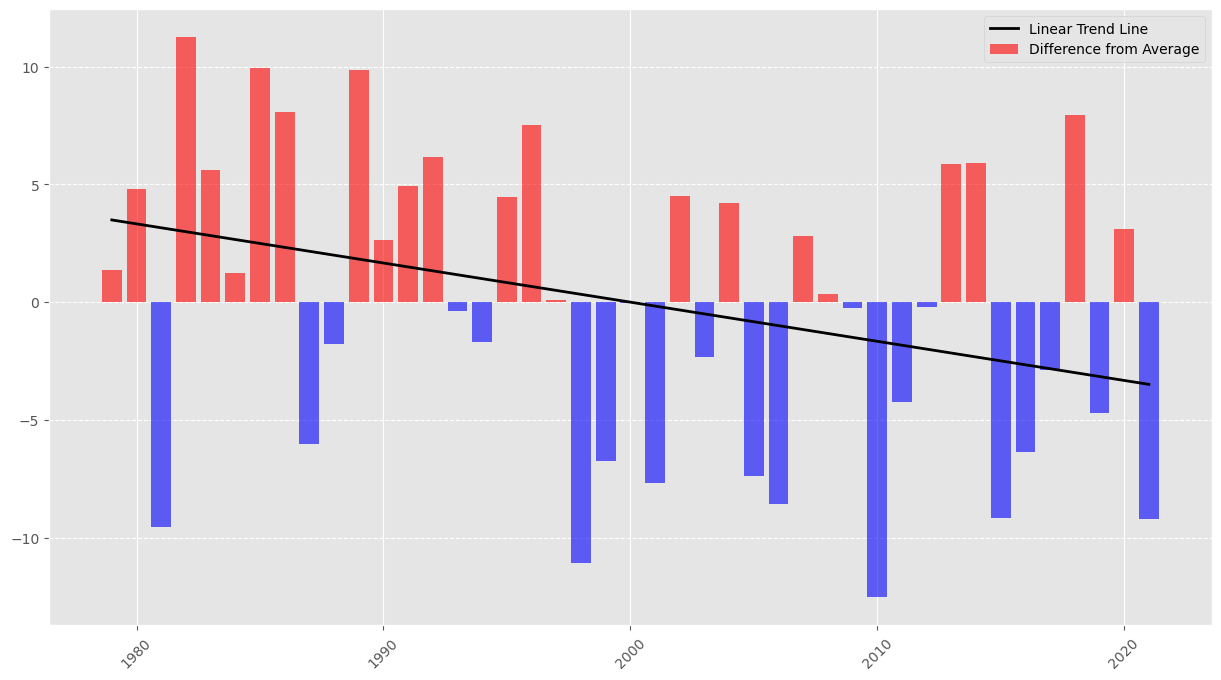

'\nThis figure shows the number of unfrozen days in the Canada compared with the\n1979–2021 average. For each year, the bar represents the number of days shorter or longer than\naverage. Positive numbers represent years with more unfrozen days than average. The trend line\nrepresents an ordinary least-squares linear regression. Data source: Kim and Kimball, 2022\n'

In [45]:

# Define the Soil state (Frozen, Thawed, Transition)
soil_state = 'Frozen'

# Step 1: Calculate the Annual mean of the soil state 
gp = main.groupby(['Grid', 'Year']).sum()
gp['year'] =  list(gp.index.get_level_values('Year'))
annual_mean_days = gp.groupby('year').mean()


# Step 2: Calculate the 1979-2021 Average
long_term_average_days = annual_mean_days['{}'.format(soil_state)].mean()

# Step 3: Calculate Difference from Average
difference_from_average = annual_mean_days['{}'.format(soil_state)] - long_term_average_days




# Calculate Linear Regression for Trend Line
# Converting index to a suitable format for linregress, assuming index is year and is numeric
x = difference_from_average.index.astype(int)  # Years
y = difference_from_average.values  # Difference from average

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the values of the trend line
trend_line = intercept + slope * x

# Generate values for the trend line
x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
y_line = intercept + slope * x_line



#Pefrom the MK test
mk_result = mk.original_test(y)



# Assuming your time series data is stored in variables 'x' (time) and 'y' (mean number of frozen days)
# Fit LOESS model
lowess = sm.nonparametric.lowess(y, x)
# Extract smoothed values
smoothed_values = lowess[:, 1]


# Constructing a Series to include various results from MK test and regression
results = pd.Series({
    'slope': slope,
    'b': intercept,
    'r': r_value,
    'std_err': std_err,
    'p_value': p_value,
    'MK_trend': mk_result.trend,
    'MK_p_value': mk_result.p,
    'MK_z': mk_result.z,
    'MK_tau': mk_result.Tau,
    'MK_s': mk_result.s,
    'MK_var_s': mk_result.var_s,
    'MK_h': mk_result.h
})

print(results)






###change
# Extract smoothed values and years
smoothed_values = lowess[:, 1]
smoothed_years = lowess[:, 0]

loess_df = pd.DataFrame()
loess_df['values'] = smoothed_values 
loess_df['year'] = smoothed_years
loess_df.set_index('year', inplace= True)

# Find the index corresponding to the change point (1994 in your case)
change_point_index = 1994


# Separate the data into two periods (before and after the change point)
period1_values = loess_df.loc[1979:change_point_index, :].values
period1_years = loess_df.loc[1979:change_point_index, :].index

period2_values = loess_df.loc[change_point_index:, :].values
period2_years = loess_df.loc[change_point_index:, :].index
print(period2_years, period2_values.reshape(1,-1))

# Perform linear regression
slope__, intercept__, r_value__, p_value__, std_err__ = linregress(period2_years, period2_values.reshape(1,-1))
print("Since 1994:", slope__, intercept__, r_value__, p_value__, std_err__)

# Fit linear regression models to each period
model_period1 = sm.OLS(period1_values, sm.add_constant(period1_years)).fit()
#Pefrom the MK test
mk_result_period1 = mk.original_test(period1_values)
print(model_period1.summary())
print(mk_result_period1)
model_period2 = sm.OLS(period2_values, sm.add_constant(period2_years)).fit()
#Pefrom the MK test
mk_result_period2 = mk.original_test(period2_values)
print(model_period2.summary())
print(mk_result_period2)
# Extract slope coefficients
slope_period1 = model_period1.params[1]
slope_period2 = model_period2.params[1]

print("Slope of the LOESS smoothed curve for the decreasing trend period (1979-1994):", slope_period1)
print("Slope of the LOESS smoothed curve for the increasing trend period (1994-2021):", slope_period2)





# Step 4: Plot
plt.figure(figsize=(15, 8))  # Adjusts the size of the figure
# difference_from_average.plot(kind='bar', color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))
# plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at y=0 for reference

# Bar chart
plt.bar(x, y, label='Difference from Average', alpha=0.6, color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))

# Trend line
plt.plot(x_line, y_line, color='black', linewidth=2, label='Linear Trend Line')





# Plot original data and LOESS smoothed curve
# plt.scatter(x, y, label='Original Data', color='blue', alpha=0.5)
# plt.plot(x, smoothed_values, label='LOESS Smoothed Curve', color='green', linewidth = 3)

# plt.axvline(x =1994)




# plt.title('Annual Difference in Unfrozen Days from the 1979–2021 Average')
# plt.xlabel('Year')
# plt.ylabel('Deviation from long term average (days)')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis

#annotate the figure with these results
# Constructing a Series to include various results from MK test and regression
new_results = pd.Series({
    'Slope': round(slope, 2),
    'R': round(r_value, 2),
    'MK Trend': mk_result.trend,
    'MK P Value': round(mk_result.p, 2)
})

annotate_text = '\n'.join([f'{key}: {value}' for key, value in new_results.items()])

# Add annotation to the figure
# plt.text(0.02, 0.98, annotate_text, verticalalignment='top', horizontalalignment='left', fontsize=8, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))


# Add note about linear regression trend
# linear_trend_note = "Linear Trend: unfrozen days per year".format(str(round(slope, 2)))
# plt.text(0.5, 0.9, linear_trend_note, ha='center', va='center', fontsize=10, color='blue', transform=plt.gca().transAxes)


plt.legend()

output_path_for_figure = r'C:\Users\salma\OneDrive - UQAM\canada-climate2024-soil-freezethaw\output\illustrator'
# i = i+1
name_file = "main"
plt.savefig(output_path_for_figure + '\\'+ name_file+'_EPA_.pdf')
plt.show()


'''
This figure shows the number of unfrozen days in the Canada compared with the
1979–2021 average. For each year, the bar represents the number of days shorter or longer than
average. Positive numbers represent years with more unfrozen days than average. The trend line
represents an ordinary least-squares linear regression. Data source: Kim and Kimball, 2022
'''

### Simple

-0.1662196456518415 480.58848716596026 -0.32914786563803067 0.03114458105085459 0.07447310008671677
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.982
Date:                Fri, 04 Oct 2024   Prob (F-statistic):             0.0311
Time:                        13:20:59   Log-Likelihood:                -137.47
No. Observations:                  43   AIC:                             278.9
Df Residuals:                      41   BIC:                             282.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

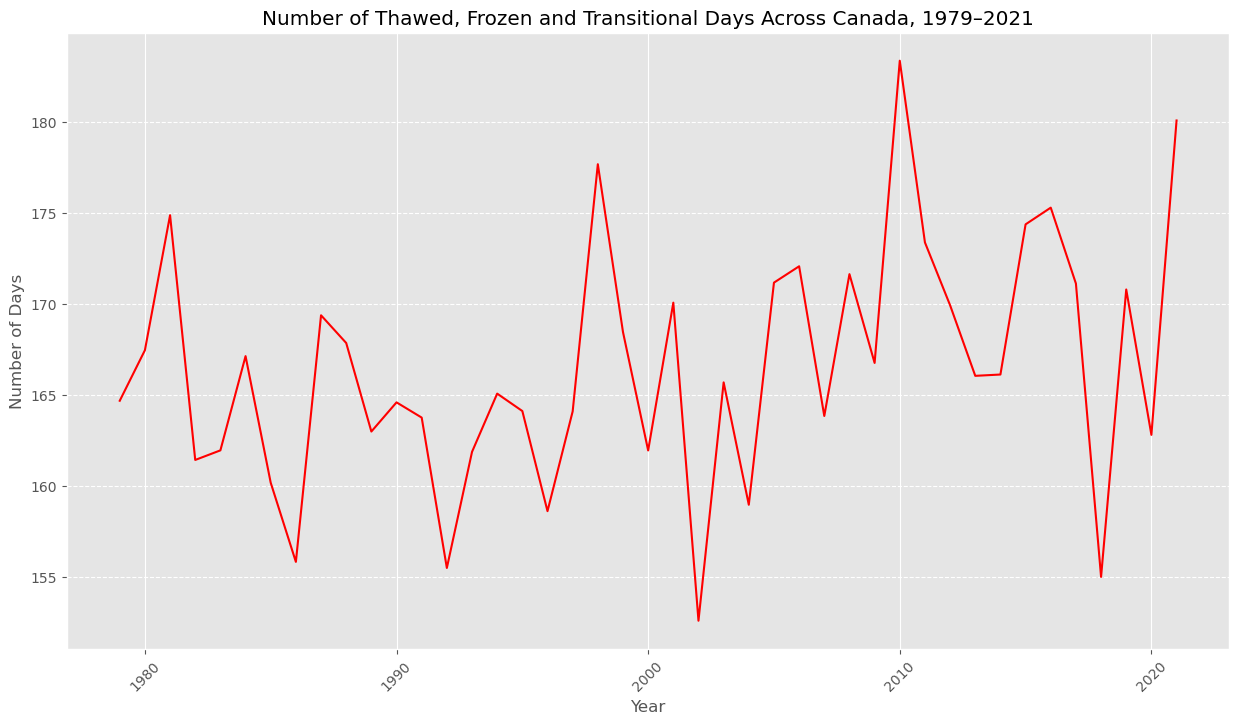

In [19]:

# Calculate Linear Regression for Trend Line
# Converting index to a suitable format for linregress, assuming index is year and is numeric
x = annual_mean_days.index.astype(int)  # Years
z = annual_mean_days['Frozen'].values 

ltm = z.mean()



# Perform linear regression Thawed
slope, intercept, r_value, p_value, std_err = linregress(x, z)

print(slope, intercept, r_value, p_value, std_err)


# Fit linear regression different Lib
model = sm.OLS(z, sm.add_constant(x)).fit()
print(model.summary())



unfrozen1 = (slope * 1979) + (intercept)
unfrozen2 = (slope * 2021) + (intercept)
print(unfrozen1, unfrozen2)
print(unfrozen2 - unfrozen1)




# Fit linear regression models to 1994 - 2021 period
slope_, intercept_, r_value_, p_value_, std_err_ = linregress(x[15:], z[15:]-ltm)
print(x[15:], z[15:])
print(slope_, intercept_, r_value_, p_value_, std_err_)
model_ = sm.OLS(z[15:]-ltm, sm.add_constant(x[15:])).fit()
print(model_.summary())


# Calculate the trend line's percentage increase per year 
z = annual_mean_days['Thawed'].values 
z0 = intercept + slope * 1979

print('Thawed', (slope / z0) * 1000)
print('Percent Increase Since 1994',(slope_/165.09017857)*1000 )


# Step 4: Plot
plt.figure(figsize=(15, 8))  # Adjusts the size of the figure


#  chart
plt.plot(x, z,  color='red', label = 'Thawed')


plt.title('Number of Thawed, Frozen and Transitional Days Across Canada, 1979–2021')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis
plt.show()

THAAAAED
0.1764696804629982 -186.39813848564606 0.33139343746587113 0.029945379155528286 0.07846442391568147
162.8353591506274 170.24708573007334
7.41172657944594
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     5.058
Date:                Fri, 04 Oct 2024   Prob (F-statistic):             0.0299
Time:                        13:21:03   Log-Likelihood:                -139.71
No. Observations:                  43   AIC:                             283.4
Df Residuals:                      41   BIC:                             286.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

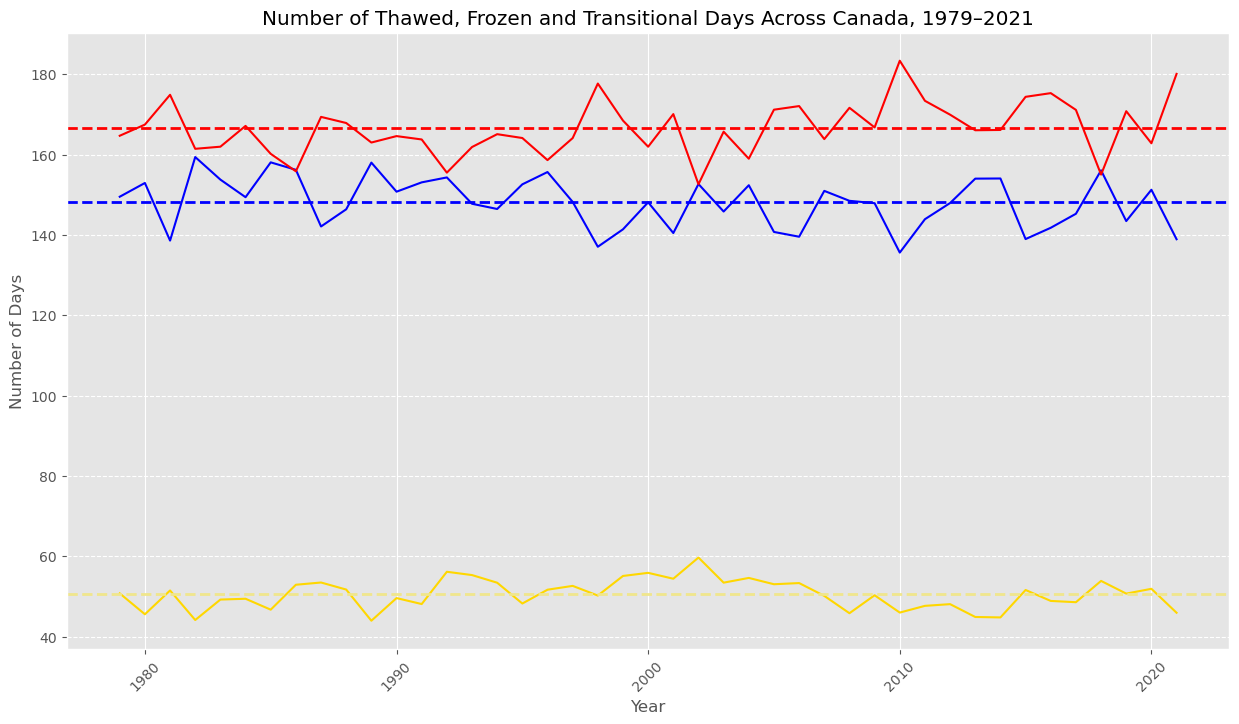

'\nThis figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.\nFor each year, the bar represents the number of days shorter or longer than average.\nPositive numbers represent years with more unfrozen days than average.\nChoosing a different long-term average for comparison would not change the shape of the data over time.\n'

In [20]:
# Step 1: Calculate the Annual mean of the soil state 
# gp = main.groupby(['Grid', 'Year']).sum()
# gp['year'] =  list(gp.index.get_level_values('Year'))
# annual_mean_days = gp.groupby('year').mean()


# Calculate Linear Regression for Trend Line
# Converting index to a suitable format for linregress, assuming index is year and is numeric
x = annual_mean_days.index.astype(int)  # Years
y = annual_mean_days['Frozen'].values  
z = annual_mean_days['Thawed'].values 
k = annual_mean_days['Transition'].values 



# Perform linear regression Frozen
slope_y, intercept_y, r_value_y, p_value_y, std_err_y = linregress(x, y)

# Calculate the values of the trend line
trend_line_y = intercept_y + slope_y * x

# Generate values for the trend line
x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
y_line = intercept_y + slope_y * x_line

#mk test
mk_result_y = mk.original_test(y)
# print('frozen', r_value_y, slope_y, mk_result_y)

# Fit LOESS model
lowess_y = sm.nonparametric.lowess(y, x)

# Extract smoothed values
smoothed_values_y = lowess_y[:, 1]




print('THAAAAED')
# Perform linear regression Thawed
slope_z, intercept_z, r_value_z, p_value_z, std_err_z = linregress(x, z)
print(slope_z, intercept_z, r_value_z, p_value_z, std_err_z)
unfrozen1 = (slope_z * 1979) + (intercept_z)
unfrozen2 = (slope_z * 2021) + (intercept_z)
print(unfrozen1, unfrozen2)
print(unfrozen2 - unfrozen1)


# Fit linear regression models to each period
model_period1 = sm.OLS(z, sm.add_constant(x)).fit()
print(model_period1.summary())

# Fit linear regression models to each period
slope_z_, intercept_z_, r_value_z_, p_value_z_, std_err_z_ = linregress(x[15:], z[15:])
print(slope_z_, intercept_z_, r_value_z_, p_value_z_, std_err_z_)
model_period_ = sm.OLS(z[15:], sm.add_constant(x[15:])).fit()
print(model_period_.summary())





# Calculate the values of the trend line
trend_line_z = intercept_z + slope_z * x

# Generate values for the trend line
x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
z_line = intercept_z + slope_z * x_line

#mk test
mk_result_z = mk.original_test(z)
print('thawed', r_value_z, slope_z, mk_result_z)

# Fit LOESS model
lowess_z = sm.nonparametric.lowess(z, x)

# Extract smoothed values
smoothed_values_z = lowess_z[:, 1]






# Perform linear regression Transition
slope_k, intercept_k, r_value_k, p_value_k, std_err_k = linregress(x, k)

# Calculate the values of the trend line
trend_line_k = intercept_k + slope_k * x

# Generate values for the trend line
x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
k_line = intercept_k + slope_k * x_line

#mk test
mk_result_k = mk.original_test(k)
print('transision',r_value_k, slope_k, mk_result_k)

# Fit LOESS model
lowess_k = sm.nonparametric.lowess(k, x)

# Extract smoothed values
smoothed_values_k = lowess_k[:, 1]


# Calculate the trend line's percentage increase per year

y = annual_mean_days['Frozen'].values  
z = annual_mean_days['Thawed'].values 
k = annual_mean_days['Transition'].values


y0 = intercept_y + slope_y * 1979
z0 = intercept_z + slope_z * 1979
k0 = intercept_k + slope_k * 1979
print('Frozen', (slope_y / y0) * 1000) #per decade
print('Thawed', (slope_z / y0) * 1000)
print('Transition', (slope_k / y0) * 1000)
print('Percent Increase Since 1994',(slope_period2/165.090179)*1000 )


# Step 4: Plot
plt.figure(figsize=(15, 8))  # Adjusts the size of the figure


#  chart
plt.plot(x, y, color='blue', label = 'Frozen')
plt.plot(x, z,  color='red', label = 'Thawed')
plt.plot(x, k,  color='gold', label = 'Transition')

# Trend line
# plt.plot(x_line, y_line, color='blue', linewidth=2, label='Trend Line', linestyle= '--')
# plt.plot(x_line, z_line, color='red', linewidth=2, label='Trend Line', linestyle= '--')
# plt.plot(x_line, k_line, color='khaki', linewidth=2, label='Trend Line', linestyle= '--')

plt.axhline(y.mean(),  color='blue', linewidth=2, linestyle= '--')
print(y.mean())

plt.axhline(z.mean(), color='red', linewidth=2, linestyle= '--')
print(z.mean())

plt.axhline(k.mean(),  color='khaki', linewidth=2, linestyle= '--')
print(k.mean())


# Plot LOESS smoothed curve
# plt.plot(x, smoothed_values_y, label='LOESS Smoothed Curve', color='red')
# plt.plot(x, smoothed_values_z, label='LOESS Smoothed Curve', color='red')
# plt.plot(x, smoothed_values_k, label='LOESS Smoothed Curve', color='red')

plt.title('Number of Thawed, Frozen and Transitional Days Across Canada, 1979–2021')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis
plt.show()


'''
This figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.
For each year, the bar represents the number of days shorter or longer than average.
Positive numbers represent years with more unfrozen days than average.
Choosing a different long-term average for comparison would not change the shape of the data over time.
'''

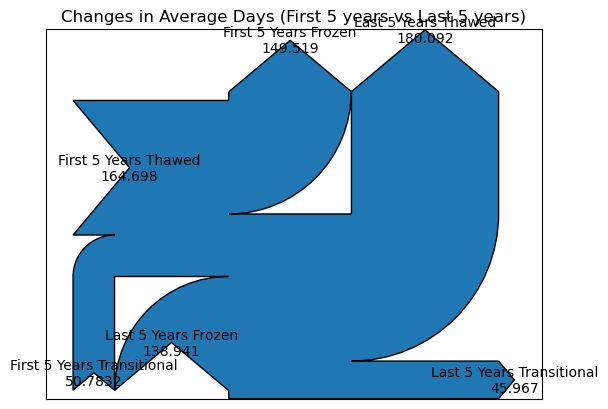

In [117]:
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
import numpy as np

# data 
years = annual_mean_days.index.astype(int)  # Years
frozen_days = annual_mean_days['Frozen'].values  
thawed_days = annual_mean_days['Thawed'].values 
transitional_days = annual_mean_days['Transition'].values 



# Calculate the average number of days for the first 5 years and the last 5 years
first_5_years_avg = np.mean(np.array([frozen_days[:1], thawed_days[:1], transitional_days[:1]]), axis=1)
last_5_years_avg = np.mean(np.array([frozen_days[-1:], thawed_days[-1:], transitional_days[-1:]]), axis=1)

# Create Sankey diagram
sankey = Sankey(flows=[-first_5_years_avg[0], first_5_years_avg[1], first_5_years_avg[2], 
                       last_5_years_avg[0], -last_5_years_avg[1], -last_5_years_avg[2]],
                labels=['First 5 Years Frozen', 'First 5 Years Thawed', 'First 5 Years Transitional',
                        'Last 5 Years Frozen', 'Last 5 Years Thawed', 'Last 5 Years Transitional'], orientations=[1, 0, -1, -1, 1, 0])

sankey.finish()
plt.title('Changes in Average Days (First 5 years vs Last 5 years)')
plt.show()


In [21]:
# Calculate the number of frozen days in 2021
frozen_days_2021 = annual_mean_days[annual_mean_days.index == 2021]['Thawed'].values[0]

# Calculate the number of frozen days in 1979
frozen_days_1979 = annual_mean_days[annual_mean_days.index == 1979]['Thawed'].values[0]

# Calculate the number of frozen days in 1994
frozen_days_1994 = annual_mean_days[annual_mean_days.index == 1994]['Thawed'].values[0]

# Calculate the percent increase compared to 1979
percent_increase_1979 = (frozen_days_2021 - frozen_days_1979) / frozen_days_1979 * 100

# Calculate the percent increase compared to 1994
percent_increase_1994 = (frozen_days_2021 - frozen_days_1994) / frozen_days_1994 * 100

# Print the results
print("Percent increase in frozen days compared to 1979:", percent_increase_1979, "%")
print("Percent increase in frozen days compared to 1994:", percent_increase_1994, "%")

Percent increase in frozen days compared to 1979: 9.346501862913241 %
Percent increase in frozen days compared to 1994: 9.08677911668702 %


### LOESS model

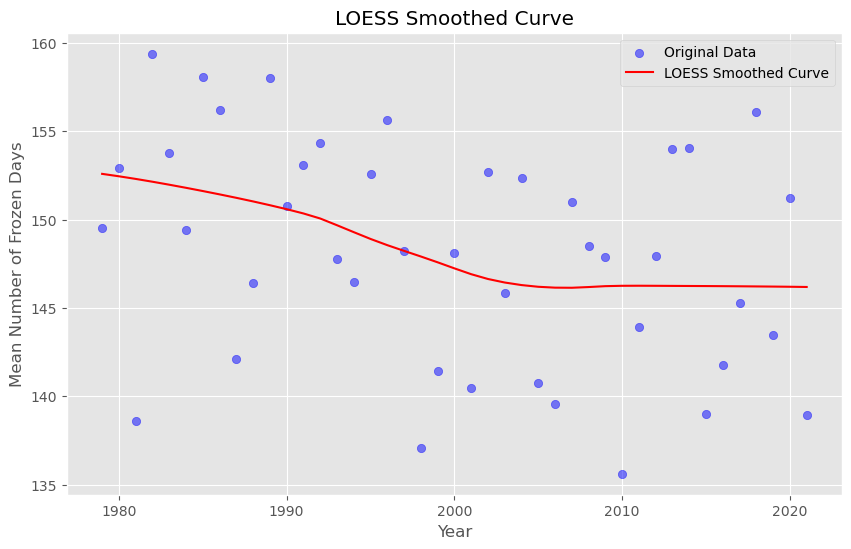

In [22]:
# Assuming your time series data is stored in variables 'x' (time) and 'y' (mean number of frozen days)

# Fit LOESS model
lowess = sm.nonparametric.lowess(y, x)

# Extract smoothed values
smoothed_values = lowess[:, 1]

# Plot original data and LOESS smoothed curve
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Original Data', color='blue', alpha=0.5)
plt.plot(x, smoothed_values, label='LOESS Smoothed Curve', color='red')
plt.xlabel('Year')
plt.ylabel('Mean Number of Frozen Days')
plt.title('LOESS Smoothed Curve')
plt.legend()
plt.grid(True)
plt.show()


### AutoCorrelation Analysis

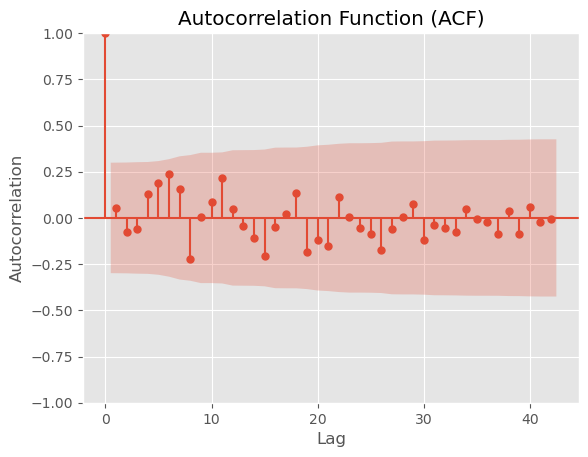

In [23]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf



# Calculate autocorrelation coefficients for various lags
auto_df = pd.DataFrame()
auto_df['Date'] = list(x)
auto_df.Date = pd.to_datetime(auto_df.Date, format= '%Y')
auto_df.set_index('Date', inplace=True)
auto_df['Value'] = list(y)
autocorr_values = auto_df.Value.autocorr(lag=5)


# Plot the autocorrelation function
plot_acf(auto_df['Value'], lags=42)  # Adjust 'lags' parameter as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

### Change Point Detection

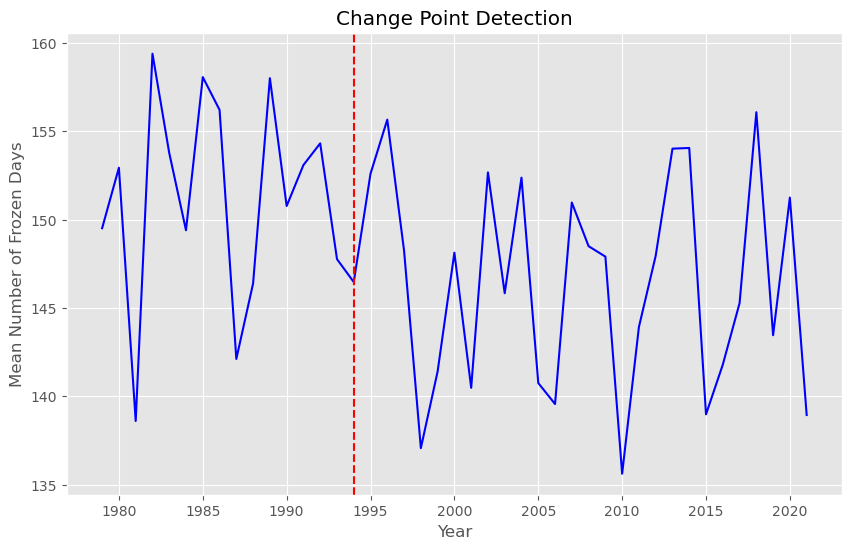

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt

# Assuming your DataFrame is named 'df'

# Convert datetime index to numpy array of timestamps
timestamps = auto_df.index.astype(np.int64) // 10 ** 9  # Convert nanoseconds to seconds

# Convert 'Value' column to numpy array
data = auto_df['Value'].values

# Check if the lengths of timestamps and data match
if len(timestamps) != len(data):
    raise ValueError("Lengths of timestamps and data do not match.")

# Perform change point detection using Pelt algorithm
model = "l2"  # Use "l2" for squared error, or "rbf" for radial basis function
algo = rpt.Pelt(model=model).fit(data)
result = algo.predict(pen=18)  # Adjust the penalty parameter 'pen' as needed

# Plot change points
plt.figure(figsize=(10, 6))
plt.plot(auto_df.index, data, color='blue')

# Plot the detected change points
for change_point in result:
    if change_point < len(auto_df.index):  # Check if the index is within bounds
        plt.axvline(x=auto_df.index[change_point], color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Mean Number of Frozen Days')
plt.title('Change Point Detection')
plt.show()


# Monthly

In [25]:
monthly_frozen_days = {}
monthly_transitional_days = {}
monthly_thawed_days = {}

for soil_state in ['Frozen', 'Thawed', 'Transition']:
    # Step 1: Calculate the Annual Sum of 'Thawed'
    annual_mean_days = main.groupby(['Year', 'Month'])[soil_state].mean()


    # Dictionary mapping month numbers to their corresponding abbreviated names
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }

    # Create an empty dictionary with keys as month names and empty lists as values
    month_dict = {month_names[month_num]: [] for month_num in range(1, 13)}



    for i in range (1979, 2022):
        for key in month_names.keys():
            month_dict[month_names[key]].append(annual_mean_days.loc[(i, key)])

    # Print the created dictionary
    print(month_dict)


    monthly = pd.DataFrame(month_dict)
    monthly['Year'] = np.arange(1979,2022,1)

    if soil_state == 'Frozen':
        df_frozen = monthly
       
        

    if soil_state == 'Thawed':
        df_thawed =  monthly
        
    
    if soil_state == 'Transition':
        df_transition =  monthly
    

{'Jan': [29.370373376623377, 28.50073051948052, 28.519805194805194, 30.206087662337662, 29.070779220779222, 29.195454545454545, 29.422646103896103, 29.171996753246752, 28.43522727272727, 28.431006493506494, 28.87581168831169, 28.744642857142857, 29.885957792207794, 28.268587662337662, 29.51176948051948, 29.98766233766234, 29.414691558441557, 29.5450487012987, 29.520698051948052, 29.442126623376623, 29.290097402597404, 29.49586038961039, 29.234253246753248, 28.040016233766234, 28.318181818181817, 29.896266233766234, 29.366883116883116, 26.812743506493508, 28.273538961038962, 28.912905844155844, 29.81672077922078, 28.504383116883115, 29.145454545454545, 28.069155844155844, 28.76948051948052, 28.551298701298702, 28.971103896103894, 28.469155844155843, 27.305113636363636, 28.848863636363635, 29.086201298701297, 28.679301948051947, 28.177597402597403], 'Feb': [27.477597402597404, 28.190016233766233, 23.982792207792208, 27.315746753246753, 26.32418831168831, 25.73311688311688, 26.65933441558

In [26]:
df_thawed

Jan       Feb       Mar        Apr        May        Jun        Jul  \
0   0.544724  0.127679  0.861932   4.562906  17.564610  25.726948  30.016883   
1   0.233360  0.068182  0.401948   7.677354  21.563393  26.812256  30.158929   
2   0.292532  1.410227  1.462987   6.300812  18.631088  26.972078  30.092614   
3   0.064448  0.069481  0.210714   3.065584  18.013555  26.676623  30.185065   
4   0.249919  0.214773  0.955032   6.423214  16.480357  26.944724  30.091153   
5   0.403734  0.690179  0.956737   9.016234  19.596510  27.227029  30.044481   
6   0.125162  0.145942  0.215828   5.438312  18.807873  27.383198  30.006250   
7   0.134253  0.151136  0.902435   7.866883  18.719075  24.942614  29.469481   
8   0.437094  0.110227  1.603653   8.590666  17.665828  25.011688  30.136932   
9   0.412825  0.320617  1.154951   6.289205  18.766558  26.660714  30.603409   
10  0.259903  0.148539  0.540828   4.930438  18.894156  27.029708  30.474188   
11  0.350893  0.150731  1.678084   6.368182  17.523377  26.269643  30.524919   
12  0.204302  0.515179  0.747971   7.844075  19.267614  27.630114  30.464935   
13  0.755357  0.492370  1.358847   5.877841  16.613880  25.171023  30.314529   
14  0.355844  0.151867  1.120617   8.453247  21.512256  28.006331  30.490341   
15  0.170779  0.268669  0.510390   4.411445  19.446997  27.932143  30.335714   
16  0.495617  0.177110  2.224594   6.483279  20.406818  28.213231  30.387419   
17  0.367289  0.647565  0.523945   5.434497  16.409010  27.659984  30.351136   
18  0.334010  0.202192  0.484497   5.144643  18.674107  27.791883  30.300893   
19  0.287581  0.832955  1.474026   9.328166  22.988312  29.158766  30.415097   
20  0.378815  0.370130  1.095698   7.910714  20.565503  27.039448  30.334740   
21  0.293831  0.785308  2.676461   6.900406  18.445617  26.793669  30.395942   
22  0.261364  0.134010  0.573377   6.314367  21.047321  27.798864  30.424756   
23  0.551542  0.270130  0.371672   4.891477  15.595211  27.236851  30.357386   
24  0.449756  0.125406  1.177029   7.100000  19.851218  27.683929  30.446834   
25  0.217045  0.166396  1.187825   6.573133  16.694805  27.427516  30.405601   
26  0.350244  0.295860  0.780682   9.675974  21.575974  28.279221  30.334984   
27  0.624269  0.208198  0.987744   9.562013  22.824594  28.233847  30.430925   
28  0.701136  0.134334  1.466883   7.114773  19.331656  27.539448  30.577922   
29  0.796672  0.246023  0.329464   5.783198  20.916721  27.847565  30.714610   
30  0.217127  0.370698  0.778084   5.969805  16.323458  27.039367  30.736769   
31  0.779627  0.667938  2.431656  12.583198  20.463149  28.022159  30.727760   
32  0.542289  0.256088  0.651542   3.944237  19.030519  27.973458  30.709253   
33  0.597403  0.247484  3.289692   7.163312  20.012744  28.928896  30.675081   
34  0.714773  0.209091  0.893588   3.540179  19.410390  27.947727  30.484172   
35  0.505438  0.109578  0.256818   5.117776  20.766153  27.806737  30.691640   
36  0.383604  0.188312  1.202435   8.687906  21.444562  28.222321  30.747484   
37  0.519724  0.471510  1.949269   7.750731  22.119318  28.370130  30.680032   
38  0.991315  0.690584  1.073864   7.004140  22.167532  28.391802  30.577354   
39  0.437581  0.269886  0.488068   4.384497  19.224432  27.234578  30.550649   
40  0.310308  0.125244  1.004870   7.493263  21.244399  28.735146  30.772890   
41  0.422484  0.129951  0.654058   5.059659  17.263799  27.554058  30.789448   
42  0.641640  0.201055  2.147159   8.402354  18.290990  27.424919  30.640016   

          Aug        Sep        Oct        Nov       Dec  Year  
0   28.598214  25.227679  20.670455   8.587987  2.208036  1979  
1   29.247565  24.623782  18.933198   7.169399  0.584010  1980  
2   29.053247  25.651705  20.086201  12.340828  2.595049  1981  
3   28.249269  24.870698  20.738799   6.965909  2.337175  1982  
4   28.614610  24.930032  17.664610   9.162094  0.243182  1983  
5   28.659578  23.748620  18.643019   7.139042  1.023945  1984  
6   28.134172  24.910471  19.3420

In [27]:
df_frozen

Jan        Feb        Mar        Apr       May       Jun       Jul  \
0   29.370373  27.477597  25.342370  16.310471  6.282062  1.903653  0.060552   
1   28.500731  28.190016  27.384984  13.615503  4.986039  1.253084  0.063231   
2   28.519805  23.982792  23.259253  16.022078  5.943425  0.545455  0.086851   
3   30.206088  27.315747  27.688718  19.096591  6.898133  1.359984  0.099756   
4   29.070779  26.324188  25.988068  14.575487  8.410958  0.485471  0.048864   
5   29.195455  25.733117  25.091071  12.375487  5.698133  0.437175  0.068588   
6   29.422646  26.659334  26.431250  16.981169  5.508279  0.488068  0.030519   
7   29.171997  26.724188  25.023377  14.141721  5.925162  2.209334  0.168588   
8   28.435227  26.494805  24.561769  13.399188  7.624838  1.474351  0.061688   
9   28.431006  26.805276  25.003409  13.417776  7.035552  1.028003  0.080114   
10  28.875812  27.325487  28.224756  15.176948  7.184903  0.759903  0.105682   
11  28.744643  26.703084  24.519075  16.098214  7.238474  1.242695  0.114042   
12  29.885958  24.790584  25.990909  13.977192  6.176461  0.578409  0.136526   
13  28.268588  26.578490  23.348052  15.353003  7.334497  1.543669  0.130601   
14  29.511769  26.792127  24.029058  11.537256  4.462906  0.291071  0.075731   
15  29.987662  27.291396  24.337581  14.915097  4.859578  0.383442  0.106331   
16  29.414692  26.708442  23.528977  13.757792  5.482630  0.271753  0.105114   
17  29.545049  26.789773  26.771916  14.633442  6.635065  0.599594  0.140097   
18  29.520698  26.650731  27.327110  14.695779  5.926461  0.655276  0.111201   
19  29.442127  24.322890  24.751299  10.347484  4.302354  0.116802  0.091721   
20  29.290097  26.024513  23.264610  12.163231  5.713636  0.771347  0.102922   
21  29.495860  26.384578  20.980519  14.216234  5.792045  1.113880  0.119805   
22  29.234253  27.146510  24.597890  13.427110  5.085552  0.487581  0.100487   
23  28.040016  25.948214  27.886769  17.483036  7.788636  0.496834  0.088636   
24  28.318182  26.983604  25.010065  14.787013  5.885714  0.738636  0.097808   
25  29.896266  27.325812  25.028490  14.578409  8.224513  0.591802  0.098620   
26  29.366883  25.767857  25.093019  11.378328  5.541802  0.272403  0.101218   
27  26.812744  26.250568  24.777597  11.521185  3.747727  0.525649  0.103653   
28  28.273539  27.308847  24.707224  14.081575  6.884253  0.825812  0.063393   
29  28.912906  27.673295  26.754708  14.021104  3.796429  0.465909  0.052273   
30  29.816721  26.815909  26.342208  13.451786  7.398052  0.372321  0.055357   
31  28.504383  25.555925  20.644075   9.239042  5.467857  0.310795  0.052029   
32  29.145455  26.519724  26.514367  14.893506  6.047240  0.599756  0.052516   
33  28.069156  26.585471  22.285633  12.388068  4.586851  0.128977  0.056412   
34  28.769481  26.430276  25.801055  17.562906  6.196753  0.645130  0.124756   
35  28.551299  27.505114  27.800244  15.139935  4.791234  0.759172  0.042857   
36  28.971104  26.824675  24.624026  12.951867  5.290584  0.350244  0.045536   
37  28.469156  26.514610  23.329627  14.882224  4.751380  0.401623  0.069481   
38  27.305114  25.031250  25.700000  13.735308  4.127273  0.453815  0.089529   
39  28.848864  26.911932  26.153815  18.587987  7.684416  0.910877  0.105195   
40  29.086201  27.439205  23.814367  13.924675  5.238393  0.188474  0.042208   
41  28.679302  27.519562  26.531656  16.969399  7.468750  0.502110  0.037256   
42  28.177597  26.804545  22.510390  12.145373  5.656088  0.502597  0.081737   

         Aug       Sep       Oct        Nov        Dec  Year  
0   0.496023  1.596753  4.399838  12.618019  23.661039  1979  
1   0.312906  1.164610  4.773539  14.740016  27.956250  1980  
2   0.489123  1.460227  4.105844  10.332955  23.854870  1981  
3   0.535877  1.431575  4.556331  15.386120  24.821429  1982  
4   0.473701  1.143669  4.912744  13.229870  29.117045  1983  
5   0.437744  2.048052  6.280601  15.653571  26.383847  1984  
6   0.534578  1.530114  4.921429  18.758279  26.

In [28]:
df_transition

Jan       Feb       Mar        Apr       May       Jun       Jul  \
0   1.084903  0.394724  4.795698   9.126623  7.153328  2.369399  0.922565   
1   2.265909  0.741802  3.213068   8.707143  4.450568  1.934659  0.777841   
2   2.187662  2.606981  6.277760   7.677110  6.425487  2.482468  0.820536   
3   0.729464  0.614773  3.100568   7.837825  6.088312  1.963393  0.715179   
4   1.679302  1.461039  4.056899   9.001299  6.108685  2.569805  0.859984   
5   1.400812  2.576705  4.952192   8.608279  5.705357  2.335795  0.886932   
6   1.452192  1.194724  4.352922   7.580519  6.683847  2.128734  0.963231   
7   1.693750  1.124675  5.074188   7.991396  6.355763  2.848052  1.361932   
8   2.127679  1.394968  4.834578   8.010146  5.709334  3.513961  0.801380   
9   2.156169  1.874107  4.841640  10.293019  5.197890  2.311282  0.316477   
10  1.864286  0.525974  2.234416   9.892614  4.920942  2.210390  0.420130   
11  1.904464  1.146185  4.802841   7.533604  6.238149  2.487662  0.361039   
12  0.909740  2.694237  4.261120   8.178734  5.555925  1.791477  0.398539   
13  1.976055  1.929140  6.293101   8.769156  7.051623  3.285308  0.554870   
14  1.132386  1.056006  5.850325  10.009497  5.024838  1.702597  0.433929   
15  0.841558  0.439935  6.152029  10.673458  6.693425  1.684416  0.557955   
16  1.089692  1.114448  5.246429   9.758929  5.110552  1.515016  0.507468   
17  1.087662  1.562662  3.704140   9.932062  7.955925  1.740422  0.508766   
18  1.145292  1.147078  3.188393  10.159578  6.399432  1.552841  0.587906   
19  1.270292  2.844156  4.774675  10.324351  3.709334  0.724432  0.493182   
20  1.331088  1.605357  6.639692   9.926055  4.720860  2.189205  0.562338   
21  1.210308  1.830114  7.343019   8.883360  6.762338  2.092451  0.484253   
22  1.504383  0.719481  5.828734  10.258523  4.867127  1.713555  0.474756   
23  2.408442  1.781656  2.741558   7.625487  7.616153  2.266315  0.553977   
24  2.232062  0.890990  4.812906   8.112987  5.263068  1.577435  0.455357   
25  0.886688  1.507792  4.783685   8.848458  6.080682  1.980682  0.495779   
26  1.282873  1.936282  5.126299   8.945698  3.882224  1.448377  0.563799   
27  3.562987  1.541234  5.234659   8.916802  4.427679  1.240503  0.465422   
28  2.025325  0.556818  4.825893   8.803653  4.784091  1.634740  0.358685   
29  1.290422  1.080682  3.915828  10.195698  6.286851  1.686526  0.233117   
30  0.966153  0.813393  3.879708  10.578409  7.278490  2.588312  0.207873   
31  1.715990  1.776136  7.924269   8.177760  5.068994  1.667045  0.220211   
32  1.312256  1.224188  3.834091  11.162256  5.922240  1.426786  0.238231   
33  2.333442  2.167045  5.424675  10.448620  6.400406  0.942127  0.268506   
34  1.515747  1.360633  4.305357   8.896916  5.392857  1.407143  0.391071   
35  1.943263  0.385308  2.942938   9.742289  5.442614  1.434091  0.265503   
36  1.645292  0.987013  5.173539   8.360227  4.264854  1.427435  0.206981   
37  2.011120  2.013880  5.721104   7.367045  4.129302  1.228247  0.250487   
38  2.703571  2.278166  4.226136   9.260552  4.705195  1.154383  0.333117   
39  1.713555  0.818182  4.358117   7.027516  4.091153  1.854545  0.344156   
40  1.603490  0.435552  6.180763   8.582062  4.517208  1.076380  0.184903   
41  1.898214  1.350487  3.814286   7.970942  6.267451  1.943831  0.173295   
42  2.180763  0.994399  6.342451   9.452273  7.052922  2.072484  0.278247   

         Aug       Sep        Oct        Nov       Dec  Year  
0   1.905763  3.175568   5.929708   8.793994  5.130925  1979  
1   1.439529  4.211607   7.293263   8.090584  2.459740  1980  
2   1.457630  2.888068   6.807955   7.326218  4.550081  1981  
3   2.214854  3.697727   5.704870   7.647971  3.841396  1982  
4   1.911688  3.926299   8.422646   7.608036  1.639773  1983  
5   1.902679  4.203328   6.076380   7.207386  3.592208  1984  
6   2.331250  3.559416   6.736526   6.312744  3.435552  1985  
7   2.387744  4.504545   7.140422   7.811039  4.642127  1986  
8   1.666477  2.273214   7.353896   8.017370  7.78944

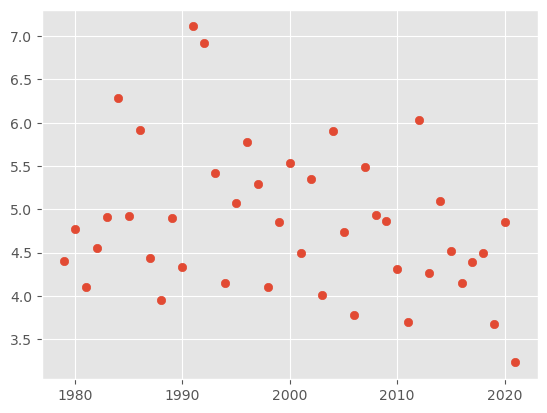

In [29]:
plt.scatter(df_frozen.Year, df_frozen.Oct)

## Probability

In [30]:

# Calculate transition probabilities for each month
transition_probabilities = main.groupby(['Year', 'Month'])[['Frozen', 'Thawed', 'Transition']].mean()

# Calculate total transitions from frozen state
transition_probabilities['total'] = (
    transition_probabilities['Frozen'] +
    transition_probabilities['Thawed'] +
    transition_probabilities['Transition']
)

# Calculate transition probabilities
transition_probabilities['prob_Thawed'] = (
    transition_probabilities['Thawed'] /
    transition_probabilities['total']
)

# Calculate transition probabilities
transition_probabilities['prob_Frozen'] = (
    transition_probabilities['Frozen'] /
    transition_probabilities['total']
)

transition_probabilities['prob_Transitional'] = (
    transition_probabilities['Transition'] /
    transition_probabilities['total']
)

# Display the resulting DataFrame with transition probabilities
transition_probabilities.reset_index(inplace=True)











# Generate random probabilities for the first 5 years
frozen_prob_first_5_years = []
thawed_prob_first_5_years = []

# Generate random probabilities for the last 5 years
frozen_prob_last_5_years = []
thawed_prob_last_5_years = []


for month in range (1,13):

    frozen_prob_first_5_years.append(transition_probabilities.groupby('Month').get_group(month)['prob_Frozen'][:5].mean())
    frozen_prob_last_5_years.append(transition_probabilities.groupby('Month').get_group(month)['prob_Frozen'][-5:].mean())

    thawed_prob_first_5_years.append(transition_probabilities.groupby('Month').get_group(month)['prob_Thawed'][:5].mean())
    thawed_prob_last_5_years.append(transition_probabilities.groupby('Month').get_group(month)['prob_Thawed'][-5:].mean())

frozen_prob_first_5_years = np.array(frozen_prob_first_5_years)
thawed_prob_first_5_years = np.array(thawed_prob_first_5_years)
transition_prob_first_5_years = 1 - frozen_prob_first_5_years - thawed_prob_first_5_years


frozen_prob_last_5_years = np.array(frozen_prob_last_5_years)
thawed_prob_last_5_years = np.array(thawed_prob_last_5_years)
transition_prob_last_5_years = 1 - frozen_prob_last_5_years - thawed_prob_last_5_years

In [66]:
(thawed_prob_last_5_years - thawed_prob_first_5_years )*100

array([ 0.91506075, -0.33982151,  0.95187474,  2.87602814,  3.8310641 ,
        4.13858225,  1.79723502,  3.80063888,  3.55108225, -4.93118978,
       -9.99431818, -0.54650189])

In [69]:
(frozen_prob_last_5_years - frozen_prob_first_5_years )*100

array([-2.30367616e+00,  3.13765514e-01, -3.19559070e+00, -2.83825758e+00,
       -1.51335358e+00, -1.99318182e+00, -2.14704650e-03, -3.41851697e-01,
       -2.32521645e-01, -1.35400084e+00,  4.11347403e+00, -3.04105572e+00])

In [70]:
(transition_prob_last_5_years - transition_prob_first_5_years )*100

array([ 1.38861542,  0.02605599,  2.24371596, -0.03777056, -2.31771052,
       -2.14540043, -1.79508798, -3.45878718, -3.31856061,  6.28519062,
        5.88084416,  3.5875576 ])

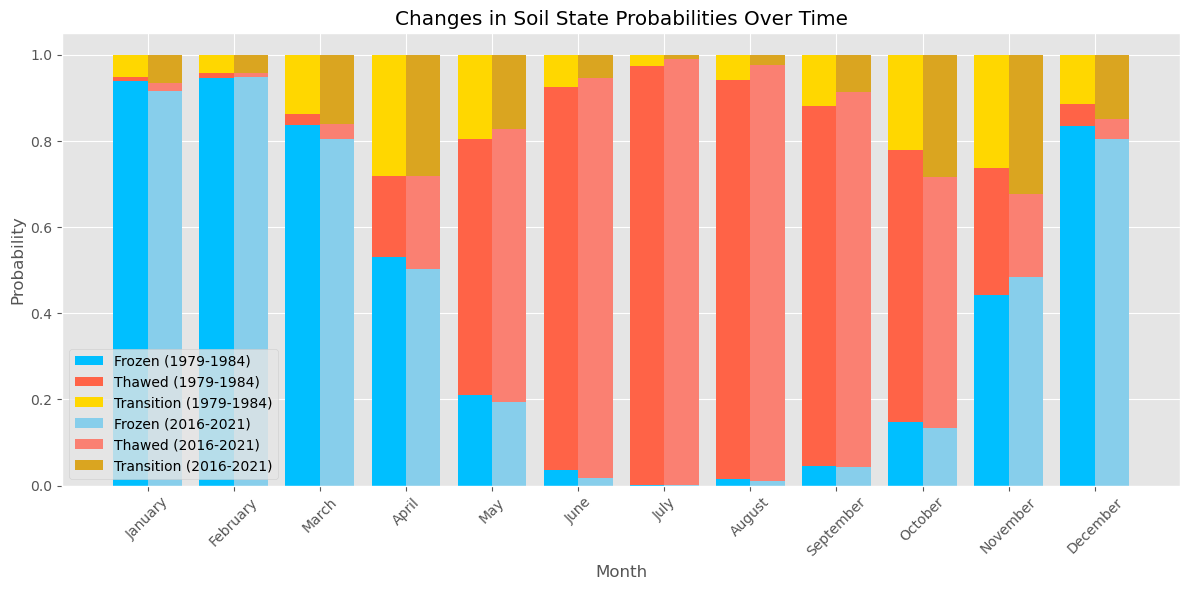

In [31]:

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

bar_width = 0.4  # Decrease bar width
index = np.arange(len(months))

plt.figure(figsize=(12, 6))

# Plot bars for the first 5 years
plt.bar(index - bar_width/2, frozen_prob_first_5_years, bar_width, color='deepskyblue', label='Frozen (1979-1984)')
plt.bar(index - bar_width/2, thawed_prob_first_5_years, bar_width, bottom=frozen_prob_first_5_years, color='tomato', label='Thawed (1979-1984)')
plt.bar(index - bar_width/2, transition_prob_first_5_years, bar_width, bottom=frozen_prob_first_5_years + thawed_prob_first_5_years, color='gold', label='Transition (1979-1984)')

# Plot bars for the last 5 years
plt.bar(index + bar_width/2, frozen_prob_last_5_years, bar_width, color='skyblue', label='Frozen (2016-2021)')
plt.bar(index + bar_width/2, thawed_prob_last_5_years, bar_width, bottom=frozen_prob_last_5_years, color='salmon', label='Thawed (2016-2021)')
plt.bar(index + bar_width/2, transition_prob_last_5_years, bar_width, bottom=frozen_prob_last_5_years + thawed_prob_last_5_years, color='goldenrod', label='Transition (2016-2021)')

plt.xlabel('Month')
plt.ylabel('Probability')
plt.title('Changes in Soil State Probabilities Over Time')
plt.xticks(index, months, rotation=45)  # Rotate month labels
plt.legend()
plt.tight_layout()
plt.show()


## Bar Chart

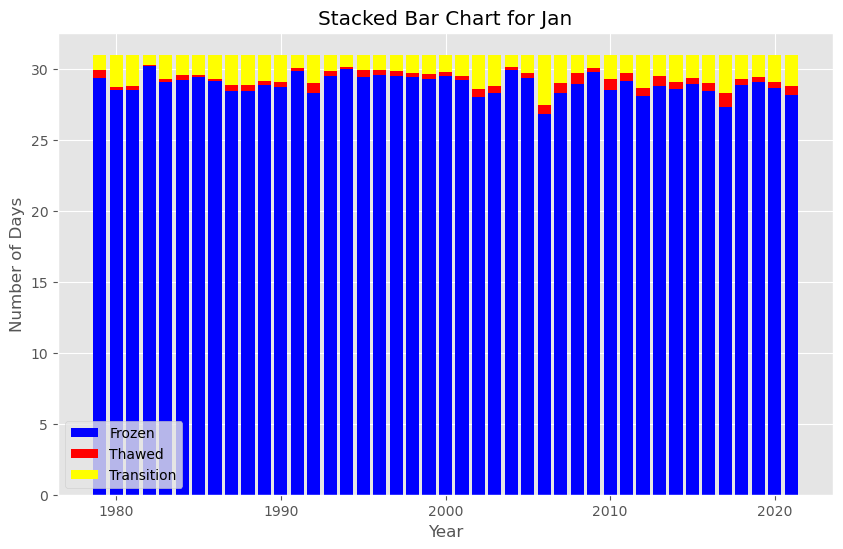

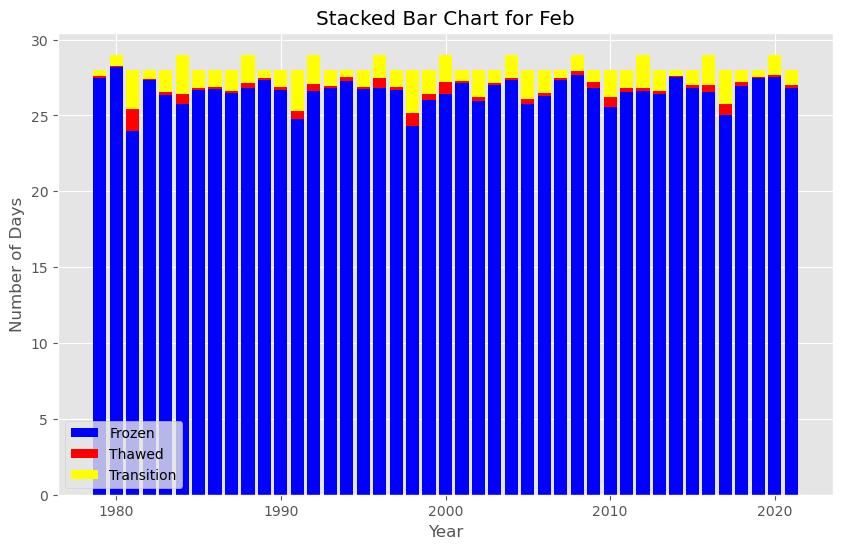

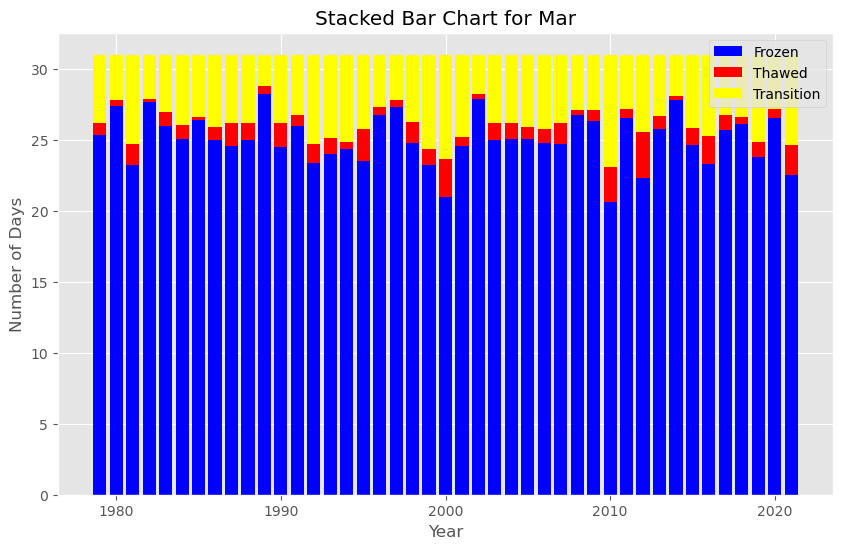

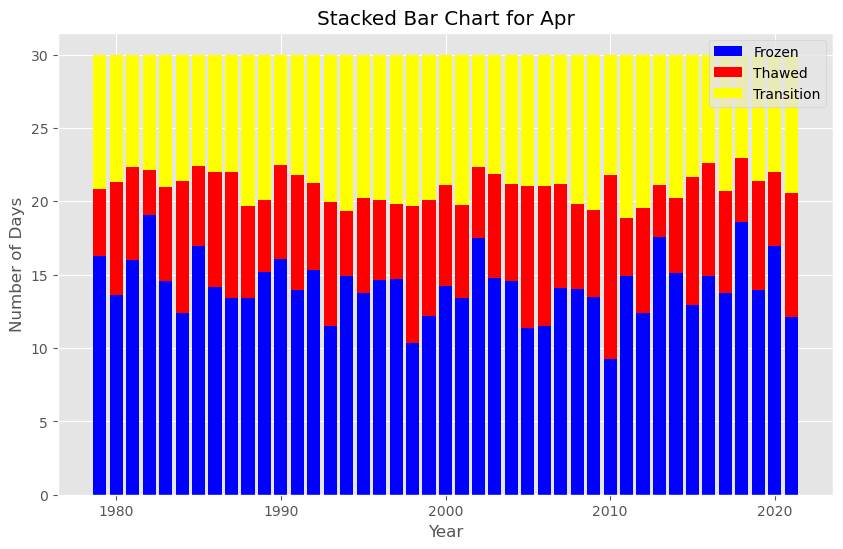

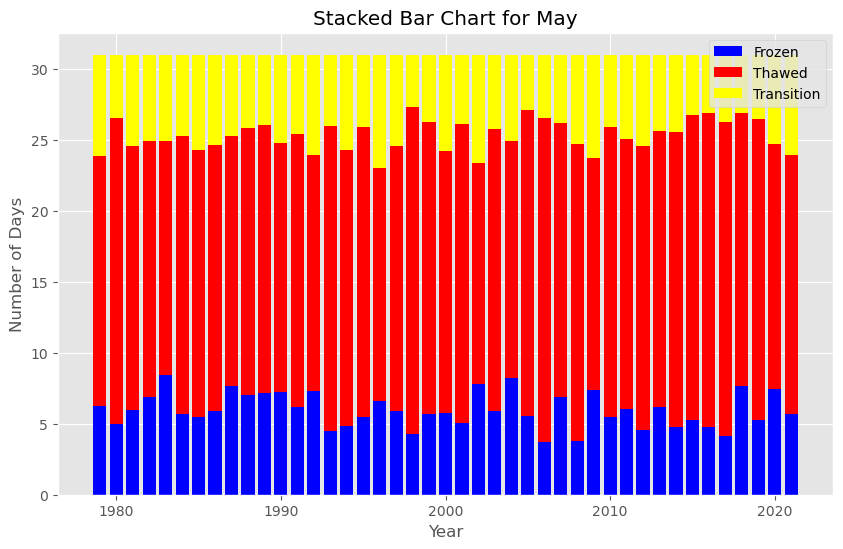

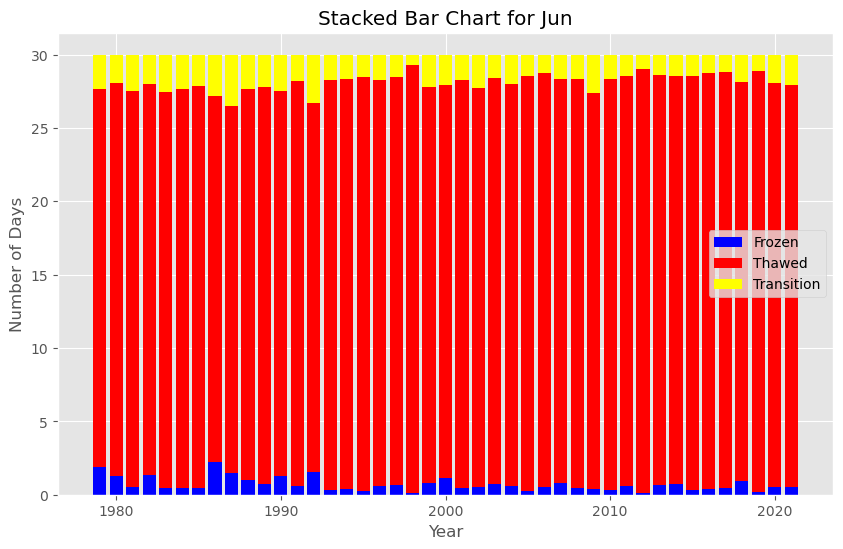

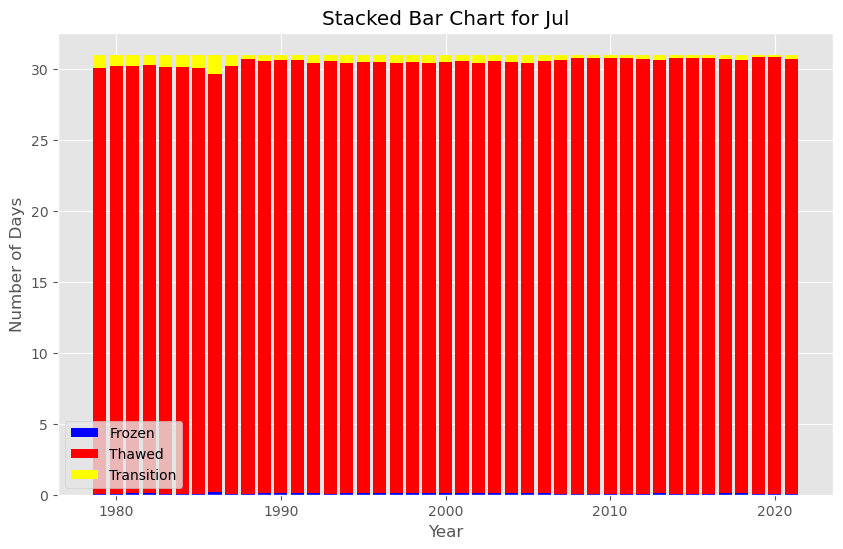

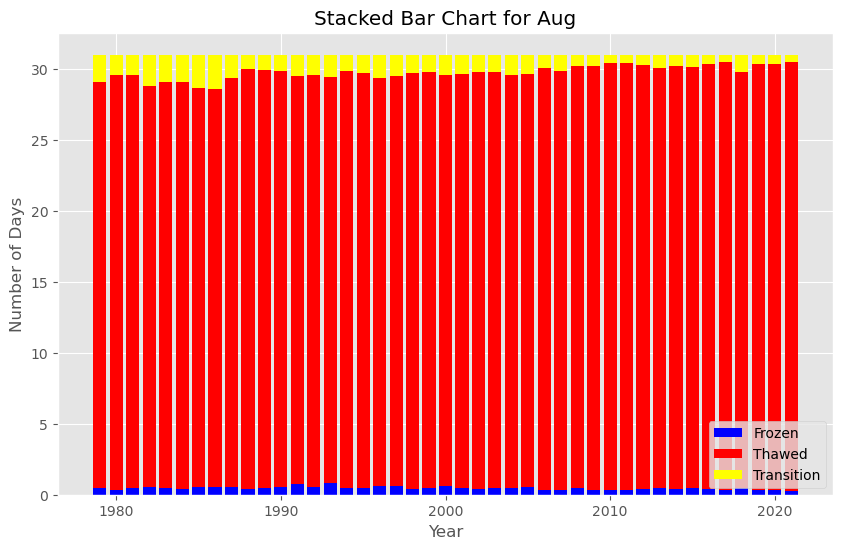

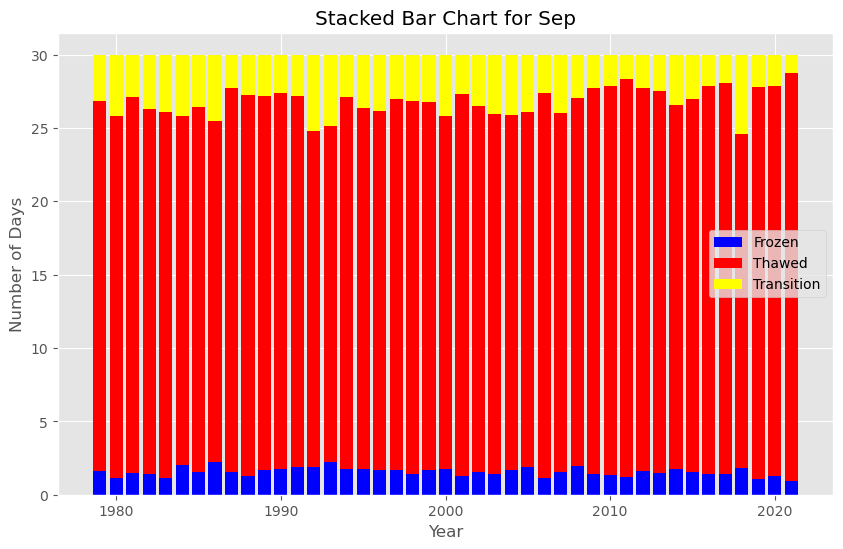

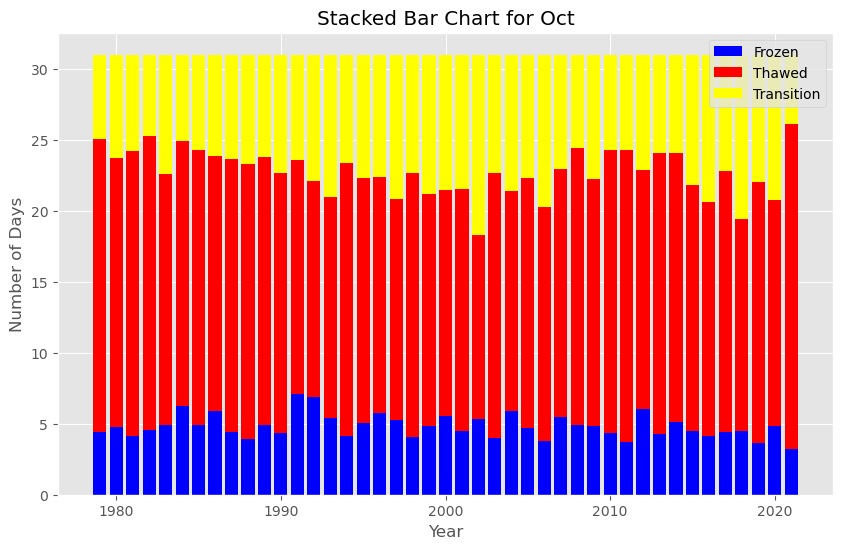

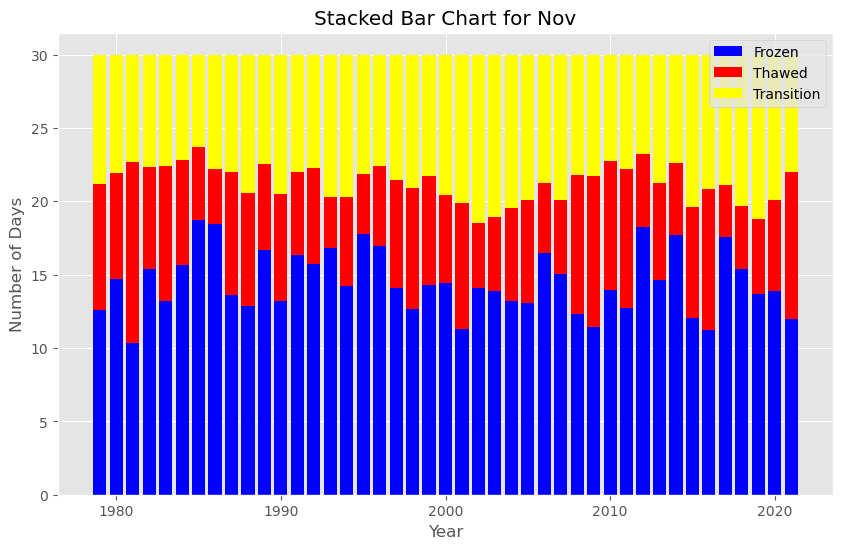

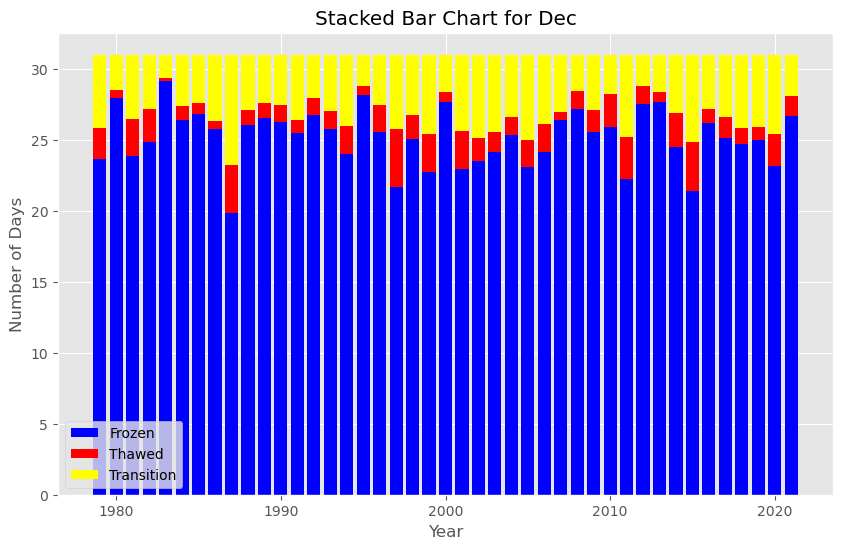

In [32]:
# List of months
months = df_frozen.columns[:-1]

# Plotting each month separately
for month in months:
    plt.figure(figsize=(10, 6))
    
    # Stacking the data
    bottom = np.zeros(len(df_frozen))
    plt.bar(df_frozen['Year'], df_frozen[month], color='blue', label='Frozen', bottom=bottom)
    bottom += df_frozen[month]
    plt.bar(df_thawed['Year'], df_thawed[month], color='red', label='Thawed', bottom=bottom)
    bottom += df_thawed[month]
    plt.bar(df_transition['Year'], df_transition[month], color='yellow', label='Transition', bottom=bottom)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Days')
    plt.title(f'Stacked Bar Chart for {month}')
    plt.legend()
    plt.show()


/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/2106470592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Dec'] = dec_clm[:-1]
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/2106470592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Dec'] = dec_clm[:-1]
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/2106470592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

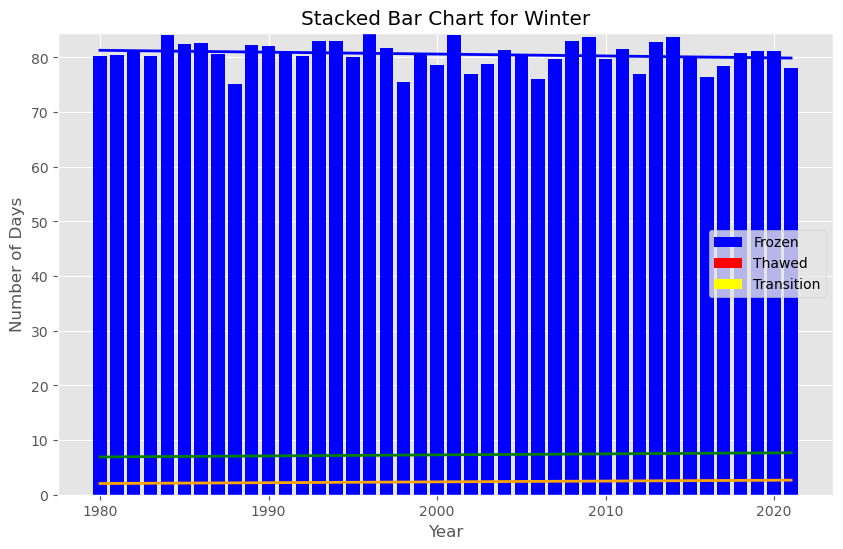

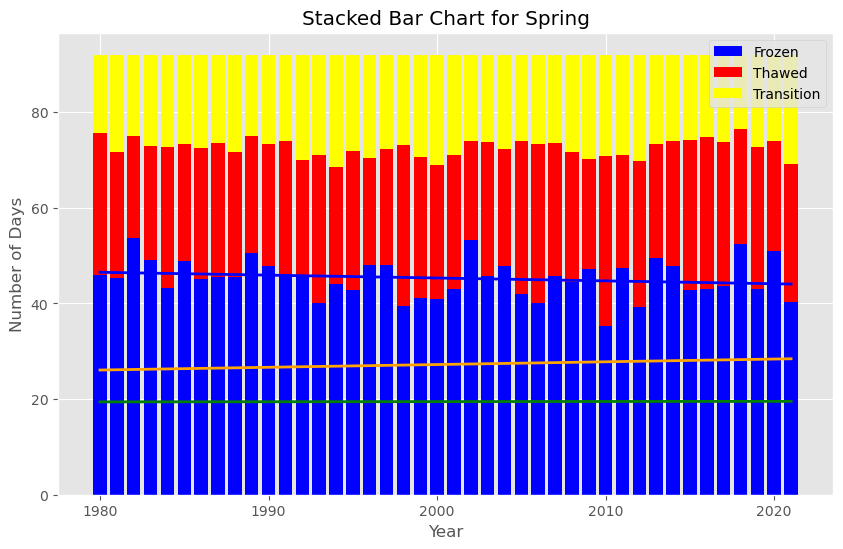

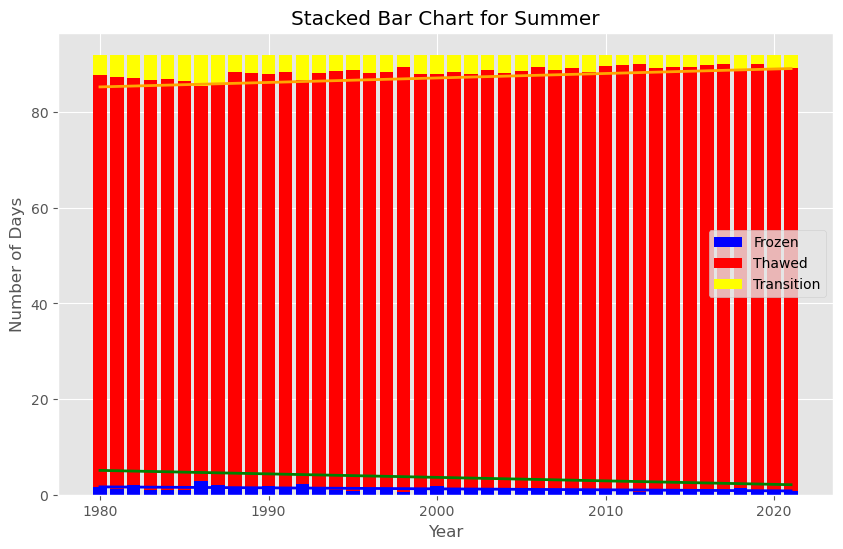

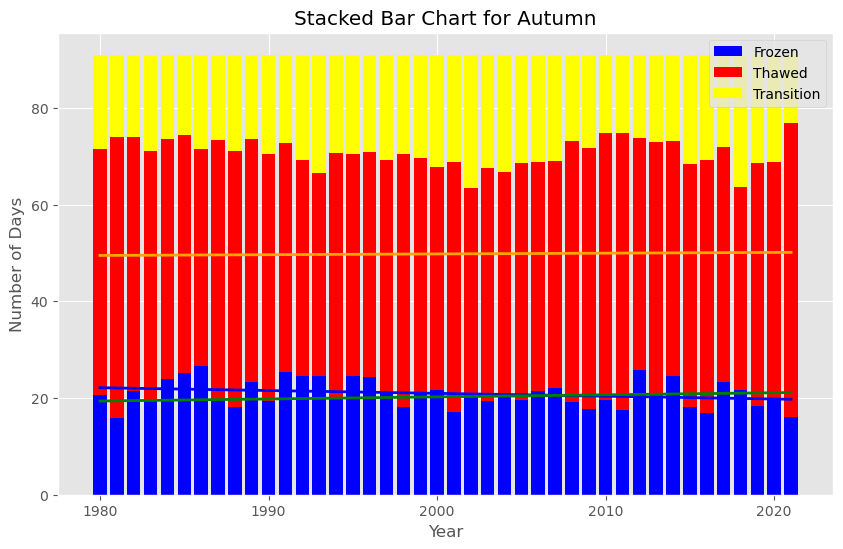

In [33]:
# Creating seasonal DataFrames for frozen, thawed, and transition days
def create_seasonal_df(df):
    seasonal_data = {'Year': df['Year']}  # Initialize with 'Year' column
    seasons = {
        'Winter': ['Dec', 'Jan', 'Feb'],
        'Spring': ['Mar', 'Apr', 'May'],
        'Summer': ['Jun', 'Jul', 'Aug'],
        'Autumn': ['Sep', 'Oct', 'Nov']
    }

    for season, months in seasons.items():
        if season == 'Winter':
            # Check for incomplete seasons and omit them
            years_to_include = df['Year'].between(1980, 2021)  # Excluding Winter 1979 and Winter 2021
            dec_clm = list(df.Dec)
            new_df = df.loc[years_to_include, :]
            new_df['Dec'] = dec_clm[:-1]
# print(years_to_include.head())
            seasonal_data[season] = new_df[months].sum(axis=1)
        else:
            seasonal_data[season] = df[months].sum(axis=1)

    return pd.DataFrame(seasonal_data)

# Creating seasonal DataFrames for frozen, thawed, and transition days
df_seasonal_frozen = create_seasonal_df(df_frozen)
df_seasonal_thawed = create_seasonal_df(df_thawed)
df_seasonal_transition = create_seasonal_df(df_transition)

# Plotting each seasonal DataFrame
seasons = df_seasonal_frozen.columns[1:]

for season in seasons:
    plt.figure(figsize=(10, 6))
    
    # Stacking the data
    bottom = np.zeros(len(df_seasonal_frozen))
    plt.bar(df_seasonal_frozen['Year'], df_seasonal_frozen[season], color='blue', label='Frozen', bottom=bottom)
    bottom += df_seasonal_frozen[season]
    plt.bar(df_seasonal_thawed['Year'], df_seasonal_thawed[season], color='red', label='Thawed', bottom=bottom)
    bottom += df_seasonal_thawed[season]
    plt.bar(df_seasonal_transition['Year'], df_seasonal_transition[season], color='yellow', label='Transition', bottom=bottom)


    # Calculate linear regression for each set of data
    if season == 'Winter':
        df_seasonal_frozen.dropna(inplace=True)
        df_seasonal_thawed.dropna(inplace=True)
        df_seasonal_transition.dropna(inplace=True)

        frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
        thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
        transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)
    else:
        frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
        thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
        transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)

    # Plot linear regression lines
    plt.plot(df_seasonal_frozen.Year, frozen_slope * np.array(df_seasonal_frozen.Year) + frozen_intercept, color='blue', linestyle='-', linewidth=2)
    plt.plot(df_seasonal_thawed.Year, thawed_slope * np.array(df_seasonal_thawed.Year) + thawed_intercept, color='orange', linestyle='-', linewidth=2)
    plt.plot(df_seasonal_transition.Year, transitional_slope * np.array(df_seasonal_transition.Year) + transitional_intercept, color='green', linestyle='-', linewidth=2)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Days')
    plt.title(f'Stacked Bar Chart for {season}')
    plt.legend()
    plt.show()


## EPA

Frozen
Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec
Thawed
Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec
Transition
Jan
Feb
Mar
Apr


/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/3470348468.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 8))  # Adjusts the size of the figure


May
Jun
Jul
Aug
Sep
Oct
Nov
Dec


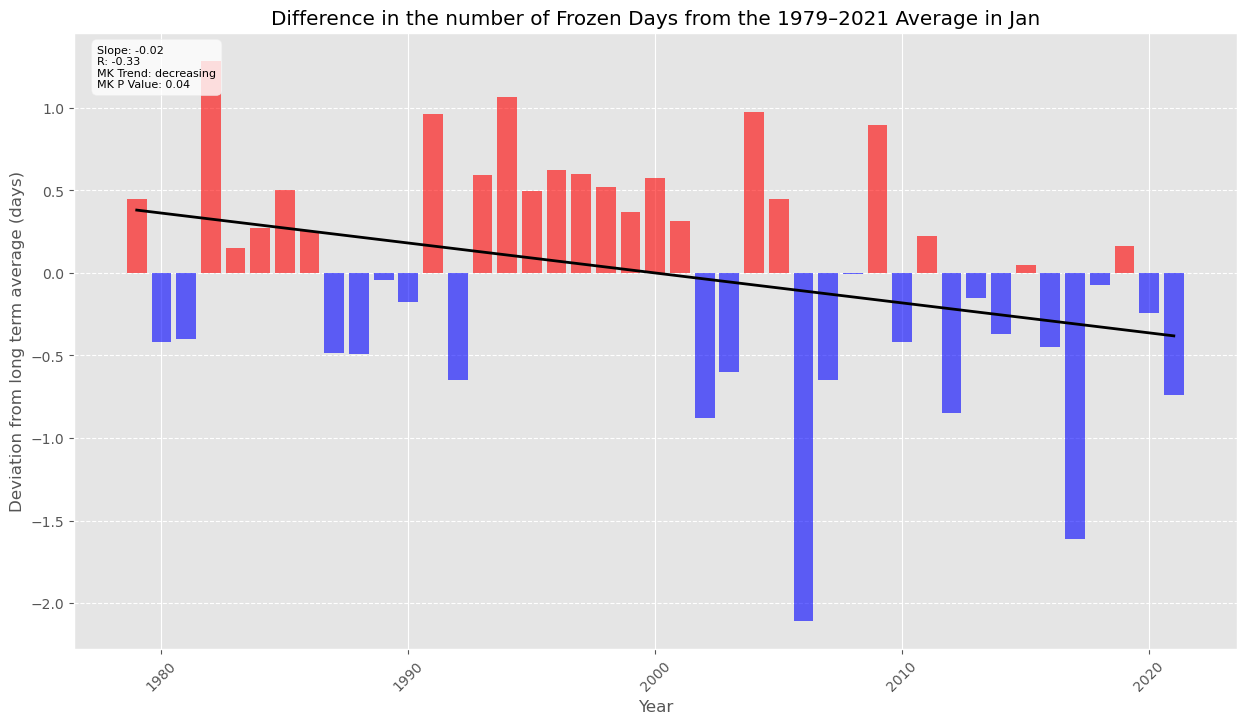

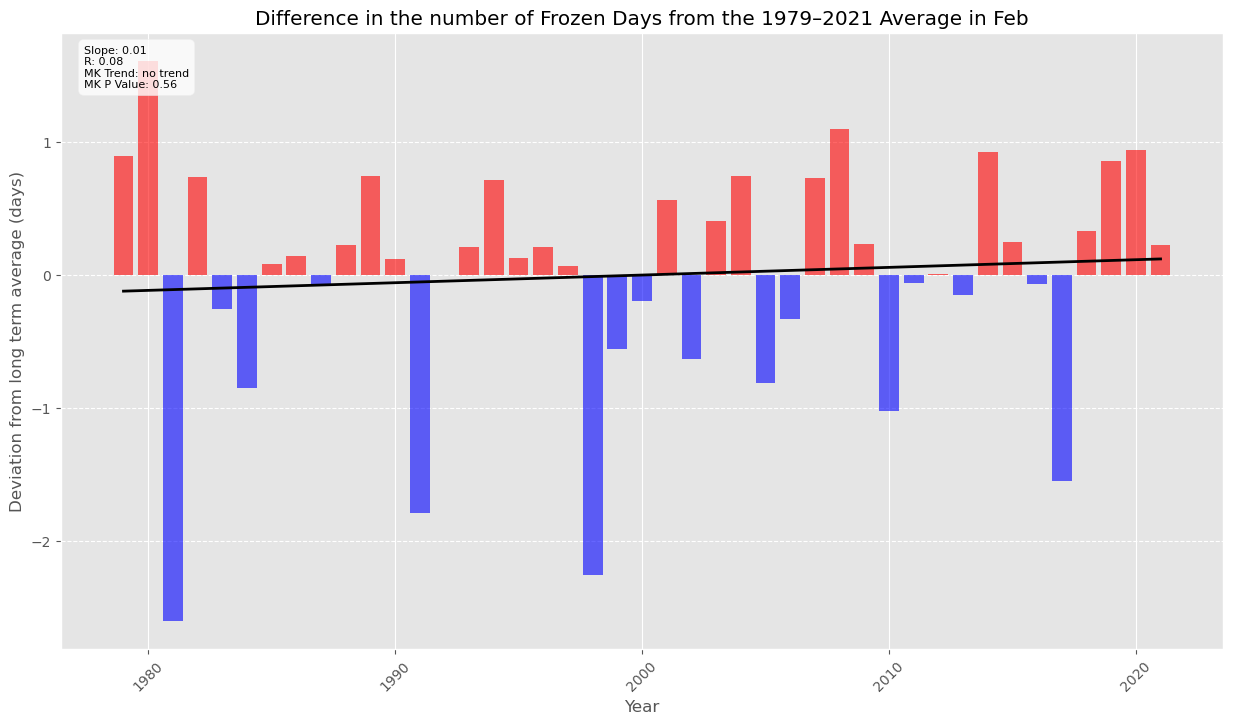

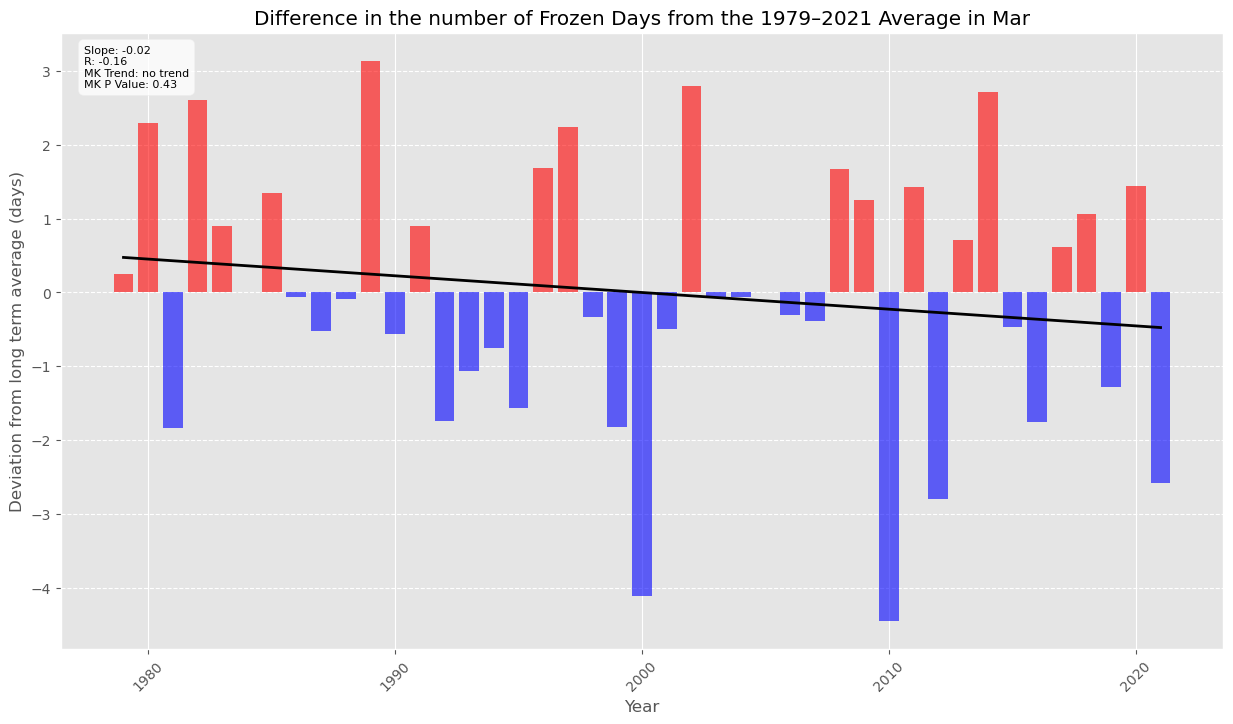

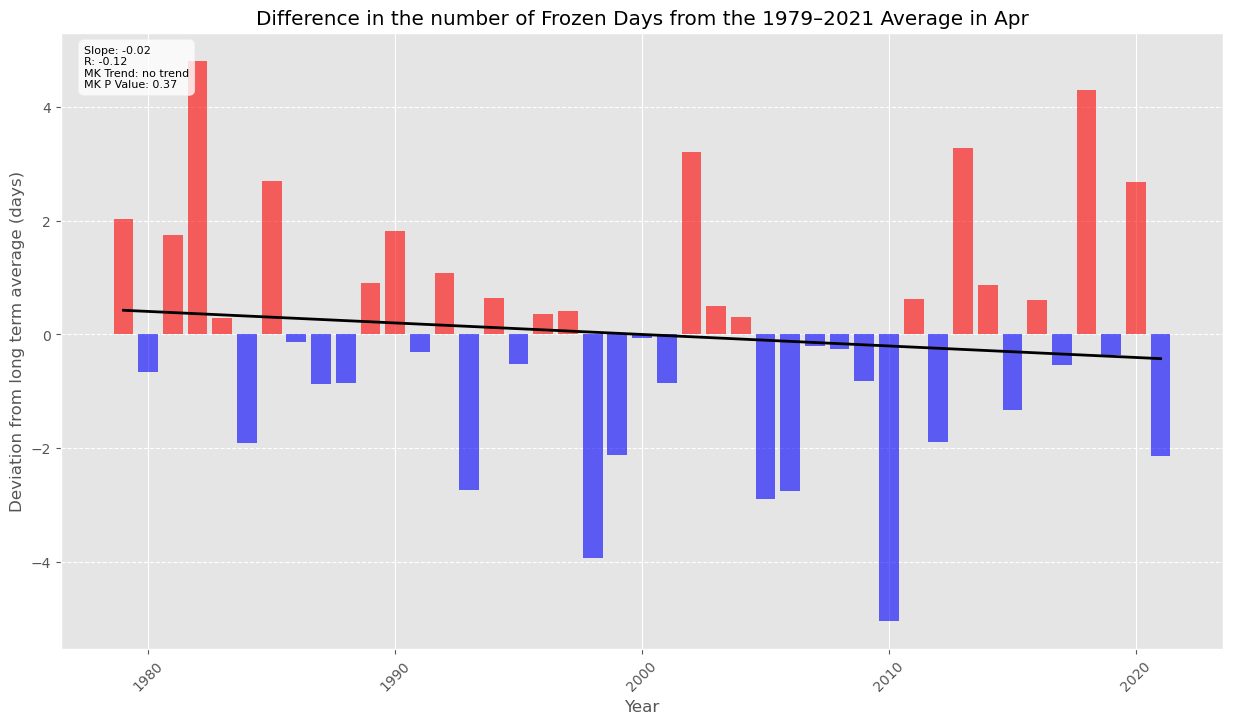

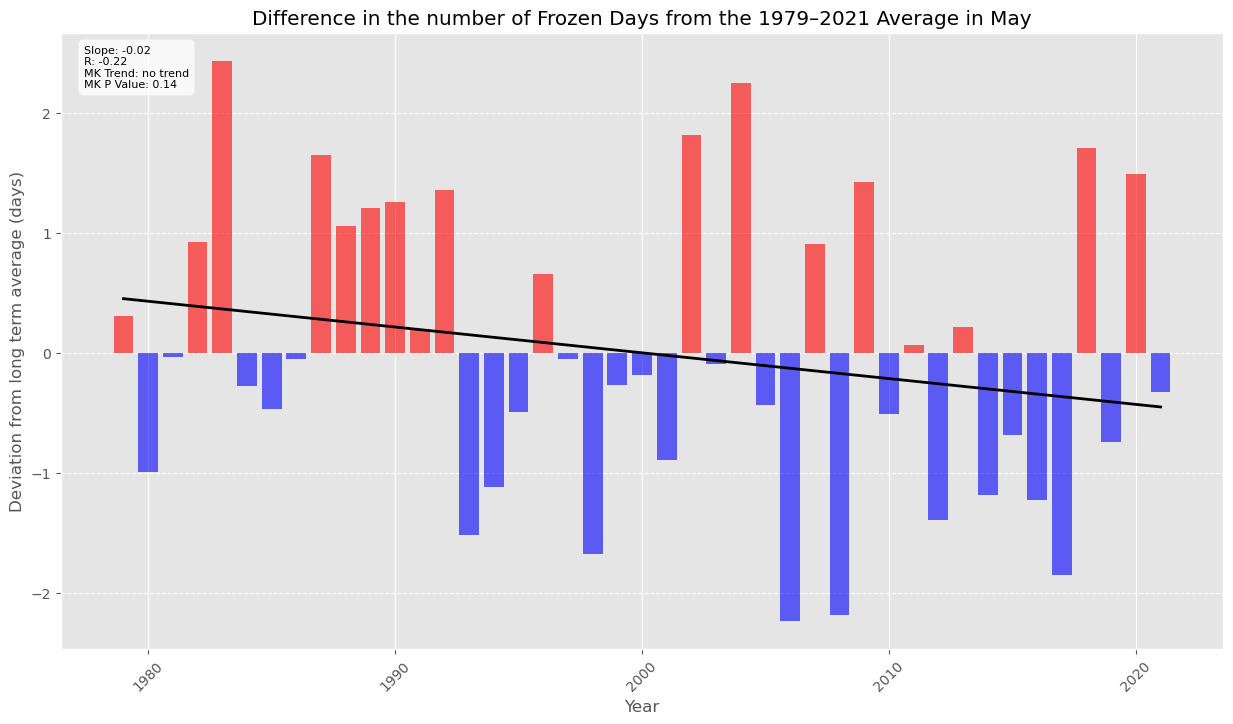

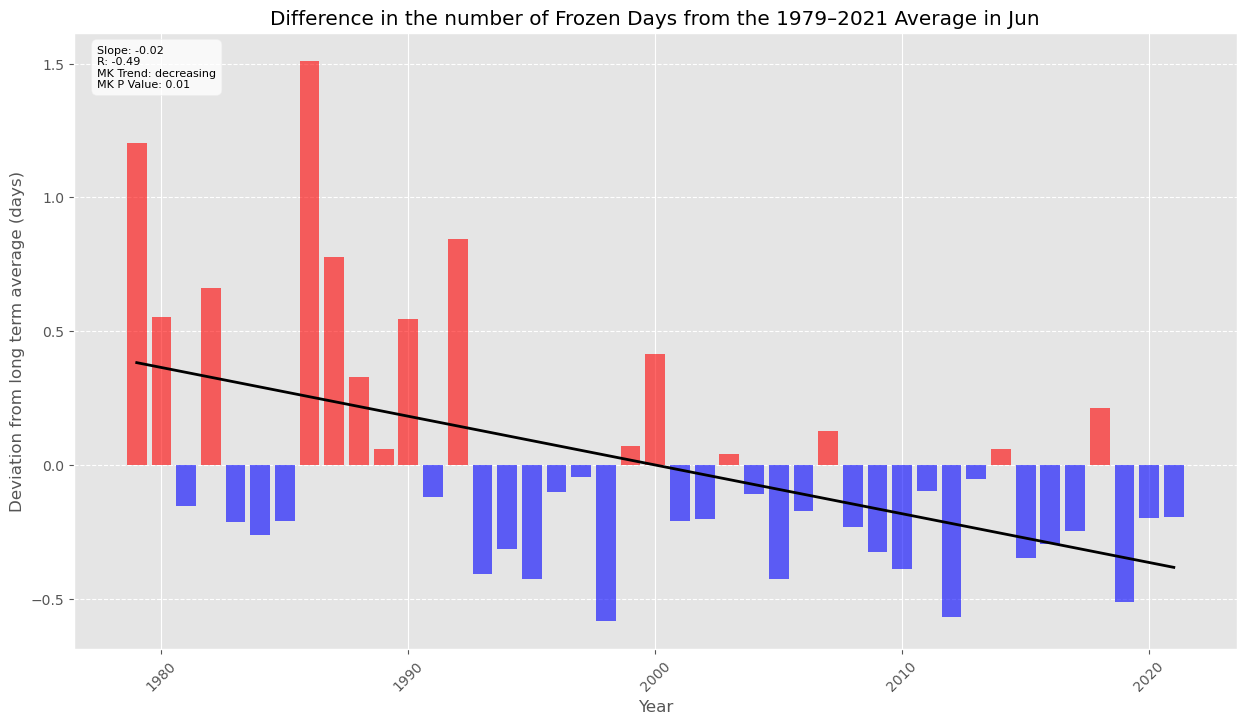

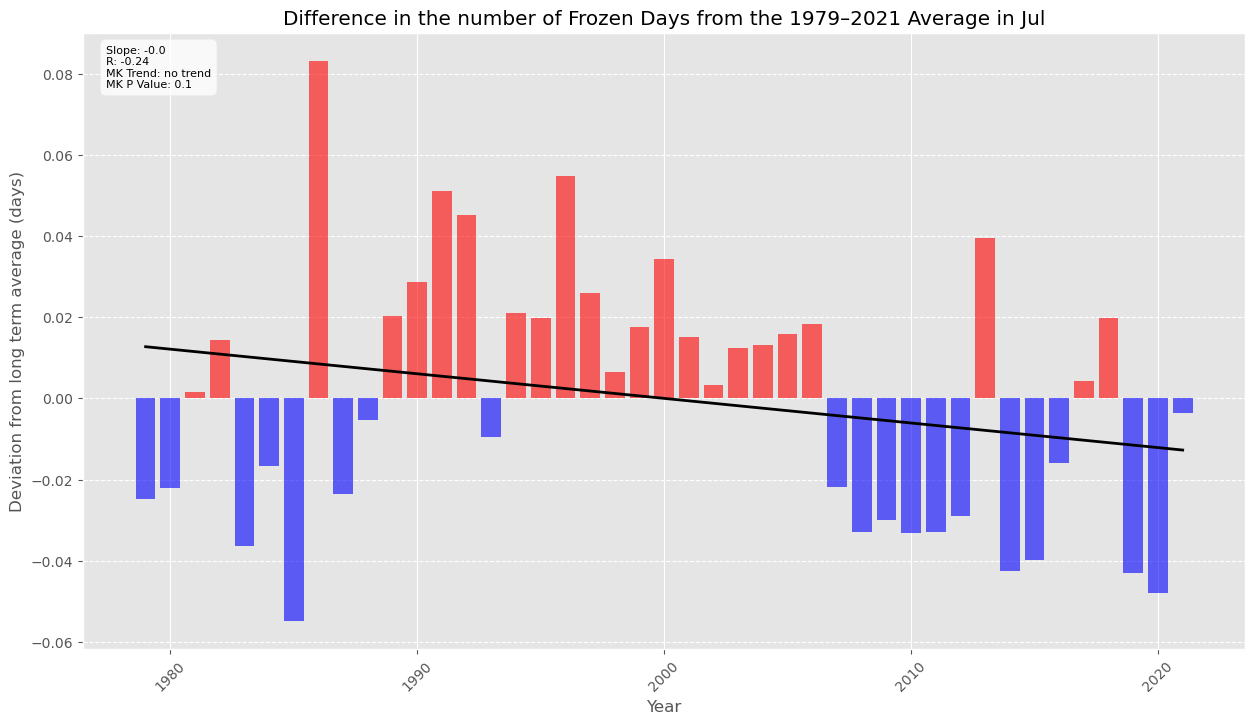

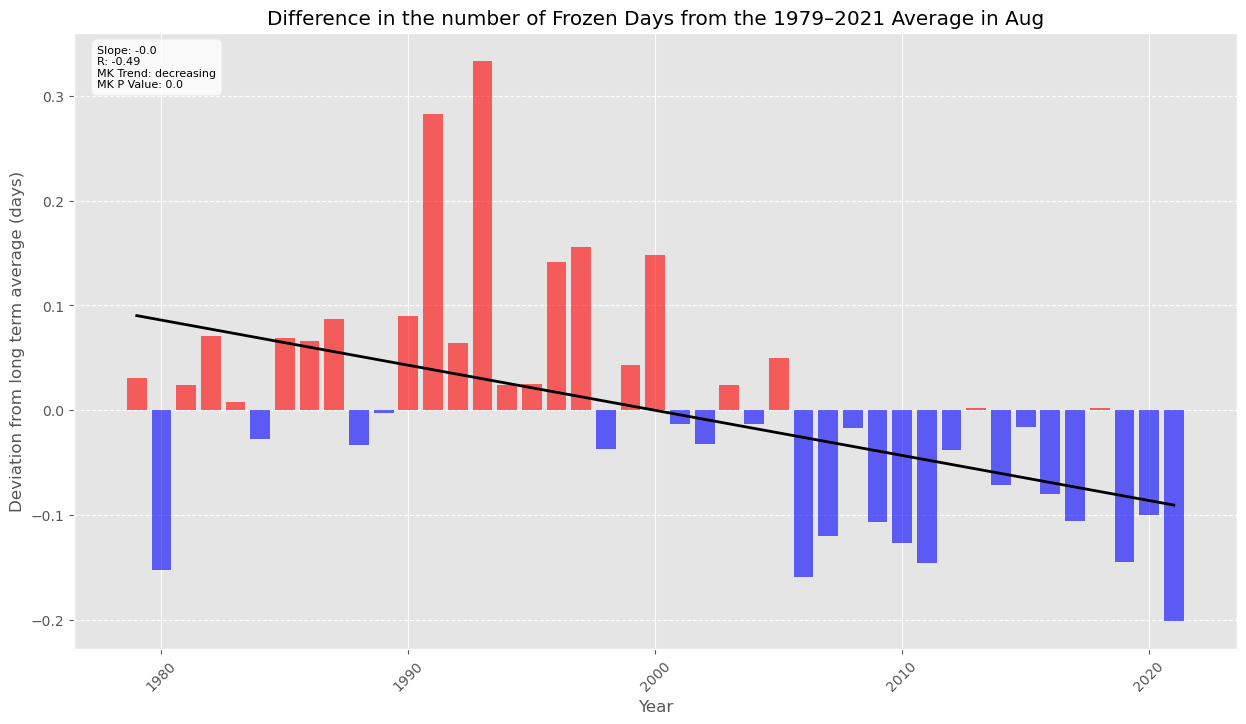

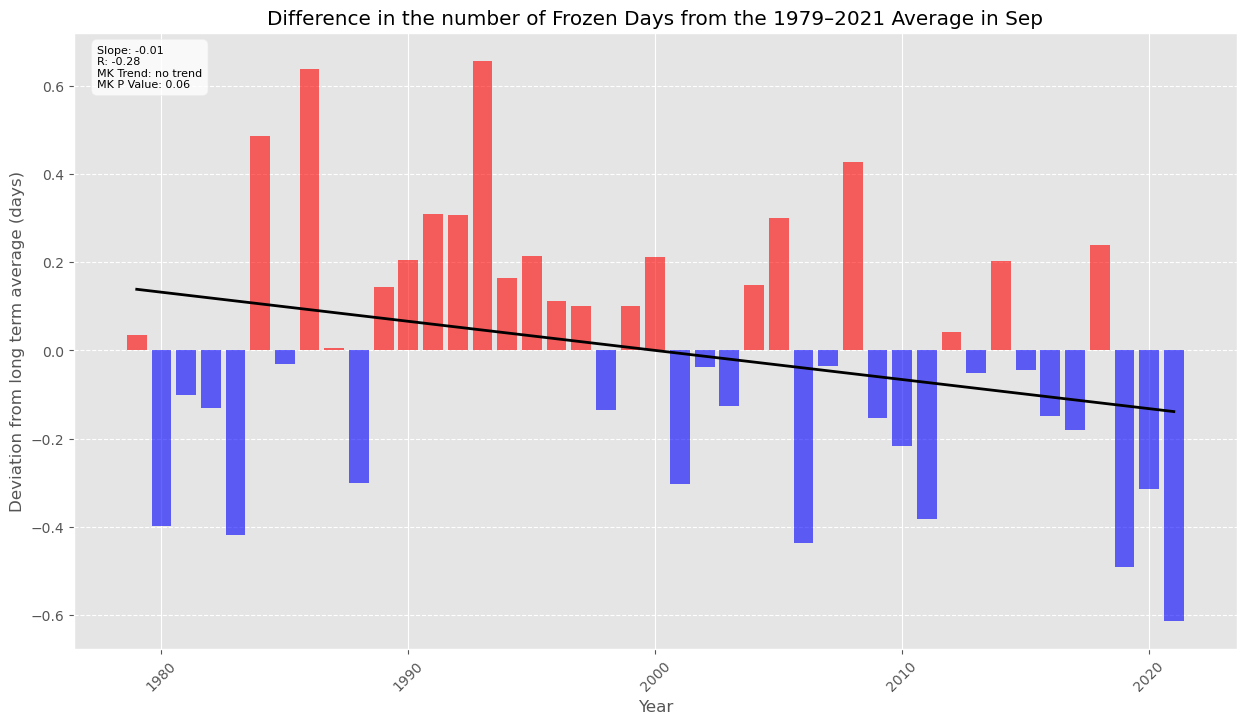

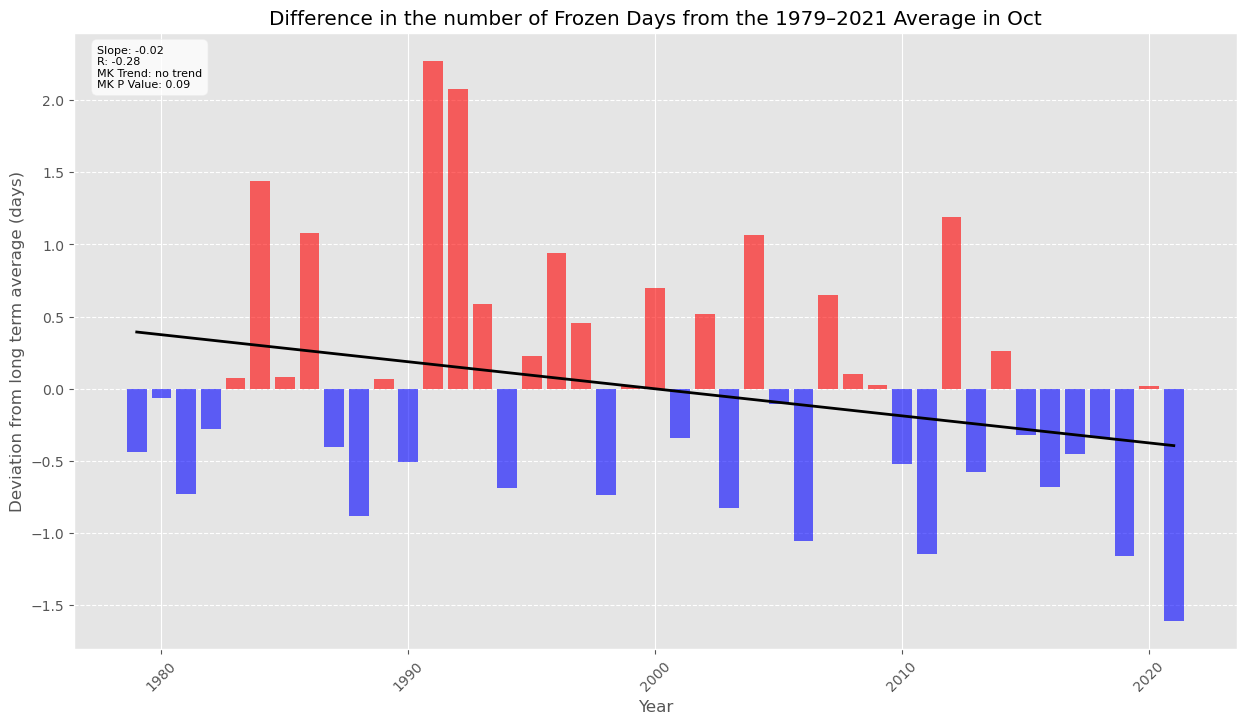

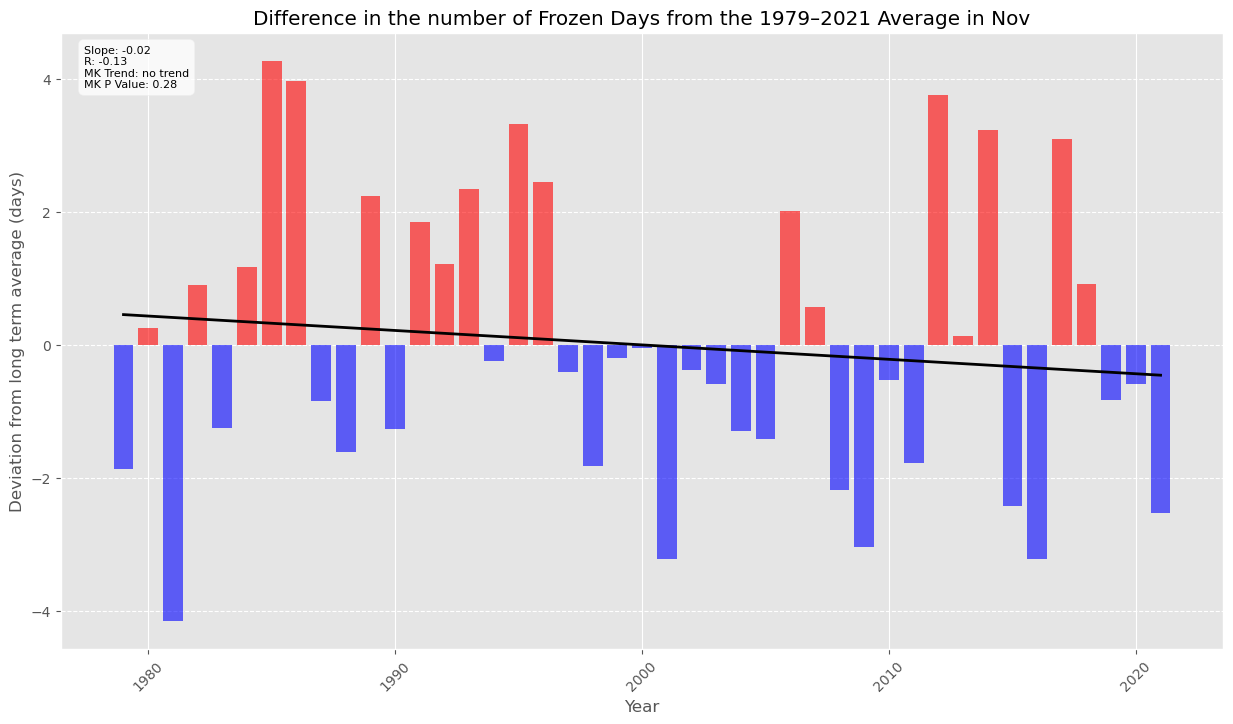

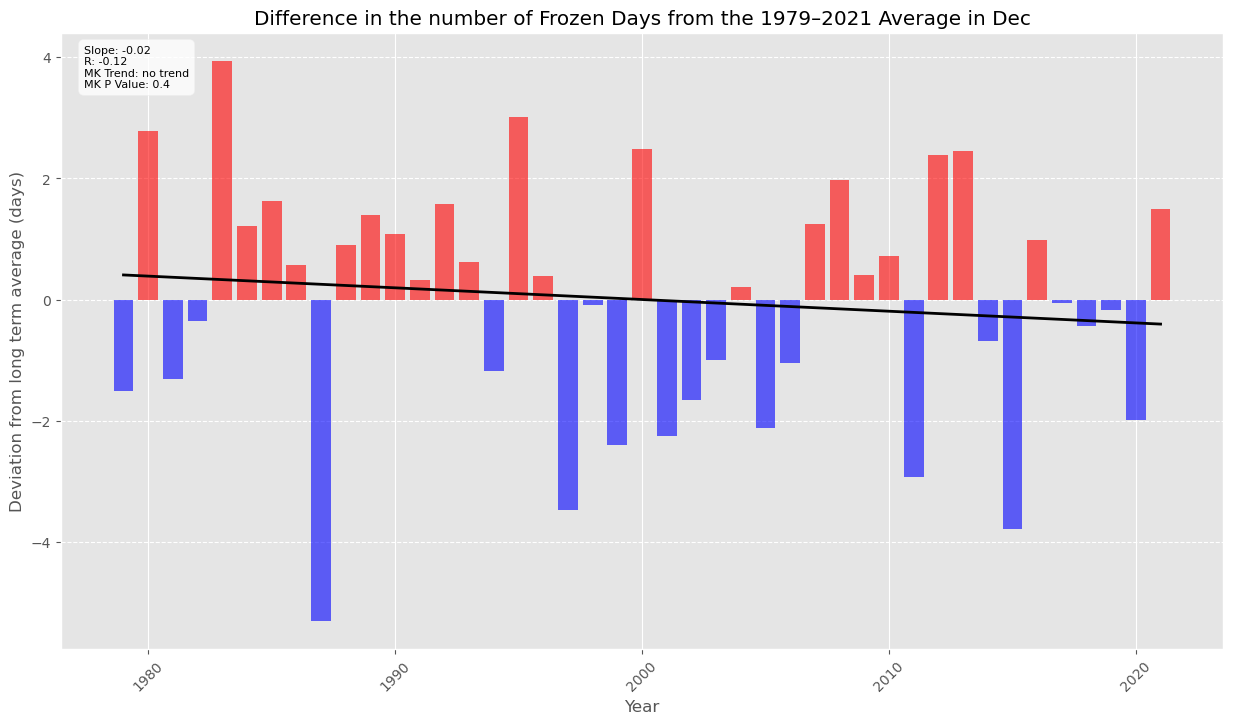

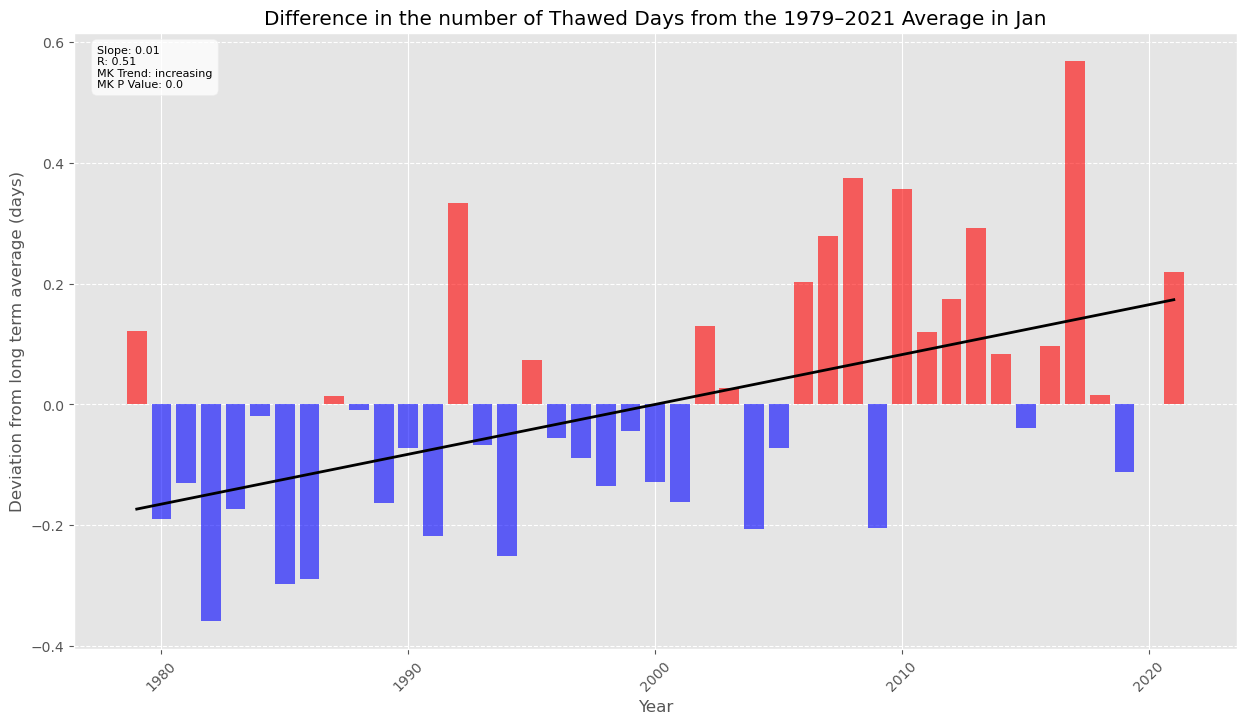

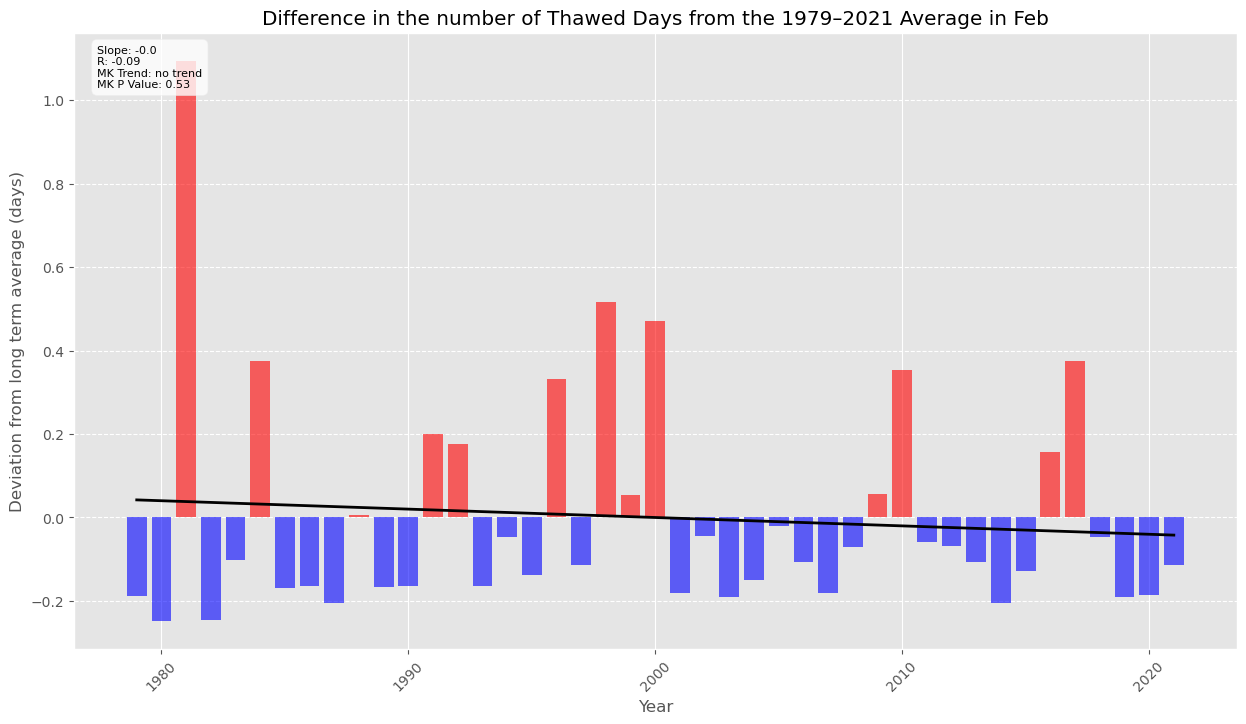

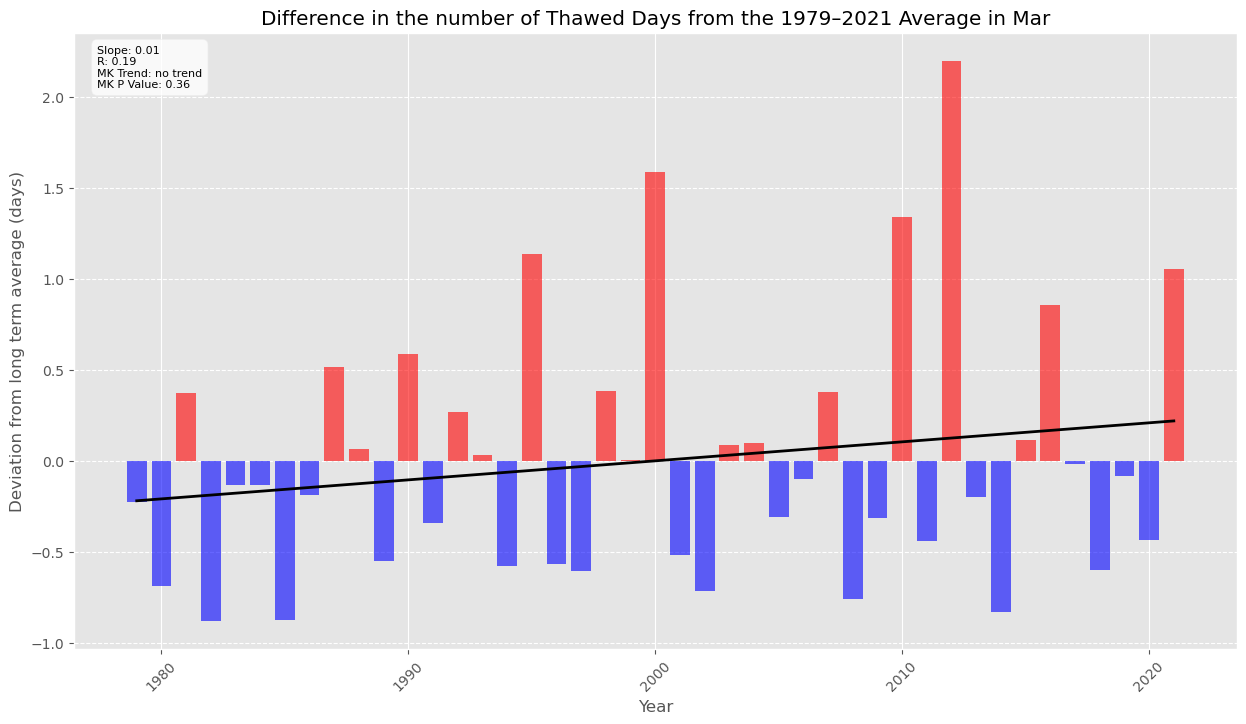

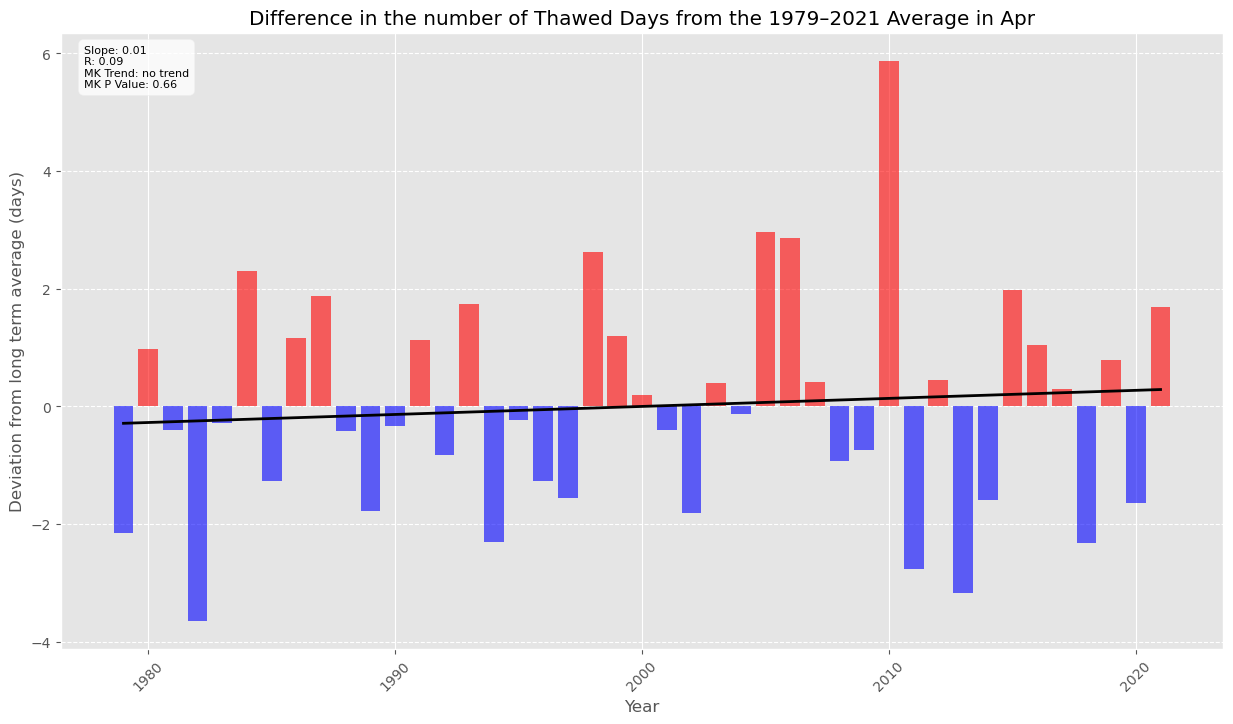

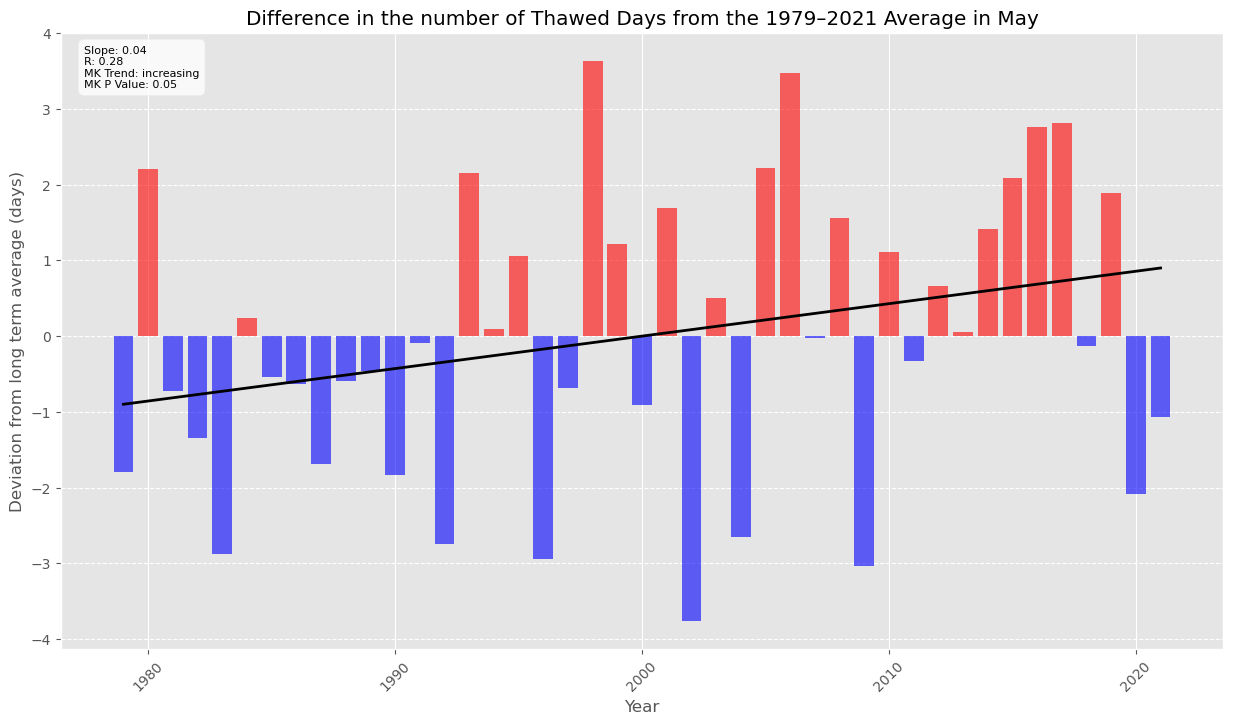

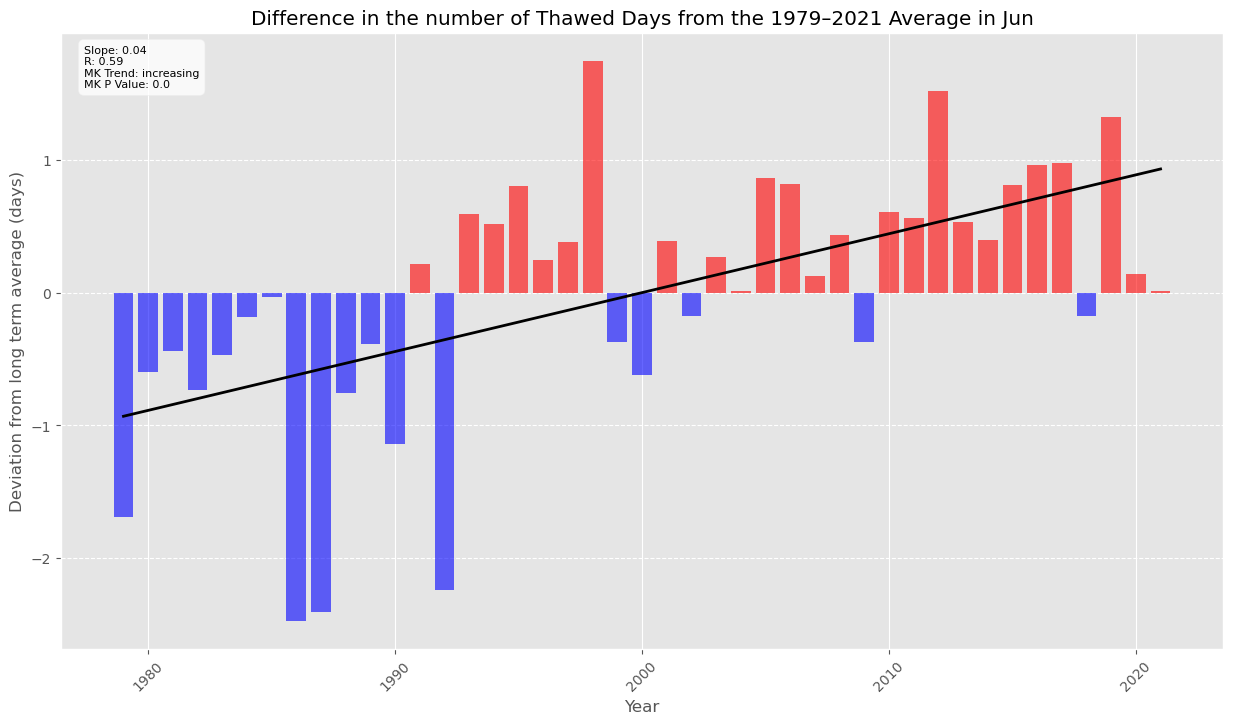

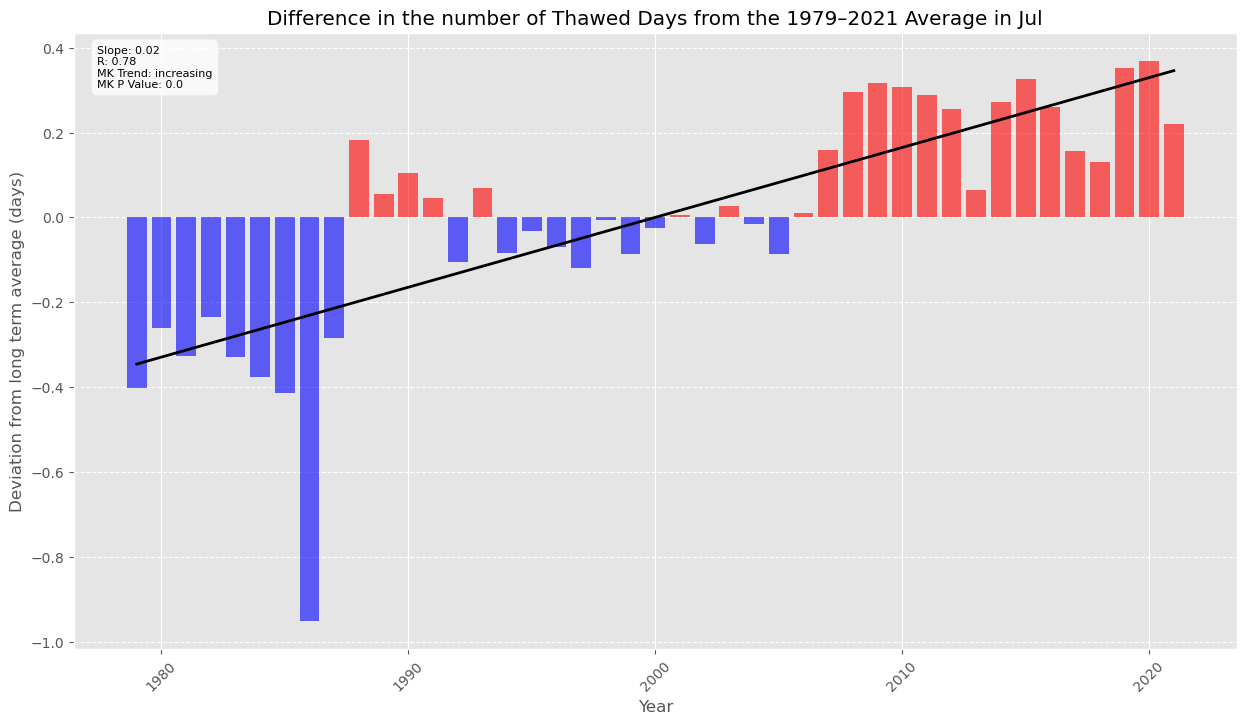

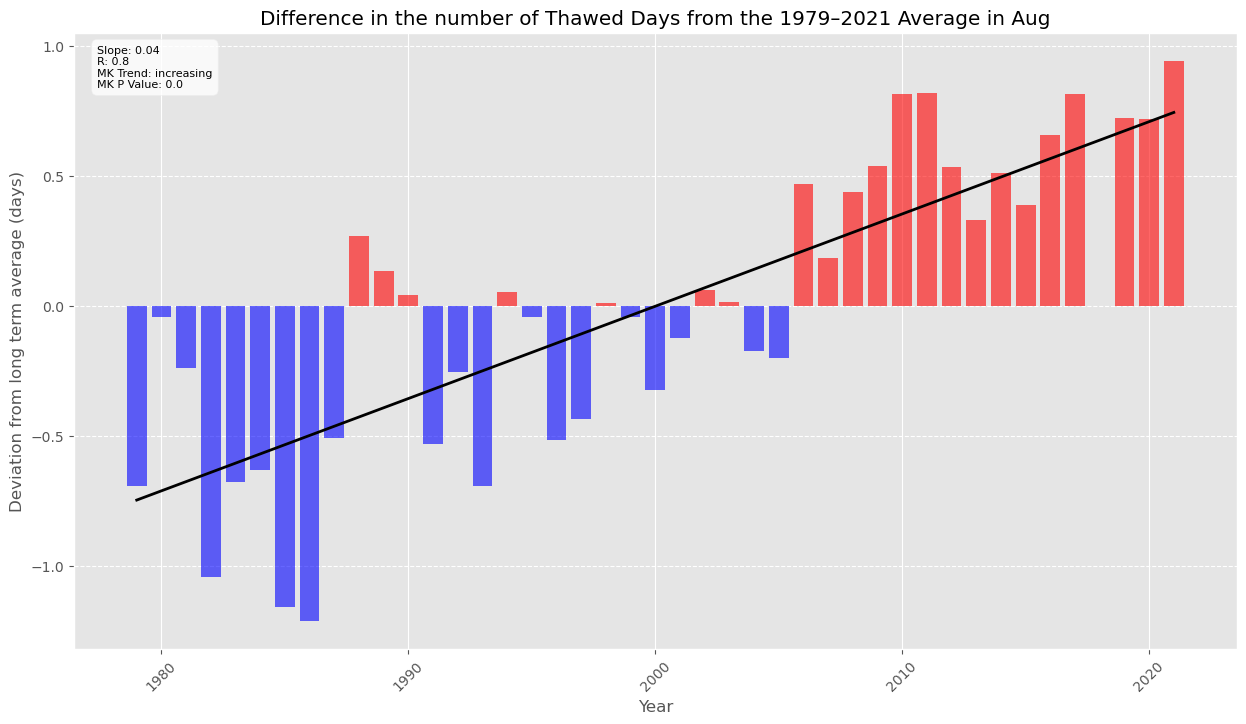

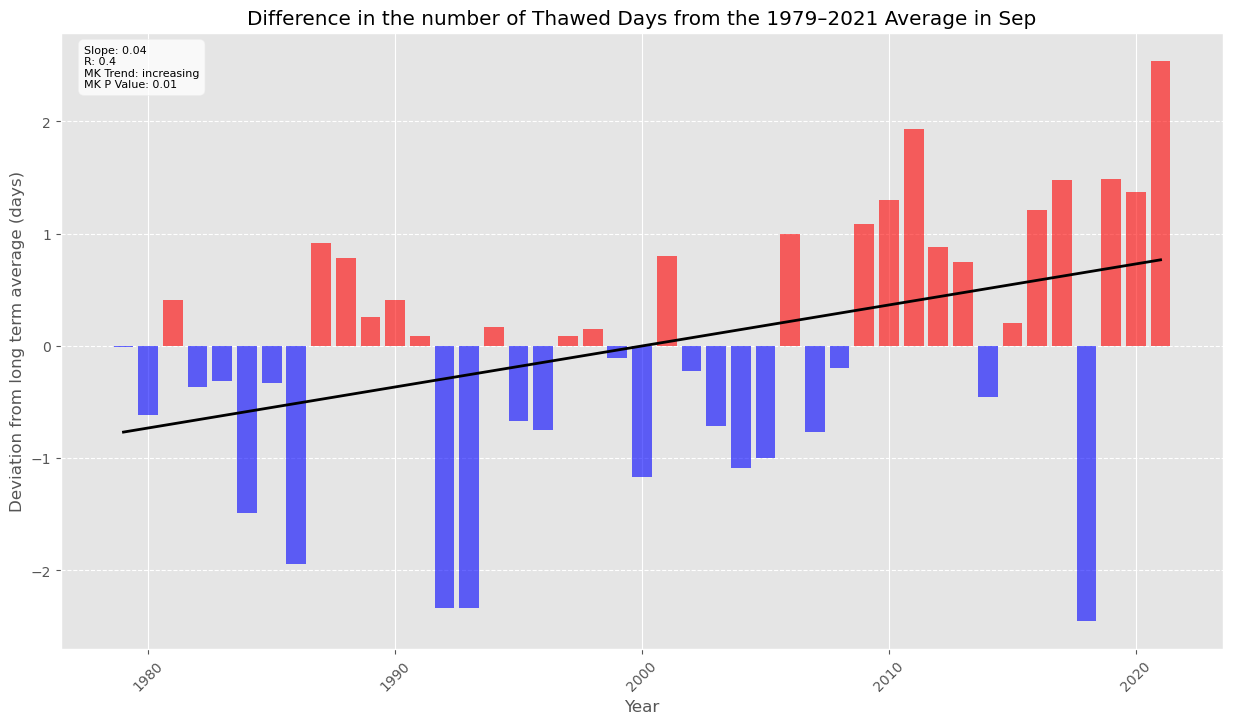

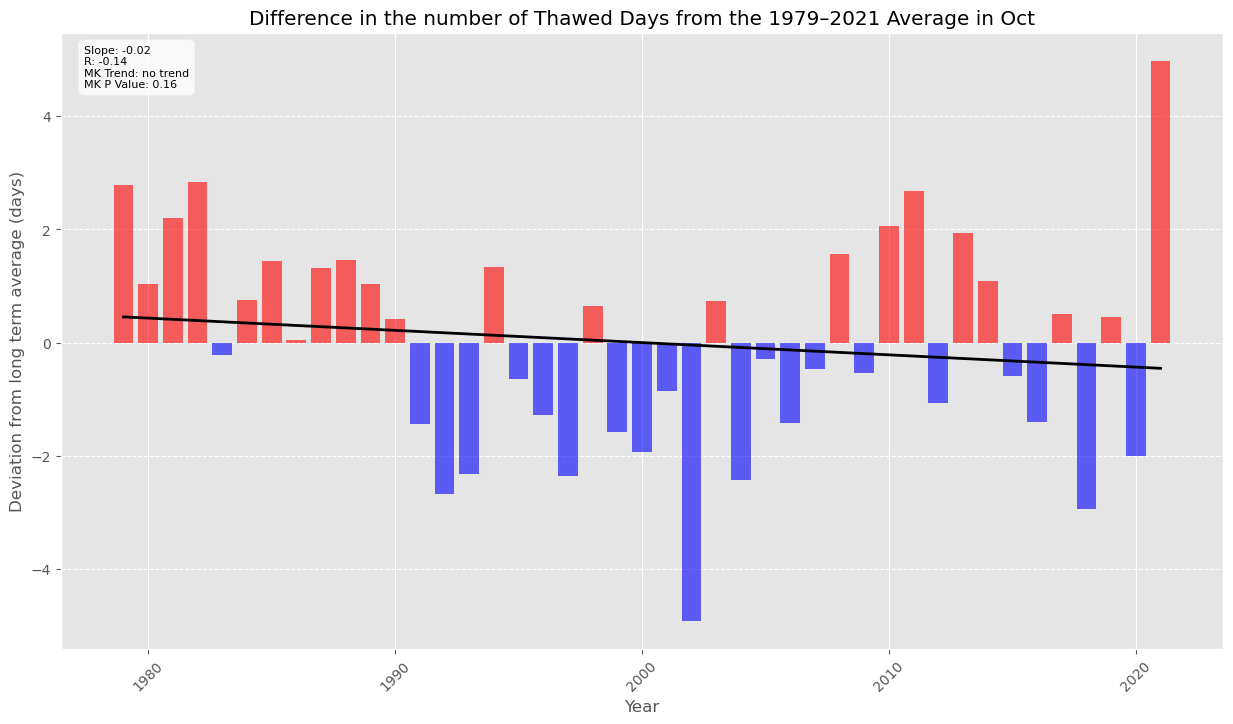

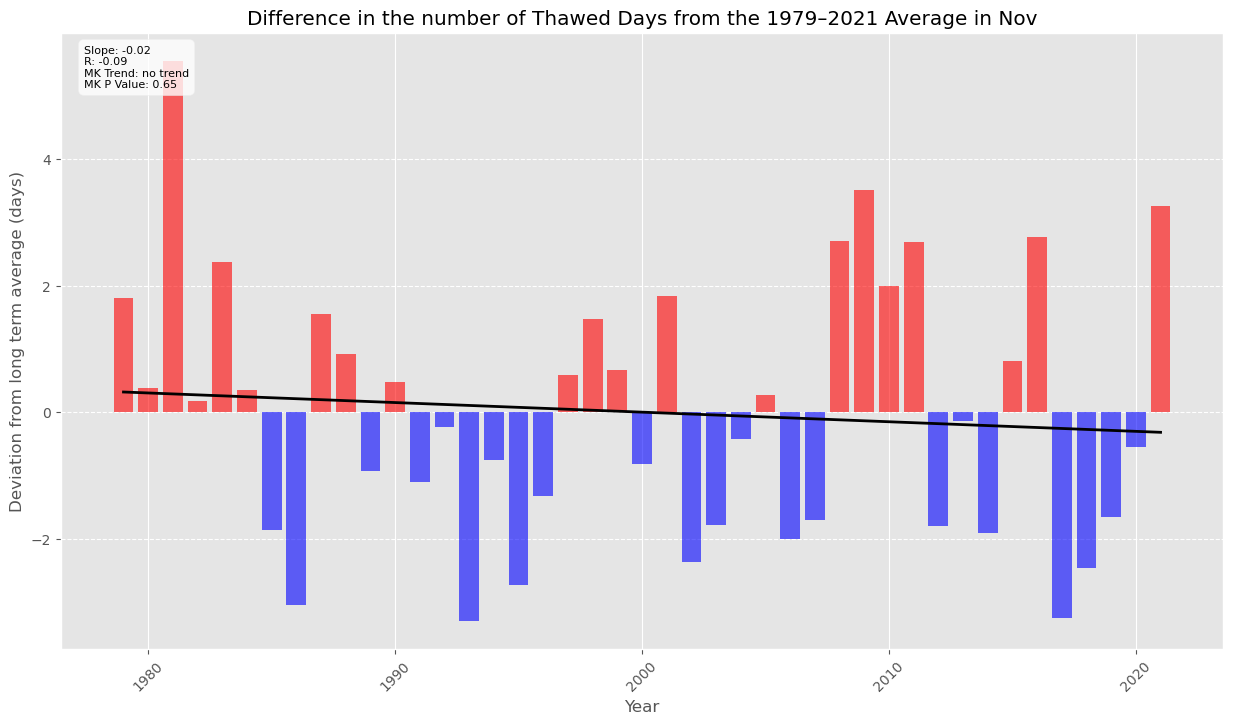

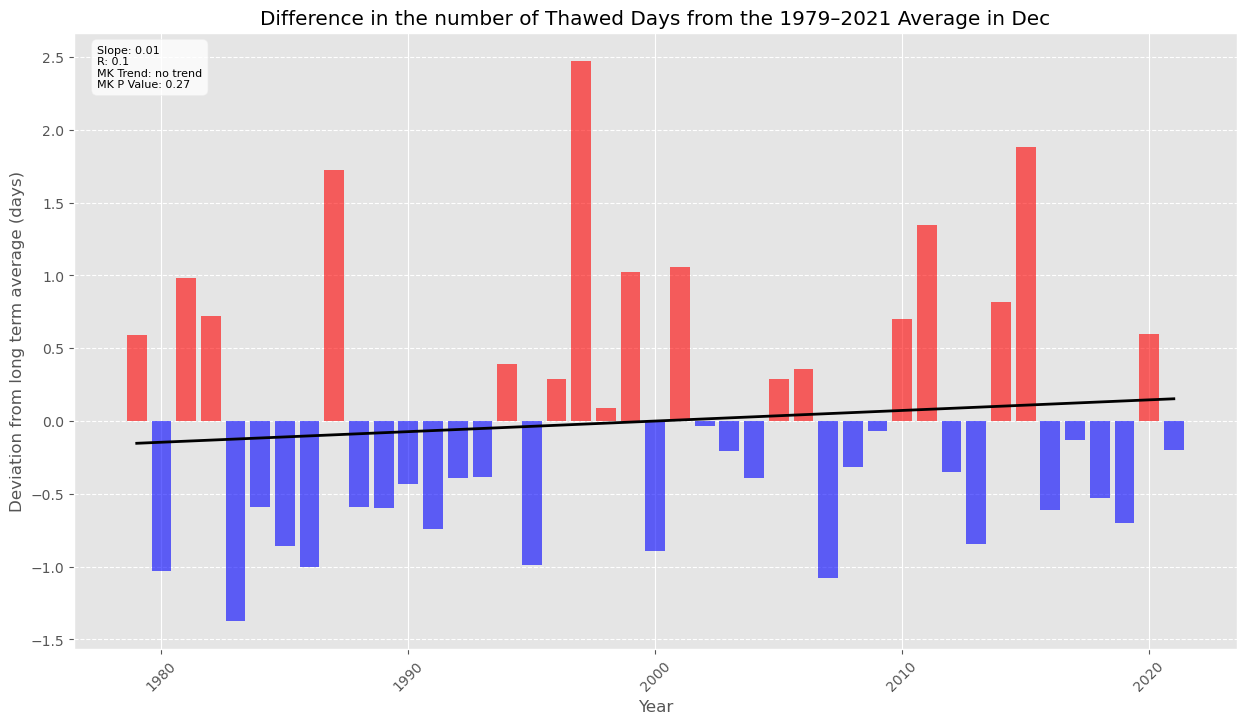

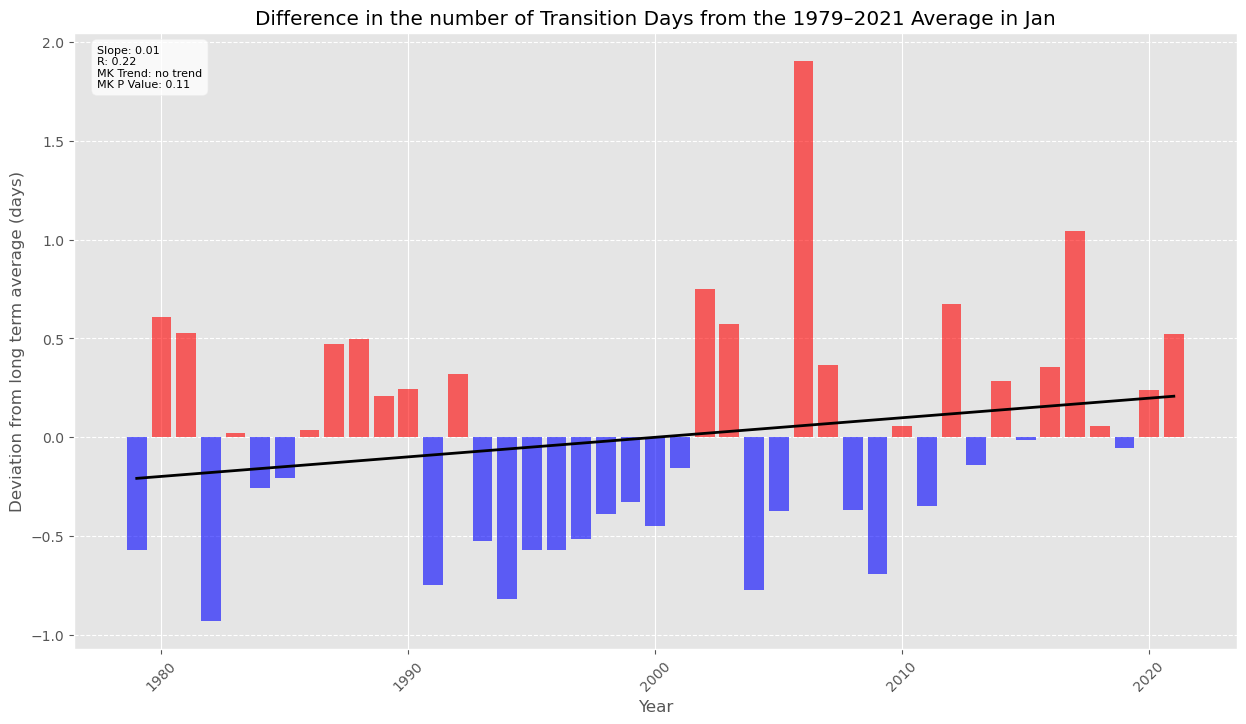

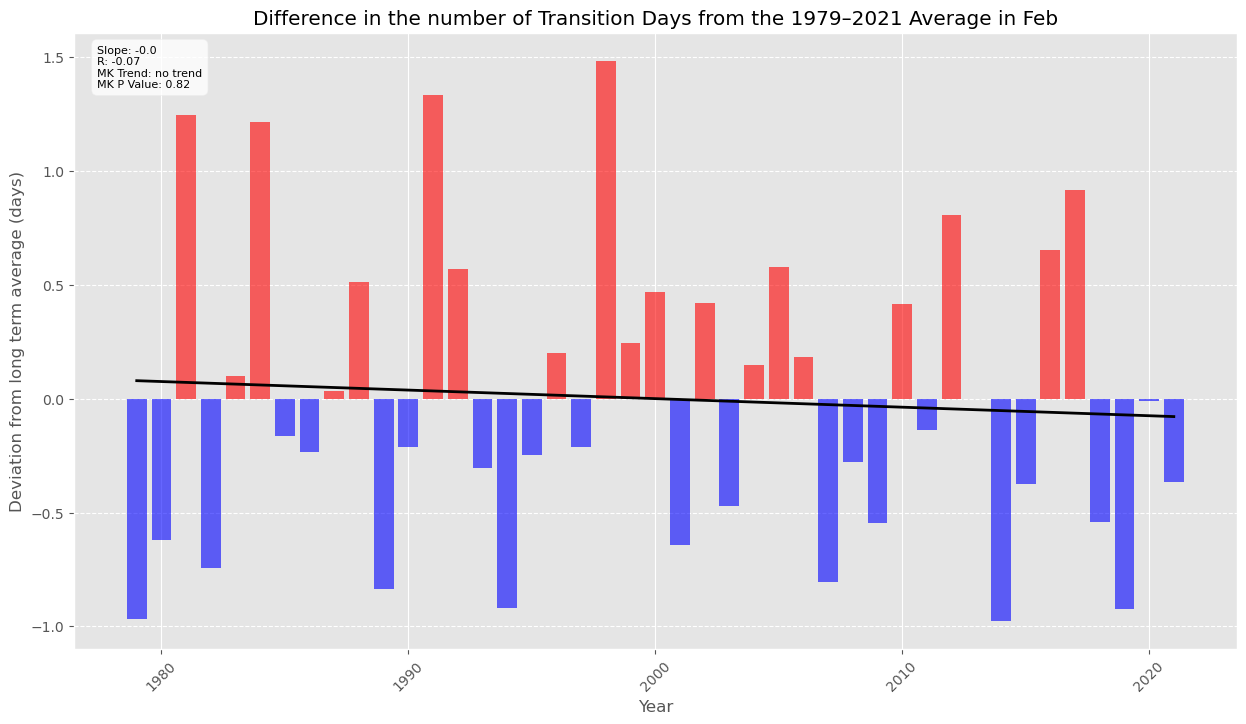

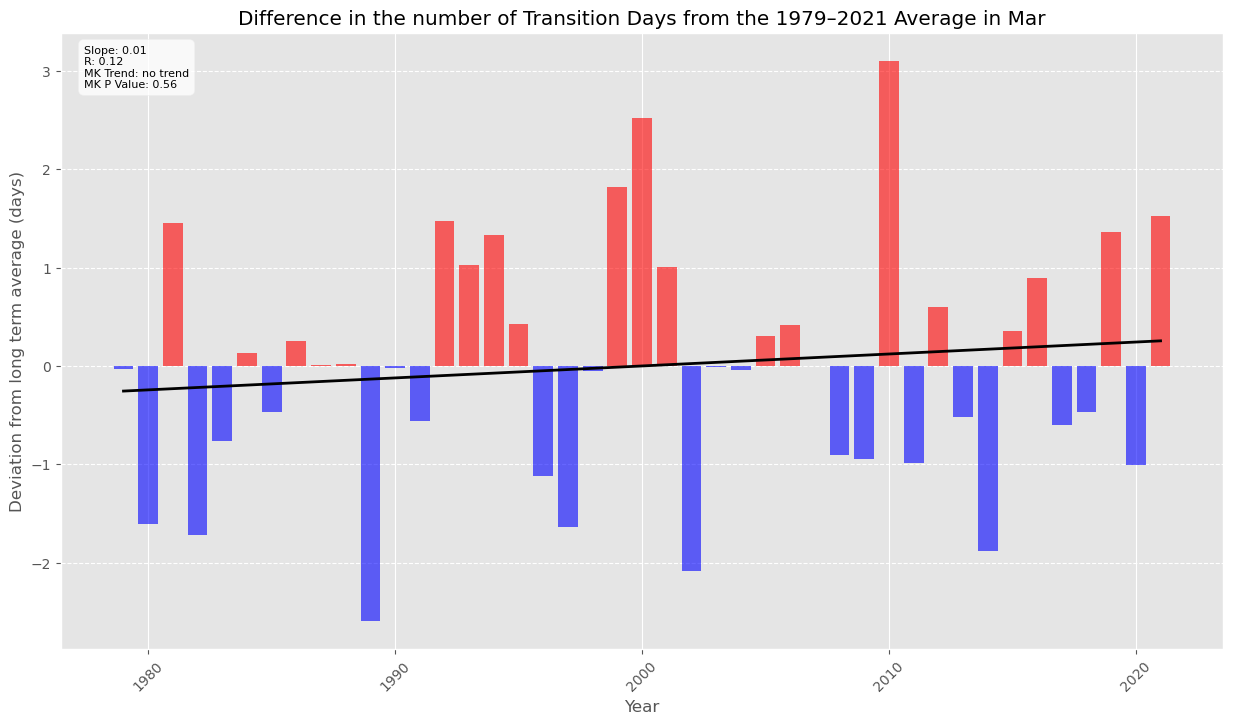

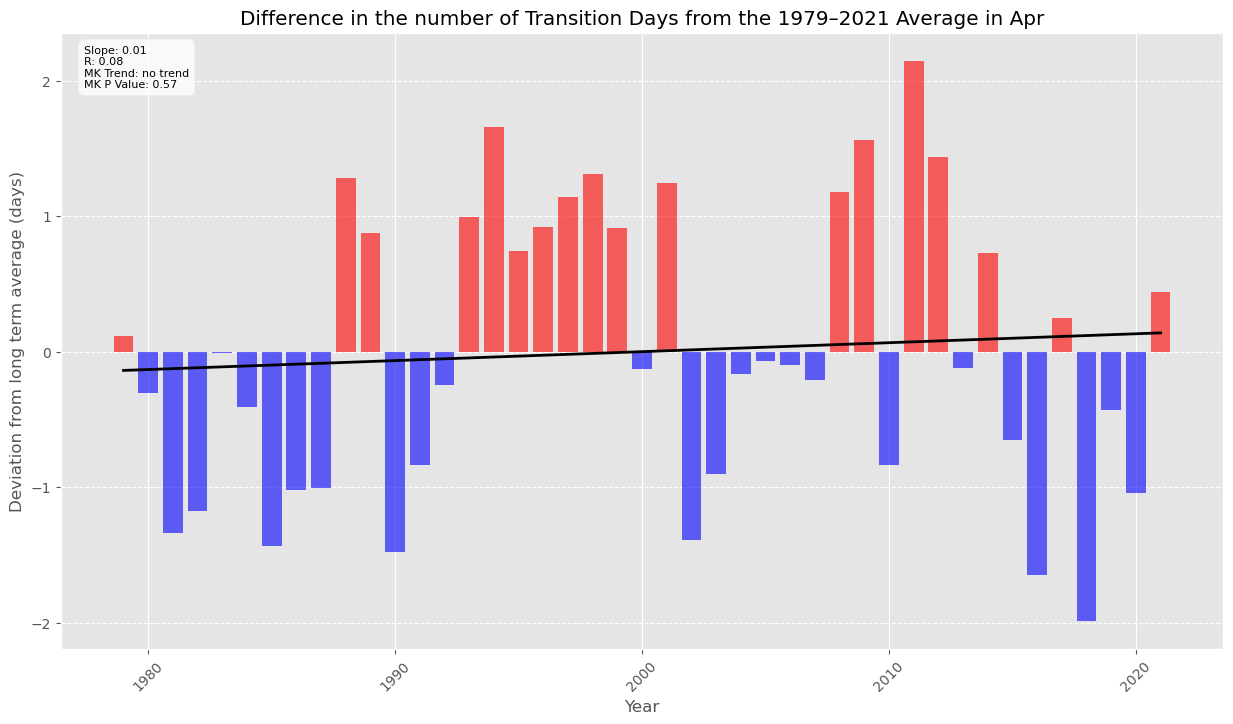

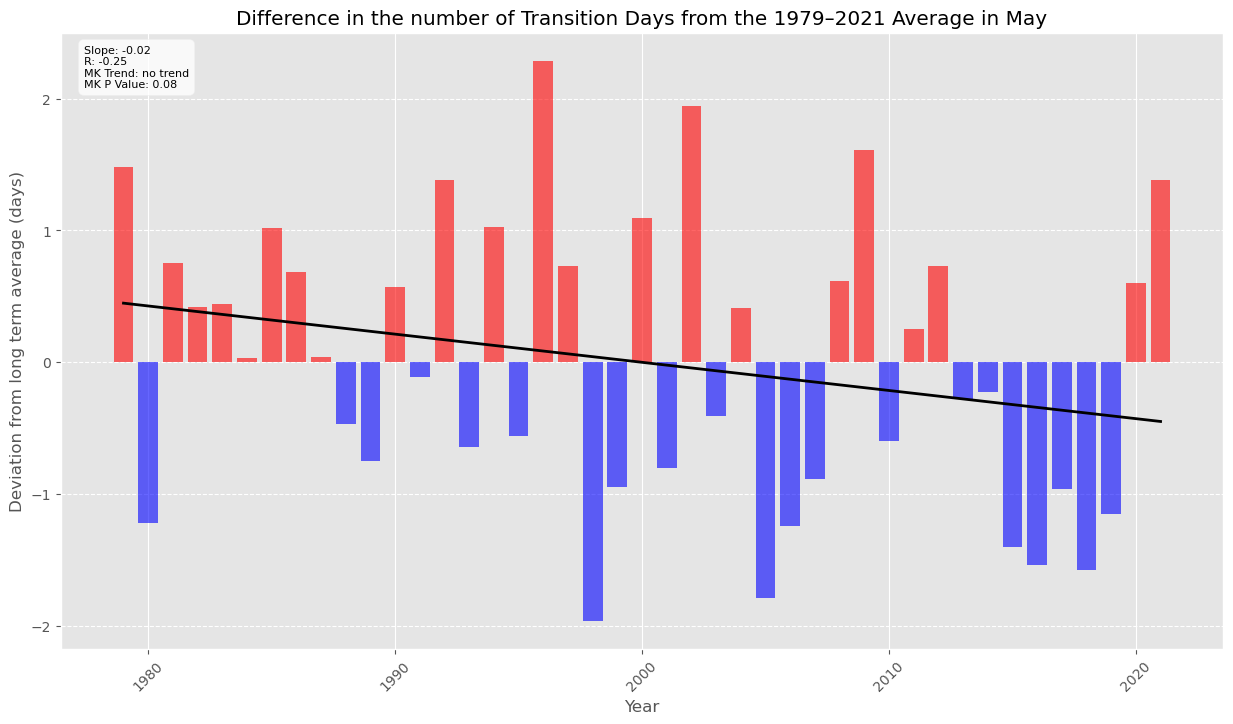

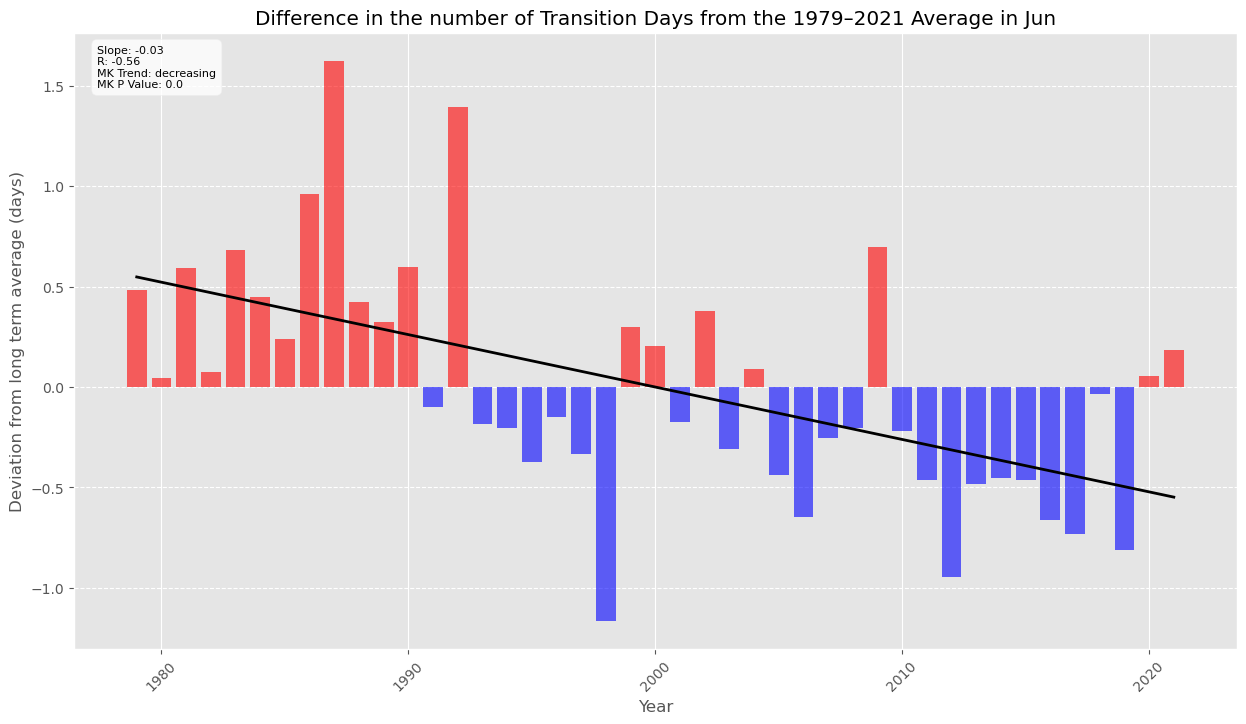

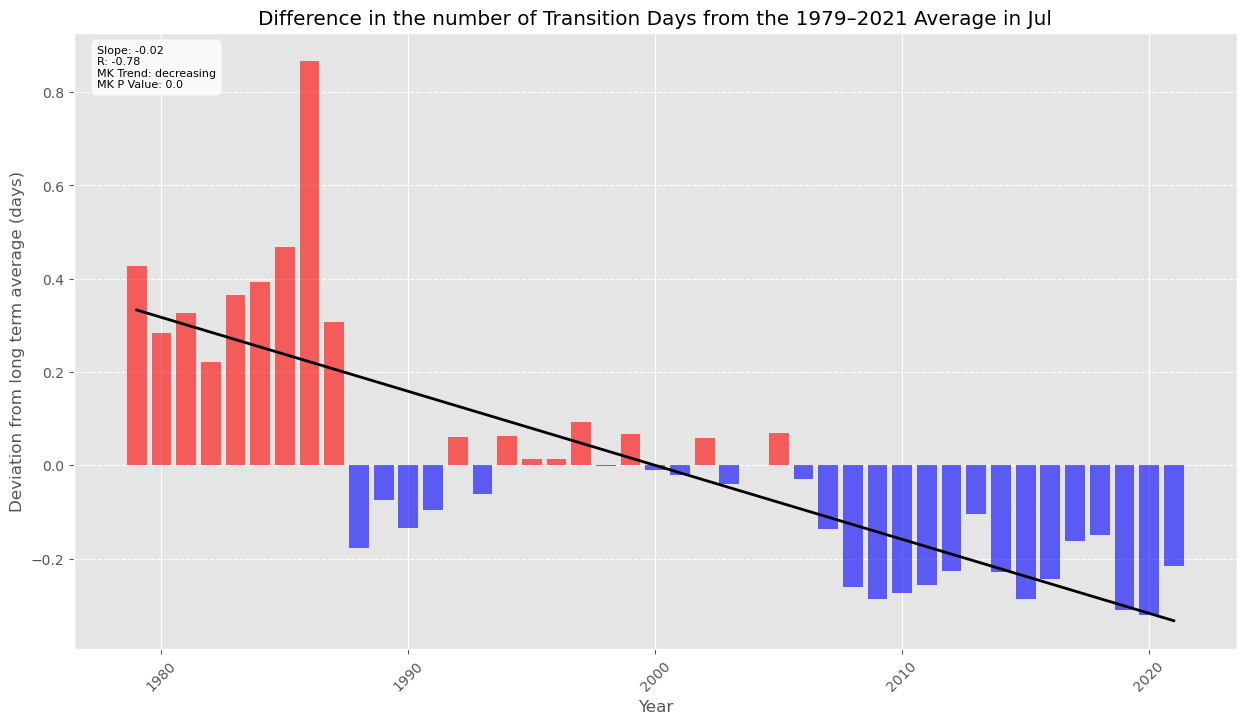

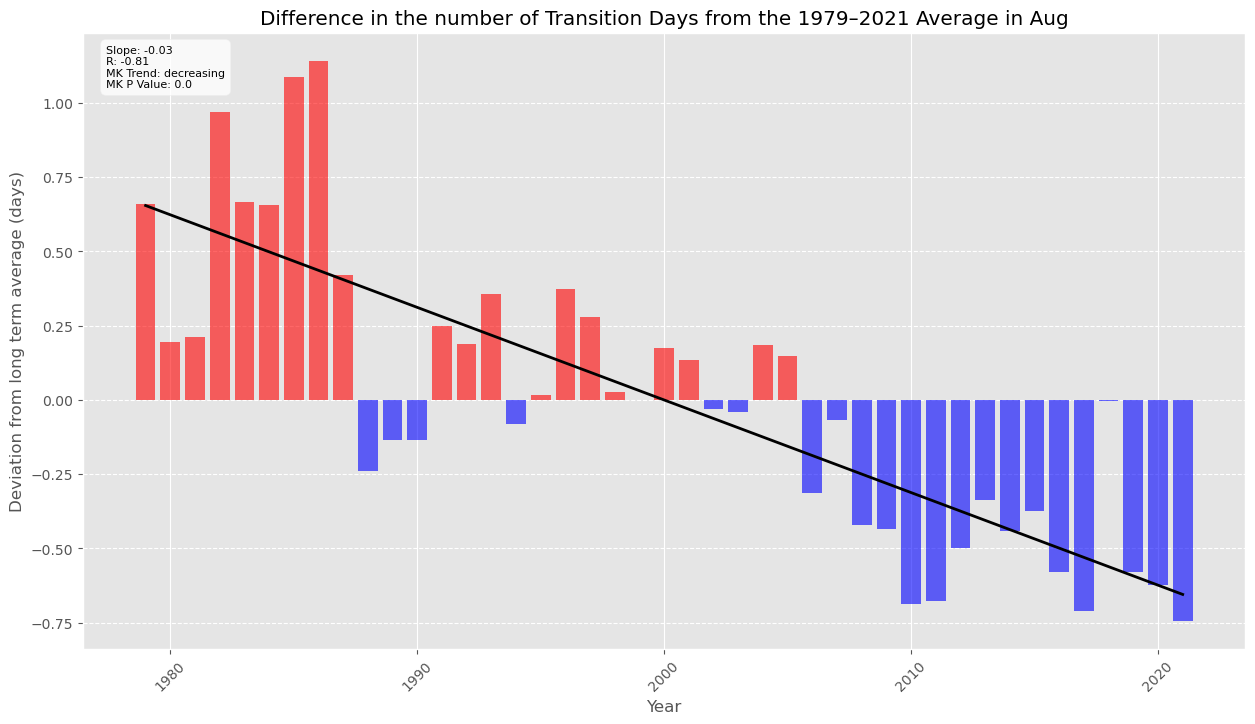

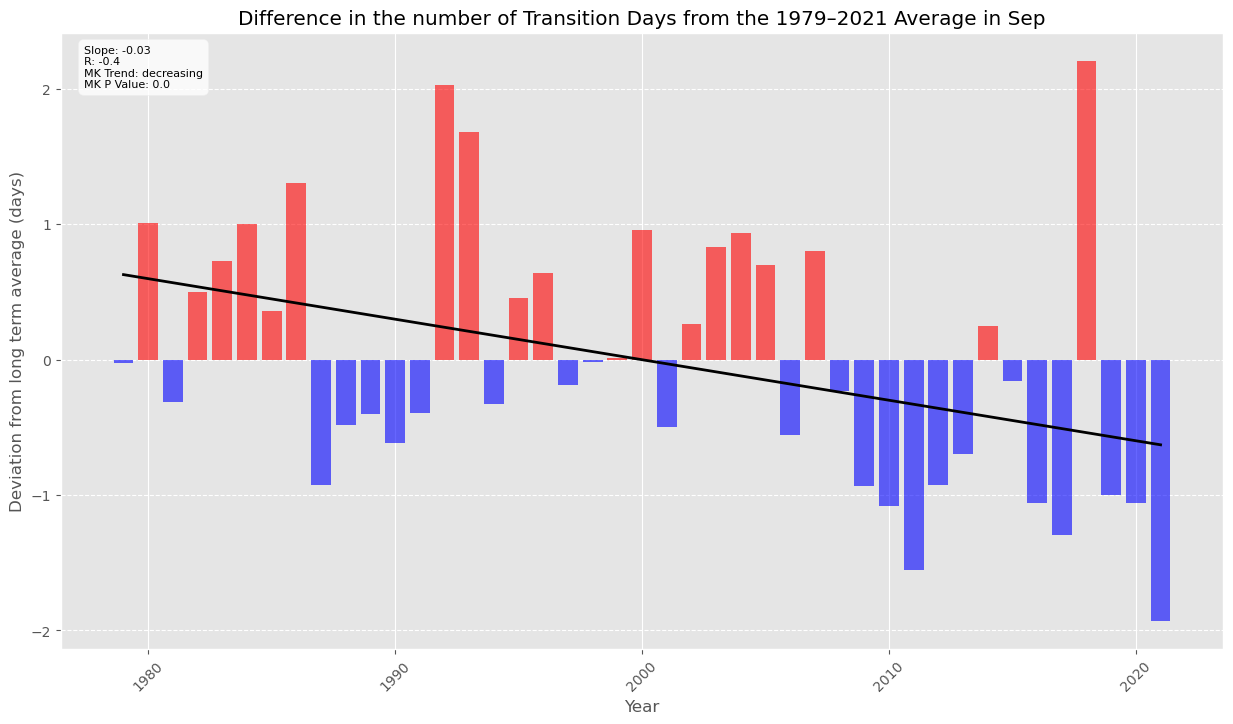

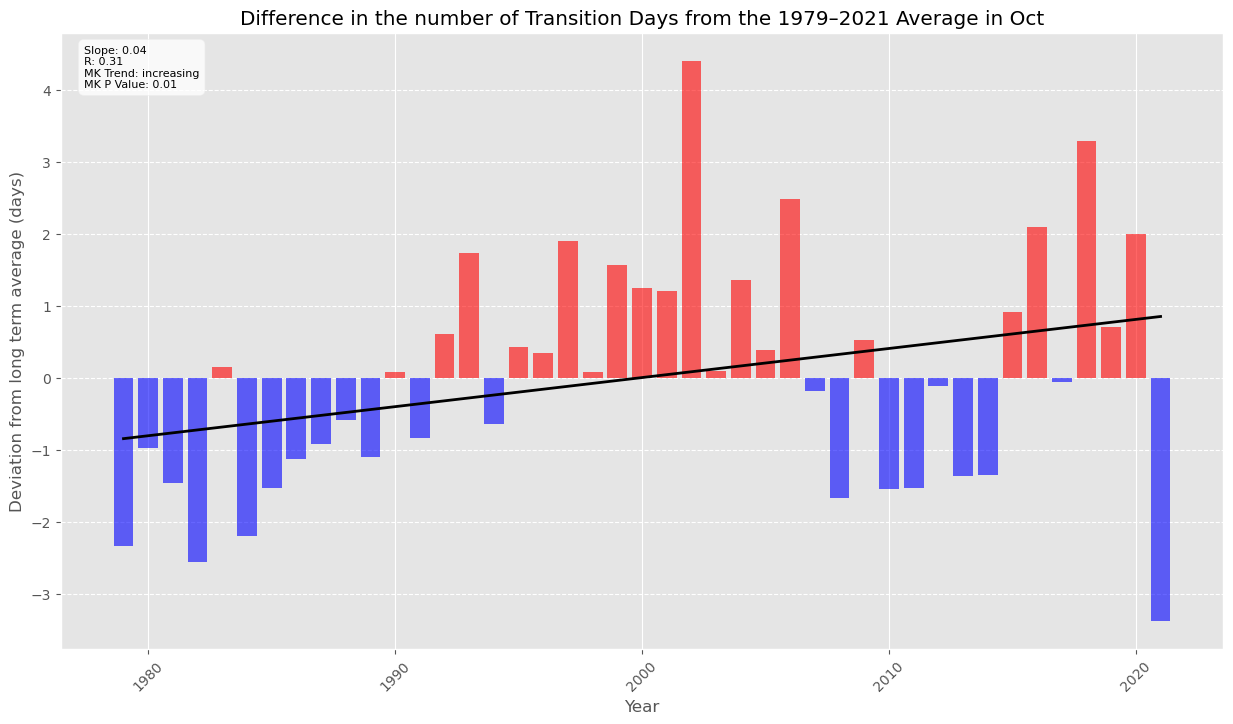

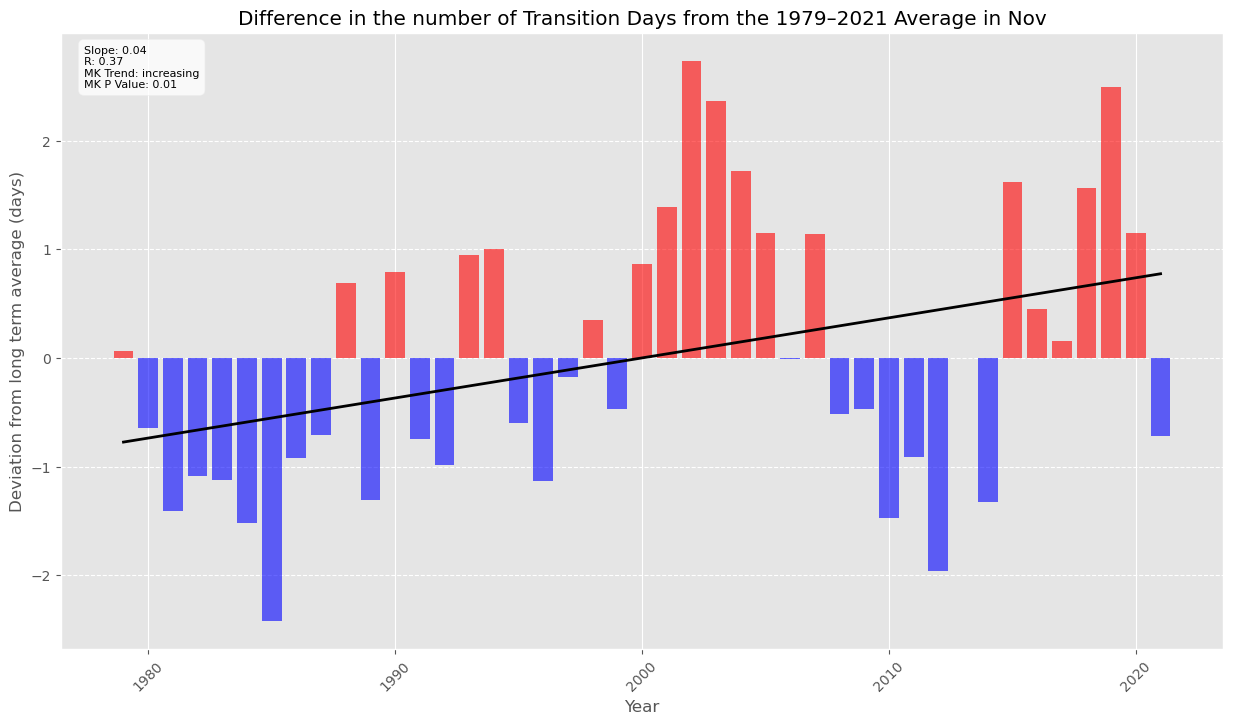

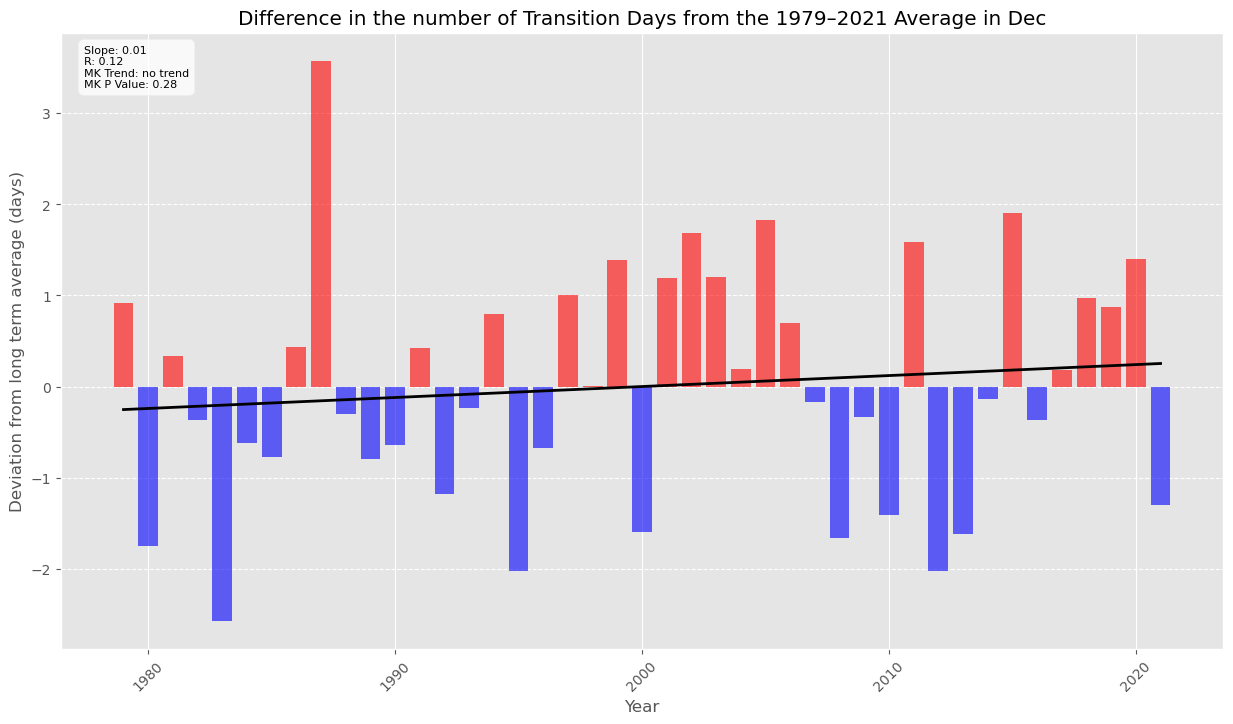

In [34]:
# List of months
months = df_frozen.columns[:-1]
df_list = [df_frozen, df_thawed, df_transition]
name = ['Frozen', 'Thawed', 'Transition']

slope_frozen = []
slope_thawed = []
slope_transition = []


for i in range(0, len(df_list)):
    df__ = df_list[i]
    print(name[i])
    for month in months:
        print(month)
        # Step 1: 
        monthly_mean_days = df__[month]

        # Step 2: Calculate the 1979-2021 Average
        long_term_average_days = df__[month].mean()

        # Step 3: Calculate Difference from Average
        difference_from_average = monthly_mean_days - long_term_average_days


        mk_result = mk.original_test(difference_from_average)


        # Calculate Linear Regression for Trend Line
        # Converting index to a suitable format for linregress, assuming index is year and is numeric
        x = monthly['Year'].astype(int)  # Years
        y = difference_from_average.values  # Difference from average

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Calculate the values of the trend line
        trend_line = intercept + slope * x

        # Generate values for the trend line
        x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
        y_line = intercept + slope * x_line


        # Constructing a Series to include various results from MK test and regression
        results = pd.Series({
            'm': slope,
            'b': intercept,
            'r2': r_value,
            'std_err': std_err,
            'p_value': p_value,
            'MK_trend': mk_result.trend,
            'MK_p_value': mk_result.p,
            'MK_z': mk_result.z,
            'MK_tau': mk_result.Tau,
            'MK_s': mk_result.s,
            'MK_var_s': mk_result.var_s,
            'MK_h': mk_result.h
        })

        if name[i] == 'Frozen':
            slope_frozen.append(results)
        if name[i] == 'Thawed':
            slope_thawed.append(results)
        if name[i] == 'Transition':
            slope_transition.append(results)


        # print(results)

        # Step 4: Plot
        plt.figure(figsize=(15, 8))  # Adjusts the size of the figure
        # difference_from_average.plot(kind='bar', color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))
        # plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at y=0 for reference

        # Bar chart
        plt.bar(x, y, label='Difference from Average', alpha=0.6, color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))

        # Trend line
        plt.plot(x_line, y_line, color='black', linewidth=2, label='Trend Line')


        #annotate the figure with these results
        # Constructing a Series to include various results from MK test and regression
        new_results = pd.Series({
            'Slope': round(slope, 2),
            'R': round(r_value, 2),
            'MK Trend': mk_result.trend,
            'MK P Value': round(mk_result.p, 2)
        })

        annotate_text = '\n'.join([f'{key}: {value}' for key, value in new_results.items()])

        # Add annotation to the figure
        plt.text(0.02, 0.98, annotate_text, verticalalignment='top', horizontalalignment='left', fontsize=8, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))



        plt.title('Difference in the number of {} Days from the 1979–2021 Average in {}'.format(name[i],  month))
        plt.xlabel('Year')
        plt.ylabel('Deviation from long term average (days)')
        plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
        plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis
        # plt.show()


        '''
        This figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.
        For each year, the bar represents the number of days shorter or longer than average.
        Positive numbers represent years with more unfrozen days than average.
        Choosing a different long-term average for comparison would not change the shape of the data over time.
        '''

## Heatmap


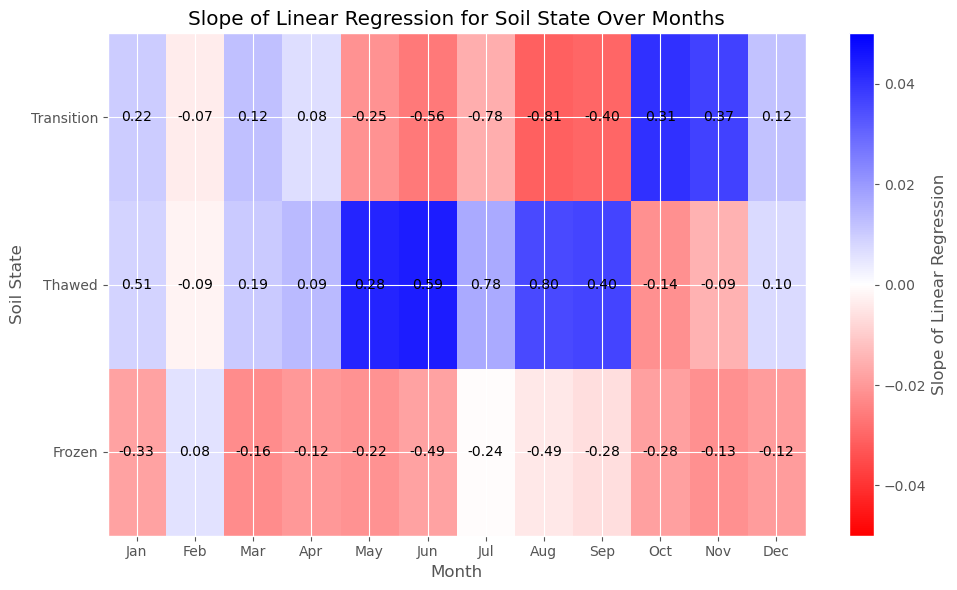

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Combine all soil state data
all_data = [slope_frozen, slope_thawed, slope_transition]

# Create a custom colormap
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, white, blue
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Initialize arrays to hold slope and color data
slope_matrix = np.zeros((len(all_data), len(months)))
color_matrix = np.empty((len(all_data), len(months)))
p_value_matrix = np.empty((len(all_data), len(months)))
r_value_matrix = np.empty((len(all_data), len(months)))

# Iterate over each soil state data
for i, state_data in enumerate(all_data):
    for j, month_data in enumerate(state_data):
        m = month_data['m']
        p_value = month_data['MK_p_value']
        trend = month_data['MK_trend']
        r = month_data['r2']
        
        # Set color based on trend and p-value
        color_matrix[i, j] = m
        p_value_matrix[i,j] = p_value
        r_value_matrix[i,j] = r

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(color_matrix, cmap=cmap, aspect='auto', interpolation='nearest', vmin=-0.05, vmax=0.05)  # Adjust vmin and vmax according to your data

# # Overlay gridlines where p-value is greater than 0.1
# for i in range(len(all_data)):
#     for j in range(len(months)):
#         if p_value_matrix[i, j] > 0.1:
#             plt.axhline(y=i + 0.25, color='black', lw=0.25)
#             plt.axvline(x=j + 0.25, color='black', lw=0.25)




plt.colorbar(label='Slope of Linear Regression')
plt.xticks(np.arange(len(months)), months)
plt.yticks(np.arange(len(all_data)), ['Frozen', 'Thawed', 'Transition'])
plt.title('Slope of Linear Regression for Soil State Over Months')
plt.xlabel('Month')
plt.ylabel('Soil State')
plt.gca().invert_yaxis()

# Annotate each tile with m and p-value
for i in range(len(all_data)):
    for j in range(len(months)):
        # plt.text(j, i, f"{color_matrix[i, j]:.2f}", ha='center', va='center', color='black')
        # plt.text(j, i, f"{p_value_matrix[i, j]:.3f}", ha='center', va='center', color='black')
        plt.text(j, i, f"{r_value_matrix[i, j]:.2f}", ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig('.test_.pdf')
plt.show()


## Simple

Jan
0.009895733230828367 0.023930705827465072 -0.004139239365808338
m                0.009896
b              -18.133869
r2               0.217078
std_err           0.00695
p_value          0.162033
MK_trend         no trend
MK_p_value       0.111667
MK_z             1.590744
MK_tau           0.169435
MK_s                153.0
MK_var_s      9130.333333
MK_h                False
dtype: object


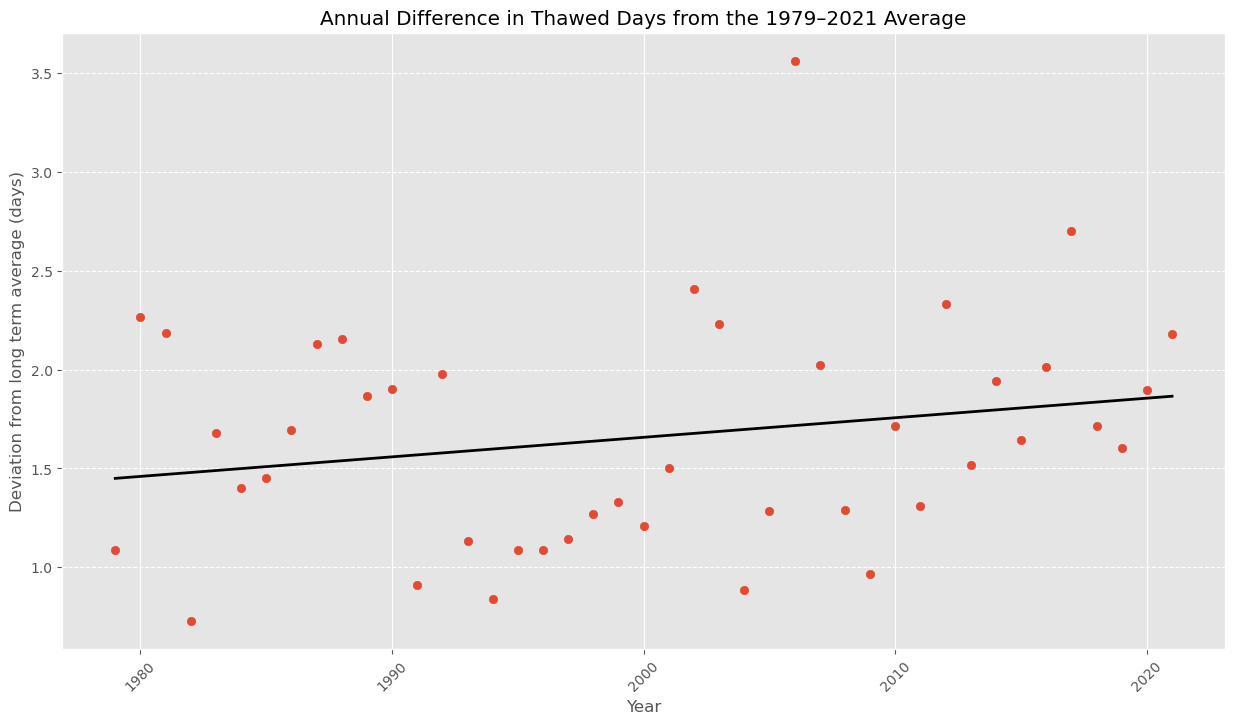

Feb
-0.0037529736572699426 0.0128209881094161 -0.020326935423955986
m               -0.003753
b                8.866392
r2              -0.071237
std_err          0.008207
p_value          0.649869
MK_trend         no trend
MK_p_value       0.817906
MK_z            -0.230239
MK_tau          -0.025471
MK_s                -23.0
MK_var_s      9130.333333
MK_h                False
dtype: object


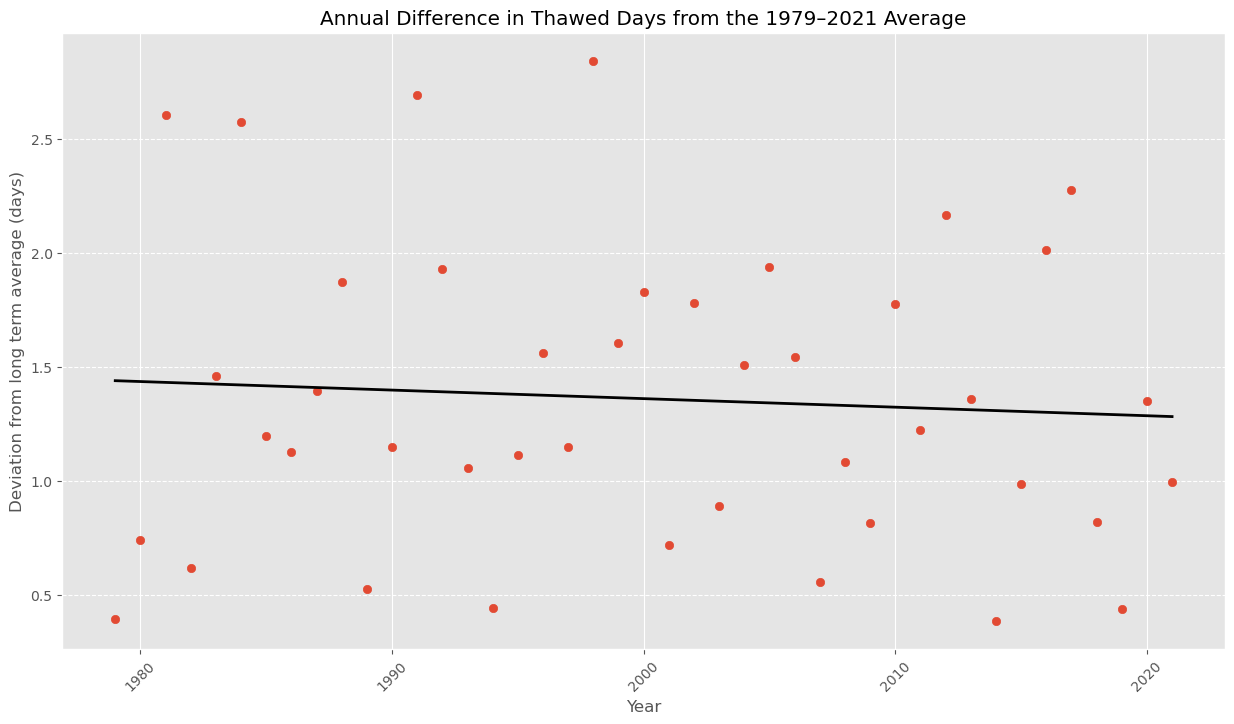

Mar
0.01215123878688512 0.042692773320085066 -0.01839029574631483
m                0.012151
b              -19.479531
r2               0.124508
std_err          0.015123
p_value          0.426323
MK_trend         no trend
MK_p_value       0.557833
MK_z             0.586064
MK_tau           0.063123
MK_s                 57.0
MK_var_s      9130.333333
MK_h                False
dtype: object


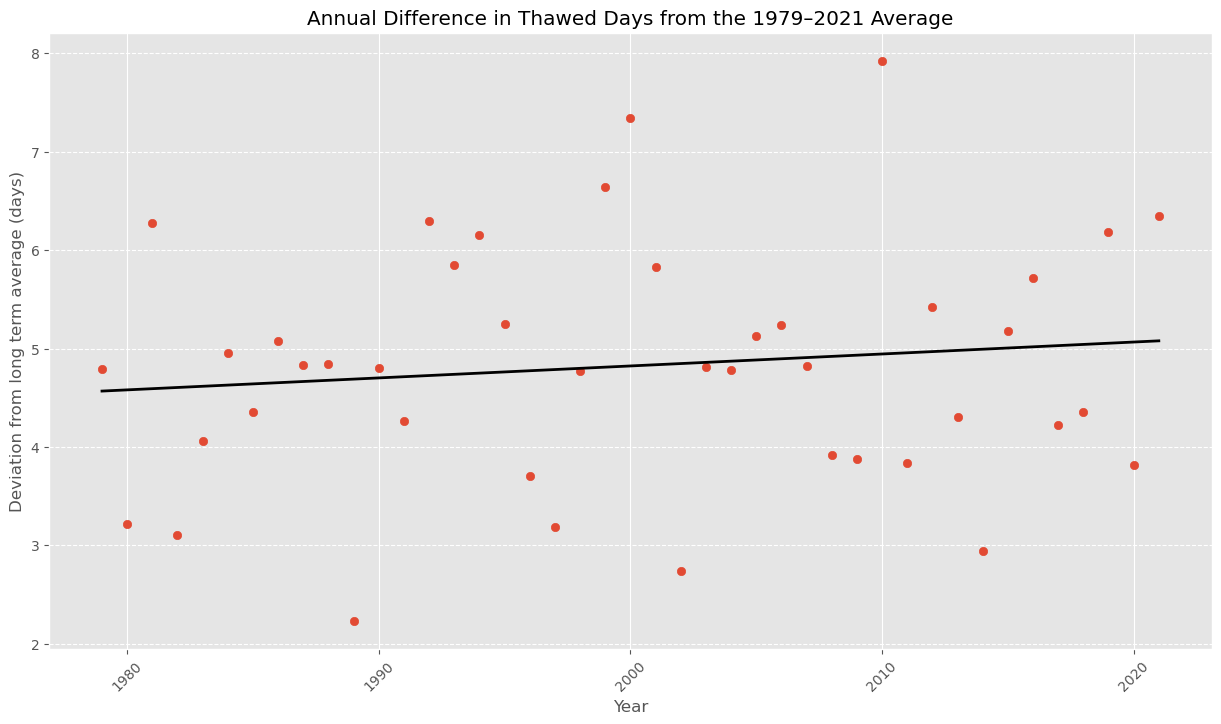

Apr
0.006599913413376106 0.032997837147520775 -0.019798010320768566
m                  0.0066
b               -4.185666
r2               0.078611
std_err          0.013071
p_value           0.61632
MK_trend         no trend
MK_p_value       0.571984
MK_z             0.565133
MK_tau           0.060908
MK_s                 55.0
MK_var_s      9130.333333
MK_h                False
dtype: object


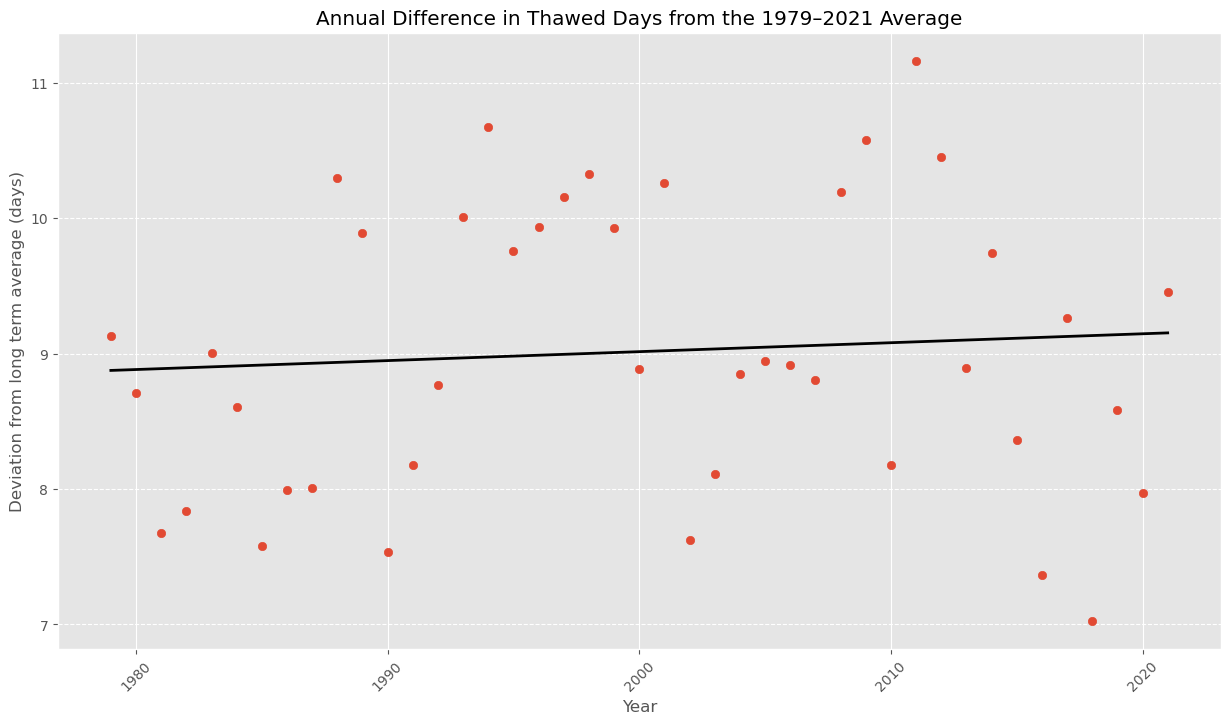

May
-0.021363655975555697 0.004728733941710327 -0.04745604589282172
m               -0.021364
b                48.39623
r2              -0.250037
std_err           0.01292
p_value          0.105859
MK_trend         no trend
MK_p_value       0.082341
MK_z             -1.73726
MK_tau          -0.184939
MK_s               -167.0
MK_var_s      9130.333333
MK_h                False
dtype: object


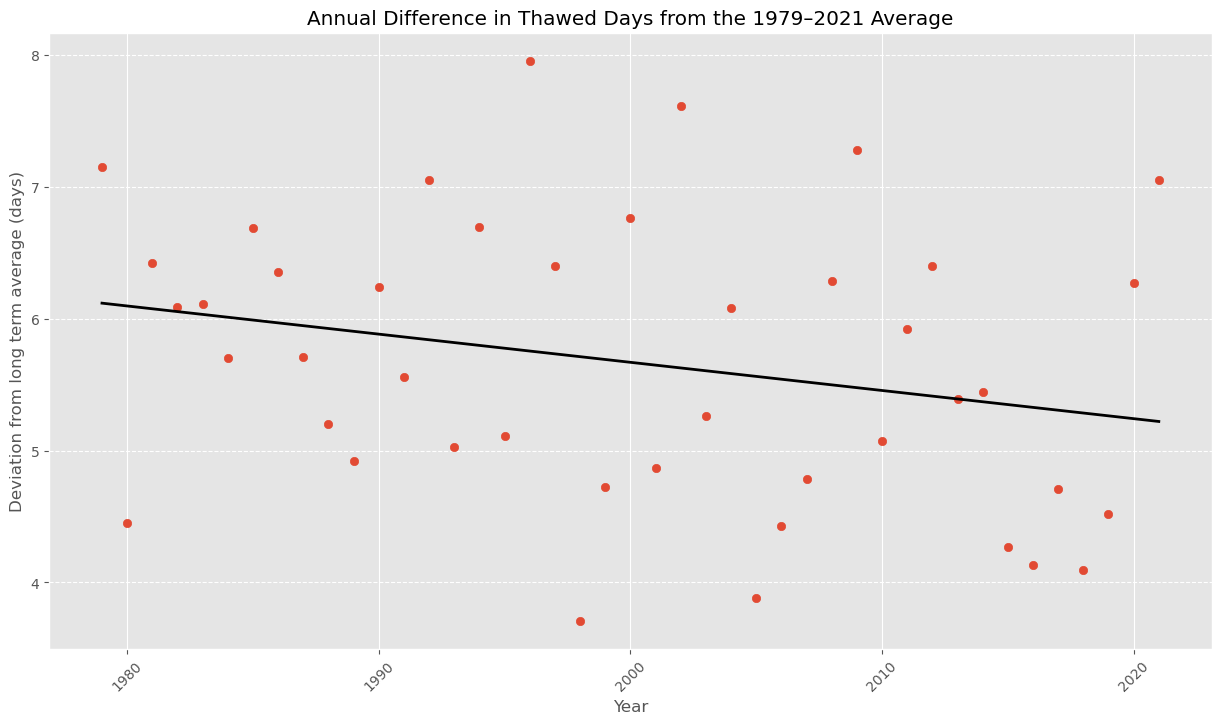

Jun
-0.026112412579869536 -0.013998437374763185 -0.03822638778497589
m               -0.026112
b               54.113307
r2              -0.562232
std_err          0.005998
p_value          0.000087
MK_trend       decreasing
MK_p_value       0.000031
MK_z            -4.165237
MK_tau           -0.44186
MK_s               -399.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


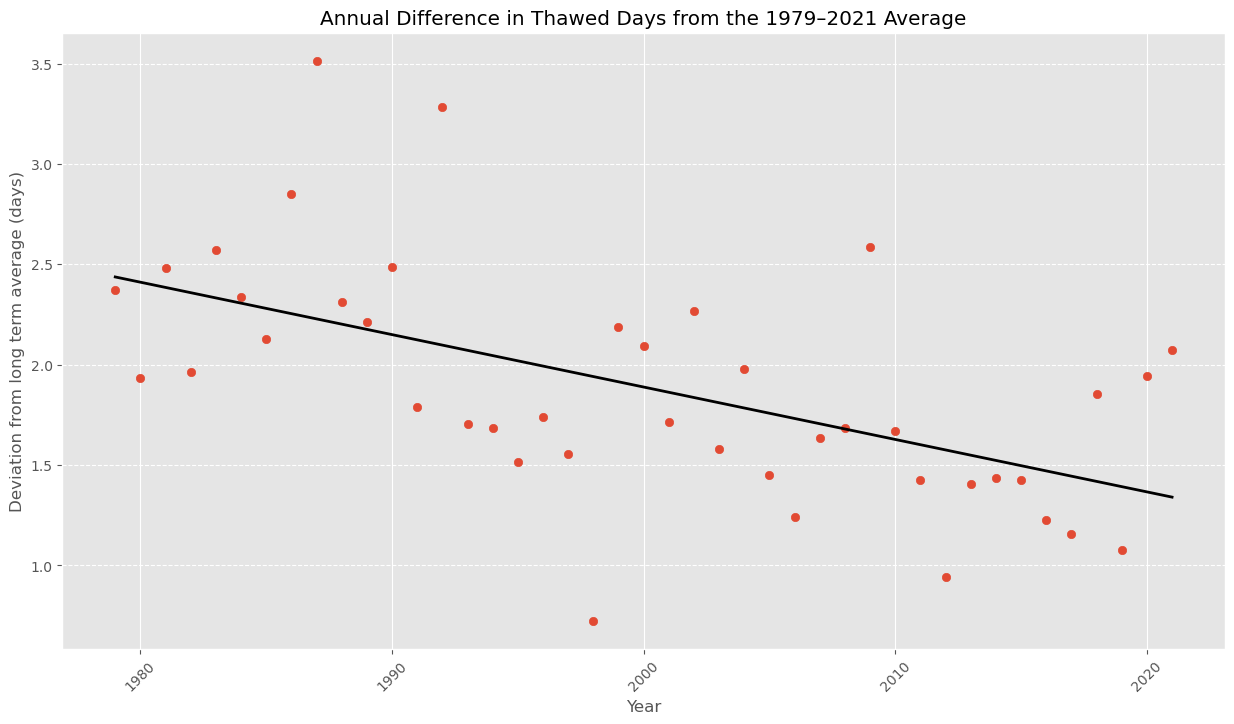

Jul
-0.015861568777039935 -0.011856900162882645 -0.019866237391197226
m               -0.015862
b               32.217554
r2               -0.78068
std_err          0.001983
p_value               0.0
MK_trend       decreasing
MK_p_value            0.0
MK_z            -5.525742
MK_tau          -0.585825
MK_s               -529.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


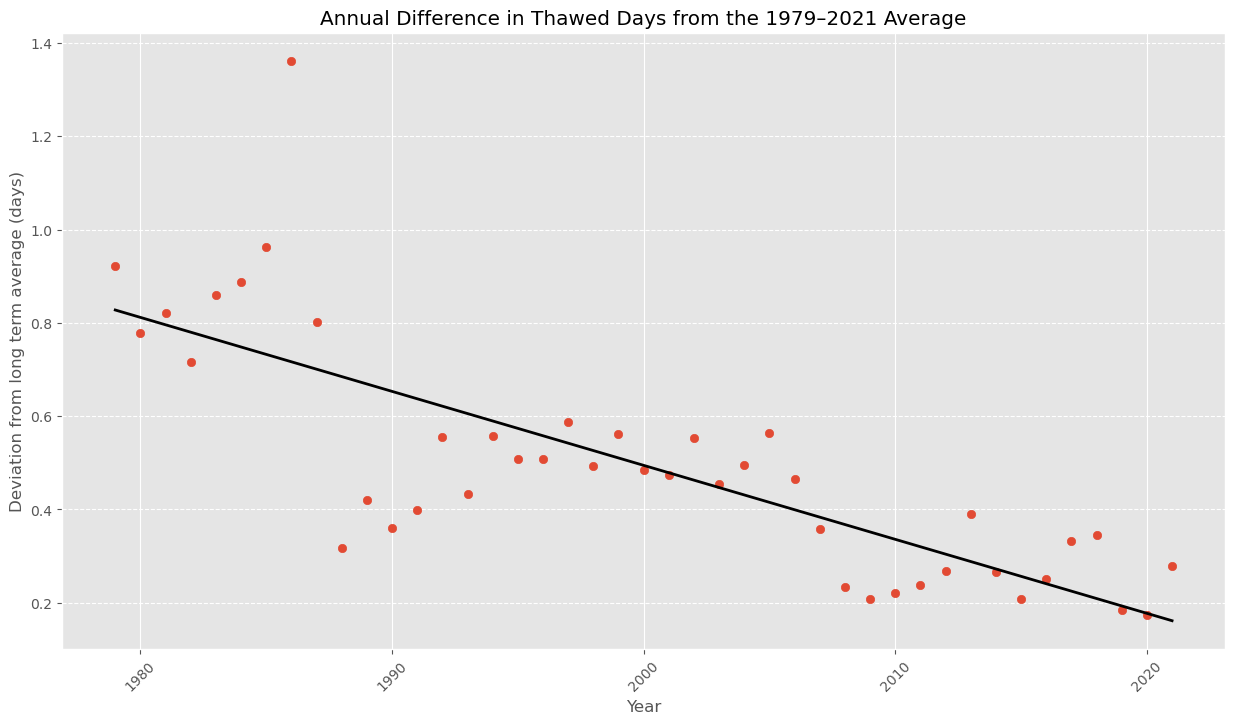

Aug
-0.031181382797208834 -0.02401813211118755 -0.03834463348323012
m               -0.031181
b               63.608069
r2              -0.808313
std_err          0.003547
p_value               0.0
MK_trend       decreasing
MK_p_value            0.0
MK_z            -5.923428
MK_tau          -0.627907
MK_s               -567.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


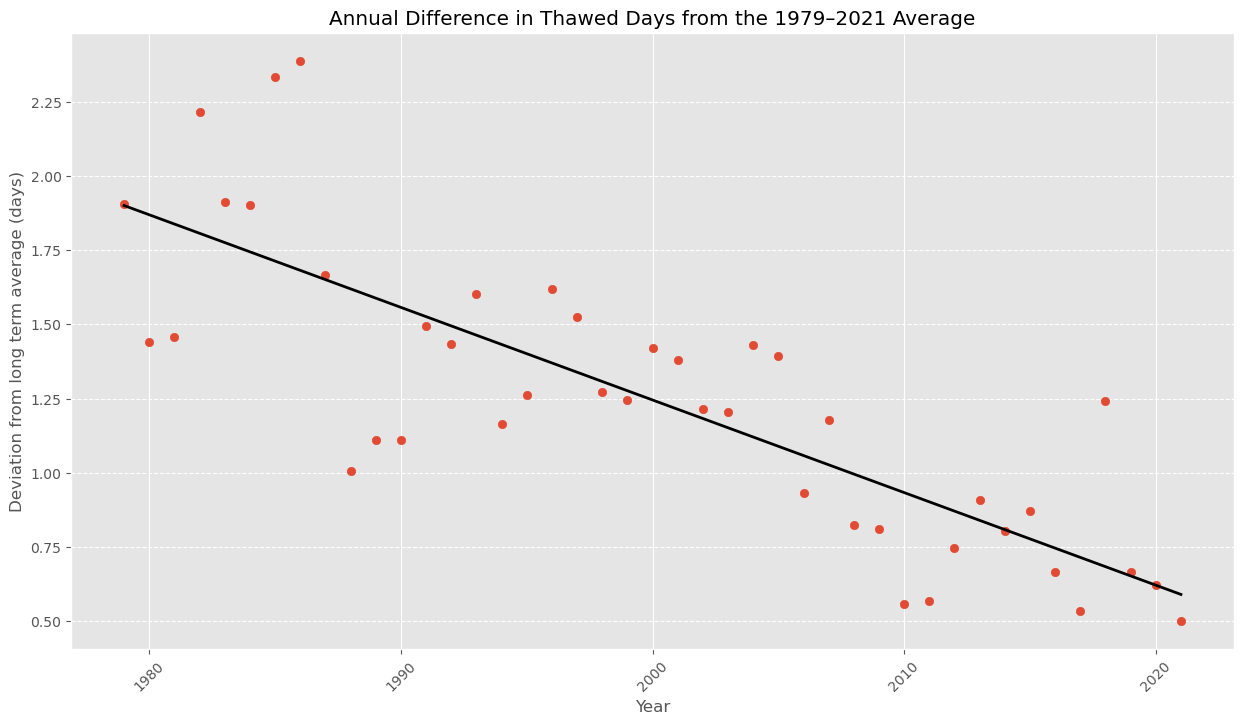

Sep
-0.029937006515079606 -0.008007849536344272 -0.05186616349381494
m               -0.029937
b               63.073169
r2              -0.395472
std_err          0.010858
p_value          0.008669
MK_trend       decreasing
MK_p_value         0.0035
MK_z            -2.920012
MK_tau          -0.310078
MK_s               -280.0
MK_var_s      9129.333333
MK_h                 True
dtype: object


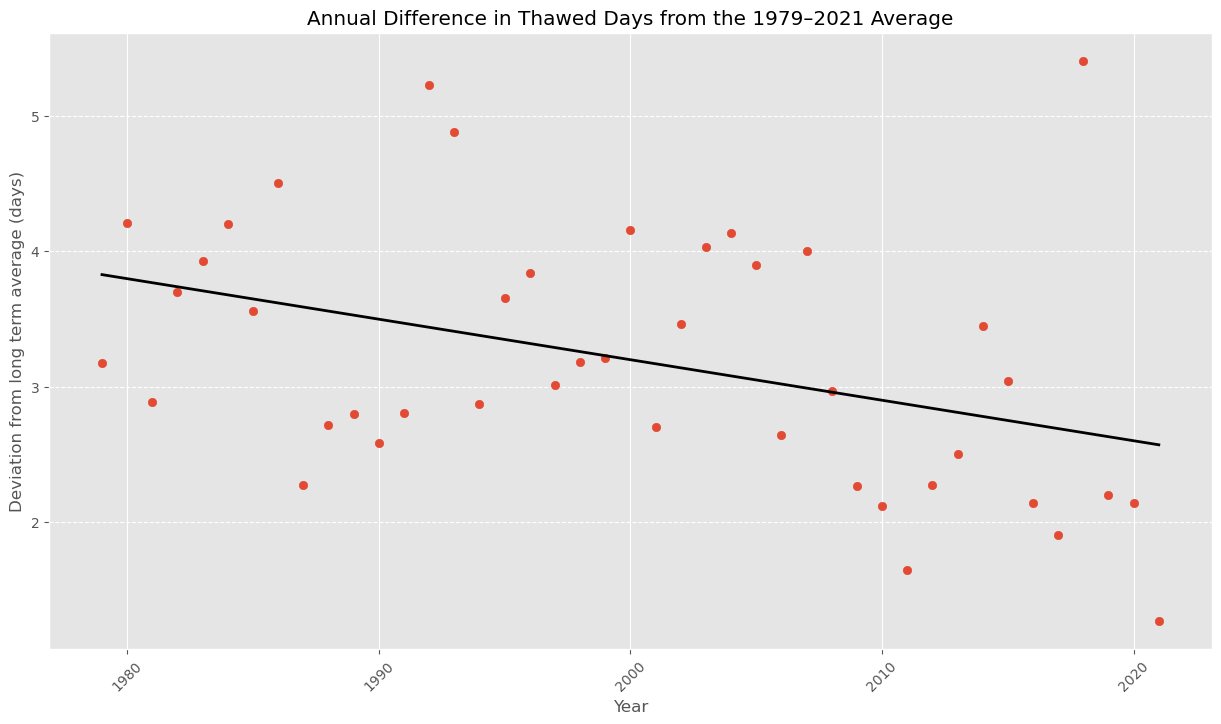

Oct
0.040392108457836334 0.07915012255311099 0.0016340943625616777
m                0.040392
b              -72.512664
r2               0.312261
std_err          0.019191
p_value          0.041492
MK_trend       increasing
MK_p_value       0.012747
MK_z              2.49077
MK_tau           0.264673
MK_s                239.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


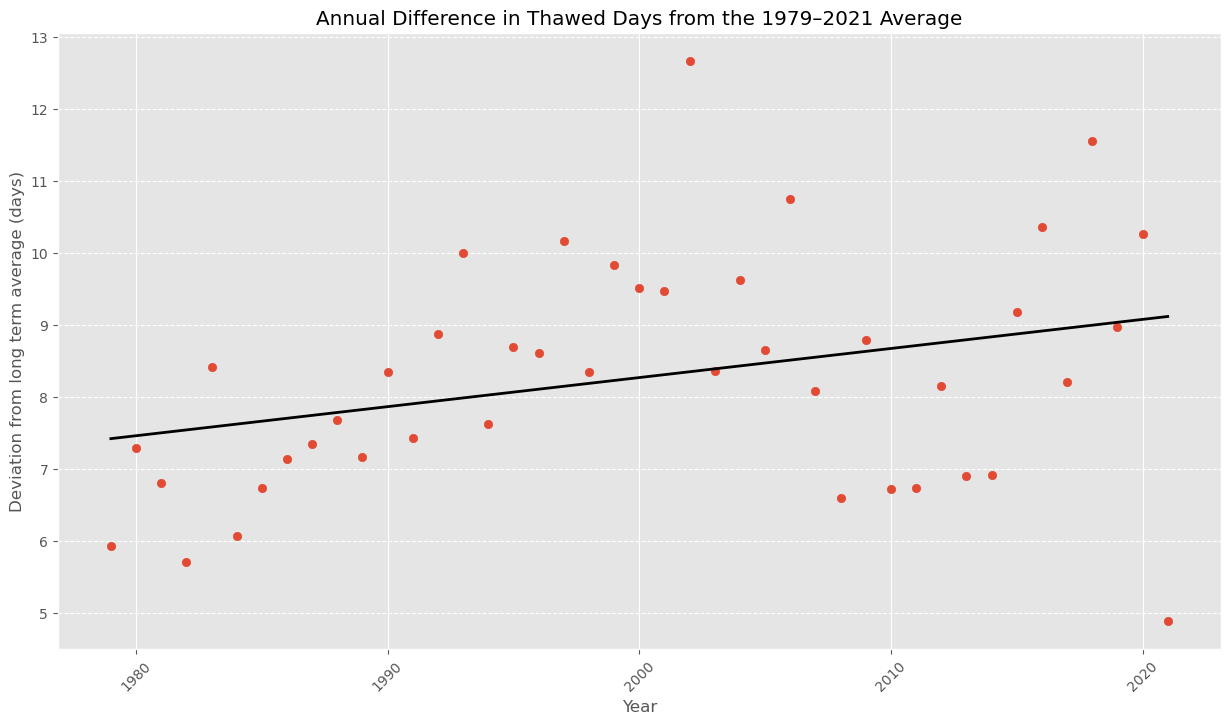

Nov
0.036873963019764894 0.06621454817827263 0.007533377861257157
m                0.036874
b              -65.017033
r2               0.368488
std_err          0.014528
p_value          0.015042
MK_trend       increasing
MK_p_value       0.011321
MK_z             2.532632
MK_tau           0.269103
MK_s                243.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


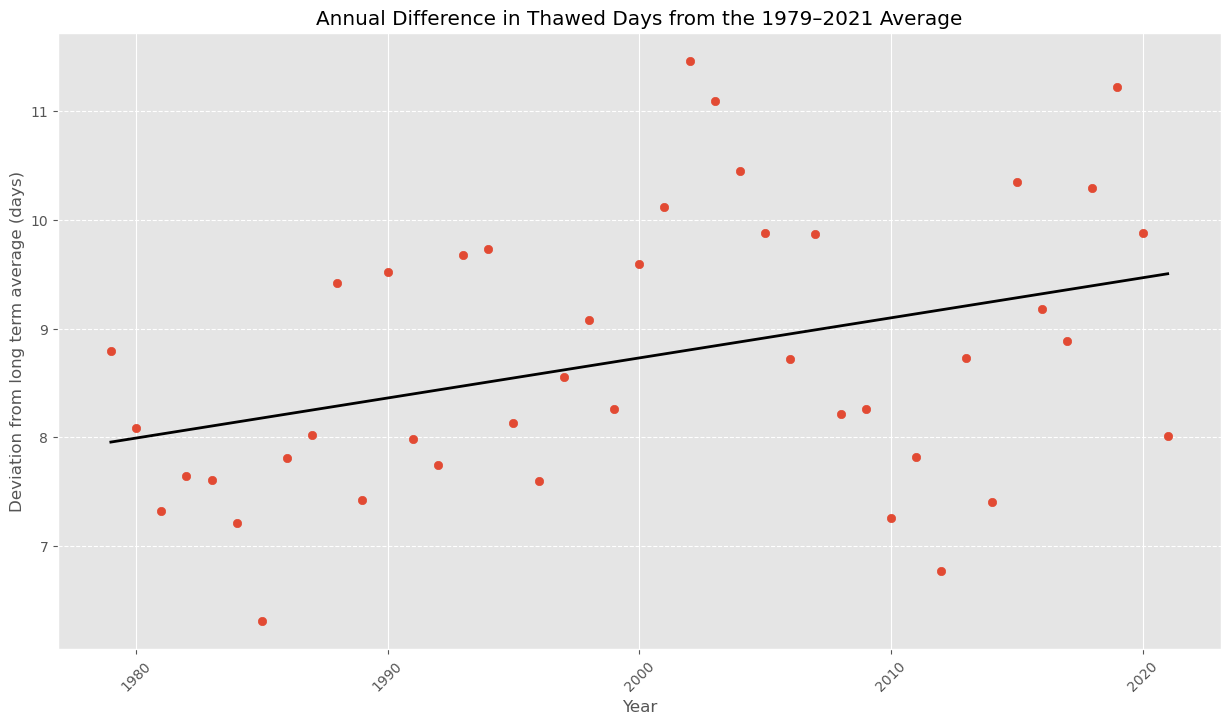

Dec
0.012046008582175907 0.04450908901938241 -0.02041707185503059
m                0.012046
b              -19.880493
r2               0.116241
std_err          0.016074
p_value          0.457902
MK_trend         no trend
MK_p_value       0.276417
MK_z             1.088404
MK_tau           0.116279
MK_s                105.0
MK_var_s      9130.333333
MK_h                False
dtype: object


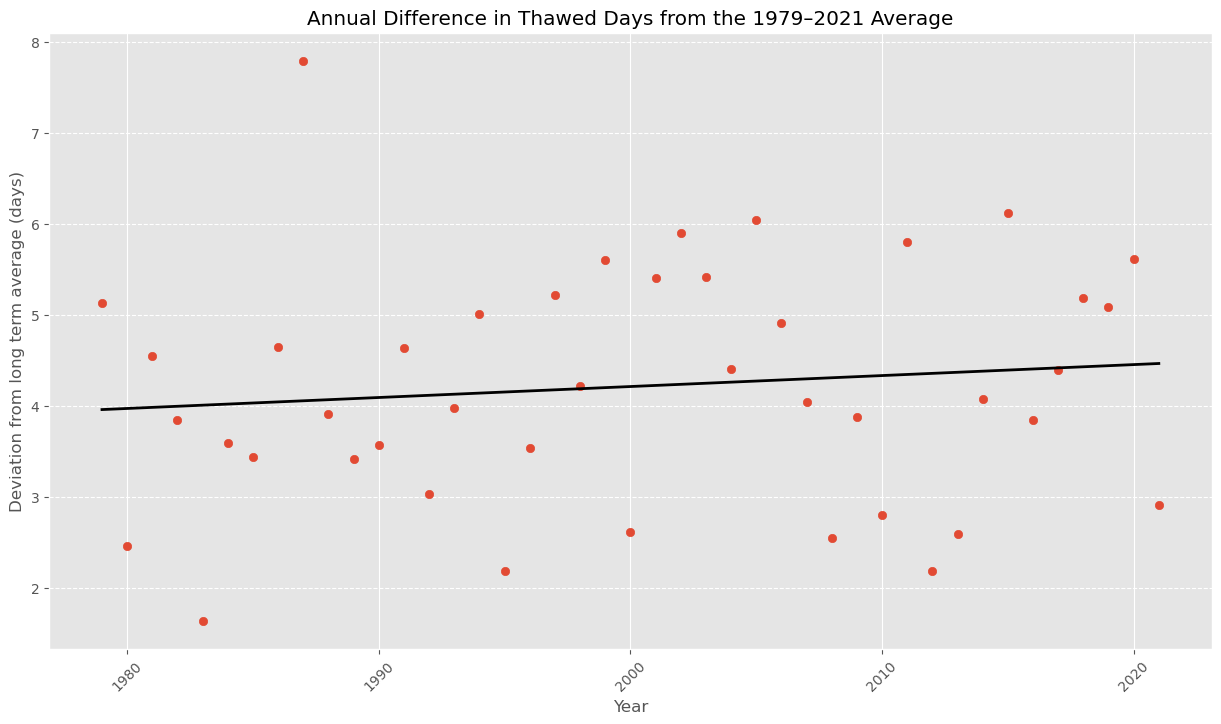

In [36]:
for month in month_names.values():
    print(month)
    # Step 1: 
    monthly_mean_days = monthly[month]

    # Calculate Linear Regression for Trend Line
    # Converting index to a suitable format for linregress, assuming index is year and is numeric
    x = monthly['Year'].astype(int)  # Years
    y = monthly_mean_days.values  # Difference from average

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the values of the trend line
    trend_line = intercept + slope * x

    # Generate values for the trend line
    x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
    y_line = intercept + slope * x_line


    # Calculate the number of data points and degrees of freedom
    n = len(x)
    d_f = n - 2  # degrees of freedom for linear regression

    # Set the desired confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the critical value from the t-distribution
    t_critical = t.ppf((1 + confidence_level) / 2, d_f)

    # Calculate the standard error of the estimate
    standard_error = std_err

    # Calculate the upper and lower bounds of the confidence interval
    upper_confidence = slope + t_critical * standard_error
    lower_confidence = slope - t_critical * standard_error

    print(slope, upper_confidence, lower_confidence)


    # Calculate the upper and lower bounds of the confidence interval
    upper_bound = (upper_confidence) * x + intercept
    lower_bound = (lower_confidence) * x + intercept


    mk_result = mk.original_test(y)

    # Constructing a Series to include various results from MK test and regression
    results = pd.Series({
        'm': slope,
        'b': intercept,
        'r2': r_value,
        'std_err': std_err,
        'p_value': p_value,
        'MK_trend': mk_result.trend,
        'MK_p_value': mk_result.p,
        'MK_z': mk_result.z,
        'MK_tau': mk_result.Tau,
        'MK_s': mk_result.s,
        'MK_var_s': mk_result.var_s,
        'MK_h': mk_result.h
    })

    print(results)

    # Step 4: Plot
    plt.figure(figsize=(15, 8))  # Adjusts the size of the figure
    # difference_from_average.plot(kind='bar', color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))
    # plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at y=0 for reference

    # Bar chart
    plt.scatter(x, y)

    # Fill the area between upper and lower confidence bounds with a shaded color
    # plt.fill_between(x, lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')


    # Trend line
    plt.plot(x_line, y_line, color='black', linewidth=2, label='Trend Line')


    plt.title('Annual Difference in Thawed Days from the 1979–2021 Average')
    plt.xlabel('Year')
    plt.ylabel('Deviation from long term average (days)')
    plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
    plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis
    plt.show()


    '''
    This figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.
    For each year, the bar represents the number of days shorter or longer than average.
    Positive numbers represent years with more unfrozen days than average.
    Choosing a different long-term average for comparison would not change the shape of the data over time.
'''

# Seasonal

In [37]:
monthly_frozen_days = {}
monthly_transitional_days = {}
monthly_thawed_days = {}

for soil_state in ['Frozen', 'Thawed', 'Transition']:
    # Step 1: Calculate the Annual Sum of 'Thawed'
    annual_mean_days = main.groupby(['Year', 'Month'])[soil_state].mean()


    # Dictionary mapping month numbers to their corresponding abbreviated names
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }

    # Create an empty dictionary with keys as month names and empty lists as values
    month_dict = {month_names[month_num]: [] for month_num in range(1, 13)}



    for i in range (1979, 2022):
        for key in month_names.keys():
            month_dict[month_names[key]].append(annual_mean_days.loc[(i, key)])

    # Print the created dictionary
    print(month_dict)


    monthly = pd.DataFrame(month_dict)
    monthly['Year'] = np.arange(1979,2022,1)

    if soil_state == 'Frozen':
        df_frozen = monthly
       
        

    if soil_state == 'Thawed':
        df_thawed =  monthly
        
    
    if soil_state == 'Transition':
        df_transition =  monthly
    

{'Jan': [29.370373376623377, 28.50073051948052, 28.519805194805194, 30.206087662337662, 29.070779220779222, 29.195454545454545, 29.422646103896103, 29.171996753246752, 28.43522727272727, 28.431006493506494, 28.87581168831169, 28.744642857142857, 29.885957792207794, 28.268587662337662, 29.51176948051948, 29.98766233766234, 29.414691558441557, 29.5450487012987, 29.520698051948052, 29.442126623376623, 29.290097402597404, 29.49586038961039, 29.234253246753248, 28.040016233766234, 28.318181818181817, 29.896266233766234, 29.366883116883116, 26.812743506493508, 28.273538961038962, 28.912905844155844, 29.81672077922078, 28.504383116883115, 29.145454545454545, 28.069155844155844, 28.76948051948052, 28.551298701298702, 28.971103896103894, 28.469155844155843, 27.305113636363636, 28.848863636363635, 29.086201298701297, 28.679301948051947, 28.177597402597403], 'Feb': [27.477597402597404, 28.190016233766233, 23.982792207792208, 27.315746753246753, 26.32418831168831, 25.73311688311688, 26.65933441558

## Bar Chart

/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/2106470592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Dec'] = dec_clm[:-1]
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/2106470592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Dec'] = dec_clm[:-1]
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/2106470592.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

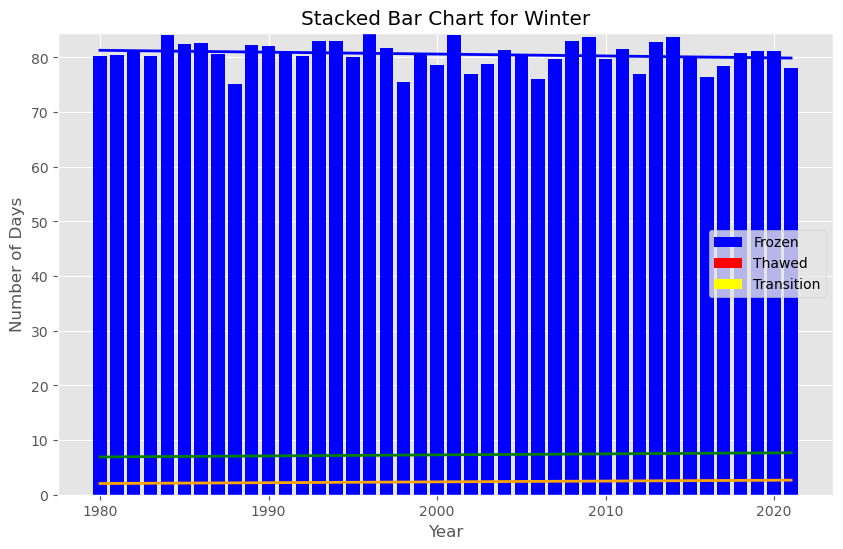

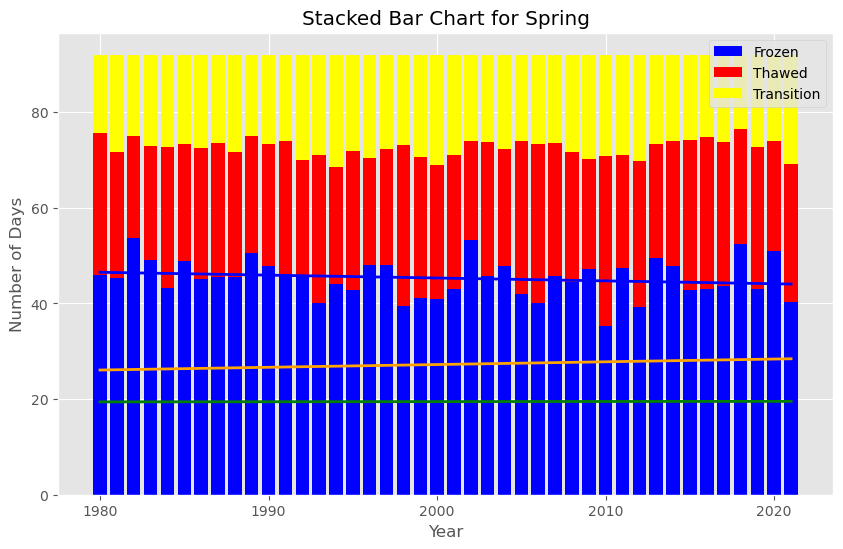

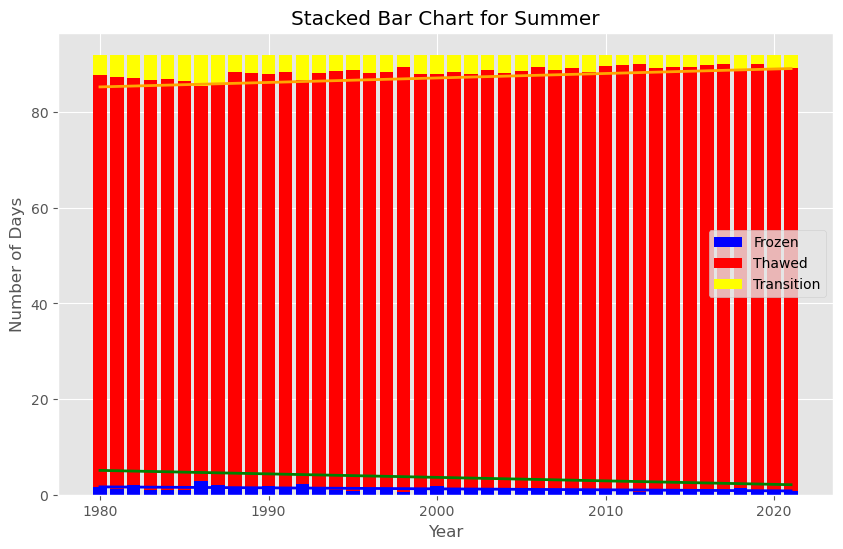

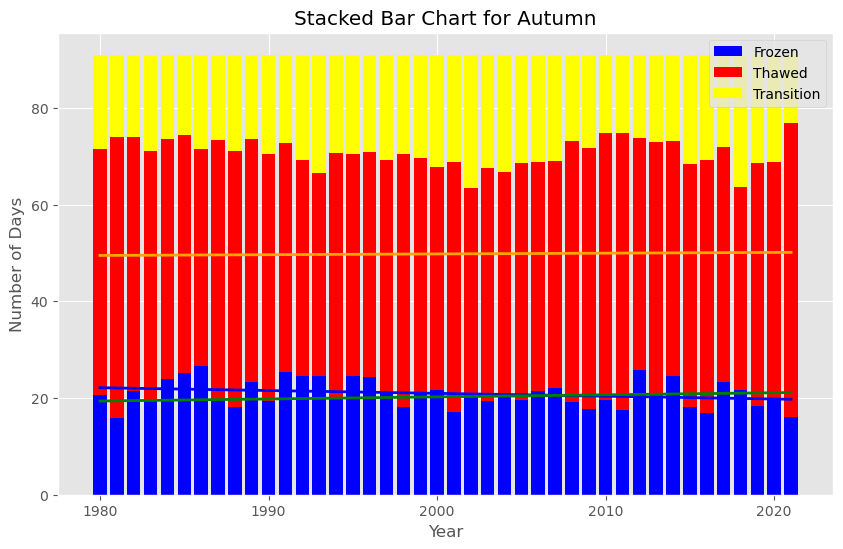

In [38]:
# Creating seasonal DataFrames for frozen, thawed, and transition days
def create_seasonal_df(df):
    seasonal_data = {'Year': df['Year']}  # Initialize with 'Year' column
    seasons = {
        'Winter': ['Dec', 'Jan', 'Feb'],
        'Spring': ['Mar', 'Apr', 'May'],
        'Summer': ['Jun', 'Jul', 'Aug'],
        'Autumn': ['Sep', 'Oct', 'Nov']
    }

    for season, months in seasons.items():
        if season == 'Winter':
            # Check for incomplete seasons and omit them
            years_to_include = df['Year'].between(1980, 2021)  # Excluding Winter 1979 and Winter 2021
            dec_clm = list(df.Dec)
            new_df = df.loc[years_to_include, :]
            new_df['Dec'] = dec_clm[:-1]
# print(years_to_include.head())
            seasonal_data[season] = new_df[months].sum(axis=1)
        else:
            seasonal_data[season] = df[months].sum(axis=1)

    return pd.DataFrame(seasonal_data)

# Creating seasonal DataFrames for frozen, thawed, and transition days
df_seasonal_frozen = create_seasonal_df(df_frozen)
df_seasonal_thawed = create_seasonal_df(df_thawed)
df_seasonal_transition = create_seasonal_df(df_transition)

# Plotting each seasonal DataFrame
seasons = df_seasonal_frozen.columns[1:]

for season in seasons:
    plt.figure(figsize=(10, 6))
    
    # Stacking the data
    bottom = np.zeros(len(df_seasonal_frozen))
    plt.bar(df_seasonal_frozen['Year'], df_seasonal_frozen[season], color='blue', label='Frozen', bottom=bottom)
    bottom += df_seasonal_frozen[season]
    plt.bar(df_seasonal_thawed['Year'], df_seasonal_thawed[season], color='red', label='Thawed', bottom=bottom)
    bottom += df_seasonal_thawed[season]
    plt.bar(df_seasonal_transition['Year'], df_seasonal_transition[season], color='yellow', label='Transition', bottom=bottom)


    # Calculate linear regression for each set of data
    if season == 'Winter':
        df_seasonal_frozen.dropna(inplace=True)
        df_seasonal_thawed.dropna(inplace=True)
        df_seasonal_transition.dropna(inplace=True)

        frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
        thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
        transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)
    else:
        frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
        thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
        transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)

    # Plot linear regression lines
    plt.plot(df_seasonal_frozen.Year, frozen_slope * np.array(df_seasonal_frozen.Year) + frozen_intercept, color='blue', linestyle='-', linewidth=2)
    plt.plot(df_seasonal_thawed.Year, thawed_slope * np.array(df_seasonal_thawed.Year) + thawed_intercept, color='orange', linestyle='-', linewidth=2)
    plt.plot(df_seasonal_transition.Year, transitional_slope * np.array(df_seasonal_transition.Year) + transitional_intercept, color='green', linestyle='-', linewidth=2)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Days')
    plt.title(f'Stacked Bar Chart for {season}')
    plt.legend()
    plt.show()


## simple

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.264
Date:                Fri, 04 Oct 2024   Prob (F-statistic):              0.268
Time:                        13:23:41   Log-Likelihood:                -95.559
No. Observations:                  42   AIC:                             195.1
Df Residuals:                      40   BIC:                             198.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.6923     61.441      2.436      0.0

/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/1807233199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Dec'] = dec_clm[:-1]
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/1807233199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Dec'] = dec_clm[:-1]
/var/folders/1p/vx9zfzfn14z2b46713lr78z40000gn/T/ipykernel_16956/1807233199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

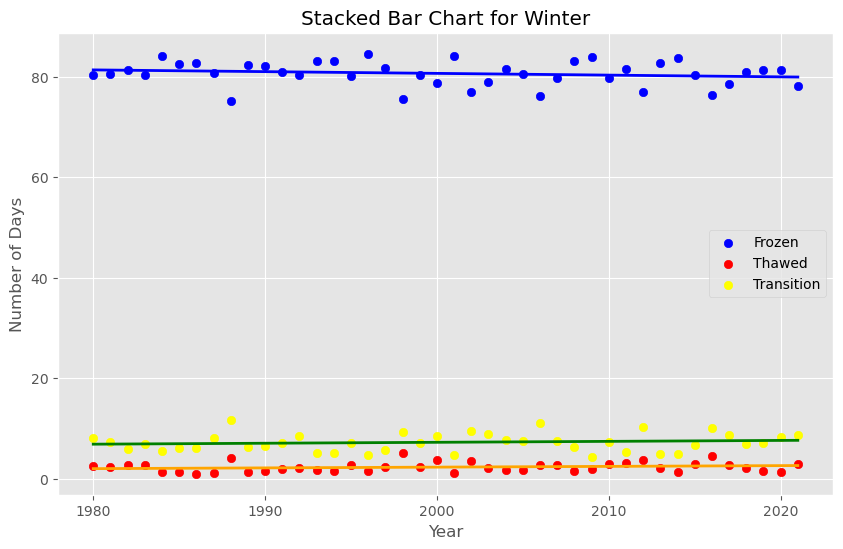

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.381
Date:                Fri, 04 Oct 2024   Prob (F-statistic):              0.247
Time:                        13:23:41   Log-Likelihood:                -116.92
No. Observations:                  42   AIC:                             237.8
Df Residuals:                      40   BIC:                             241.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        165.3616    102.180      1.618      0.1

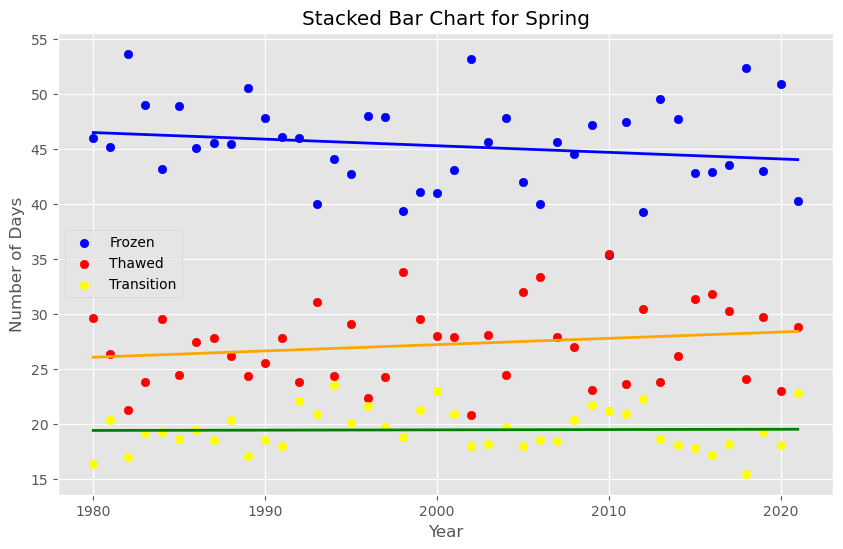

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     15.20
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           0.000361
Time:                        13:23:41   Log-Likelihood:                -21.631
No. Observations:                  42   AIC:                             47.26
Df Residuals:                      40   BIC:                             50.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.4204     10.569      4.014      0.0

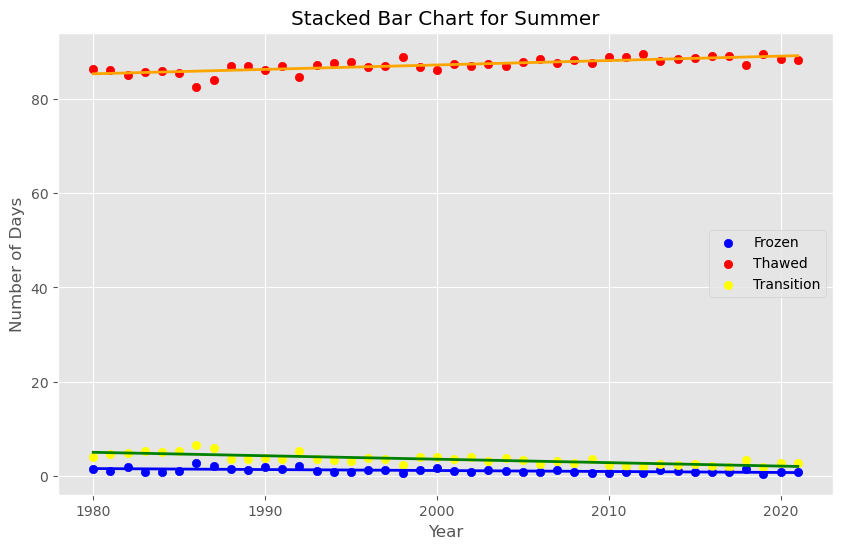

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.710
Date:                Fri, 04 Oct 2024   Prob (F-statistic):              0.108
Time:                        13:23:41   Log-Likelihood:                -101.61
No. Observations:                  42   AIC:                             207.2
Df Residuals:                      40   BIC:                             210.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        137.7453     70.962      1.941      0.0

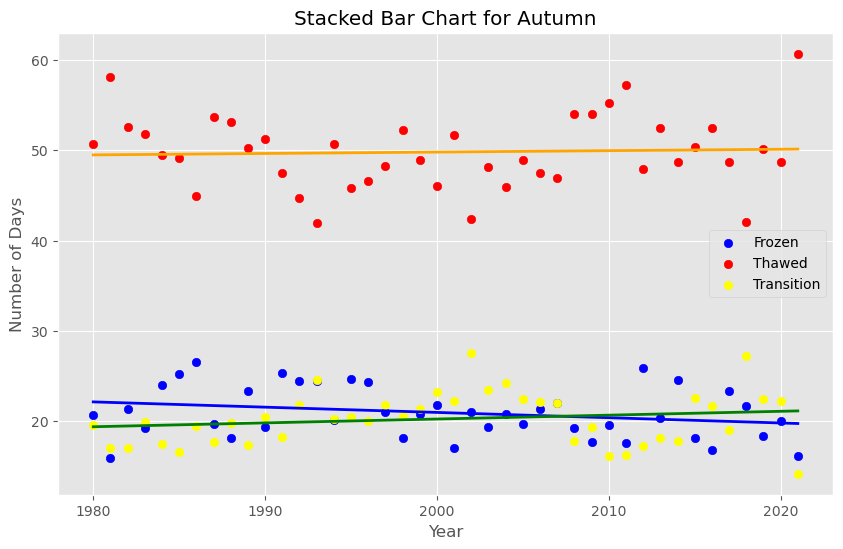

In [39]:
# Creating seasonal DataFrames for frozen, thawed, and transition days
def create_seasonal_df(df):
    seasonal_data = {'Year': df['Year']}  # Initialize with 'Year' column
    seasons = {
        'Winter': ['Dec', 'Jan', 'Feb'],
        'Spring': ['Mar', 'Apr', 'May'],
        'Summer': ['Jun', 'Jul', 'Aug'],
        'Autumn': ['Sep', 'Oct', 'Nov']
    }

    for season, months in seasons.items():
        if season == 'Winter':
            # Check for incomplete seasons and omit them
            years_to_include = df['Year'].between(1980, 2021)  # Excluding Winter 1979 and Winter 2021
            dec_clm = list(df.Dec)
            new_df = df.loc[years_to_include, :]
            new_df['Dec'] = dec_clm[:-1]
# print(years_to_include.head())
            seasonal_data[season] = new_df[months].sum(axis=1)
        else:
            seasonal_data[season] = df[months].sum(axis=1)

    return pd.DataFrame(seasonal_data)

# Creating seasonal DataFrames for frozen, thawed, and transition days
df_seasonal_frozen = create_seasonal_df(df_frozen)
df_seasonal_thawed = create_seasonal_df(df_thawed)
df_seasonal_transition = create_seasonal_df(df_transition)

# Plotting each seasonal DataFrame
seasons = df_seasonal_frozen.columns[1:]

for season in seasons:
    plt.figure(figsize=(10, 6))
    
    # Stacking the data
    bottom = np.zeros(len(df_seasonal_frozen))
    plt.scatter(df_seasonal_frozen['Year'], df_seasonal_frozen[season], color='blue', label='Frozen')
    
    plt.scatter(df_seasonal_thawed['Year'], df_seasonal_thawed[season], color='red', label='Thawed')
    
    plt.scatter(df_seasonal_transition['Year'], df_seasonal_transition[season], color='yellow', label='Transition')


    # Calculate linear regression for each set of data
    if season == 'Winter':
        df_seasonal_frozen.dropna(inplace=True)
        df_seasonal_thawed.dropna(inplace=True)
        df_seasonal_transition.dropna(inplace=True)

        # frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
        # thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
        # transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)

        
    # else:
    #     frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
    #     thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
    #     transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)

    
    
    frozen_slope, frozen_intercept = np.polyfit(df_seasonal_frozen.Year, df_seasonal_frozen[season], 1)
    thawed_slope, thawed_intercept = np.polyfit(df_seasonal_thawed.Year, df_seasonal_thawed[season], 1)
    transitional_slope, transitional_intercept = np.polyfit(df_seasonal_transition.Year, df_seasonal_transition[season], 1)

    frozen_model = mk.original_test(df_seasonal_frozen[season])
    thawed_model = mk.original_test(df_seasonal_thawed[season])
    transition_model = mk.original_test(df_seasonal_transition[season])

    print(sm.OLS(df_seasonal_frozen[season].values, sm.add_constant(df_seasonal_frozen.Year.values)).fit().summary())
    print(sm.OLS(df_seasonal_thawed[season].values, sm.add_constant(df_seasonal_thawed.Year.values)).fit().summary())
    print(sm.OLS(df_seasonal_transition[season].values, sm.add_constant(df_seasonal_transition.Year.values)).fit().summary())



    results_frozen = pd.Series({
    'MK_trend': frozen_model.trend,
    'MK_p_value': frozen_model.p,
    'MK_z': frozen_model.z,
    'MK_tau': frozen_model.Tau,
    'MK_s': frozen_model.s,
    'MK_var_s': frozen_model.var_s,
    'MK_h': frozen_model.h})
    print(results_frozen)

    results_thawed = pd.Series({
    'MK_trend': thawed_model.trend,
    'MK_p_value': thawed_model.p,
    'MK_z': thawed_model.z,
    'MK_tau': thawed_model.Tau,
    'MK_s': thawed_model.s,
    'MK_var_s': thawed_model.var_s,
    'MK_h': thawed_model.h})
    print(results_thawed)

    results_transition = pd.Series({
    'MK_trend': transition_model.trend,
    'MK_p_value': transition_model.p,
    'MK_z': transition_model.z,
    'MK_tau': transition_model.Tau,
    'MK_s': transition_model.s,
    'MK_var_s': transition_model.var_s,
    'MK_h': transition_model.h})
    print(results_transition)

    # Plot linear regression lines
    plt.plot(df_seasonal_frozen.Year, frozen_slope * np.array(df_seasonal_frozen.Year) + frozen_intercept, color='blue', linestyle='-', linewidth=2)
    plt.plot(df_seasonal_thawed.Year, thawed_slope * np.array(df_seasonal_thawed.Year) + thawed_intercept, color='orange', linestyle='-', linewidth=2)
    plt.plot(df_seasonal_transition.Year, transitional_slope * np.array(df_seasonal_transition.Year) + transitional_intercept, color='green', linestyle='-', linewidth=2)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Days')
    plt.title(f'Stacked Bar Chart for {season}')
    plt.legend()
    plt.show()


# vegCover

In [40]:
veg_cover_mapping = {1: 'Arctic Tundra',
2: 'Alpine Tundra',
3: 'Boreal Forest & Woodland',
4: 'Pacific Cool Temperate Forest',
5: 'Cordilleran Cool Temperate Forest',
6: 'Eastern Cool Temperate Forest',
7: 'Grassland, Parkland & Steppe',
8:'Other'}
Tundra = main[(main.vegcover == 1) | (main.vegcover == 2)]
Boreal = main[main.vegcover == 3 ]
Forest = main[(main.vegcover == 4) | (main.vegcover == 5) | (main.vegcover == 6)]
Praires = main[(main.vegcover == 7) | (main.vegcover == 8) ]


# Step 1: Calculate the Annual mean of the soil state for each veg cover
gp_boreal = Boreal.groupby(['Grid', 'Year']).sum()
gp_boreal['year'] =  list(gp_boreal.index.get_level_values('Year'))
boreal = gp_boreal.groupby('year').mean()


gp_tundra = Tundra.groupby(['Grid', 'Year']).sum()
gp_tundra['year'] =  list(gp_tundra.index.get_level_values('Year'))
tundra = gp_tundra.groupby('year').mean()


gp_forest = Forest.groupby(['Grid', 'Year']).sum()
gp_forest['year'] =  list(gp_forest.index.get_level_values('Year'))
forest = gp_forest.groupby('year').mean()


gp_praires = Praires.groupby(['Grid', 'Year']).sum()
gp_praires['year'] =  list(gp_praires.index.get_level_values('Year'))
praires = gp_praires.groupby('year').mean()


## annual

### epa

m               -0.187939
b              375.878462
r2              -0.341845
std_err          0.080688
p_value          0.024855
MK_trend       decreasing
MK_p_value       0.020162
MK_z            -2.323323
MK_tau          -0.246955
MK_s               -223.0
MK_var_s      9130.333333
MK_h                 True
dtype: object
-4.761904761904748


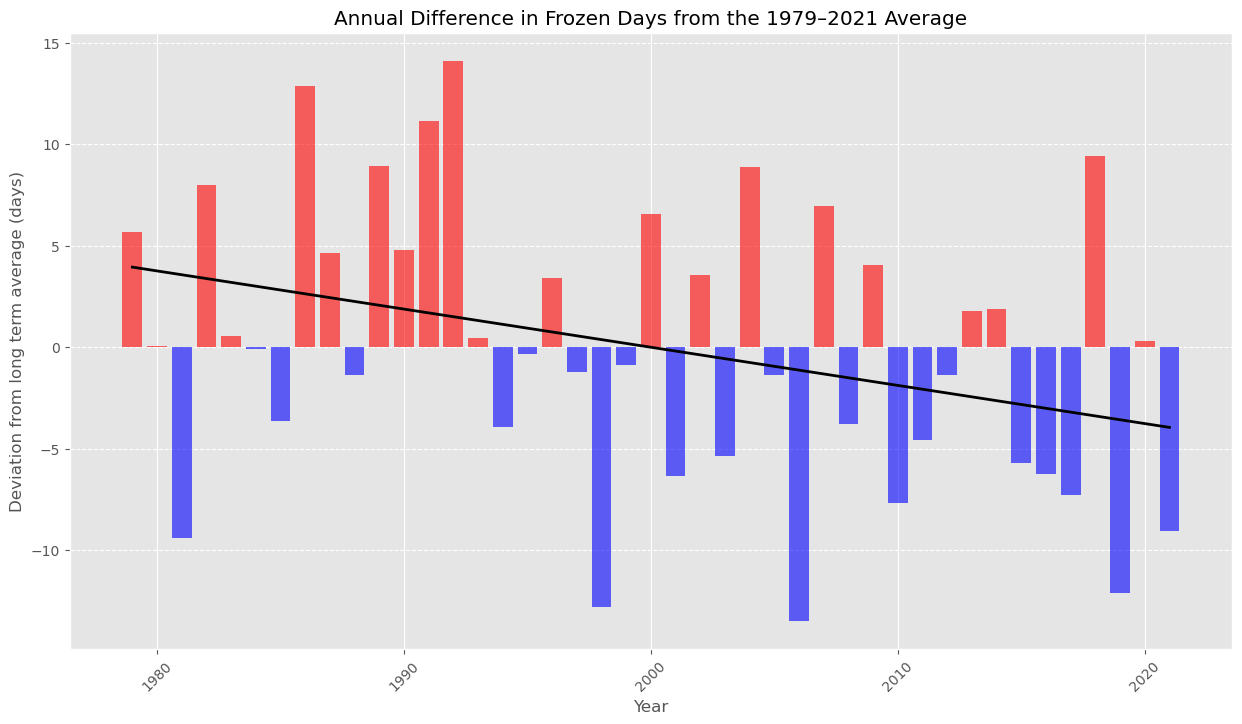

m               -0.159343
b              318.685141
r2              -0.278463
std_err          0.085831
p_value          0.070584
MK_trend         no trend
MK_p_value       0.059595
MK_z            -1.883776
MK_tau          -0.200443
MK_s               -181.0
MK_var_s      9130.333333
MK_h                False
dtype: object
-4.761904761904734


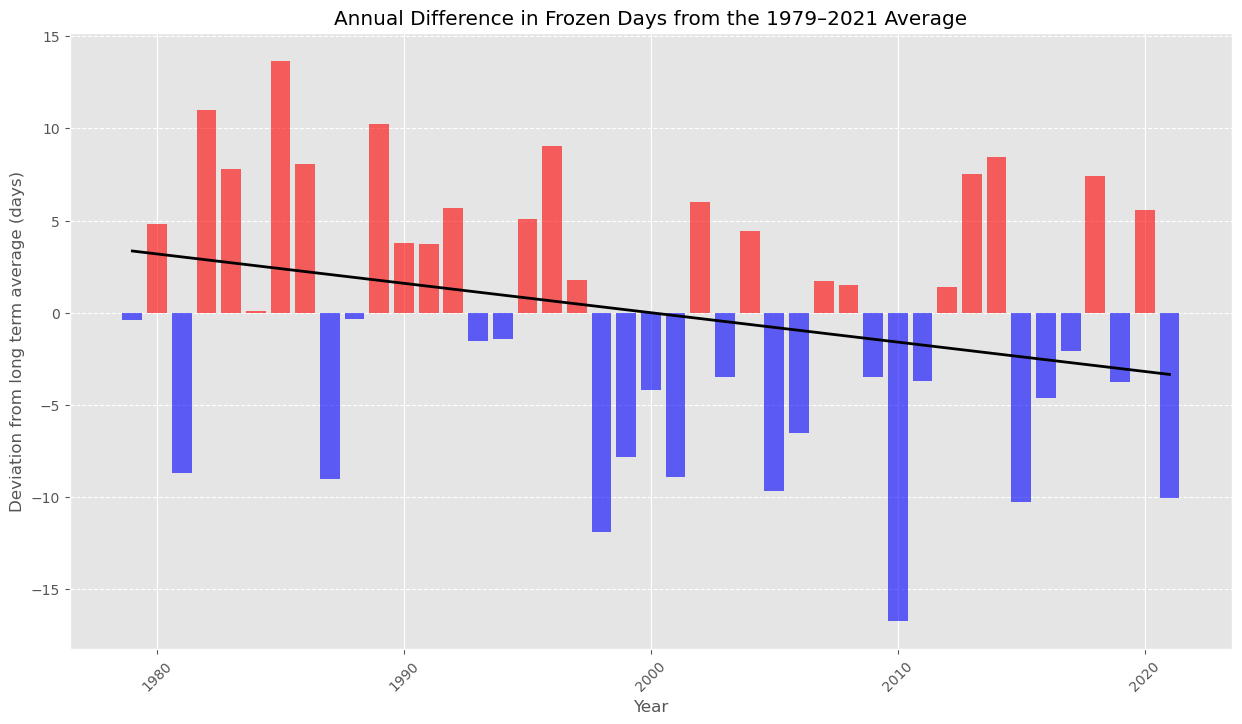

m               -0.153204
b              306.408218
r2              -0.291602
std_err          0.078486
p_value          0.057791
MK_trend         no trend
MK_p_value       0.131805
MK_z            -1.507021
MK_tau          -0.160576
MK_s               -145.0
MK_var_s      9130.333333
MK_h                False
dtype: object
-4.761904761904737


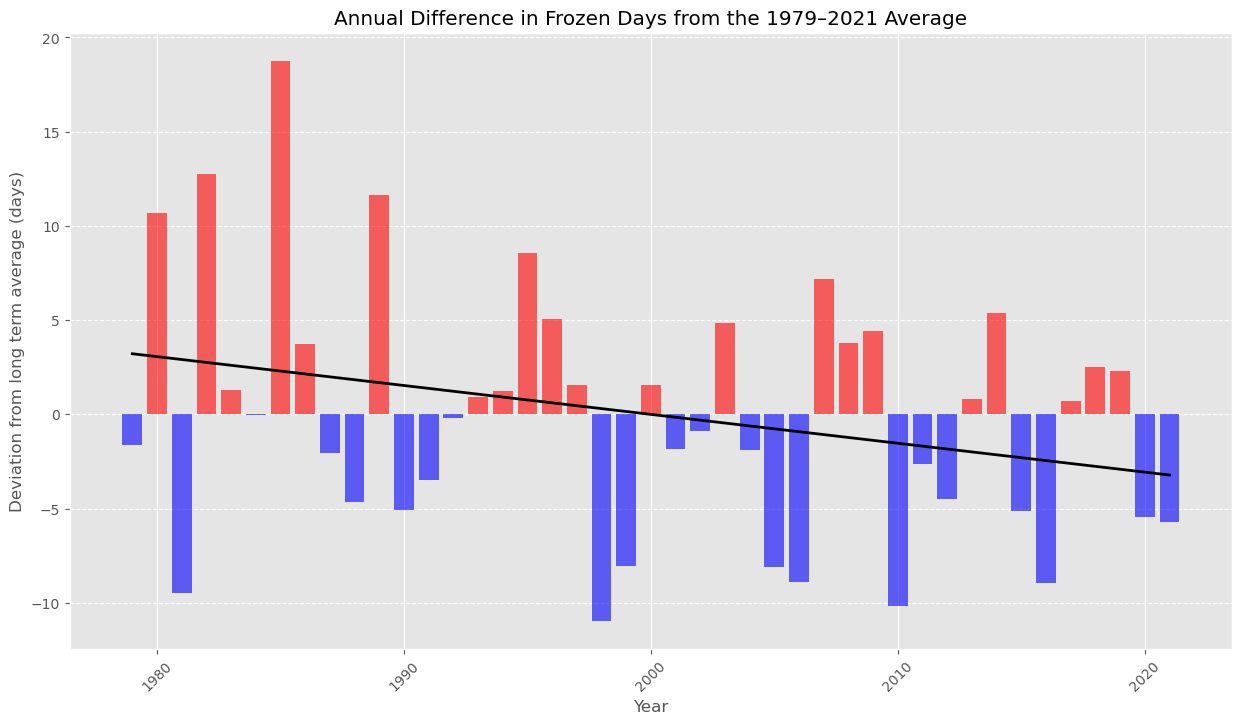

m               -0.163555
b              327.110888
r2              -0.173777
std_err          0.144751
p_value          0.265083
MK_trend         no trend
MK_p_value       0.249652
MK_z            -1.151196
MK_tau          -0.122924
MK_s               -111.0
MK_var_s      9130.333333
MK_h                False
dtype: object
-4.761904761904763


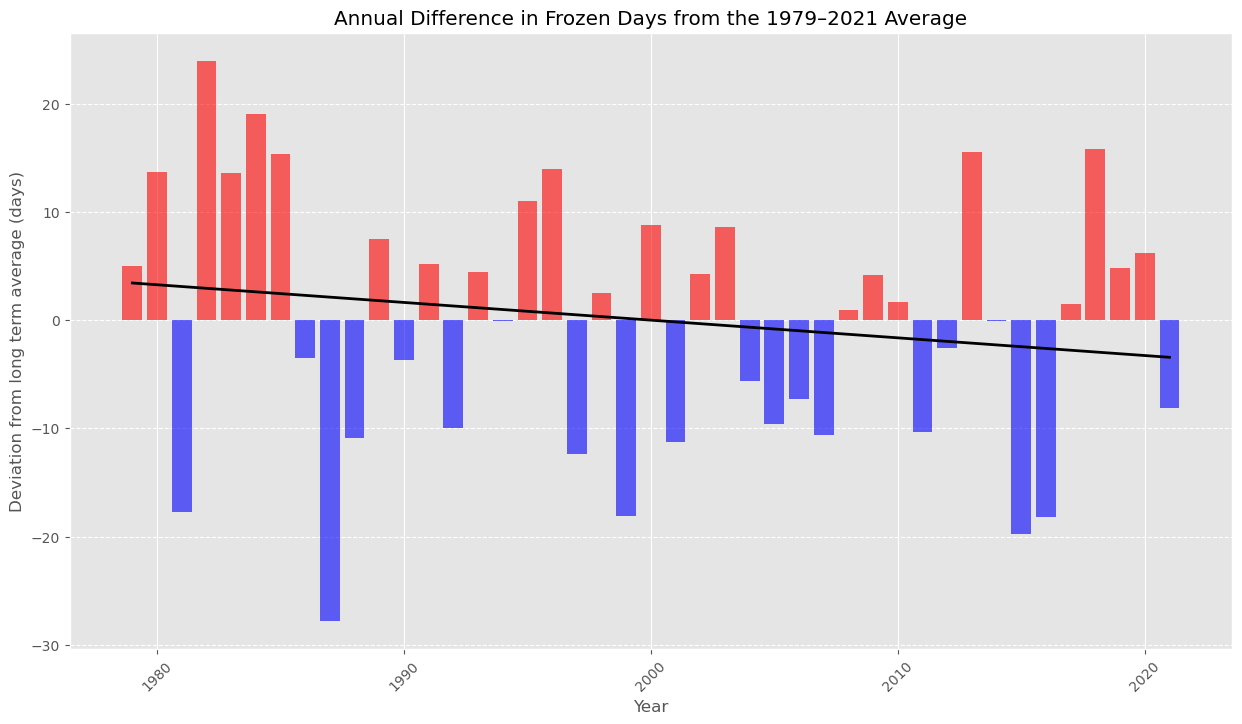

'\nThis figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.\nFor each year, the bar represents the number of days shorter or longer than average.\nPositive numbers represent years with more unfrozen days than average.\nChoosing a different long-term average for comparison would not change the shape of the data over time.\n'

In [41]:
i=1


for dataframe in [tundra, boreal, forest, praires]:
    for soil_state in ['Frozen']:
        
        annual_mean_days = dataframe['{}'.format(soil_state)]

        # Step 2: Calculate the 1979-2021 Average
        long_term_average_days = dataframe['{}'.format(soil_state)].mean()

        # Step 3: Calculate Difference from Average
        difference_from_average = annual_mean_days - long_term_average_days

        mk_result = mk.original_test(difference_from_average)



        # Calculate Linear Regression for Trend Line
        # Converting index to a suitable format for linregress, assuming index is year and is numeric
        x = difference_from_average.index.astype(int)  # Years
        y = difference_from_average.values  # Difference from average

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Calculate the values of the trend line
        trend_line = intercept + slope * x

        # Generate values for the trend line
        x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
        y_line = intercept + slope * x_line


        # Constructing a Series to include various results from MK test and regression
        results = pd.Series({
            'm': slope,
            'b': intercept,
            'r2': r_value,
            'std_err': std_err,
            'p_value': p_value,
            'MK_trend': mk_result.trend,
            'MK_p_value': mk_result.p,
            'MK_z': mk_result.z,
            'MK_tau': mk_result.Tau,
            'MK_s': mk_result.s,
            'MK_var_s': mk_result.var_s,
            'MK_h': mk_result.h
        })

        print(results)

        # Calculate the trend line's percentage increase per year
        percent_per_year = (slope / (intercept + slope * 1979)) * 100

        print(percent_per_year )

        # Step 4: Plot
        plt.figure(figsize=(15, 8))  # Adjusts the size of the figure
        # difference_from_average.plot(kind='bar', color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))
        # plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at y=0 for reference

        # Bar chart
        plt.bar(x, y, label='Difference from Average', alpha=0.6, color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))

        # Trend line
        plt.plot(x_line, y_line, color='black', linewidth=2, label='Trend Line')


        plt.title('Annual Difference in {} Days from the 1979–2021 Average'.format(soil_state))
        plt.xlabel('Year')
        plt.ylabel('Deviation from long term average (days)')
        plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
        plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis

        output_path_for_figure = r'C:\Users\salma\OneDrive - UQAM\canada-climate2024-soil-freezethaw\output\illustrator'
        i = i+1
        name_file = "{}_{}".format(soil_state, str(i))
        plt.savefig(output_path_for_figure + '\\'+ name_file+'_EPA.pdf')
        plt.show()


'''
This figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.
For each year, the bar represents the number of days shorter or longer than average.
Positive numbers represent years with more unfrozen days than average.
Choosing a different long-term average for comparison would not change the shape of the data over time.
'''

### simple

In [42]:
from matplotlib import style 
  
print(plt.style.available)

plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


boreal
Percent increase in Frozen days compared to 1979 in boreal: -7.127587975296504 %
-9.66008741012267
-6.692387963120041
Percent Increse: -1.1442321583090935
{'m': -0.15934257055047615, 'b': 454.59615064524587, 'r2': -0.27846250065587697, 'std_err': 0.08583148416517997, 'p_value': 0.0705840171382001, 'MK_trend': 'no trend', 'MK_p_value': 0.05959532291256653, 'MK_z': -1.8837756919498025, 'MK_tau': -0.20044296788482835, 'MK_s': -181.0, 'MK_var_s': 9130.333333333334, 'MK_h': False, 'percent_change_1979': -7.127587975296504}
-0.11442321583090935


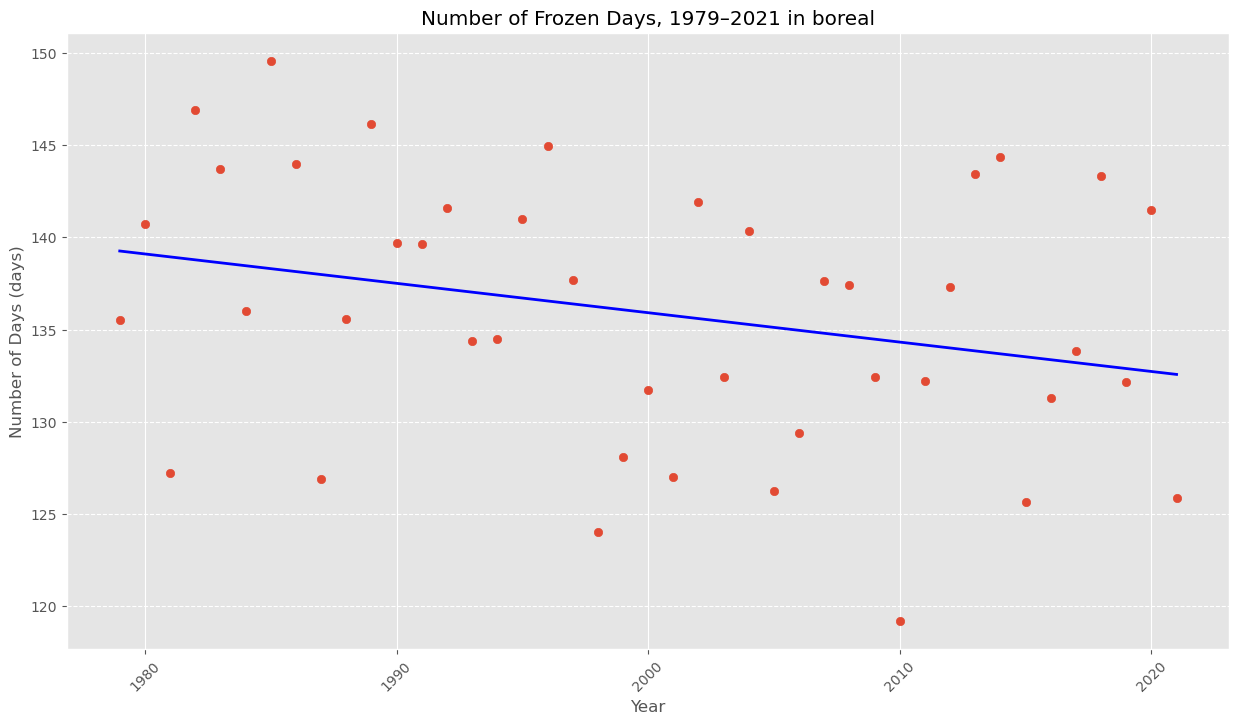

tundra
Percent increase in Frozen days compared to 1979 in tundra: -6.611045328612319 %
-14.717210492642351
-7.893447711954195
Percent Increse: -0.8507879447955647
{'m': -0.18793923123700412, 'b': 592.8319434066215, 'r2': -0.34184520920012834, 'std_err': 0.08068842777947607, 'p_value': 0.024855308396963812, 'MK_trend': 'decreasing', 'MK_p_value': 0.020161788172325723, 'MK_z': -2.3233233534047564, 'MK_tau': -0.2469545957918051, 'MK_s': -223.0, 'MK_var_s': 9130.333333333334, 'MK_h': True, 'percent_change_1979': -6.611045328612319}
-0.08507879447955648


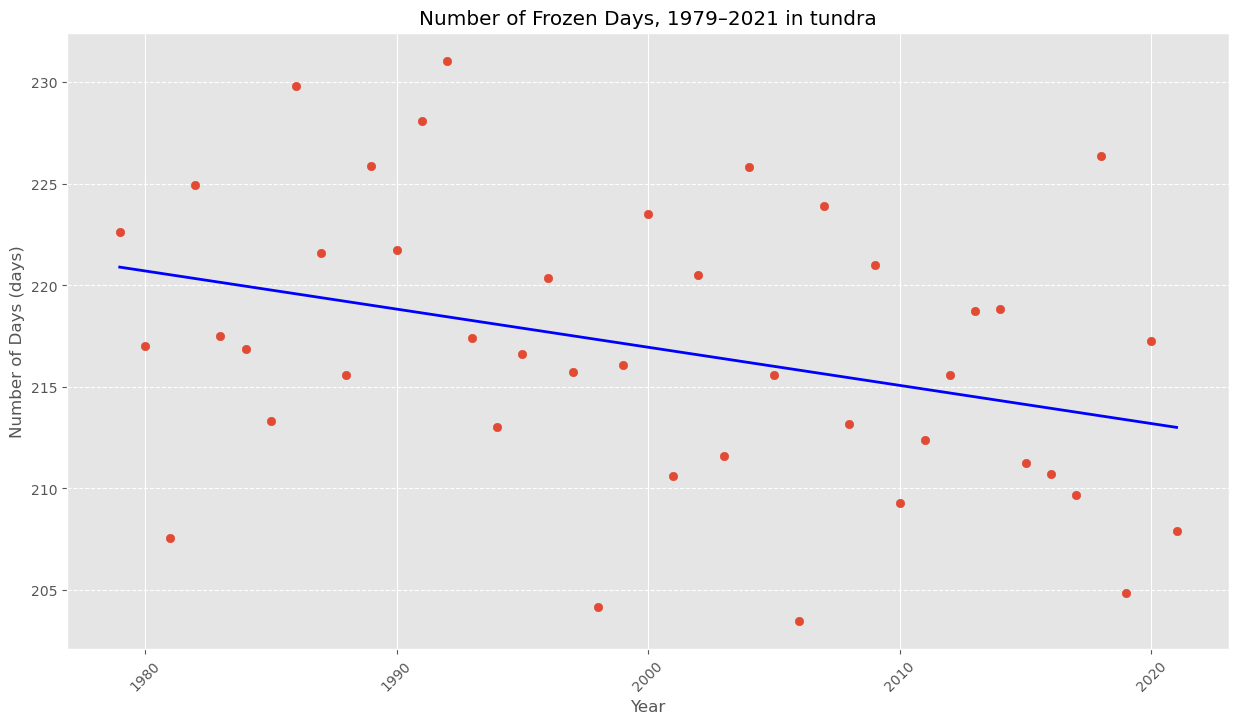

forest
Percent increase in Frozen days compared to 1979 in forest: -4.93634088901972 %
-4.108728943338434
-6.434572585788828
Percent Increse: -1.7395420328423463
{'m': -0.1532041091854475, 'b': 391.26245107148975, 'r2': -0.29160230422738115, 'std_err': 0.07848569523472754, 'p_value': 0.05779071506416762, 'MK_trend': 'no trend', 'MK_p_value': 0.13180538892839122, 'MK_z': -1.507020553559842, 'MK_tau': -0.16057585825027684, 'MK_s': -145.0, 'MK_var_s': 9130.333333333334, 'MK_h': False, 'percent_change_1979': -4.93634088901972}
-0.17395420328423464


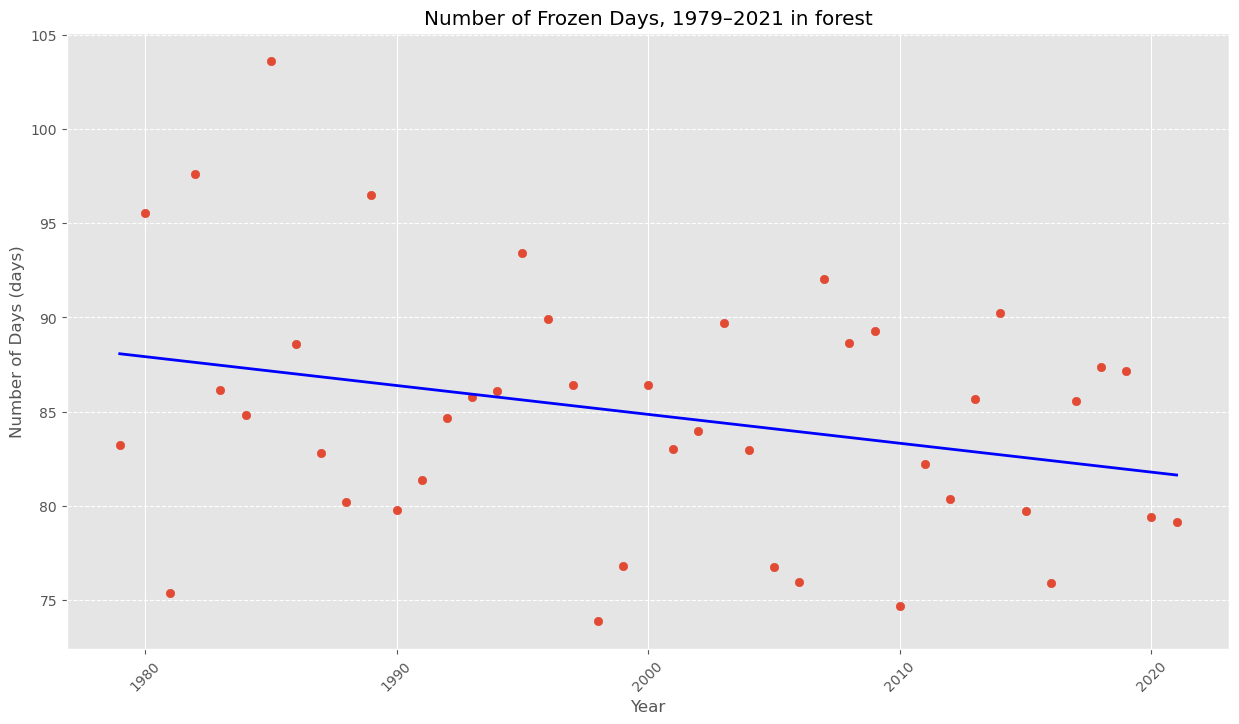

praires
Percent increase in Frozen days compared to 1979 in praires: -13.684832567301372 %
-13.108176100628924
-6.869328652917943
Percent Increse: -1.7361031789478432
{'m': -0.16355544411709394, 'b': 417.88459015023295, 'r2': -0.17377692423655935, 'std_err': 0.1447512803861218, 'p_value': 0.26508267369434796, 'MK_trend': 'no trend', 'MK_p_value': 0.24965150506915368, 'MK_z': -1.151196256191546, 'MK_tau': -0.12292358803986711, 'MK_s': -111.0, 'MK_var_s': 9130.333333333334, 'MK_h': False, 'percent_change_1979': -13.684832567301372}
-0.17361031789478432


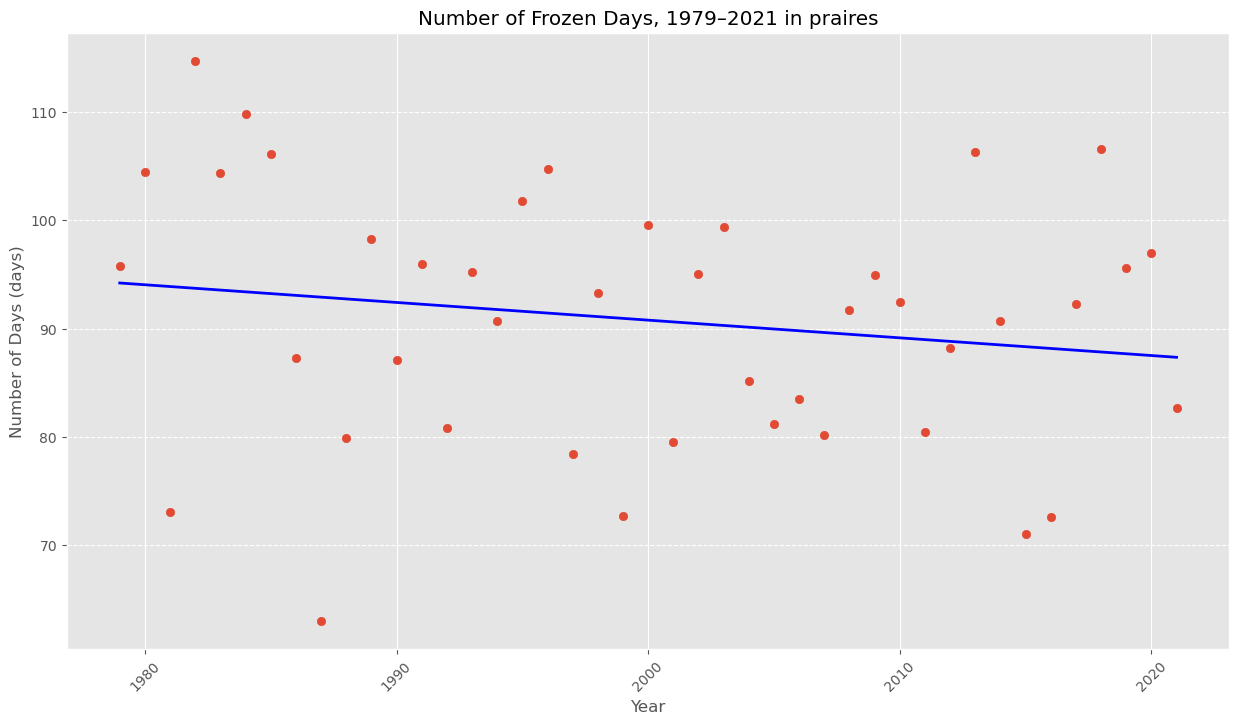

' \nThis figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.\nFor each year, the bar represents the number of days shorter or longer than average.\nPositive numbers represent years with more unfrozen days than average.\nChoosing a different long-term average for comparison would not change the shape of the data over time.'

In [43]:
# Step 1: Calculate the Annual Sum of 'Thawed'
dataframes = {'boreal':boreal, 'tundra':tundra,  'forest':forest, 'praires':praires}


veg_cover_info = {'boreal':{'Frozen':{}, 'Thawed':{}, 'Transition':{}},
                   'tundra':{'Frozen':{}, 'Thawed':{}, 'Transition':{}},
                    'forest':{'Frozen':{}, 'Thawed':{}, 'Transition':{}},
                      'praires':{'Frozen':{}, 'Thawed':{}, 'Transition':{}}}

for name, dataframe in dataframes.items():
    print(name)
    for soil_state in ['Frozen']:
        
        # Calculate Linear Regression for Trend Line
        # Converting index to a suitable format for linregress, assuming index is year and is numeric
        x = dataframe.index.astype(int)  # Years
        y = dataframe['{}'.format(soil_state)].values  # Difference from average

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Calculate the values of the trend line
        trend_line = intercept + slope * x

        # Generate values for the trend line
        x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
        y_line = intercept + slope * x_line


        mk_result = mk.original_test(y)





        # Calculate the percent increase compared to 1979
        percent_change_1979 = (y[-1] - y[0]) / y[0] * 100

        # Print the results
        print("Percent increase in {} days compared to 1979 in {}:".format(soil_state, name), percent_change_1979, "%")
        print(y[-1] - y[0])
        print((intercept + slope * 2021) - (intercept + slope * 1979) )

        print("Percent Increse:" , (slope/(intercept + slope * 1979))*1000)

        # Constructing a Series to include various results from MK test and regression
        results = {
            'm': slope,
            'b': intercept,
            'r2': r_value,
            'std_err': std_err,
            'p_value': p_value,
            'MK_trend': mk_result.trend,
            'MK_p_value': mk_result.p,
            'MK_z': mk_result.z,
            'MK_tau': mk_result.Tau,
            'MK_s': mk_result.s,
            'MK_var_s': mk_result.var_s,
            'MK_h': mk_result.h,
            'percent_change_1979':  percent_change_1979
        }

        print(results)

        
        veg_cover_info[name][soil_state].update(results)

        # Calculate the trend line's percentage increase per year
        percent_per_year = (slope / (intercept + slope * 1979)) * 100

        print(percent_per_year )

        # Step 4: Plot
        plt.figure(figsize=(15, 8))  # Adjusts the size of the figure
        # difference_from_average.plot(kind='bar', color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))
        # plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at y=0 for reference

        # Bar chart
        plt.scatter(x, y, label='', )

        # Trend line
        plt.plot(x_line, y_line, color='Blue', linewidth=2, label='Trend Line')


        plt.title('Annual Difference in {} Days from the 1979–2021 Average in {}'.format(soil_state, name))
        plt.title('Number of {} Days, 1979–2021 in {}'.format(soil_state, name))
        plt.xlabel('Year')
        plt.ylabel('Number of Days (days)')
        plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
        plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis
        # # Get the current axes
        # ax = plt.gca()
        # # Hide the x-axis tick labels
        # ax.set_xticklabels([])
        # ax.set_yticklabels([])

        output_path_for_figure = r'C:\Users\salma\OneDrive - UQAM\canada-climate2024-soil-freezethaw\output\illustrator'
        name_file = "{}_{}".format(soil_state, name)
        plt.savefig(output_path_for_figure + '\\'+ name_file+'.pdf')
        plt.show()


''' 
This figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.
For each year, the bar represents the number of days shorter or longer than average.
Positive numbers represent years with more unfrozen days than average.
Choosing a different long-term average for comparison would not change the shape of the data over time.'''

In [161]:
veg_cover_info

{'boreal': {'Frozen': {'m': -0.15934257055047615,
   'b': 454.59615064524587,
   'r2': -0.27846250065587697,
   'std_err': 0.08583148416517997,
   'p_value': 0.07058401713820009,
   'MK_trend': 'no trend',
   'MK_p_value': 0.05959532291256653,
   'MK_z': -1.8837756919498025,
   'MK_tau': -0.20044296788482835,
   'MK_s': -181.0,
   'MK_var_s': 9130.333333333334,
   'MK_h': False,
   'percent_change_1979': -7.127587975296504},
  'Thawed': {'m': 0.06973708195679414,
   'b': 40.40049141315049,
   'r2': 0.12138360956991688,
   'std_err': 0.08906120095457074,
   'p_value': 0.4381125635510935,
   'MK_trend': 'no trend',
   'MK_p_value': 0.35707287482858807,
   'MK_z': 0.9209570049532368,
   'MK_tau': 0.09856035437430787,
   'MK_s': 89.0,
   'MK_var_s': 9130.333333333334,
   'MK_h': False,
   'percent_change_1979': 6.054991252416174},
  'Transition': {'m': 0.08960548859368202,
   'b': -129.74082810490802,
   'r2': 0.23406051184955134,
   'std_err': 0.05812727870852975,
   'p_value': 0.13086924

C:\Users\salma\AppData\Local\Temp\ipykernel_4268\1877932555.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(veg_cover_info_df.applymap(lambda x: x['m']), fmt=".3f", cmap=cmap, cbar_kws={'label': 'Slope (m)'}, center=0)
C:\Users\salma\AppData\Local\Temp\ipykernel_4268\1877932555.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  plt.text(j+0.5, i+0.5, f"{veg_cover_info_df.applymap(lambda x: x['r2']).iloc[i,j]:.2f}", ha='center', va='center', color='black')


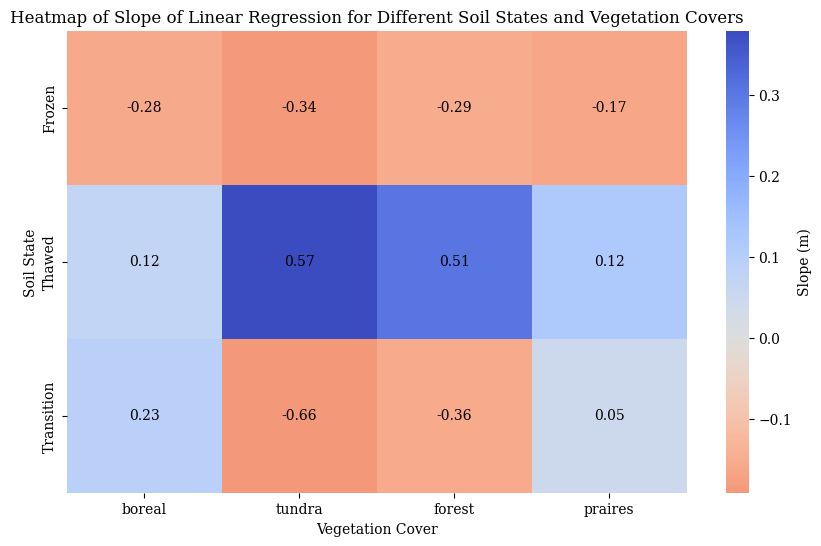

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame
veg_cover_info_df = pd.DataFrame(veg_cover_info)

# Reverse the current colormap (coolwarm) to have positive values in blue and negative values in red
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = cmap.reversed()

# Plot heatmap with reversed color map
plt.figure(figsize=(10, 6))
sns.heatmap(veg_cover_info_df.applymap(lambda x: x['m']), fmt=".3f", cmap=cmap, cbar_kws={'label': 'Slope (m)'}, center=0)
# Annotate each tile with m and p-value
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        # plt.text(j, i, f"{color_matrix[i, j]:.2f}", ha='center', va='center', color='black')
        # plt.text(j, i, f"{p_value_matrix[i, j]:.3f}", ha='center', va='center', color='black')
        plt.text(j+0.5, i+0.5, f"{veg_cover_info_df.applymap(lambda x: x['r2']).iloc[i,j]:.2f}", ha='center', va='center', color='black')

plt.title('Heatmap of Slope of Linear Regression for Different Soil States and Vegetation Covers')
plt.xlabel('Vegetation Cover')
plt.ylabel('Soil State')
plt.savefig('.veg_cover_.pdf')
plt.show()


## monthly

In [124]:
#Boreal
# Step 1: Calculate the Annual Sum of 'Thawed'
annual_mean_days = Boreal.groupby(['Year', 'Month'])['{}'.format(soil_state)].mean()


# Dictionary mapping month numbers to their corresponding abbreviated names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Create an empty dictionary with keys as month names and empty lists as values
month_dict = {month_names[month_num]: [] for month_num in range(1, 13)}



for i in range (1979, 2022):
    for key in month_names.keys():
        month_dict[month_names[key]].append(annual_mean_days.loc[(i, key)])

# Print the created dictionary
print(month_dict)


monthly_Boreal = pd.DataFrame(month_dict)
monthly_Boreal['Year'] = np.arange(1979,2022,1)


#Tundra
# Step 1: Calculate the Annual Sum of 'Thawed'
annual_mean_days = Tundra.groupby(['Year', 'Month'])['{}'.format(soil_state)].mean()


# Dictionary mapping month numbers to their corresponding abbreviated names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Create an empty dictionary with keys as month names and empty lists as values
month_dict = {month_names[month_num]: [] for month_num in range(1, 13)}



for i in range (1979, 2022):
    for key in month_names.keys():
        month_dict[month_names[key]].append(annual_mean_days.loc[(i, key)])

# Print the created dictionary
print(month_dict)


monthly_Tundra = pd.DataFrame(month_dict)
monthly_Tundra['Year'] = np.arange(1979,2022,1)


#Forest

# Step 1: Calculate the Annual Sum of 'Thawed'
annual_mean_days = Forest.groupby(['Year', 'Month'])['{}'.format(soil_state)].mean()


# Dictionary mapping month numbers to their corresponding abbreviated names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Create an empty dictionary with keys as month names and empty lists as values
month_dict = {month_names[month_num]: [] for month_num in range(1, 13)}



for i in range (1979, 2022):
    for key in month_names.keys():
        month_dict[month_names[key]].append(annual_mean_days.loc[(i, key)])

# Print the created dictionary
print(month_dict)


monthly_Forest = pd.DataFrame(month_dict)
monthly_Forest['Year'] = np.arange(1979,2022,1)


#Prairie
# Step 1: Calculate the Annual Sum of 'Thawed'
annual_mean_days = Praires.groupby(['Year', 'Month'])['{}'.format(soil_state)].mean()


# Dictionary mapping month numbers to their corresponding abbreviated names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Create an empty dictionary with keys as month names and empty lists as values
month_dict = {month_names[month_num]: [] for month_num in range(1, 13)}



for i in range (1979, 2022):
    for key in month_names.keys():
        month_dict[month_names[key]].append(annual_mean_days.loc[(i, key)])

# Print the created dictionary
print(month_dict)


monthly_Praires = pd.DataFrame(month_dict)
monthly_Praires['Year'] = np.arange(1979,2022,1)

{'Jan': [29.417030875511067, 28.973494995065558, 29.198928521077118, 30.524460735936838, 29.877202876075003, 29.4999295079656, 29.721274495981955, 29.91258987734386, 28.655857888058648, 29.165233328633864, 29.67573664175948, 29.590864232341744, 30.191174397293107, 28.835471591710135, 29.826871563513322, 30.623008600028196, 30.16706612152827, 29.922599746228677, 30.00662625123361, 30.196390807838714, 29.882701254758214, 30.14352178203863, 29.559988721274497, 28.763710700690822, 29.334132243056533, 30.48639503736078, 30.030593542929648, 27.602142957845764, 28.635133229945016, 29.271535316509233, 29.978852389679965, 28.602847878189763, 29.26913858733963, 29.052869025800085, 29.23685323558438, 28.939658818553504, 29.46313266600874, 28.79359932327647, 27.15085295361624, 29.598054419850556, 29.76286479627802, 29.47032285351755, 28.466516283659946], 'Feb': [27.593119977442548, 28.71366135626674, 24.254617228253206, 27.64979557310024, 27.121246299168195, 26.61906104610179, 27.34329620752855, 2

### simple

Jan
0.009837939144282043 0.014712731365977751 0.0049631469225863345
m                0.009838
b               10.977606
r2               0.536966
std_err          0.002414
p_value          0.000205
MK_trend       increasing
MK_p_value        0.00715
MK_z              2.68976
MK_tau           0.285714
MK_s                258.0
MK_var_s      9129.333333
MK_h                 True
dtype: object


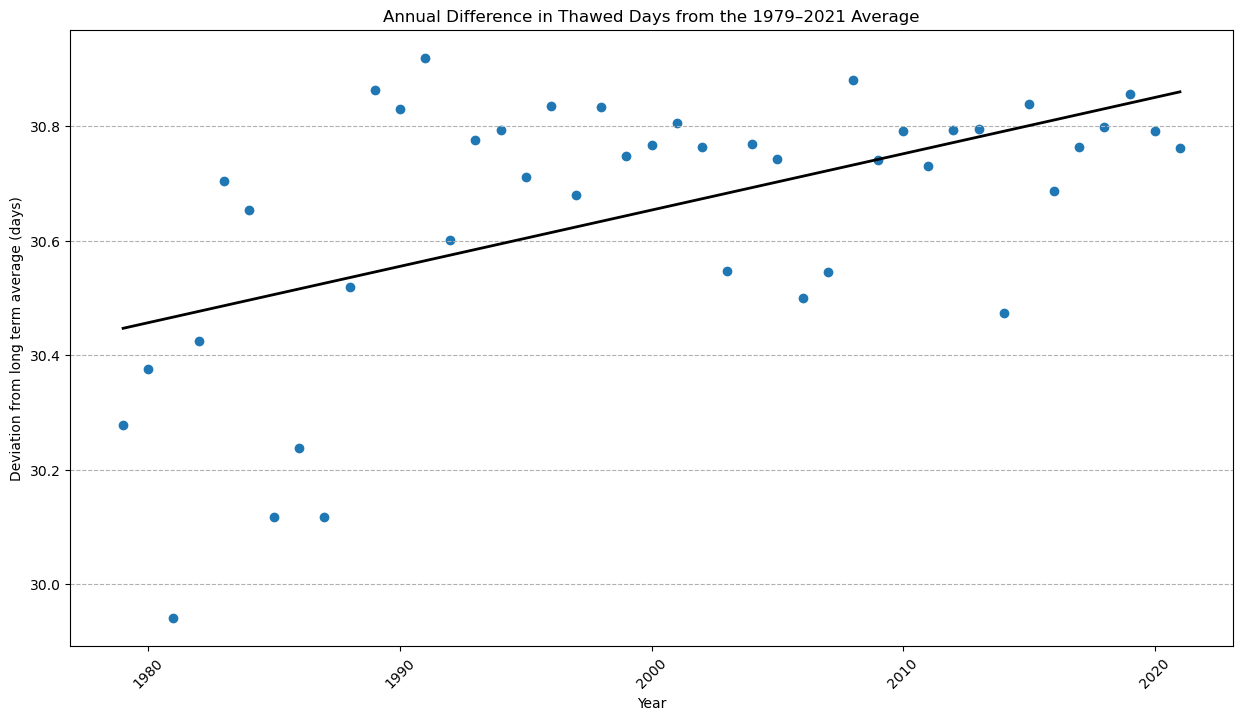

Feb
0.008046570370812654 0.01914201709817253 -0.003048876356547223
m                0.008047
b               11.951221
r2               0.222973
std_err          0.005494
p_value          0.150657
MK_trend       increasing
MK_p_value       0.015183
MK_z             2.427978
MK_tau           0.258029
MK_s                233.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


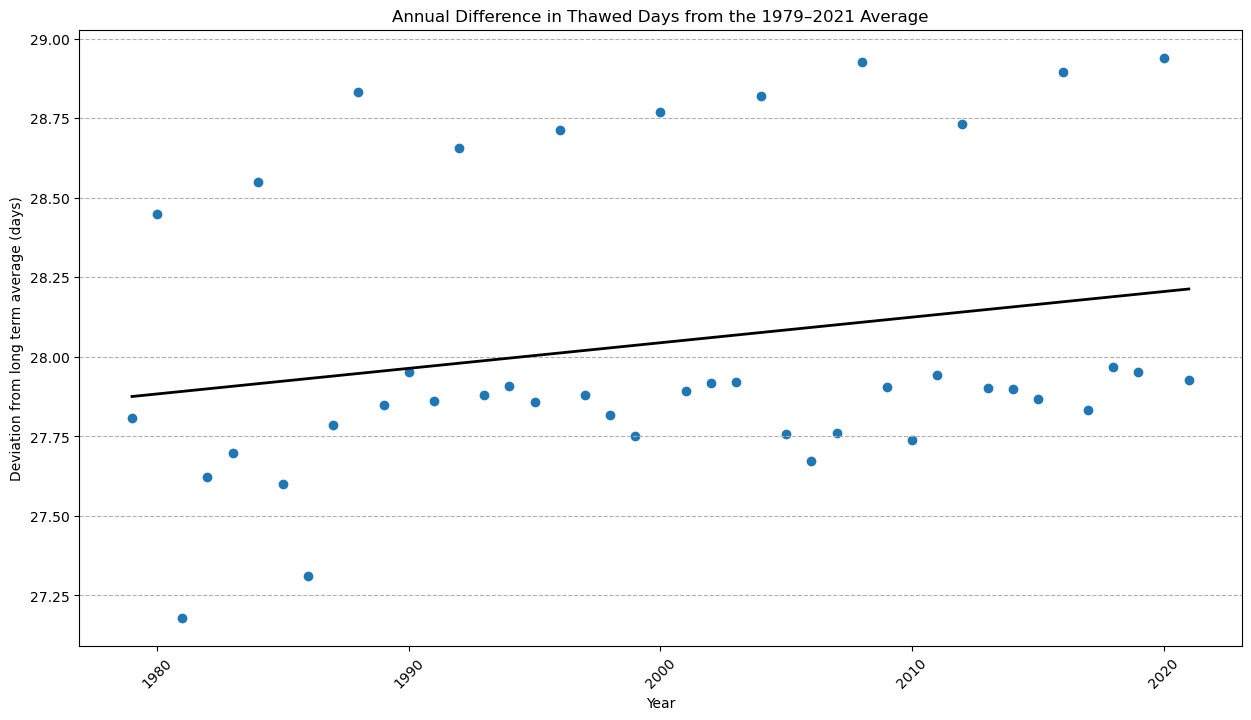

Mar
0.006641668082100185 0.011759126496909859 0.0015242096672905105
m                0.006642
b               17.330741
r2                0.37883
std_err          0.002534
p_value          0.012242
MK_trend       increasing
MK_p_value       0.002092
MK_z             3.076834
MK_tau           0.326689
MK_s                295.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


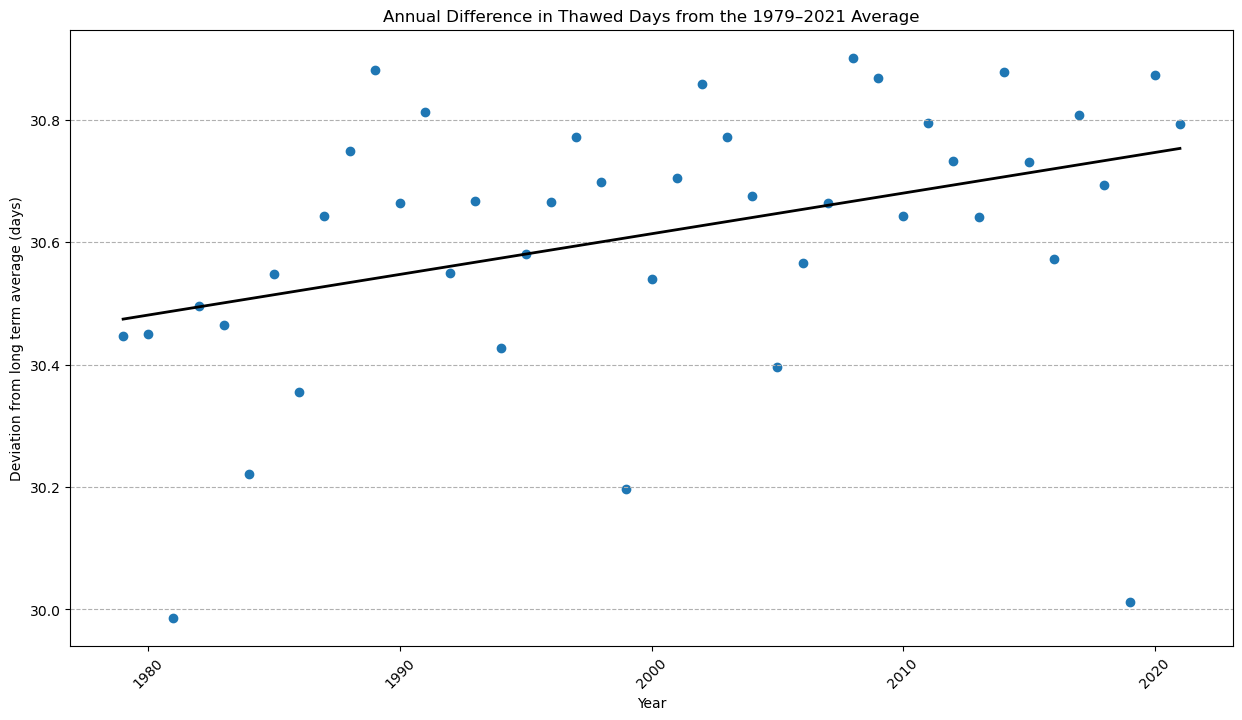

Apr
-0.0026812078546221496 0.016628320533412722 -0.02199073624265702
m               -0.002681
b               33.028056
r2              -0.043753
std_err          0.009561
p_value          0.780564
MK_trend         no trend
MK_p_value       0.883514
MK_z            -0.146516
MK_tau          -0.016611
MK_s                -15.0
MK_var_s      9130.333333
MK_h                False
dtype: object


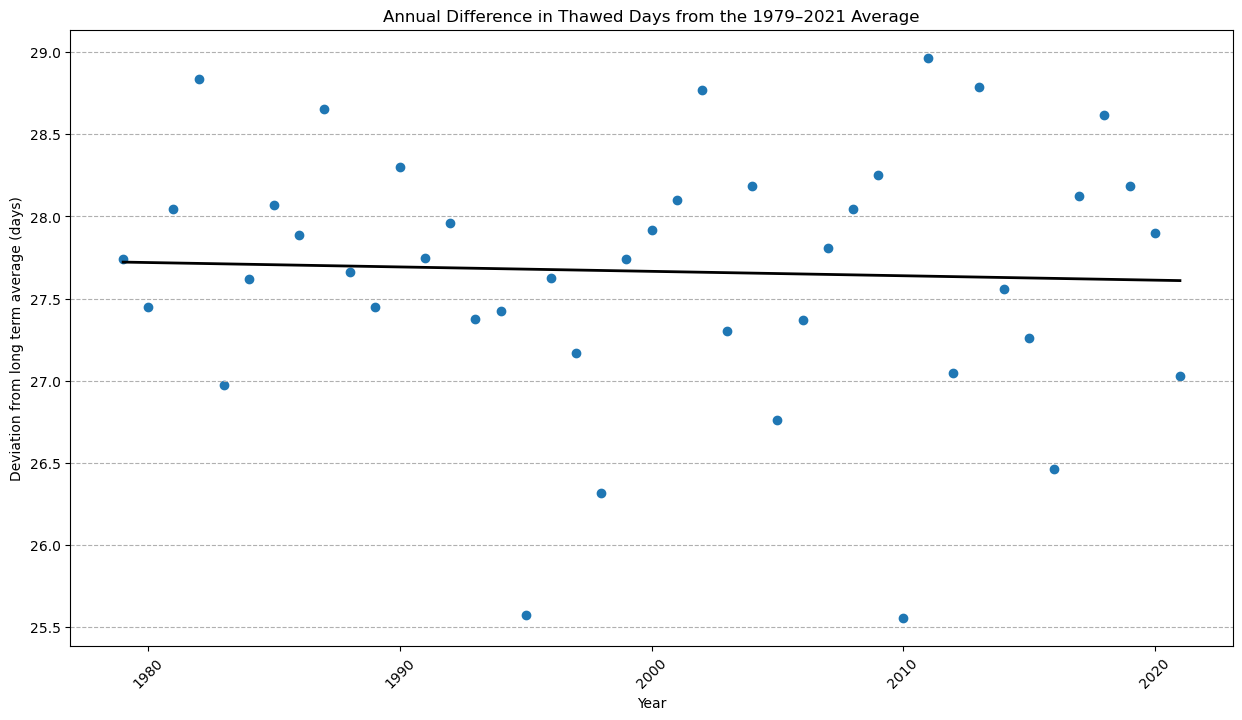

May
-0.04679853096359814 0.024775539603804173 -0.11837260153100045
m               -0.046799
b              113.151363
r2              -0.201973
std_err          0.035441
p_value          0.194002
MK_trend         no trend
MK_p_value       0.187288
MK_z            -1.318643
MK_tau          -0.140642
MK_s               -127.0
MK_var_s      9130.333333
MK_h                False
dtype: object


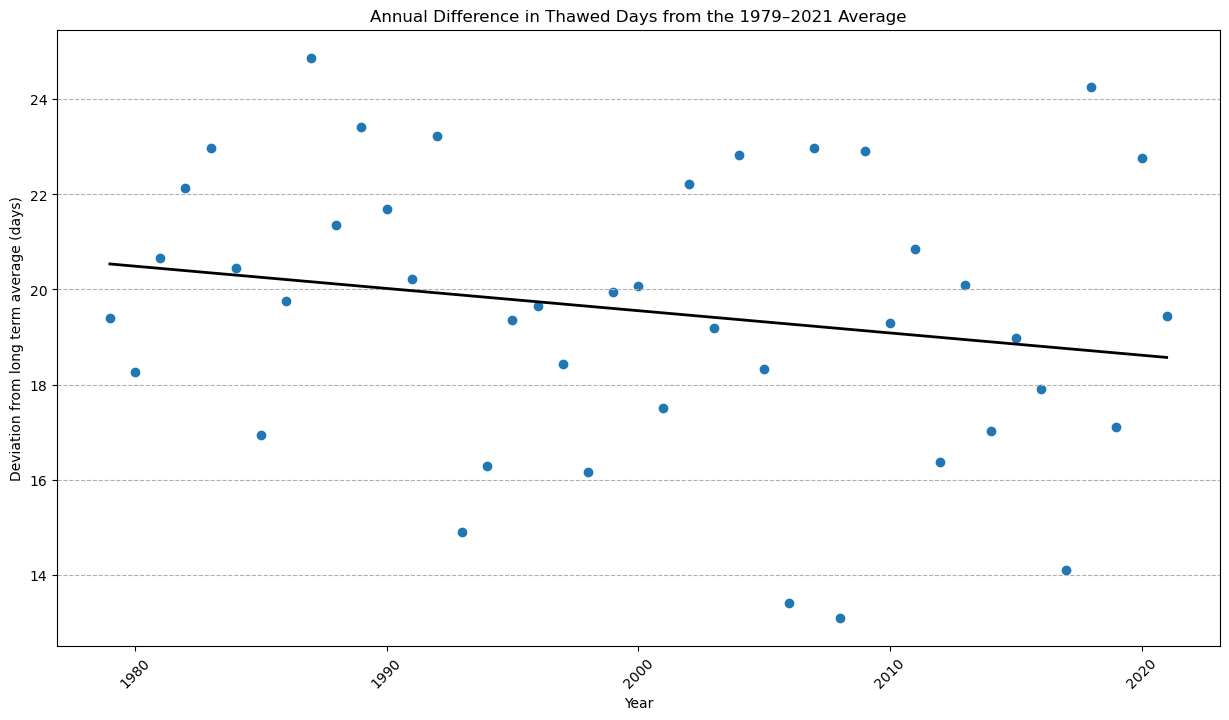

Jun
-0.07163649039737066 -0.03237711034295043 -0.11089587045179089
m               -0.071636
b              145.948367
r2              -0.498802
std_err           0.01944
p_value          0.000663
MK_trend       decreasing
MK_p_value       0.010039
MK_z            -2.574493
MK_tau          -0.273533
MK_s               -247.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


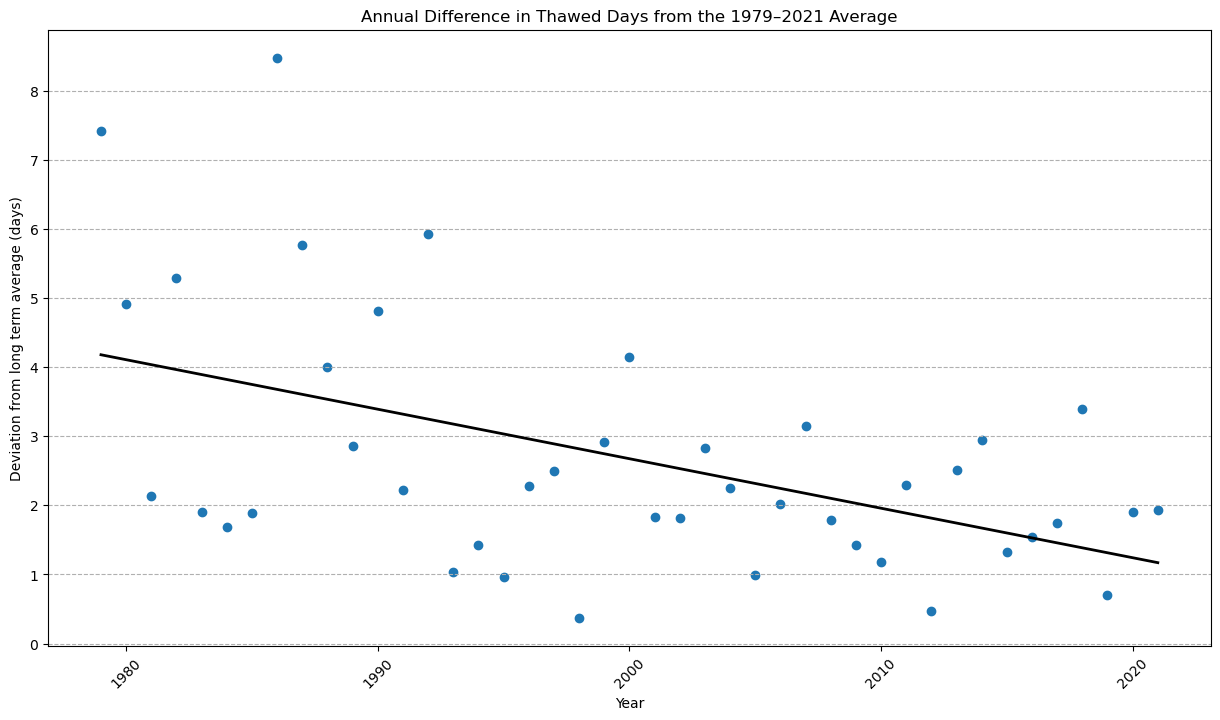

Jul
-0.0022526648313373307 0.0004959416427104033 -0.005001271305385064
m               -0.002253
b                4.799144
r2              -0.250265
std_err          0.001361
p_value          0.105531
MK_trend         no trend
MK_p_value       0.062484
MK_z            -1.862845
MK_tau          -0.198228
MK_s               -179.0
MK_var_s      9130.333333
MK_h                False
dtype: object


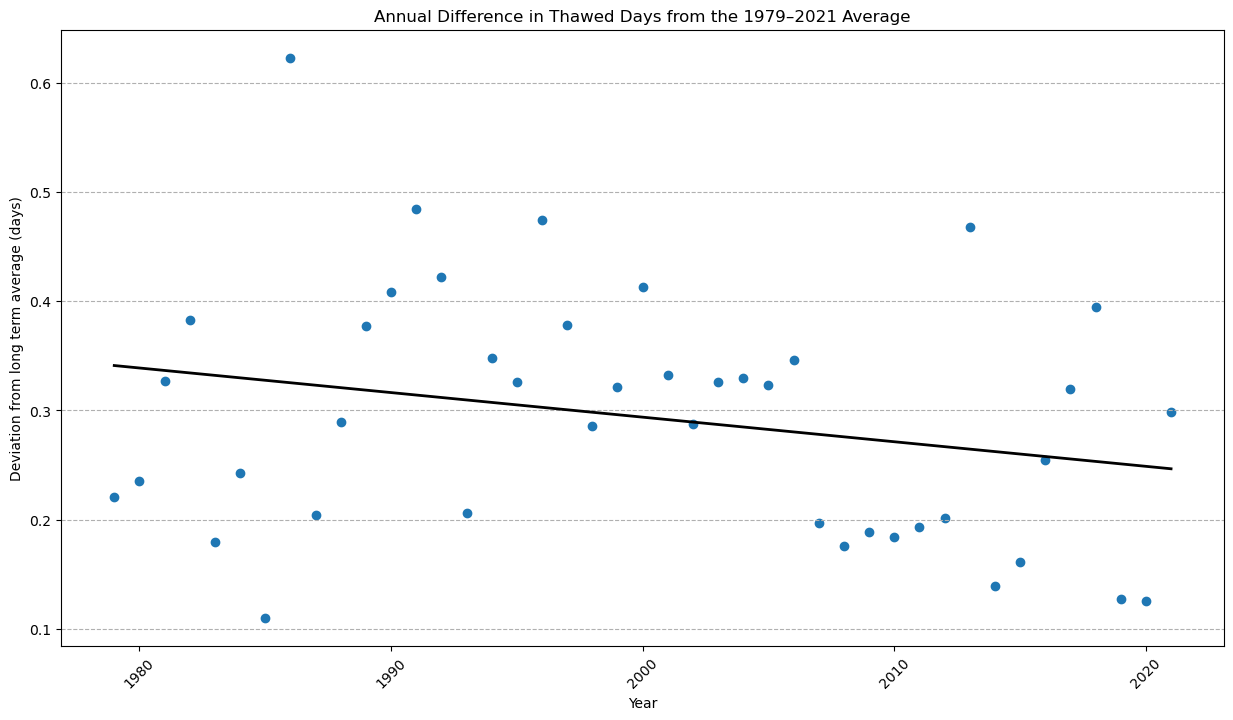

Aug
-0.016531973435066762 -0.007484915435230414 -0.02557903143490311
m               -0.016532
b               34.818868
r2              -0.499343
std_err           0.00448
p_value          0.000652
MK_trend       decreasing
MK_p_value       0.000318
MK_z            -3.600105
MK_tau           -0.38206
MK_s               -345.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


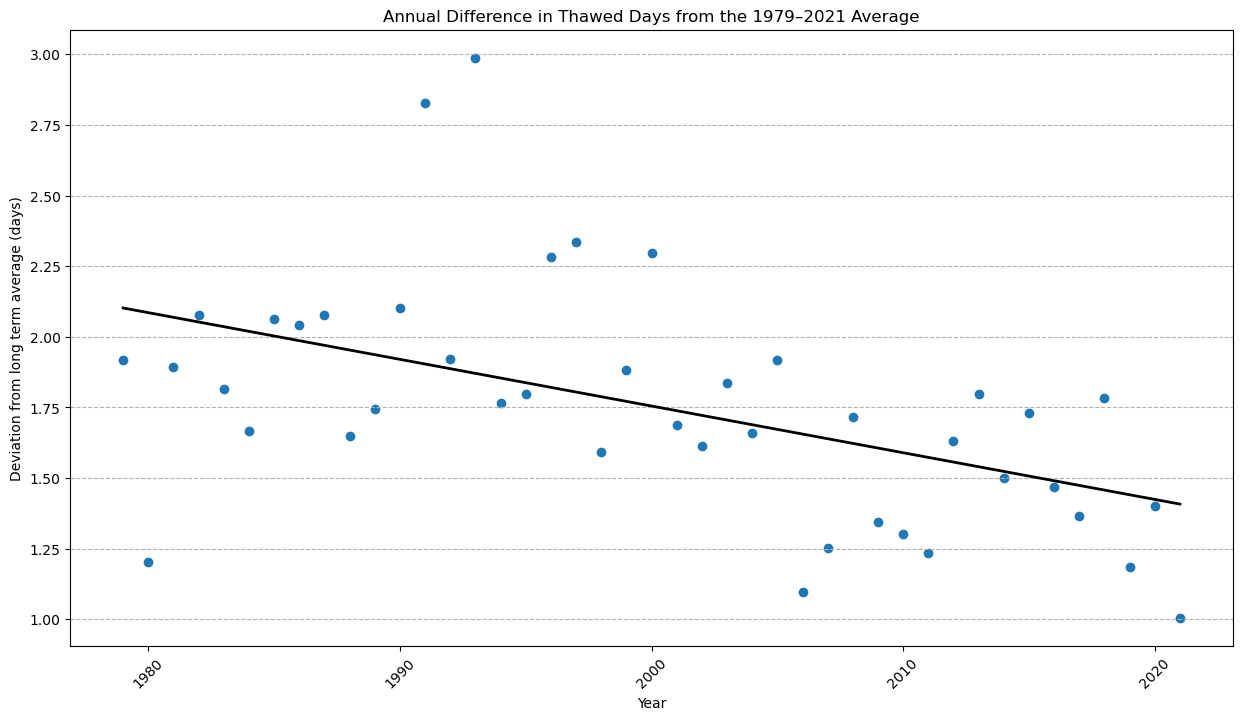

Sep
-0.025819294455191436 0.00014056465566435888 -0.05177915356604723
m               -0.025819
b               57.469653
r2              -0.299311
std_err          0.012854
p_value          0.051196
MK_trend         no trend
MK_p_value       0.062484
MK_z            -1.862845
MK_tau          -0.198228
MK_s               -179.0
MK_var_s      9130.333333
MK_h                False
dtype: object


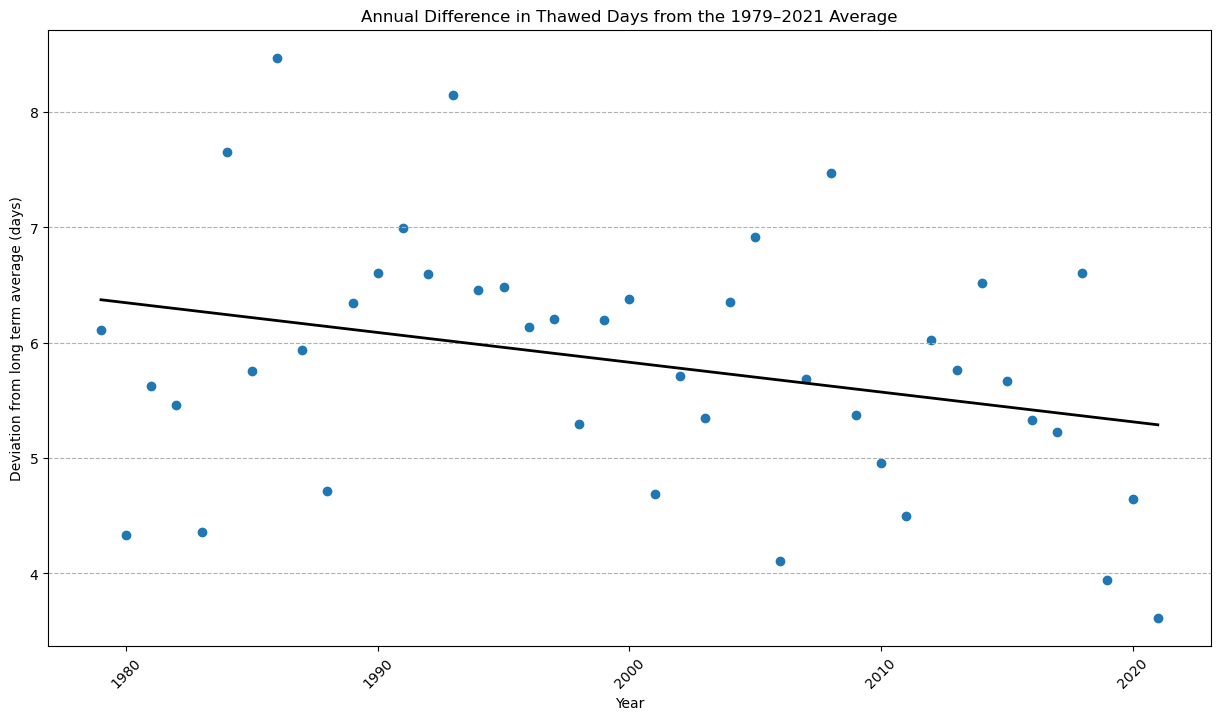

Oct
-0.03370601262624652 0.012416851942358462 -0.0798288771948515
m               -0.033706
b                82.26273
r2              -0.224601
std_err          0.022838
p_value          0.147622
MK_trend         no trend
MK_p_value       0.142878
MK_z            -1.465159
MK_tau          -0.156146
MK_s               -141.0
MK_var_s      9130.333333
MK_h                False
dtype: object


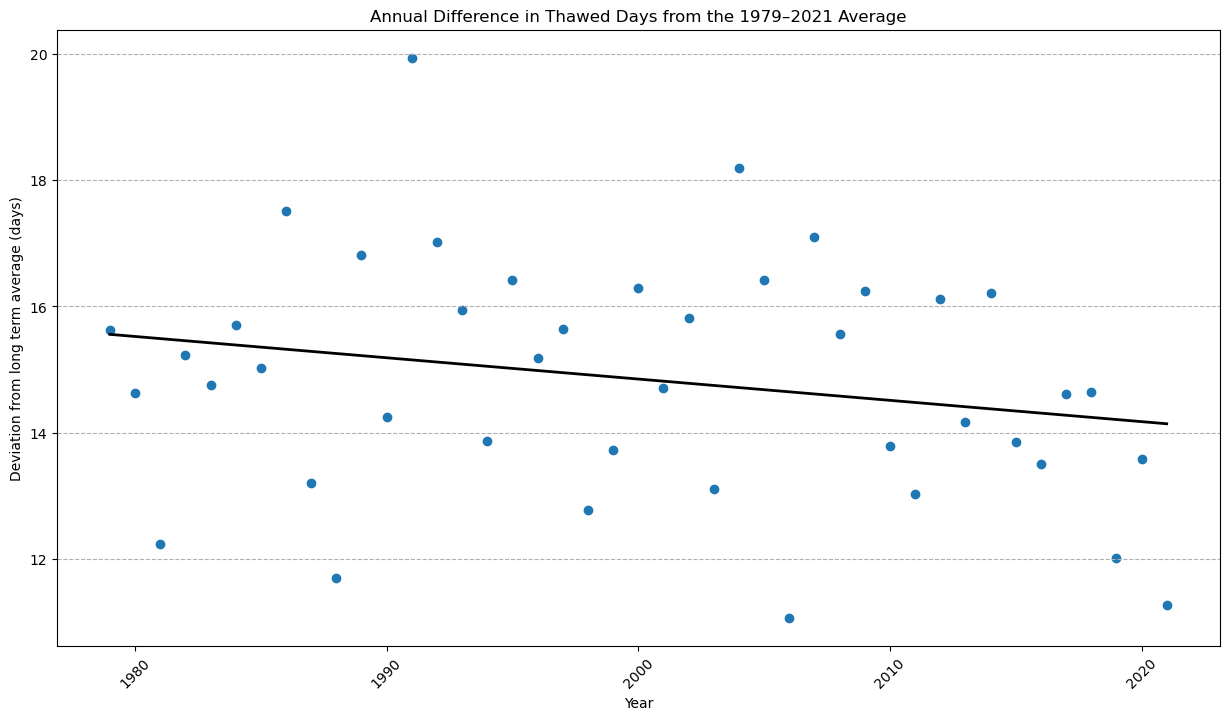

Nov
-0.018382519889014553 0.022531345888930316 -0.059296385666959425
m               -0.018383
b               61.969573
r2              -0.140307
std_err          0.020259
p_value          0.369511
MK_trend         no trend
MK_p_value        0.21686
MK_z             -1.23492
MK_tau          -0.131783
MK_s               -119.0
MK_var_s      9130.333333
MK_h                False
dtype: object


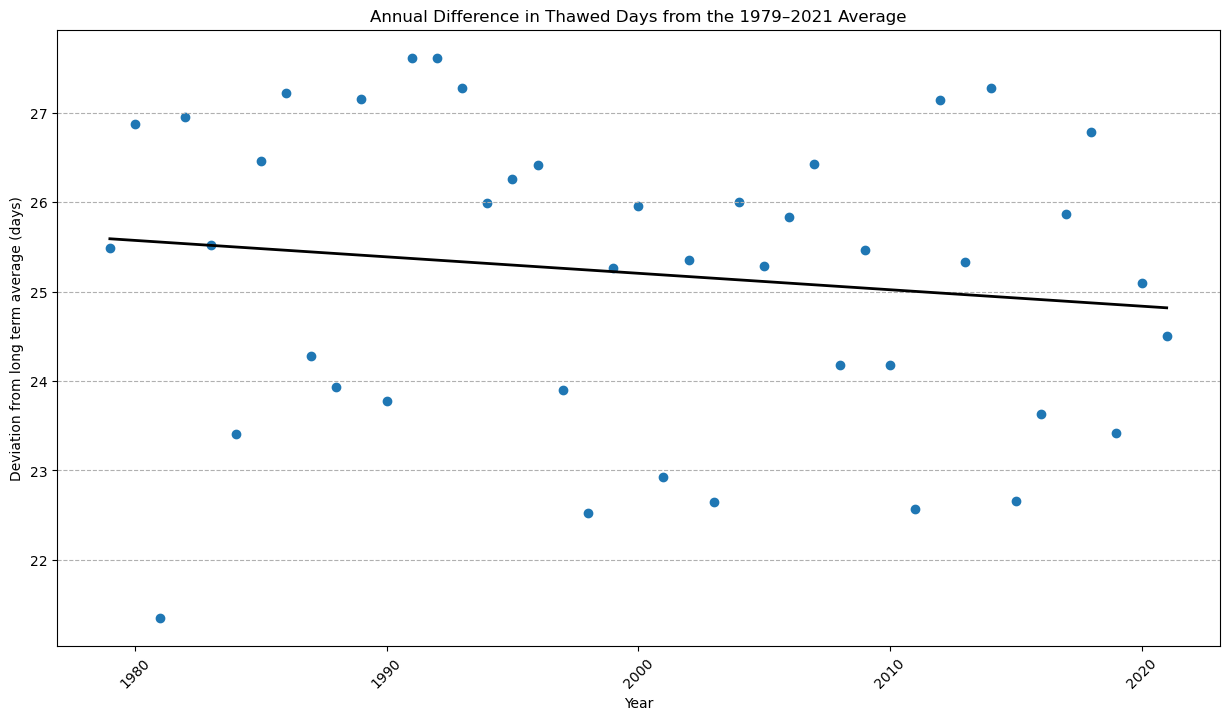

Dec
0.0053432856182488 0.02052415530696364 -0.00983758407046604
m                0.005343
b               19.124622
r2               0.110335
std_err          0.007517
p_value          0.481215
MK_trend         no trend
MK_p_value       0.817906
MK_z             0.230239
MK_tau           0.025471
MK_s                 23.0
MK_var_s      9130.333333
MK_h                False
dtype: object


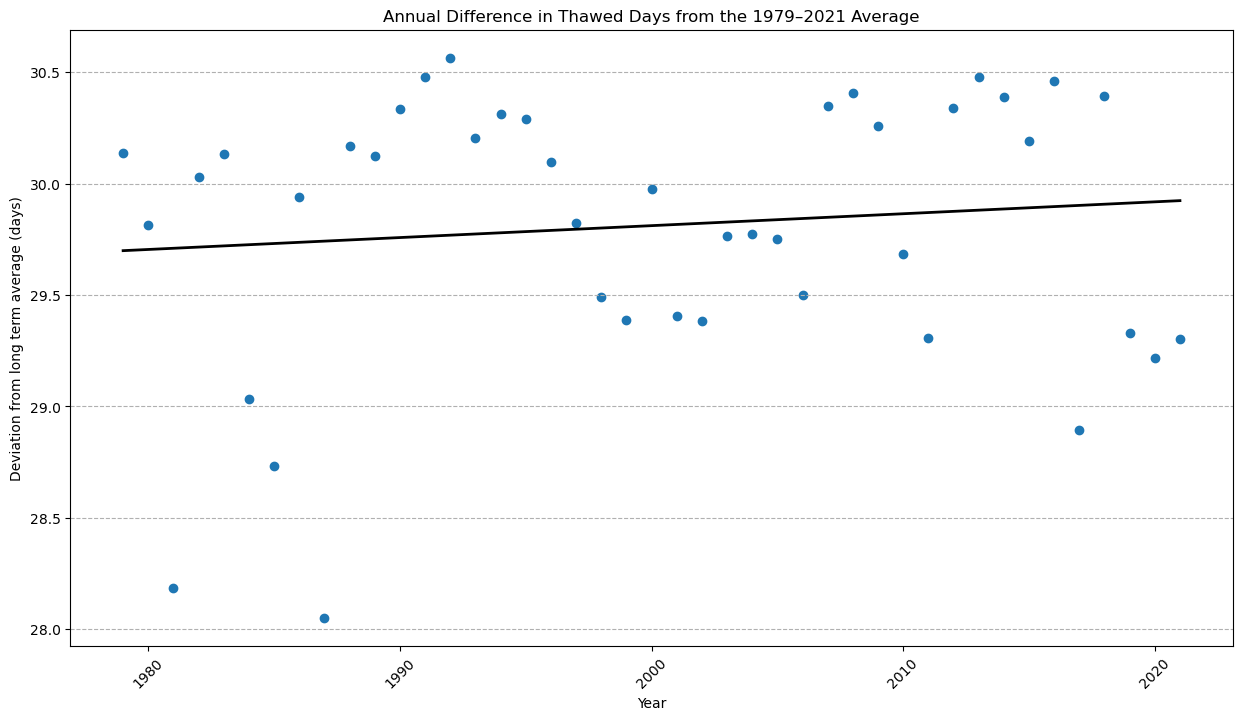

Jan
-0.01929897747588954 -0.002293475055656344 -0.03630447989612274
m               -0.019299
b               68.027658
r2              -0.336999
std_err           0.00842
p_value          0.027118
MK_trend         no trend
MK_p_value       0.068609
MK_z            -1.820983
MK_tau          -0.193798
MK_s               -175.0
MK_var_s      9130.333333
MK_h                False
dtype: object


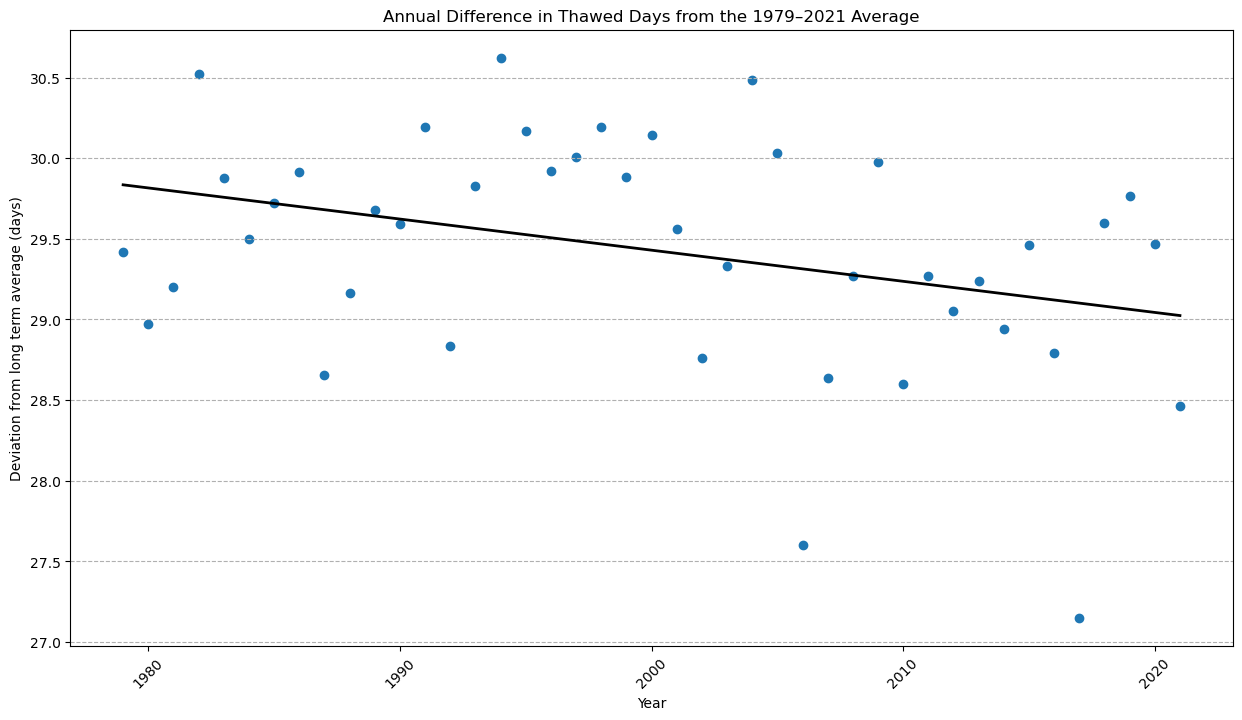

Feb
0.005445813043542881 0.02704617379805356 -0.016154547710967797
m                0.005446
b               16.259489
r2               0.079267
std_err          0.010696
p_value          0.613369
MK_trend         no trend
MK_p_value       0.530053
MK_z             0.627925
MK_tau           0.067553
MK_s                 61.0
MK_var_s      9130.333333
MK_h                False
dtype: object


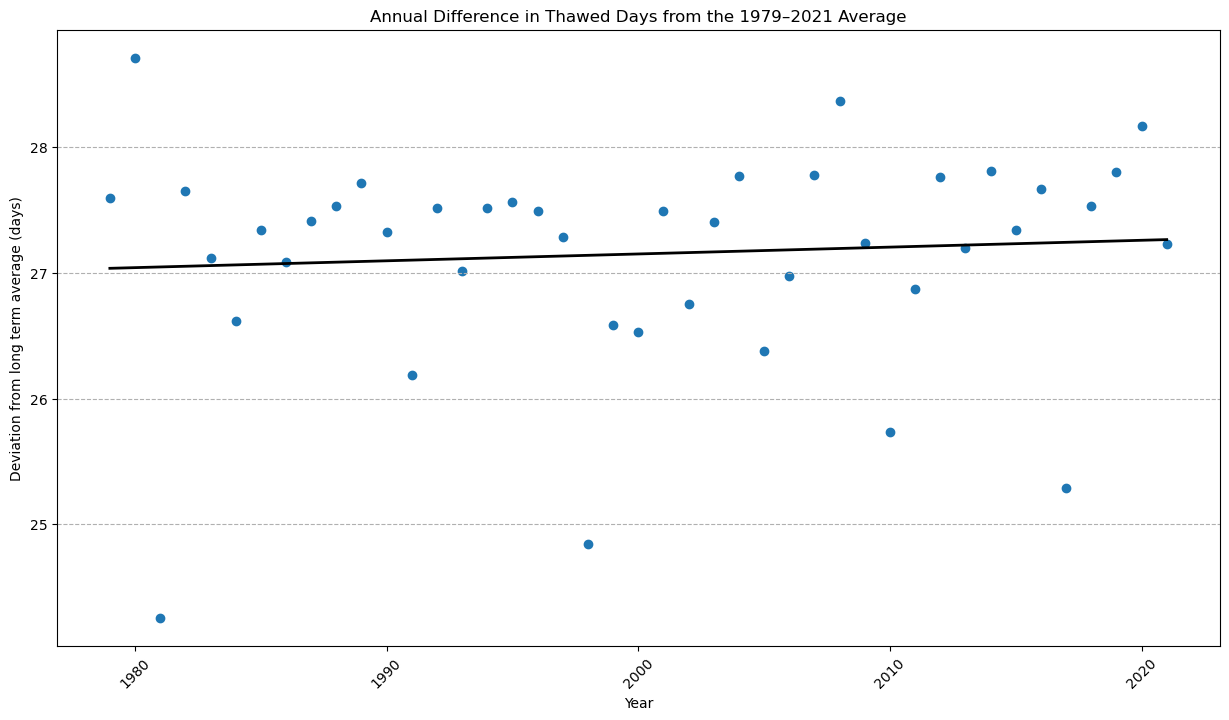

Mar
-0.03286086992918818 0.017686167305595184 -0.08340790716397153
m               -0.032861
b               91.604277
r2              -0.200864
std_err          0.025029
p_value          0.196514
MK_trend         no trend
MK_p_value       0.241146
MK_z            -1.172127
MK_tau          -0.125138
MK_s               -113.0
MK_var_s      9130.333333
MK_h                False
dtype: object


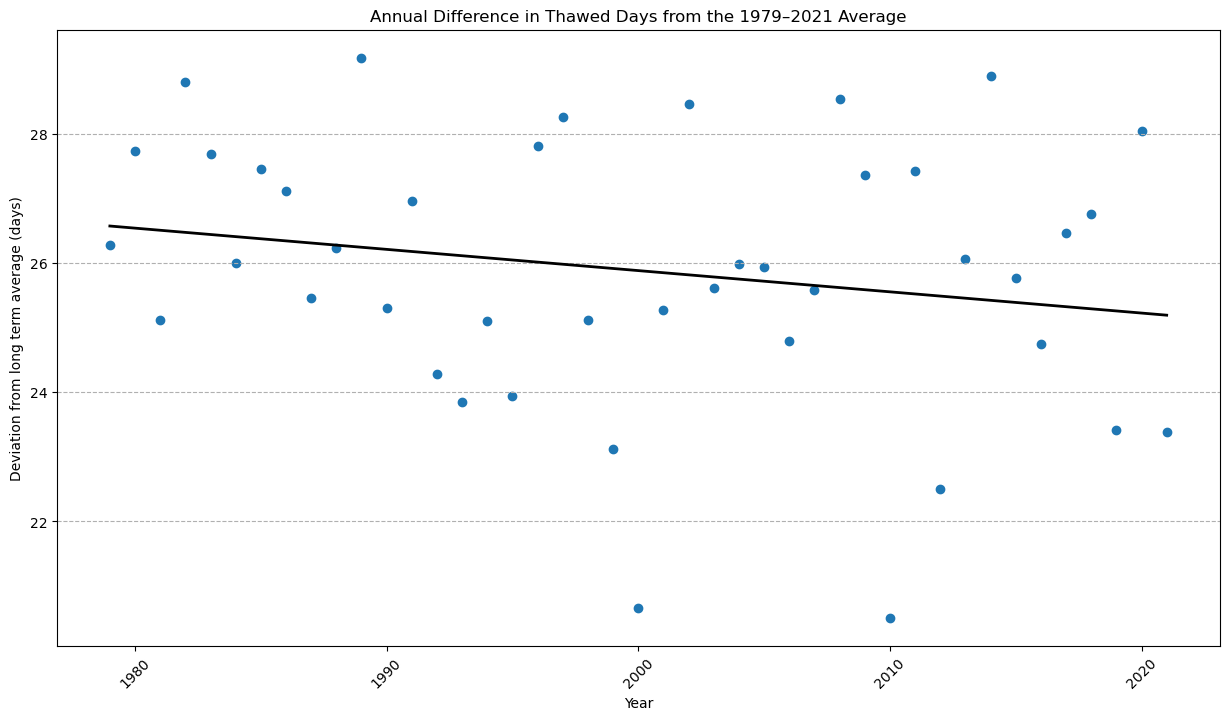

Apr
-0.03327413506955077 0.041238790554441816 -0.10778706069354335
m               -0.033274
b               78.529103
r2              -0.139467
std_err          0.036896
p_value          0.372411
MK_trend         no trend
MK_p_value       0.325239
MK_z             -0.98375
MK_tau          -0.105205
MK_s                -95.0
MK_var_s      9130.333333
MK_h                False
dtype: object


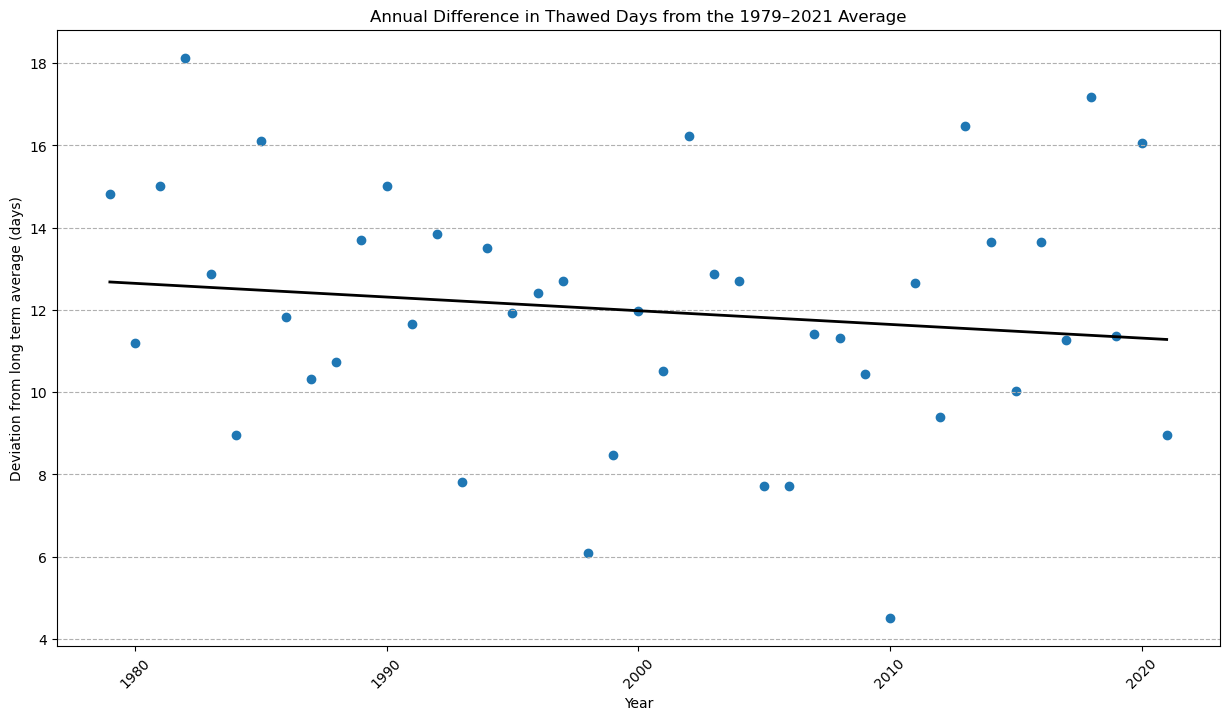

May
-0.016330093992643707 0.00796636124378634 -0.04062654922907376
m                -0.01633
b               34.382794
r2              -0.207377
std_err          0.012031
p_value          0.182089
MK_trend         no trend
MK_p_value       0.142878
MK_z            -1.465159
MK_tau          -0.156146
MK_s               -141.0
MK_var_s      9130.333333
MK_h                False
dtype: object


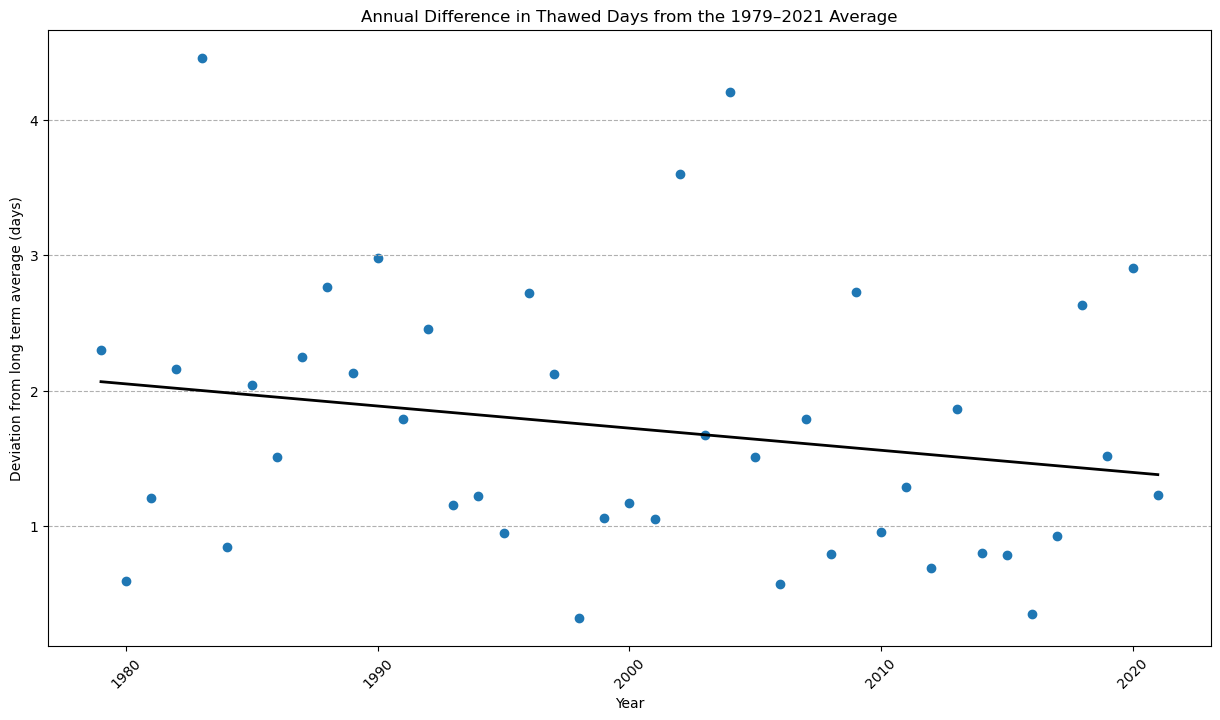

Jun
5.629143429595232e-05 0.0005317962961455858 -0.00041921342755368114
m                0.000056
b               -0.086117
r2               0.037312
std_err          0.000235
p_value          0.812236
MK_trend         no trend
MK_p_value       0.941598
MK_z            -0.073262
MK_tau          -0.008859
MK_s                 -8.0
MK_var_s      9129.333333
MK_h                False
dtype: object


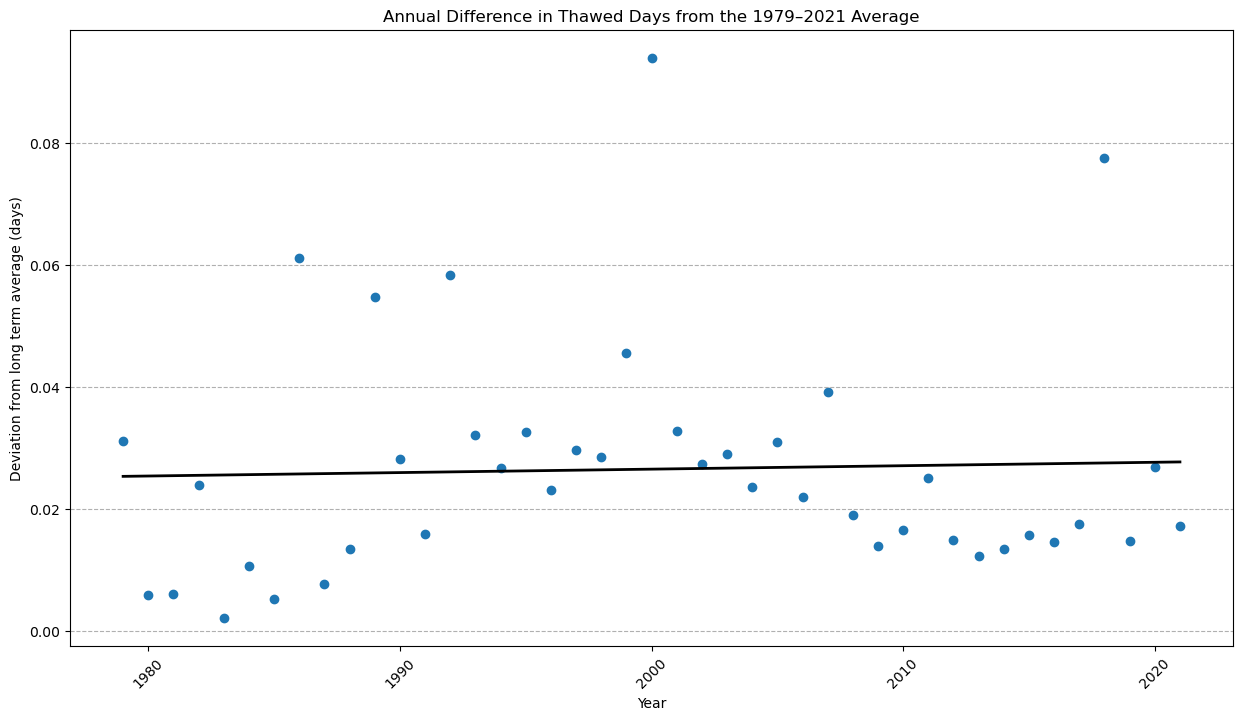

Jul
-2.6250884450419554e-05 0.00020780798675845152 -0.00026030975565929064
m               -0.000026
b                0.068718
r2              -0.035352
std_err          0.000116
p_value          0.821937
MK_trend         no trend
MK_p_value       0.900039
MK_z            -0.125613
MK_tau          -0.014396
MK_s                -13.0
MK_var_s      9126.333333
MK_h                False
dtype: object


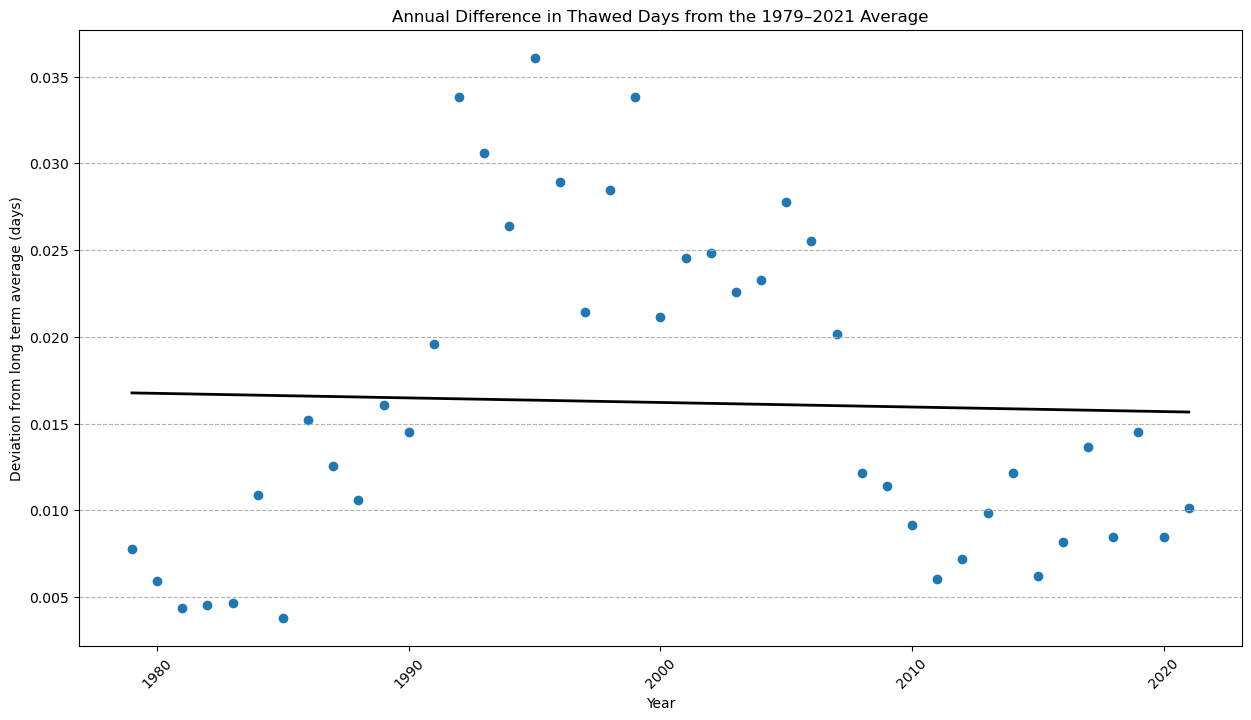

Aug
-6.429657018675339e-05 0.0003096566114381682 -0.00043824975181167497
m               -0.000064
b                0.157813
r2              -0.054149
std_err          0.000185
p_value          0.730191
MK_trend         no trend
MK_p_value       0.941591
MK_z             -0.07327
MK_tau          -0.008859
MK_s                 -8.0
MK_var_s      9127.333333
MK_h                False
dtype: object


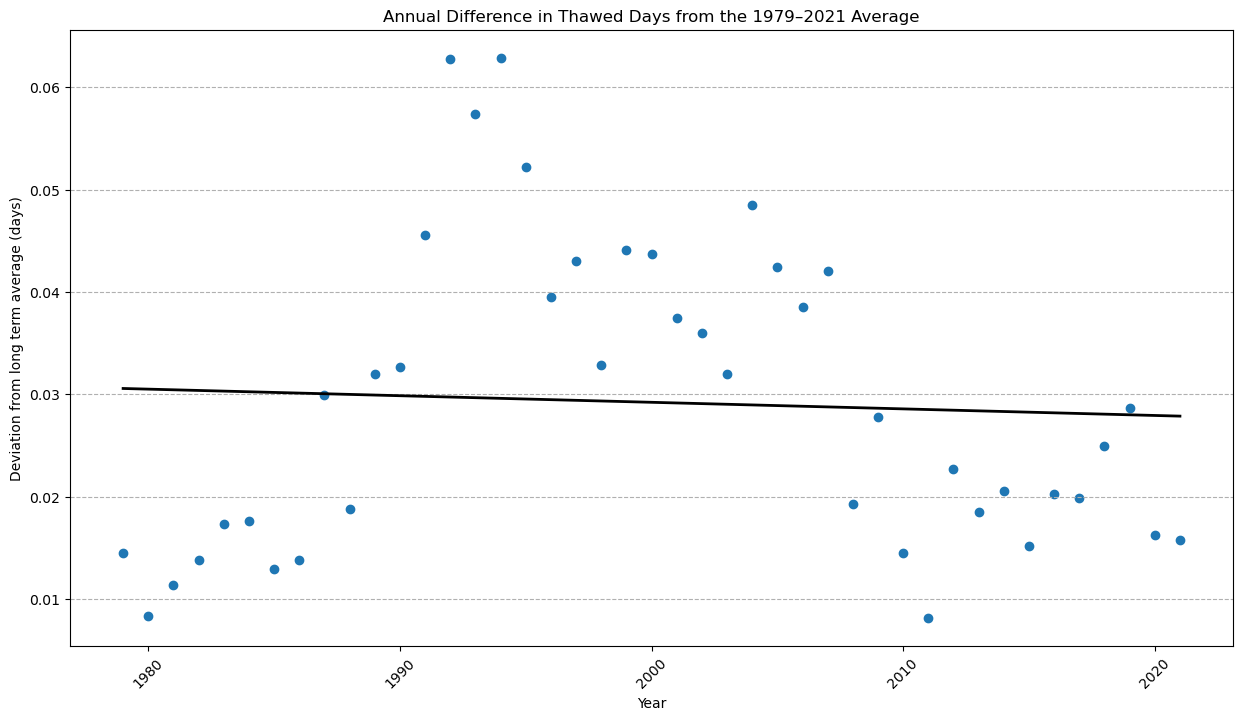

Sep
-3.001925959050522e-06 0.0013706156721342406 -0.0013766195240523418
m               -0.000003
b                0.123145
r2              -0.000689
std_err           0.00068
p_value            0.9965
MK_trend         no trend
MK_p_value       0.924955
MK_z             0.094194
MK_tau           0.011074
MK_s                 10.0
MK_var_s      9129.333333
MK_h                False
dtype: object


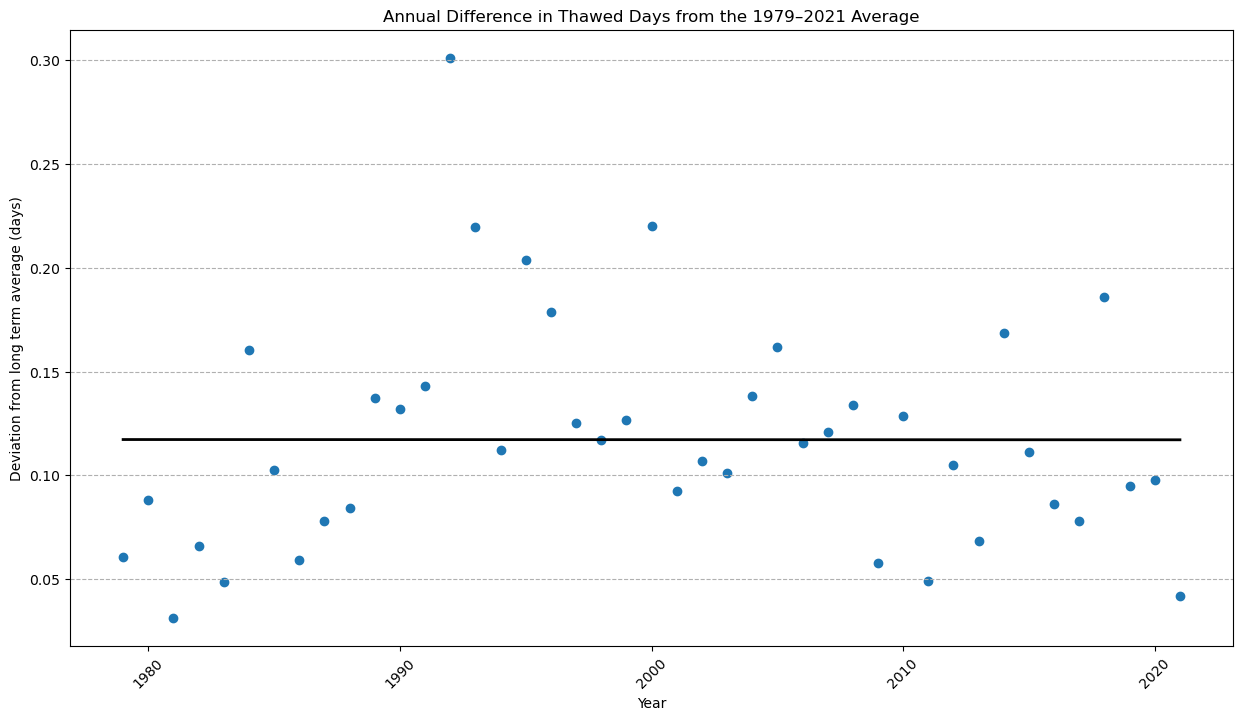

Oct
-0.017686304528228596 0.0009807017536884767 -0.03635331081014567
m               -0.017686
b               37.046192
r2              -0.286319
std_err          0.009243
p_value          0.062692
MK_trend       decreasing
MK_p_value       0.046764
MK_z             -1.98843
MK_tau          -0.211517
MK_s               -191.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


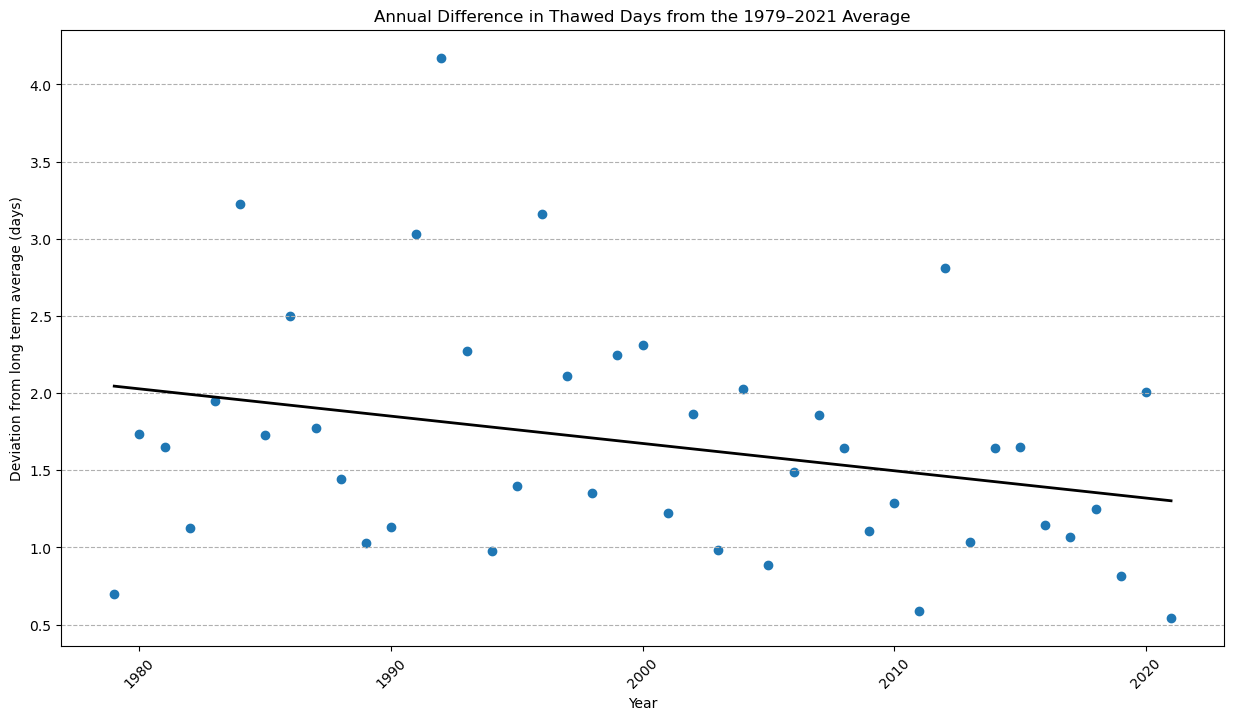

Nov
-0.024003974805452855 0.04499710385705859 -0.0930050534679643
m               -0.024004
b               60.428817
r2              -0.109066
std_err          0.034167
p_value          0.486303
MK_trend         no trend
MK_p_value       0.402461
MK_z            -0.837234
MK_tau          -0.089701
MK_s                -81.0
MK_var_s      9130.333333
MK_h                False
dtype: object


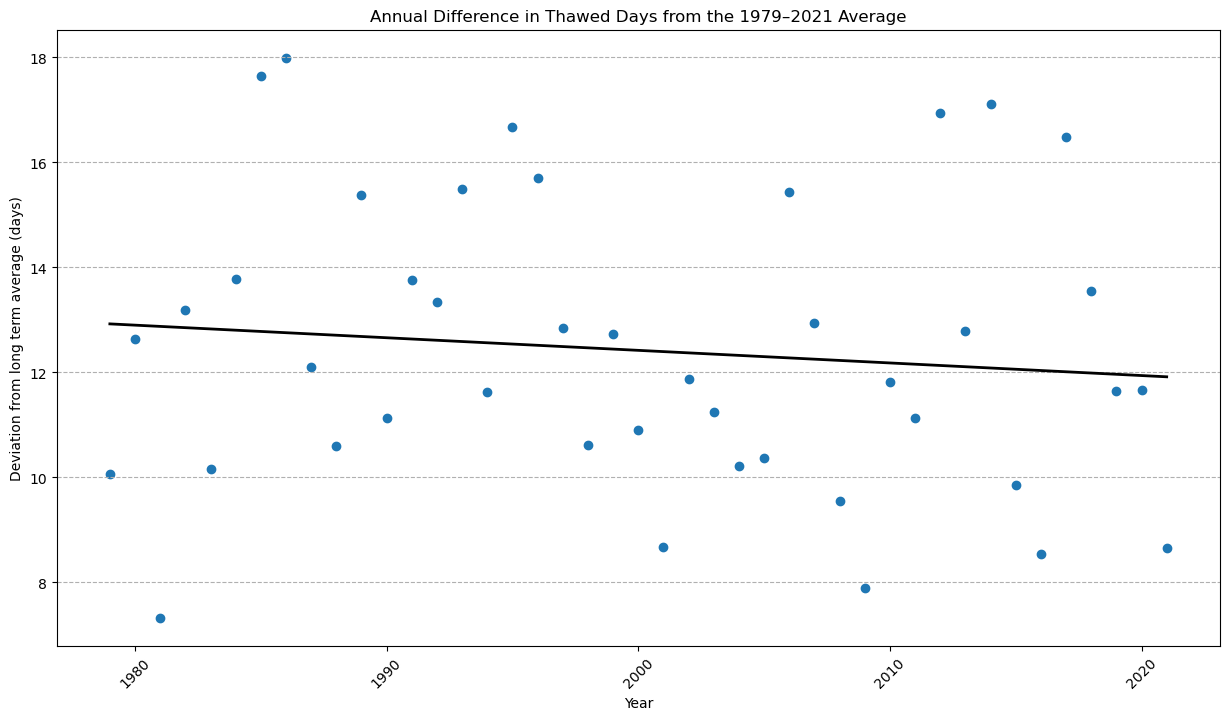

Dec
-0.02129676984676509 0.03473240132739767 -0.07732594102092785
m               -0.021297
b               68.054263
r2              -0.119031
std_err          0.027744
p_value          0.447105
MK_trend         no trend
MK_p_value        0.34625
MK_z            -0.941888
MK_tau          -0.100775
MK_s                -91.0
MK_var_s      9130.333333
MK_h                False
dtype: object


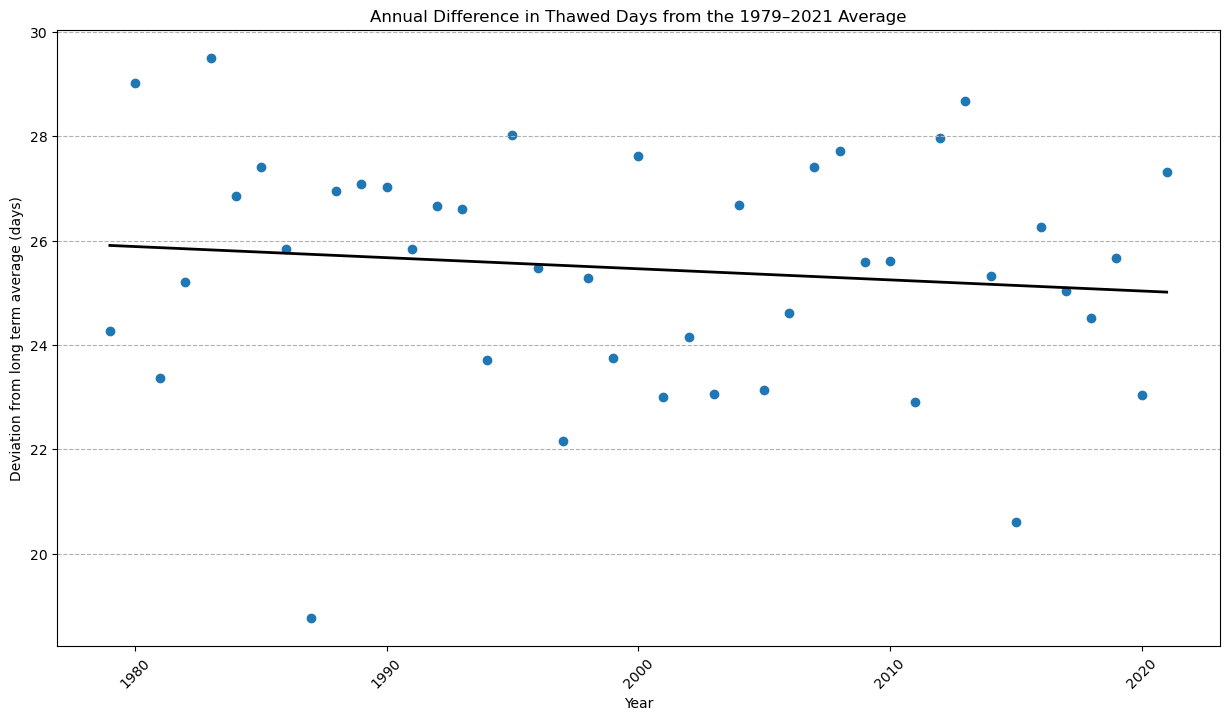

Jan
-0.07039496171053566 -0.02258577201364287 -0.11820415140742846
m               -0.070395
b              163.927767
r2              -0.421196
std_err          0.023673
p_value          0.004912
MK_trend       decreasing
MK_p_value       0.006508
MK_z            -2.721009
MK_tau          -0.289037
MK_s               -261.0
MK_var_s      9130.333333
MK_h                 True
dtype: object


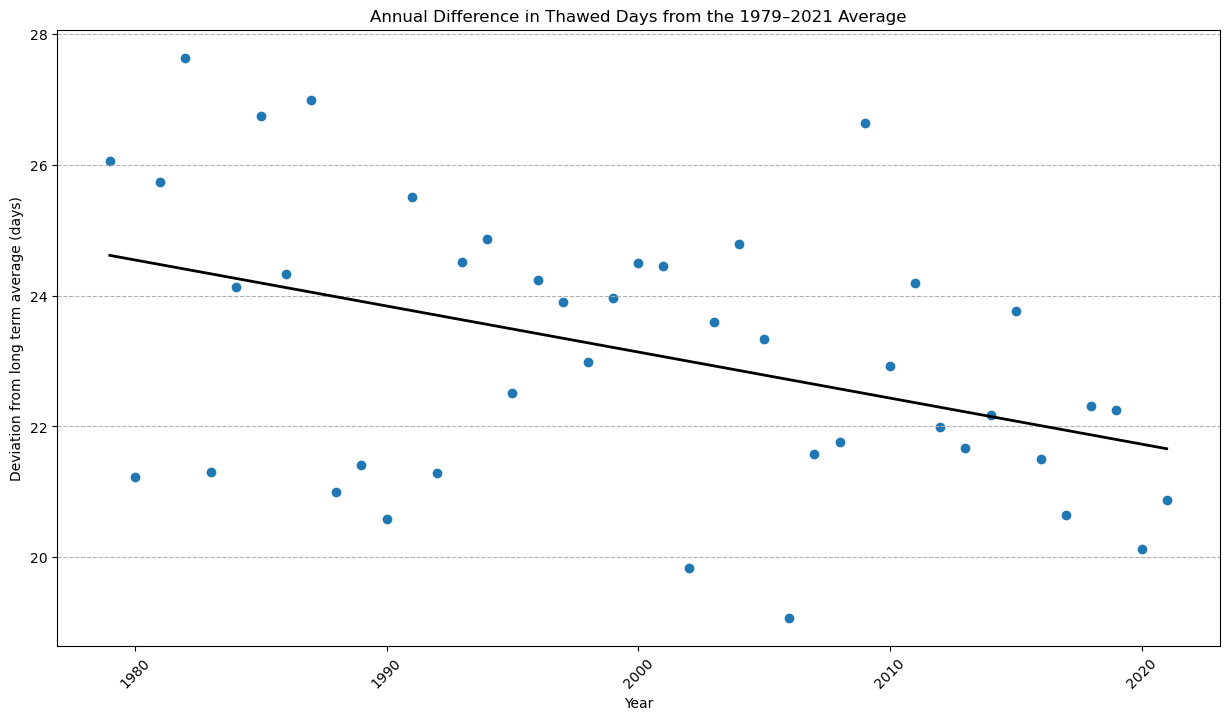

Feb
-0.012011217885714858 0.0517109151167277 -0.07573335088815741
m               -0.012011
b               45.317496
r2              -0.059346
std_err          0.031553
p_value          0.705413
MK_trend         no trend
MK_p_value        0.45743
MK_z            -0.743086
MK_tau          -0.079734
MK_s                -72.0
MK_var_s      9129.333333
MK_h                False
dtype: object


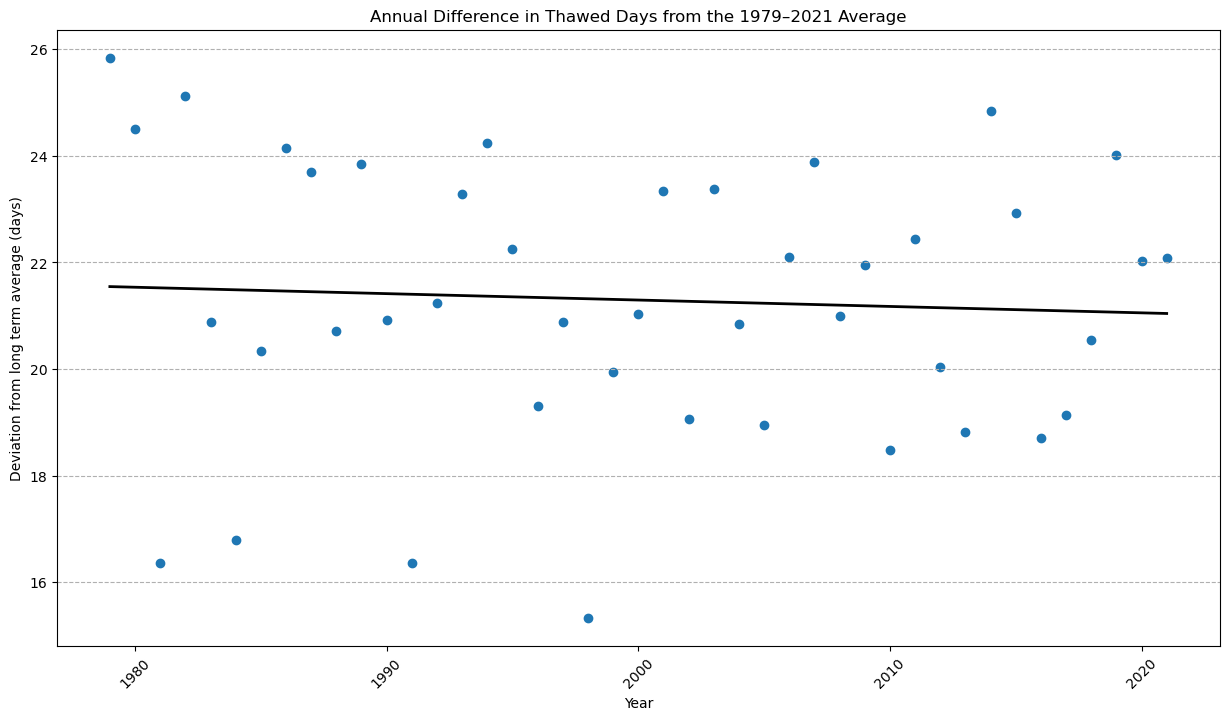

Mar
-0.02337028689462893 0.05476573089442108 -0.10150630468367894
m                -0.02337
b               60.431731
r2              -0.093918
std_err           0.03869
p_value          0.549145
MK_trend         no trend
MK_p_value       0.850581
MK_z            -0.188378
MK_tau          -0.021041
MK_s                -19.0
MK_var_s      9130.333333
MK_h                False
dtype: object


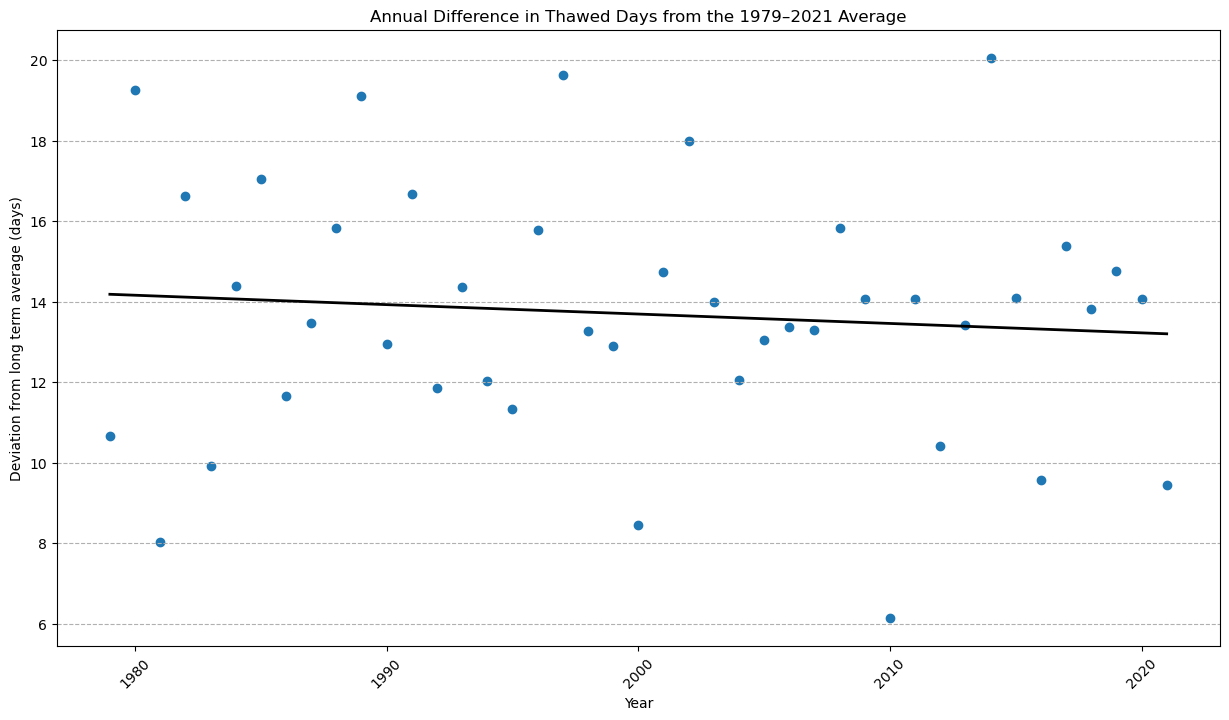

Apr
-0.009240278934712489 0.025659491484243572 -0.04414004935366855
m                -0.00924
b               20.784753
r2              -0.083217
std_err          0.017281
p_value          0.595741
MK_trend         no trend
MK_p_value       0.615428
MK_z             -0.50234
MK_tau          -0.054264
MK_s                -49.0
MK_var_s      9130.333333
MK_h                False
dtype: object


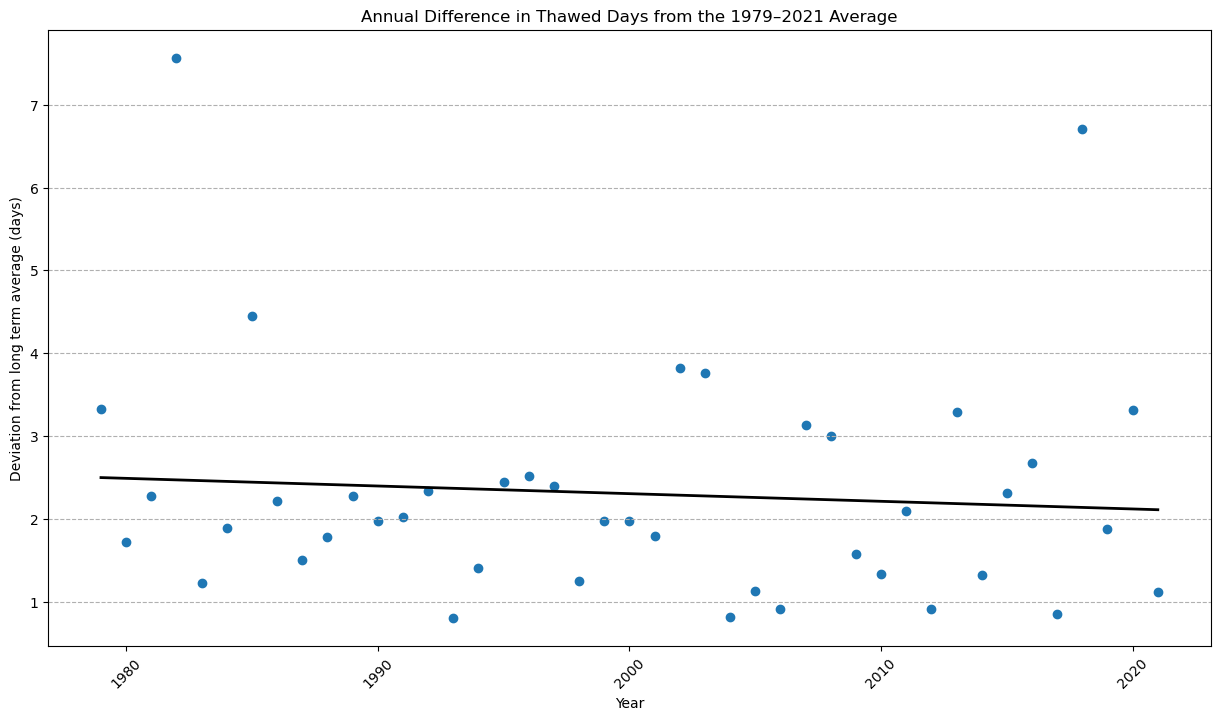

May
-0.0013752941029553445 0.0022059918479632986 -0.004956580053873987
m               -0.001375
b                2.913877
r2              -0.120242
std_err          0.001773
p_value          0.442466
MK_trend         no trend
MK_p_value       0.340786
MK_z            -0.952614
MK_tau          -0.101883
MK_s                -92.0
MK_var_s      9125.333333
MK_h                False
dtype: object


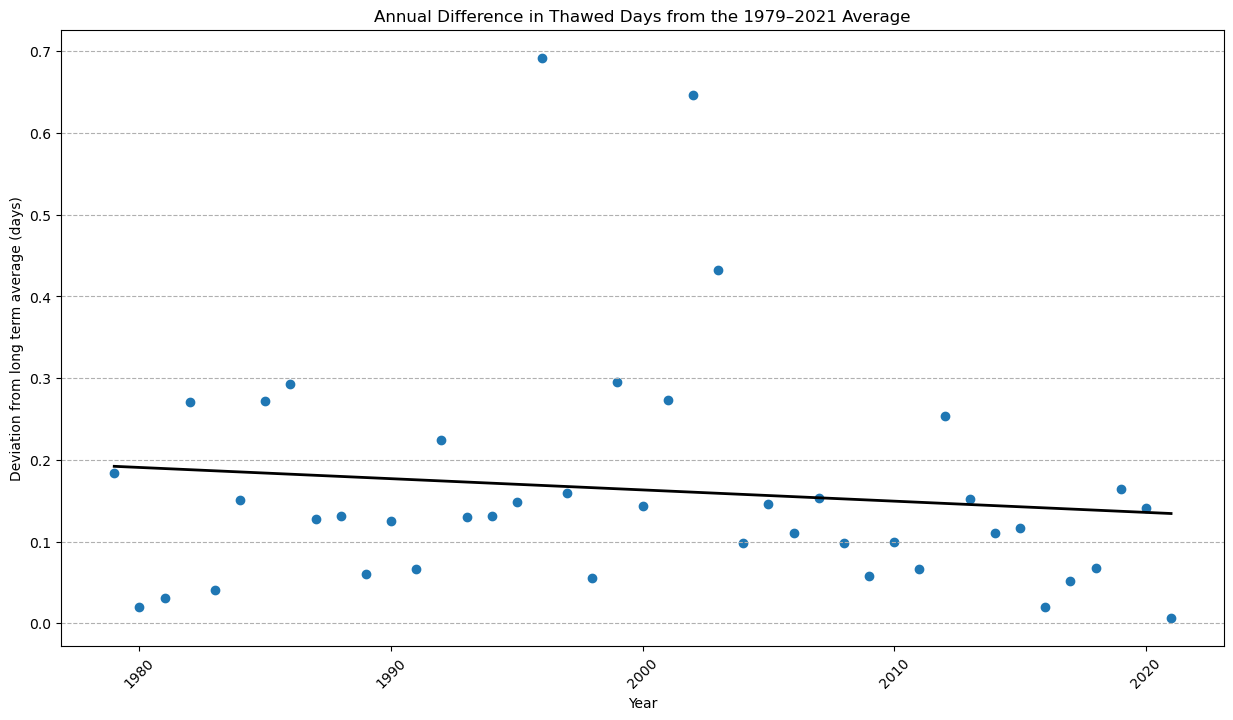

Jun
-0.0004889960283670885 0.0003329160210212433 -0.0013109080777554203
m            -0.000489
b             1.005468
r2           -0.184428
std_err       0.000407
p_value       0.236443
MK_trend      no trend
MK_p_value     0.50945
MK_z         -0.659695
MK_tau       -0.070875
MK_s             -64.0
MK_var_s        9120.0
MK_h             False
dtype: object


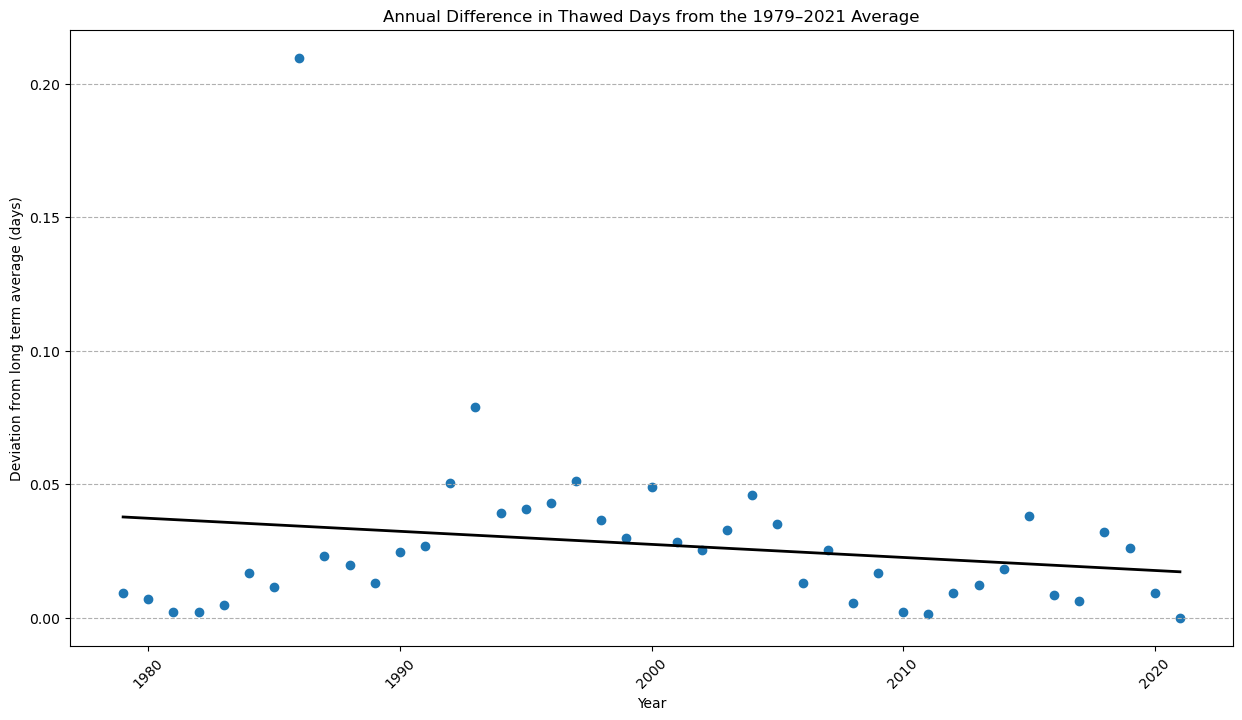

Jul
-0.0001802659749880093 0.00010688360462055111 -0.00046741555459656973
m                -0.00018
b                0.372552
r2               -0.19423
std_err          0.000142
p_value          0.212014
MK_trend         no trend
MK_p_value       0.223972
MK_z            -1.216033
MK_tau          -0.129568
MK_s               -117.0
MK_var_s      9099.666667
MK_h                False
dtype: object


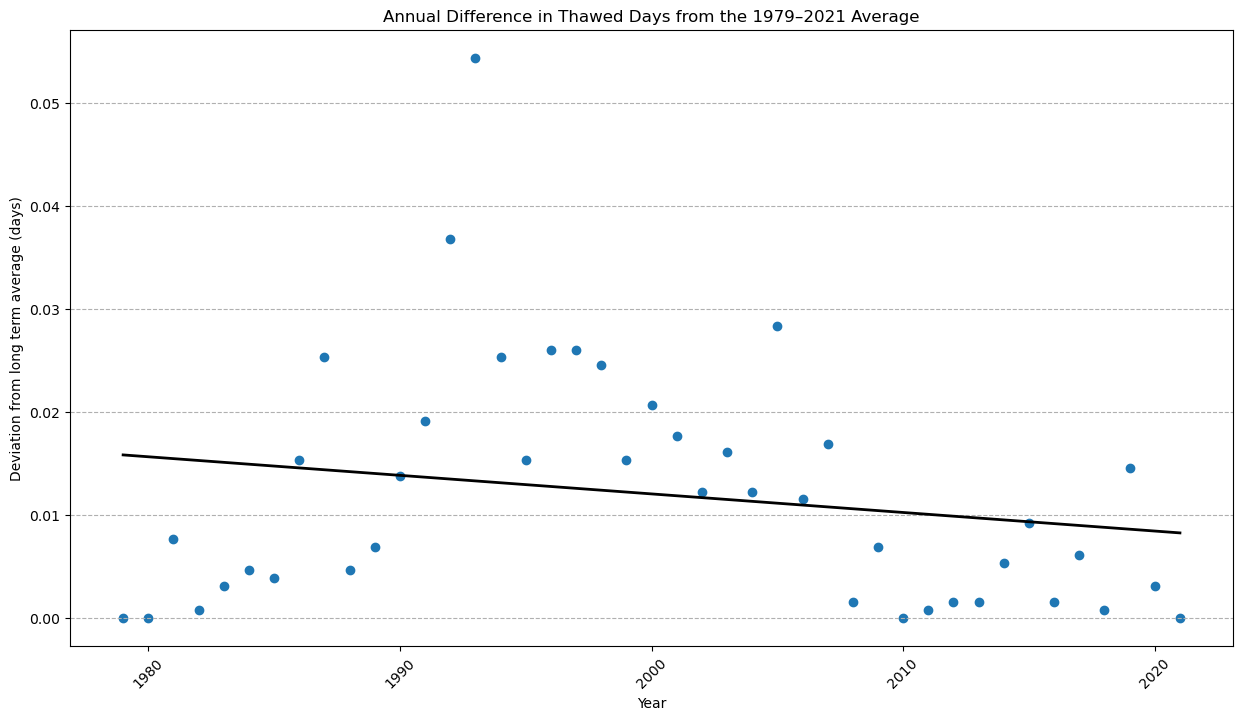

Aug
-0.00032364622449739444 1.937053592517441e-05 -0.0006666629849199632
m            -0.000324
b             0.663283
r2           -0.285227
std_err        0.00017
p_value       0.063745
MK_trend      no trend
MK_p_value     0.08966
MK_z         -1.697196
MK_tau       -0.180509
MK_s            -163.0
MK_var_s        9111.0
MK_h             False
dtype: object


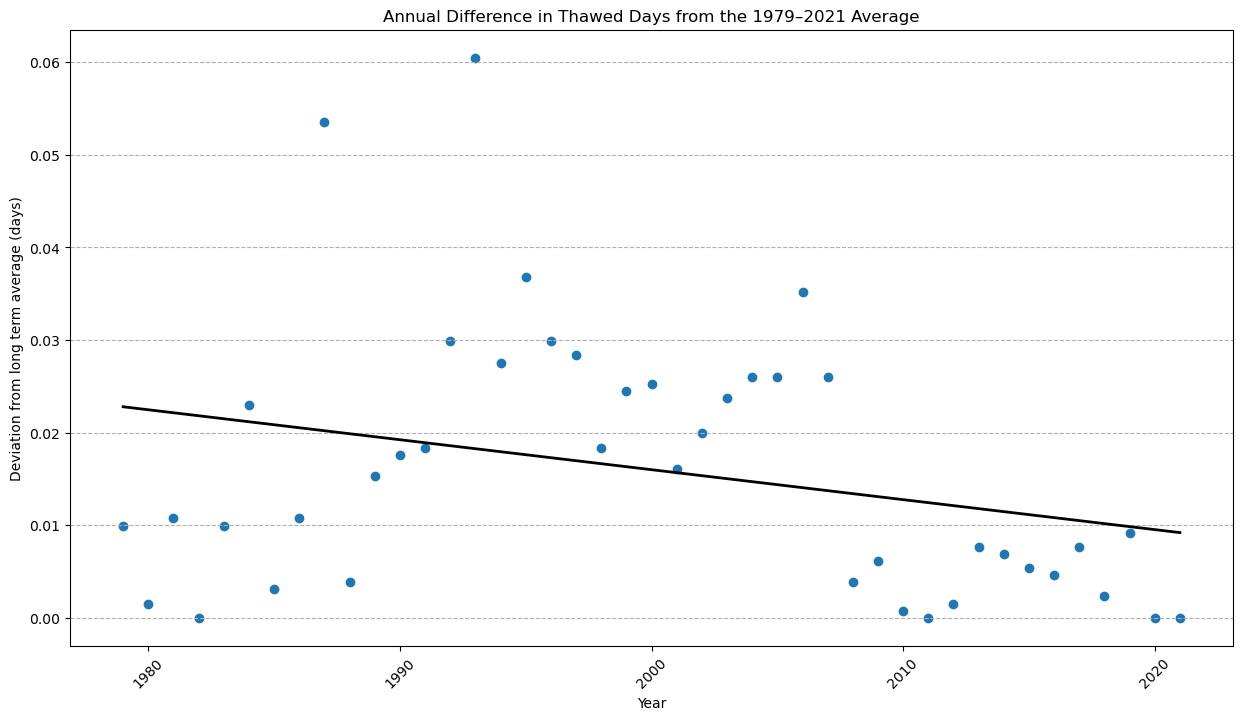

Sep
-0.0001159761211757367 0.0006494917888283354 -0.0008814440311798088
m               -0.000116
b                0.282043
r2              -0.047732
std_err          0.000379
p_value          0.761168
MK_trend         no trend
MK_p_value       0.721885
MK_z            -0.355941
MK_tau           -0.03876
MK_s                -35.0
MK_var_s      9124.333333
MK_h                False
dtype: object


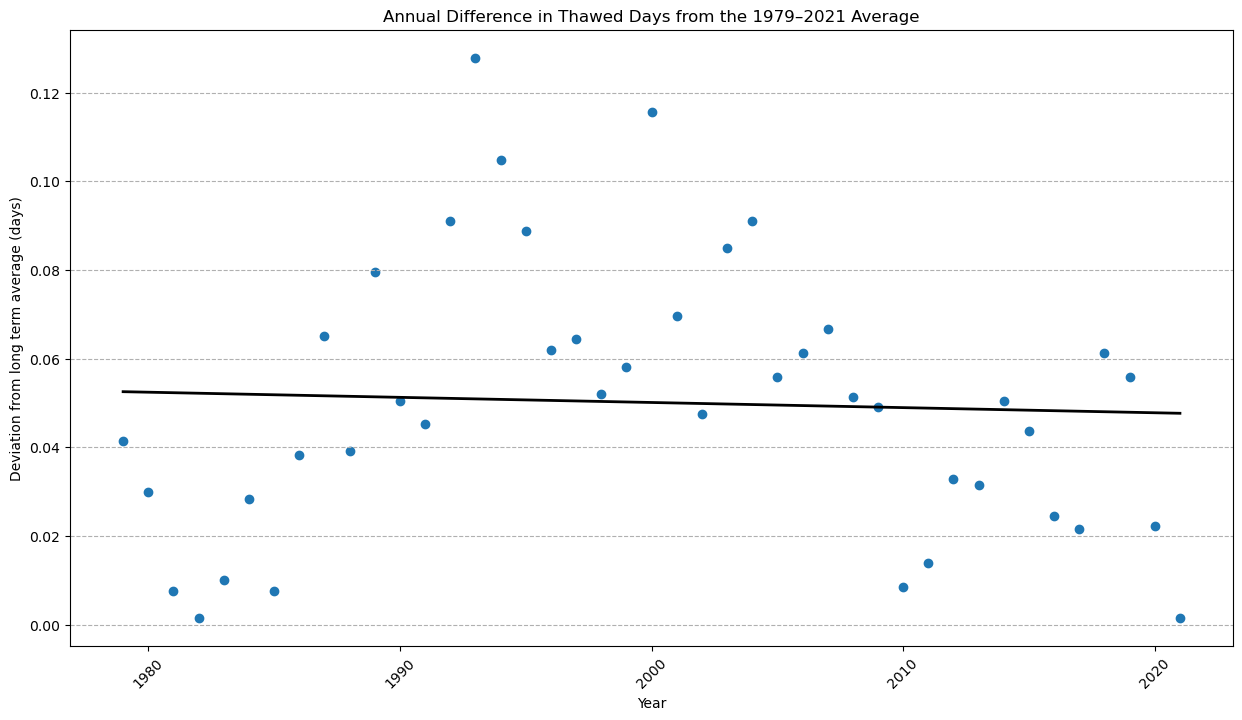

Oct
0.001208441119050471 0.013098388962631415 -0.01068150672453047
m                0.001208
b               -1.786411
r2               0.032039
std_err          0.005887
p_value          0.838387
MK_trend         no trend
MK_p_value       0.785544
MK_z             0.272101
MK_tau             0.0299
MK_s                 27.0
MK_var_s      9130.333333
MK_h                False
dtype: object


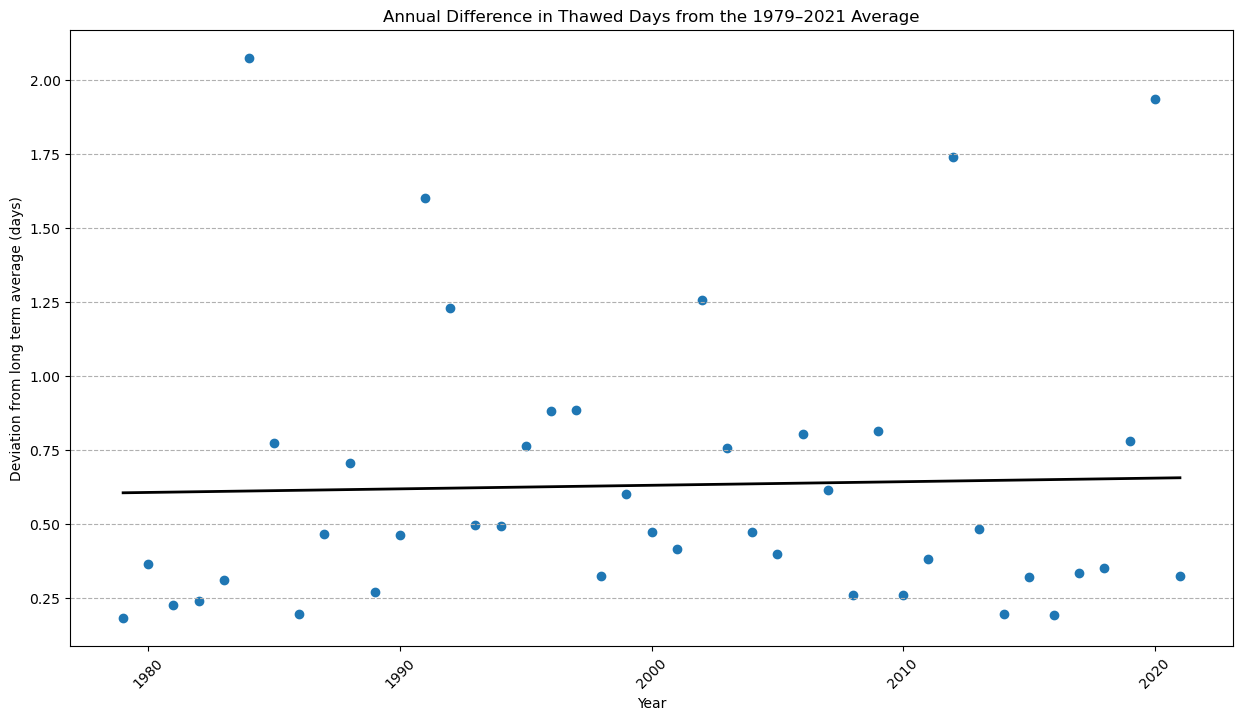

Nov
-0.013762653885165376 0.035534352109231934 -0.06305965987956269
m               -0.013763
b               33.877902
r2              -0.087713
std_err           0.02441
p_value          0.575953
MK_trend         no trend
MK_p_value       0.974952
MK_z            -0.031398
MK_tau           -0.00443
MK_s                 -4.0
MK_var_s      9129.333333
MK_h                False
dtype: object


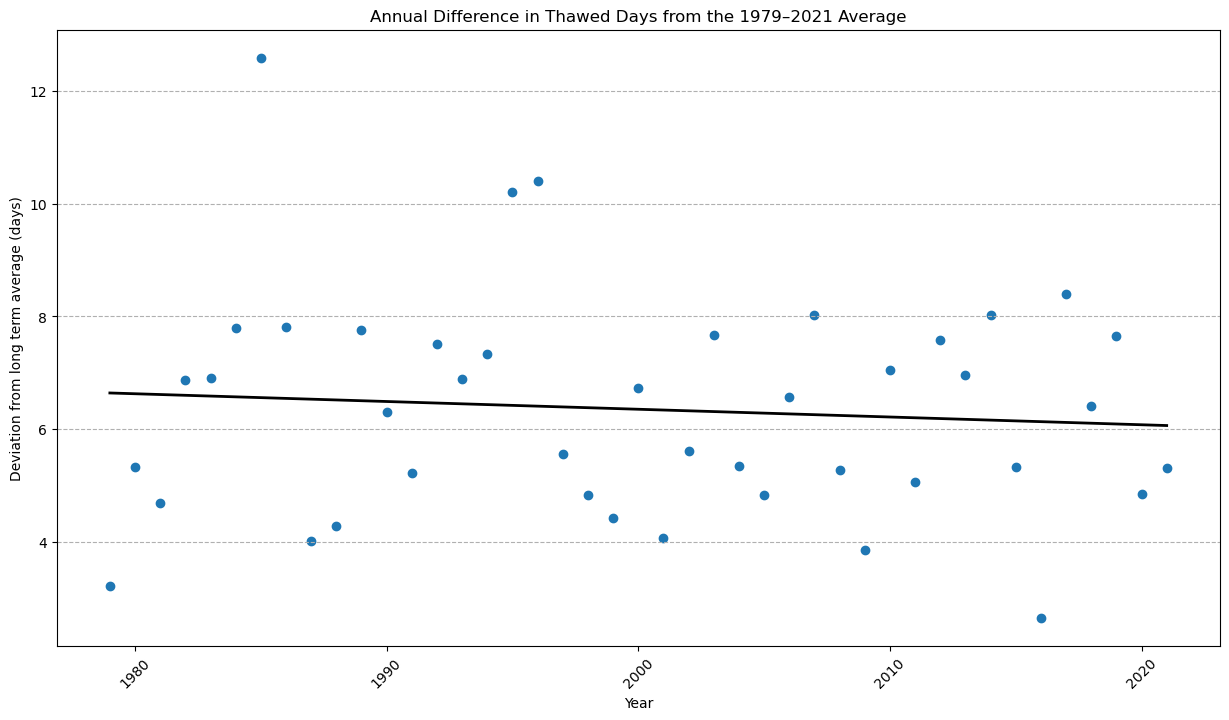

Dec
-0.02314897254175721 0.0677082677257672 -0.11400621280928162
m               -0.023149
b                63.47199
r2                -0.0801
std_err          0.044989
p_value          0.609633
MK_trend         no trend
MK_p_value       0.600786
MK_z            -0.523271
MK_tau          -0.056478
MK_s                -51.0
MK_var_s      9130.333333
MK_h                False
dtype: object


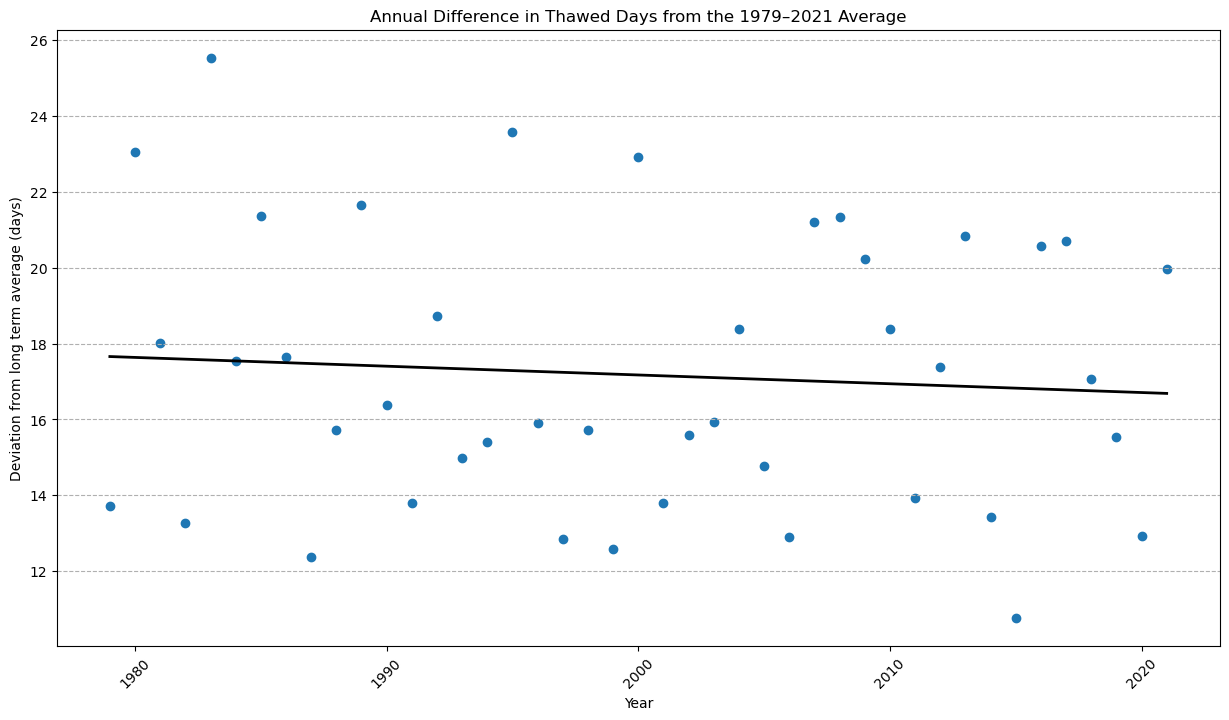

Jan
-0.032069393236571826 0.047195395989899795 -0.11133418246304344
m               -0.032069
b               91.192202
r2               -0.12658
std_err          0.039249
p_value          0.418607
MK_trend         no trend
MK_p_value       0.228748
MK_z            -1.203589
MK_tau          -0.128461
MK_s               -116.0
MK_var_s      9129.333333
MK_h                False
dtype: object


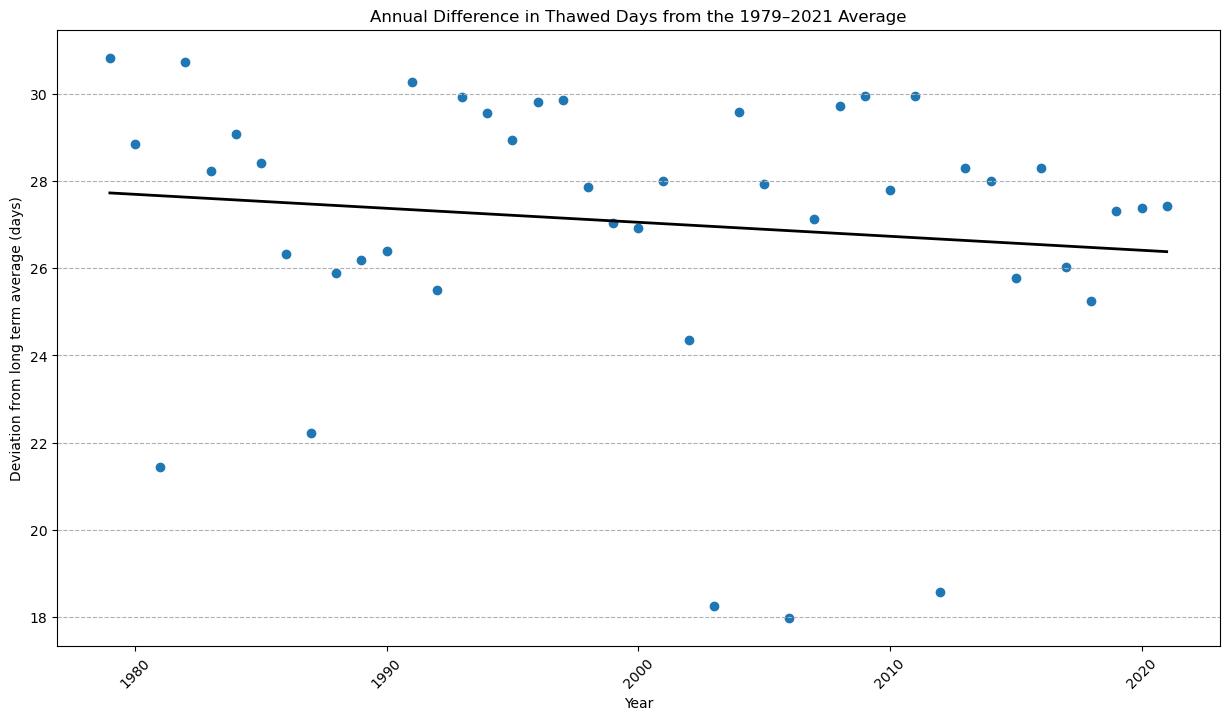

Feb
0.028798231167691445 0.11276103748329339 -0.05516457514791049
m                0.028798
b              -33.190875
r2               0.107551
std_err          0.041575
p_value          0.492417
MK_trend         no trend
MK_p_value       0.675496
MK_z             0.418617
MK_tau           0.045404
MK_s                 41.0
MK_var_s      9130.333333
MK_h                False
dtype: object


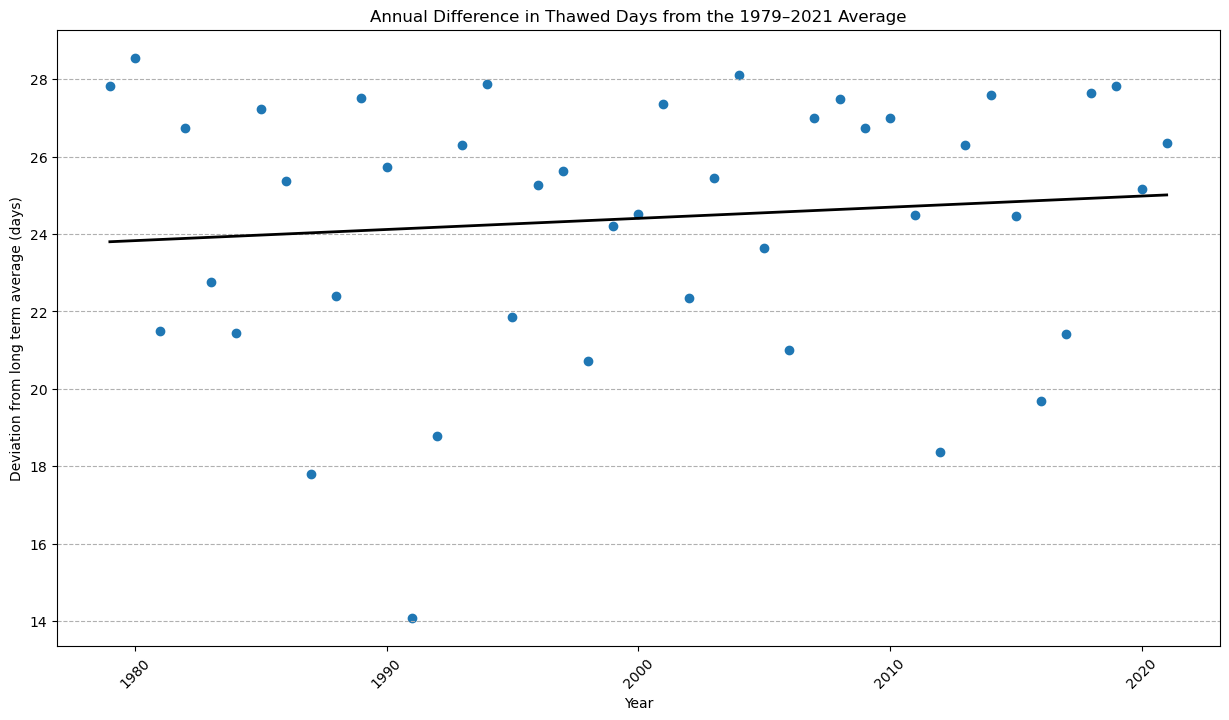

Mar
-0.04486018588695198 0.11549248200225745 -0.2052128537761614
m                -0.04486
b              104.702586
r2              -0.087894
std_err          0.079401
p_value          0.575162
MK_trend         no trend
MK_p_value       0.721972
MK_z            -0.355824
MK_tau           -0.03876
MK_s                -35.0
MK_var_s      9130.333333
MK_h                False
dtype: object


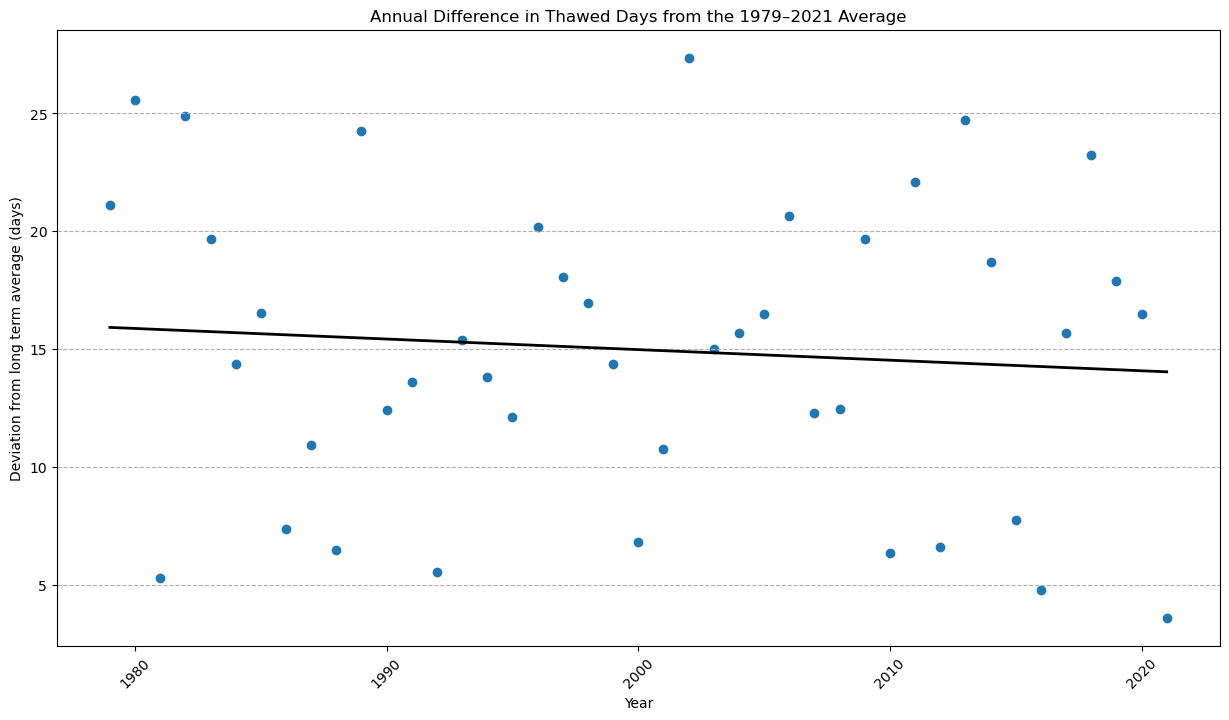

Apr
0.008496549523315643 0.07189877487811433 -0.054905675831483036
m                0.008497
b              -15.189706
r2               0.042229
std_err          0.031394
p_value          0.788026
MK_trend         no trend
MK_p_value       0.883514
MK_z             0.146516
MK_tau           0.016611
MK_s                 15.0
MK_var_s      9130.333333
MK_h                False
dtype: object


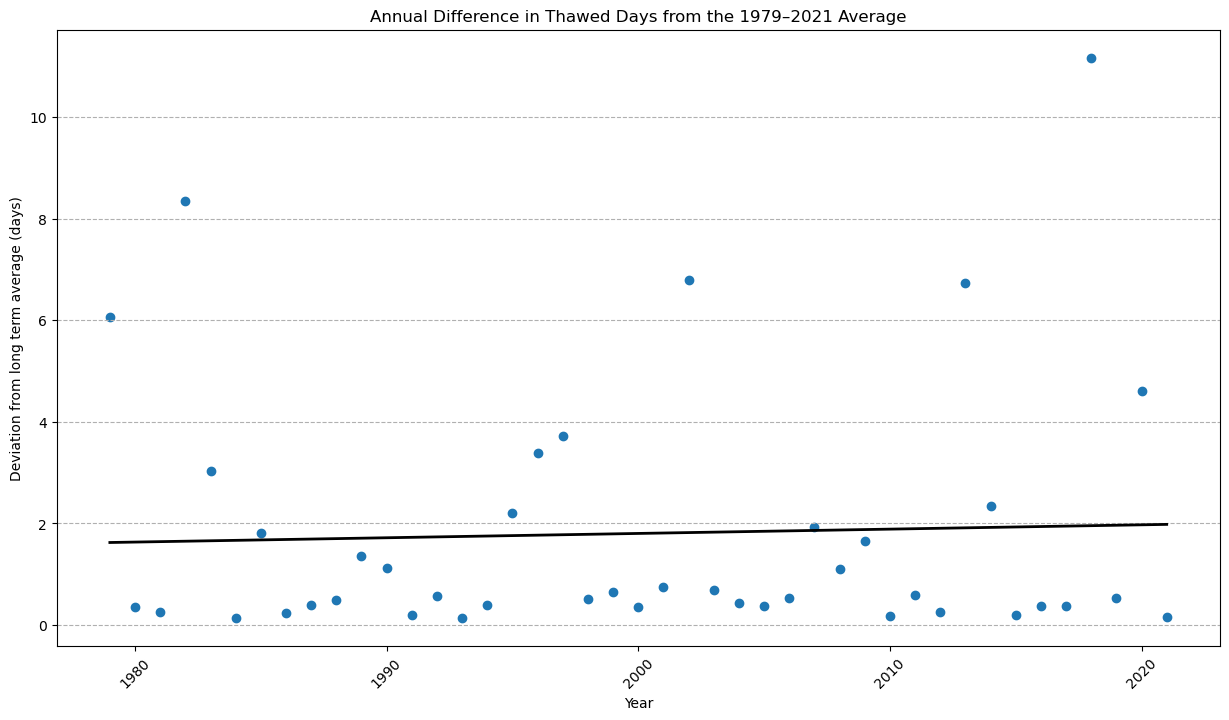

May
-0.0007373933657391313 0.0002337645653080068 -0.0017085512967862694
m               -0.000737
b                1.598408
r2              -0.232895
std_err          0.000481
p_value          0.132853
MK_trend         no trend
MK_p_value       0.340786
MK_z            -0.952614
MK_tau          -0.101883
MK_s                -92.0
MK_var_s      9125.333333
MK_h                False
dtype: object


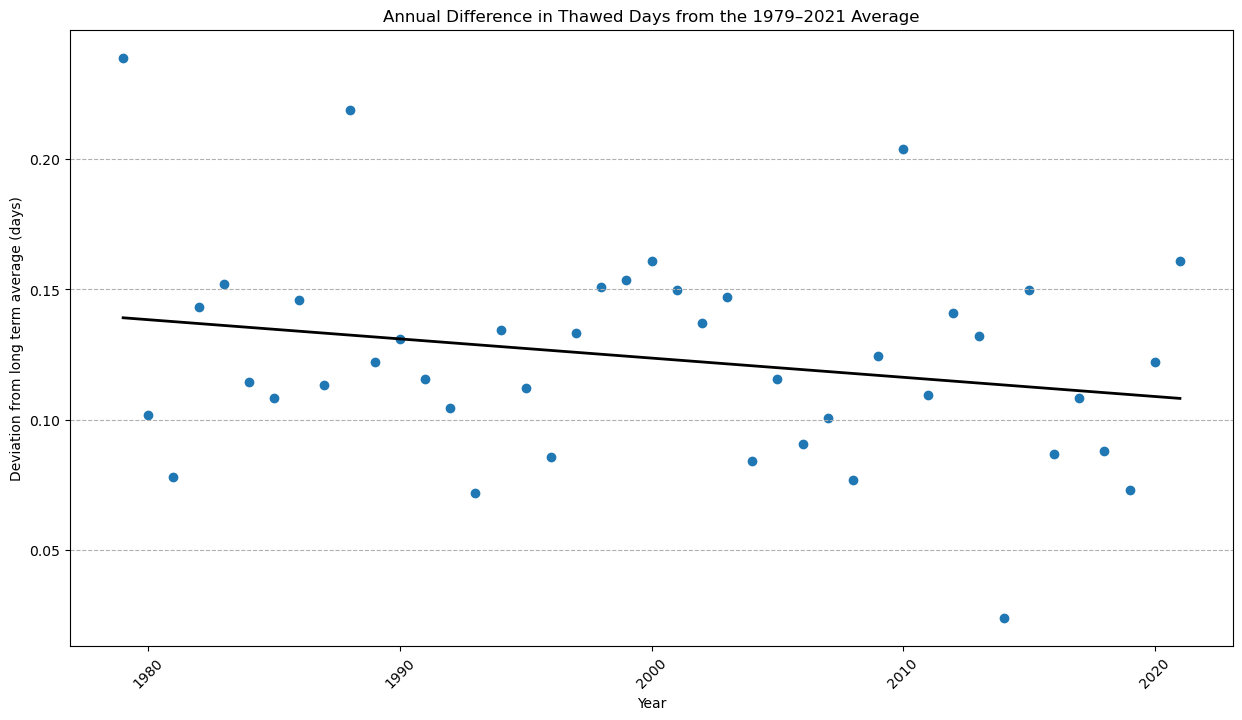

Jun
-0.0002843580289828644 0.0007228397878126292 -0.0012915558457783582
m            -0.000284
b             0.594868
r2           -0.088694
std_err       0.000499
p_value       0.571675
MK_trend      no trend
MK_p_value    0.060342
MK_z         -1.878288
MK_tau       -0.199336
MK_s            -180.0
MK_var_s        9082.0
MK_h             False
dtype: object


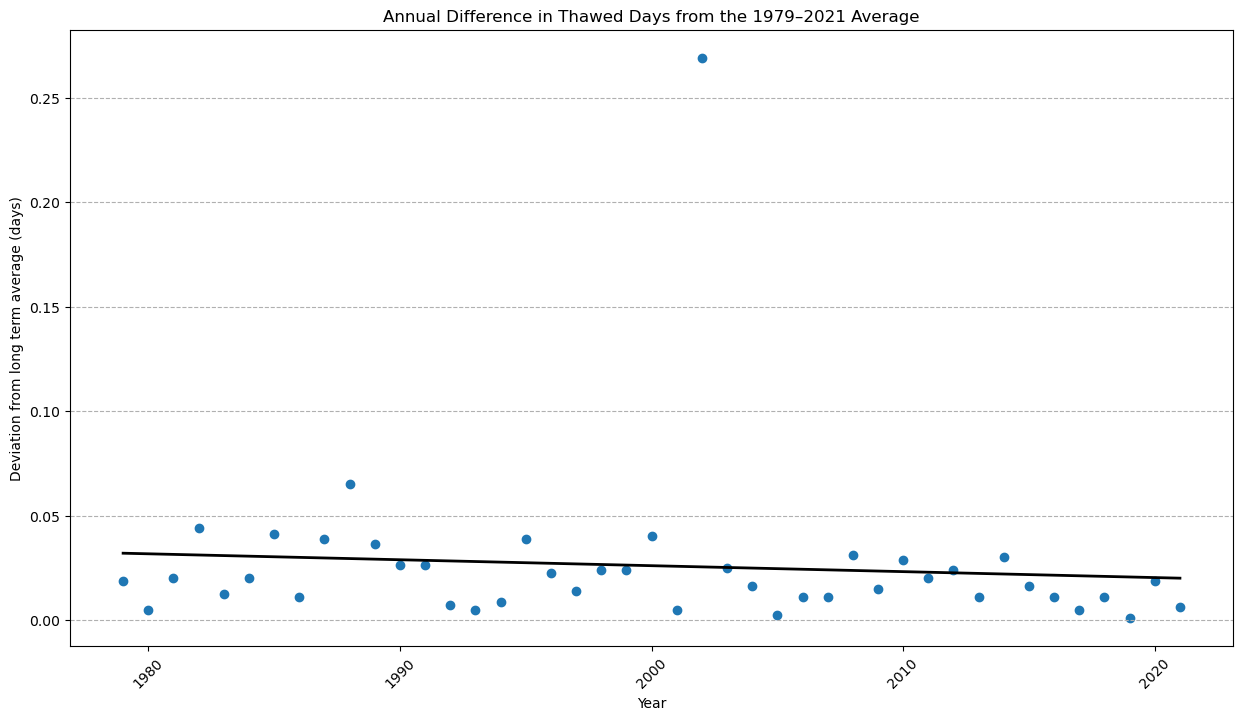

Jul
-1.3866490391281963e-05 6.757477044856152e-05 -9.530775123112544e-05
m            -0.000014
b             0.030453
r2           -0.053624
std_err        0.00004
p_value       0.732713
MK_trend      no trend
MK_p_value    0.690758
MK_z         -0.397826
MK_tau       -0.042082
MK_s             -38.0
MK_var_s        8650.0
MK_h             False
dtype: object


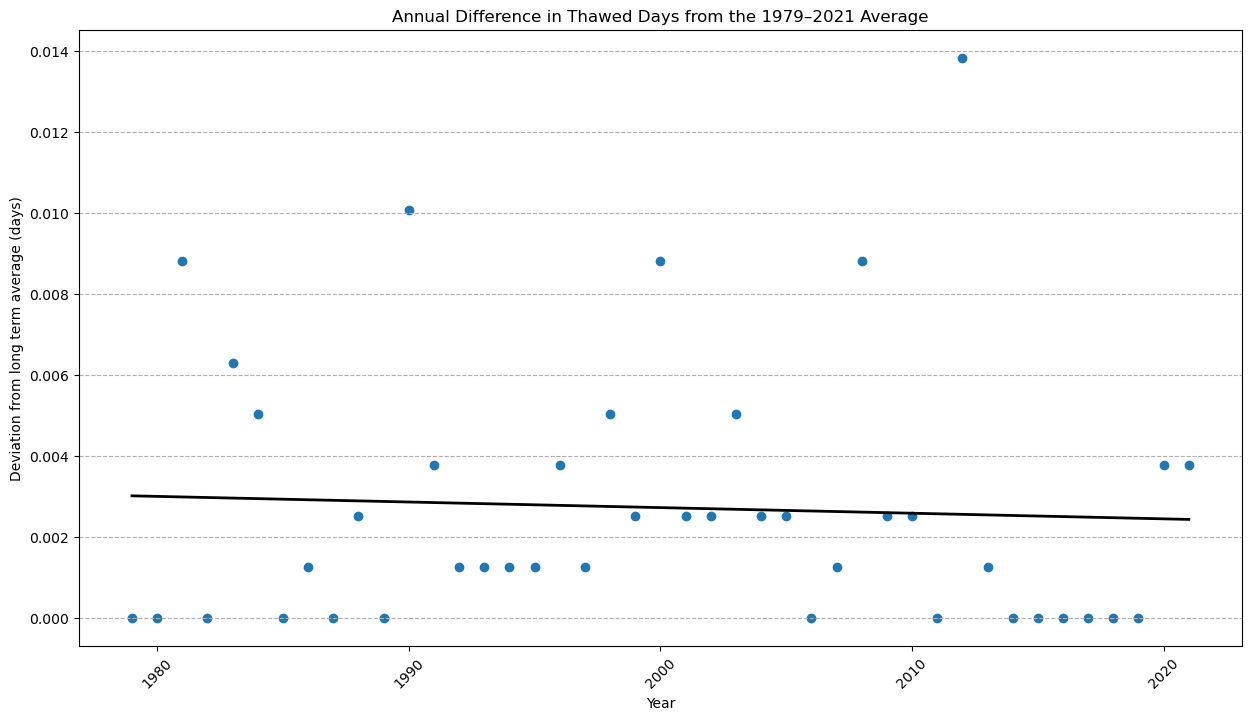

Aug
-0.000540223269490492 -0.00015126691276729756 -0.0009291796262136865
m                -0.00054
b                 1.10458
r2              -0.401249
std_err          0.000193
p_value          0.007659
MK_trend       decreasing
MK_p_value       0.012219
MK_z            -2.505768
MK_tau          -0.265781
MK_s               -240.0
MK_var_s      9097.333333
MK_h                 True
dtype: object


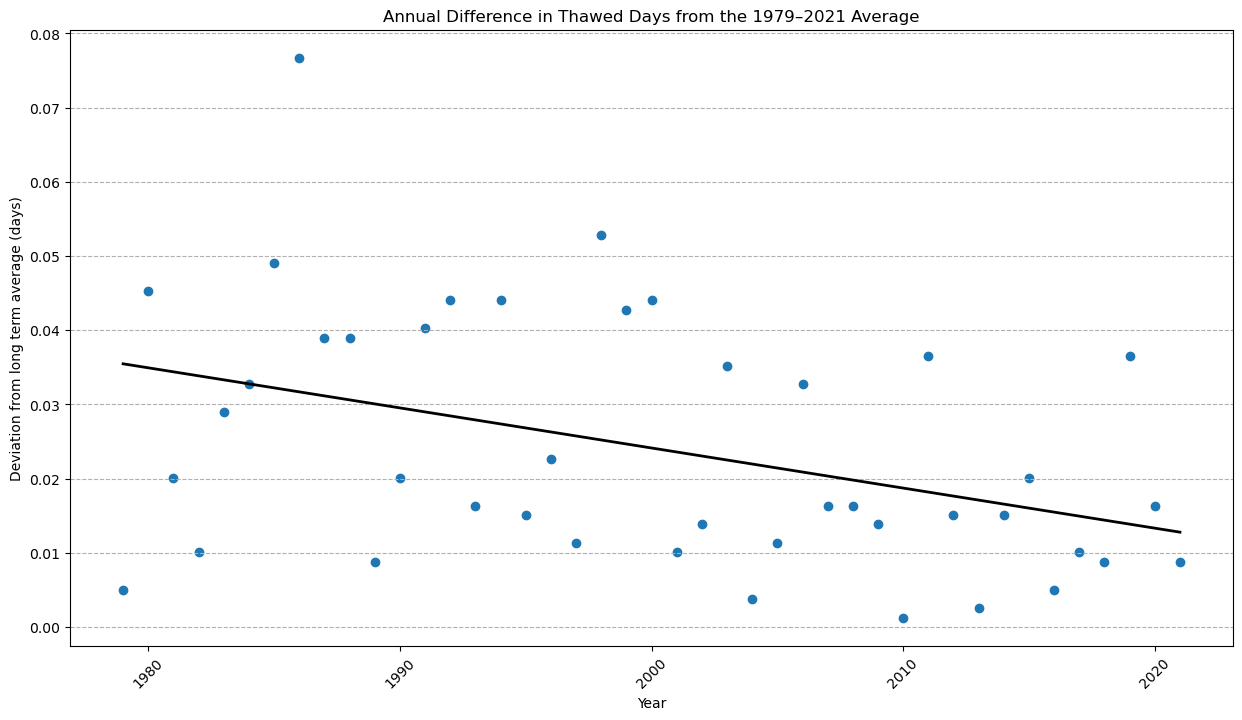

Sep
-0.0005309156252552479 0.0001745446181350437 -0.0012363758686455397
m               -0.000531
b                1.205988
r2              -0.230947
std_err          0.000349
p_value          0.136219
MK_trend         no trend
MK_p_value       0.183596
MK_z            -1.329764
MK_tau           -0.14175
MK_s               -128.0
MK_var_s      9121.333333
MK_h                False
dtype: object


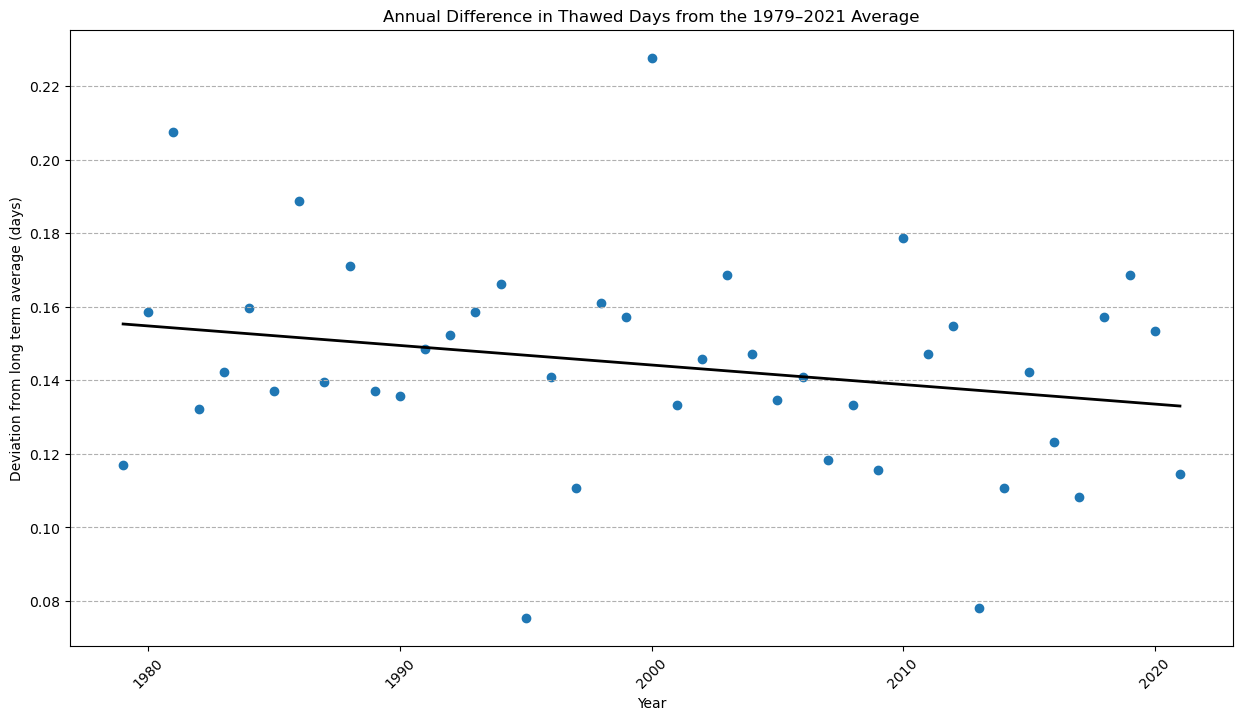

Oct
-0.002086052020233678 0.014798115982878314 -0.01897022002334567
m               -0.002086
b                4.779417
r2              -0.038938
std_err           0.00836
p_value          0.804208
MK_trend         no trend
MK_p_value       0.379297
MK_z             0.879192
MK_tau           0.094131
MK_s                 85.0
MK_var_s      9128.333333
MK_h                False
dtype: object


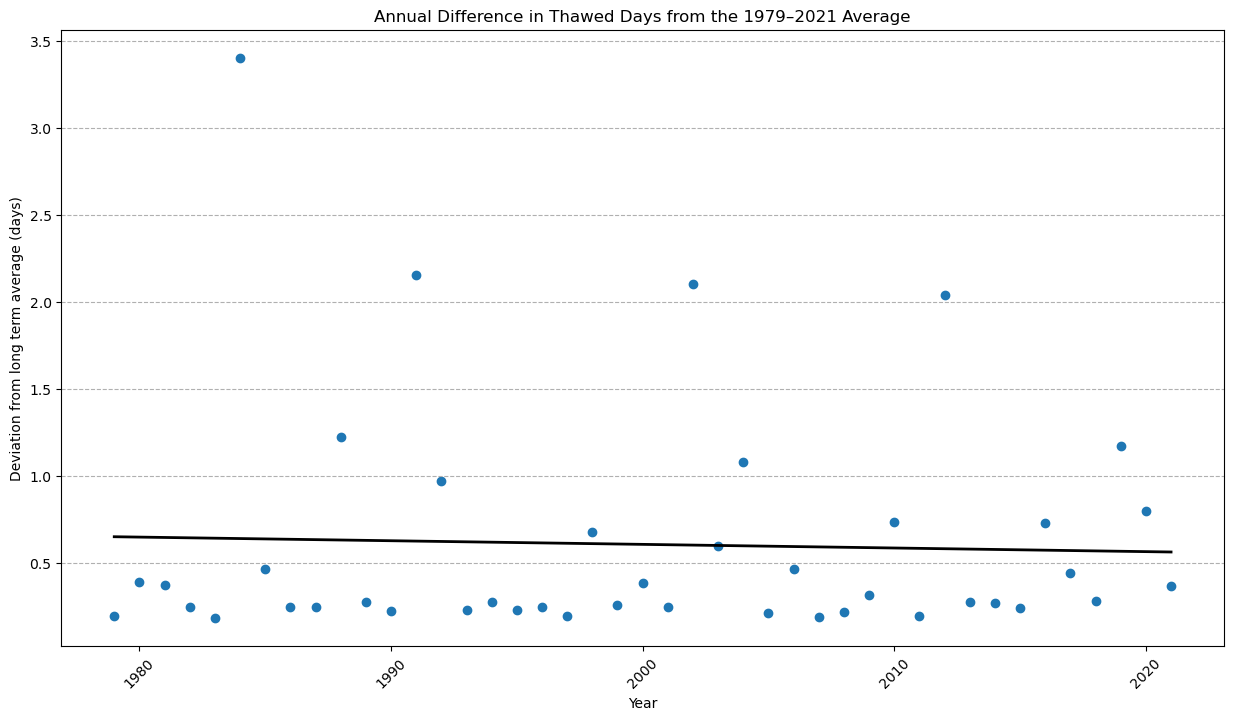

Nov
-0.02732249467659736 0.07362118403551336 -0.12826617338870808
m               -0.027322
b               58.721573
r2               -0.08506
std_err          0.049983
p_value          0.587595
MK_trend         no trend
MK_p_value       0.630226
MK_z            -0.481409
MK_tau          -0.052049
MK_s                -47.0
MK_var_s      9130.333333
MK_h                False
dtype: object


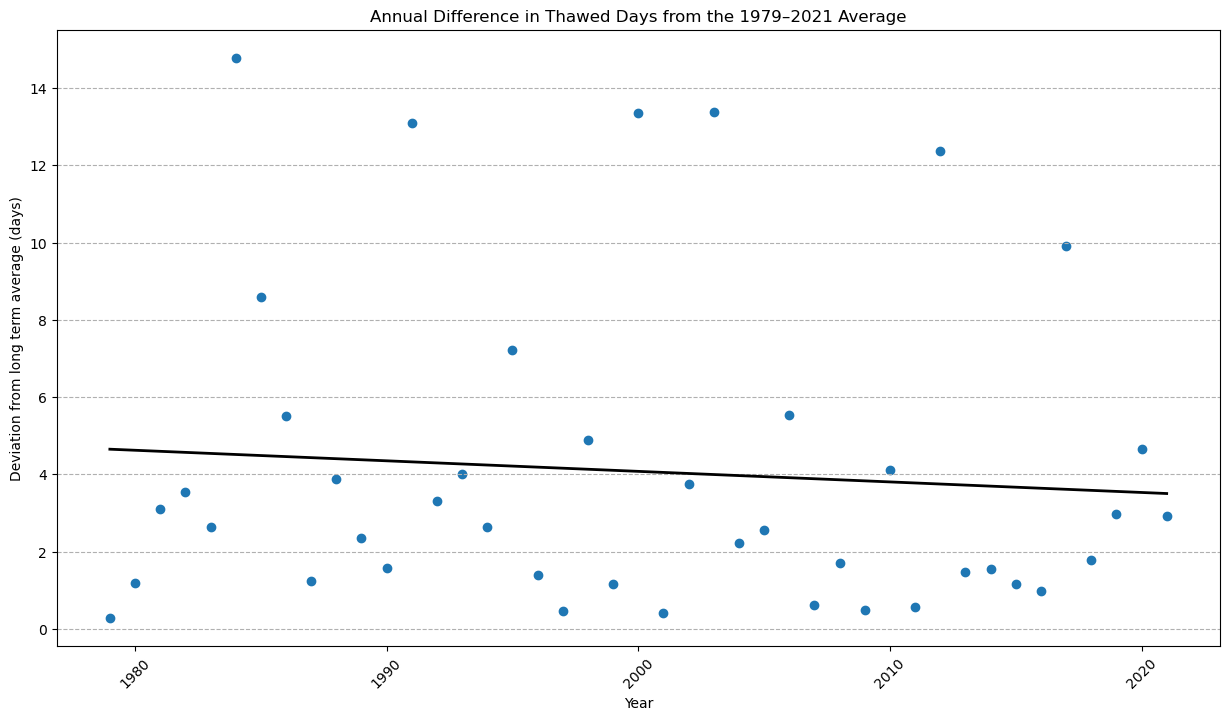

Dec
-0.09240534220788718 0.08482185835171963 -0.269632542767494
m               -0.092405
b              202.335096
r2              -0.162268
std_err          0.087756
p_value          0.298517
MK_trend         no trend
MK_p_value       0.267286
MK_z            -1.109335
MK_tau          -0.118494
MK_s               -107.0
MK_var_s      9130.333333
MK_h                False
dtype: object


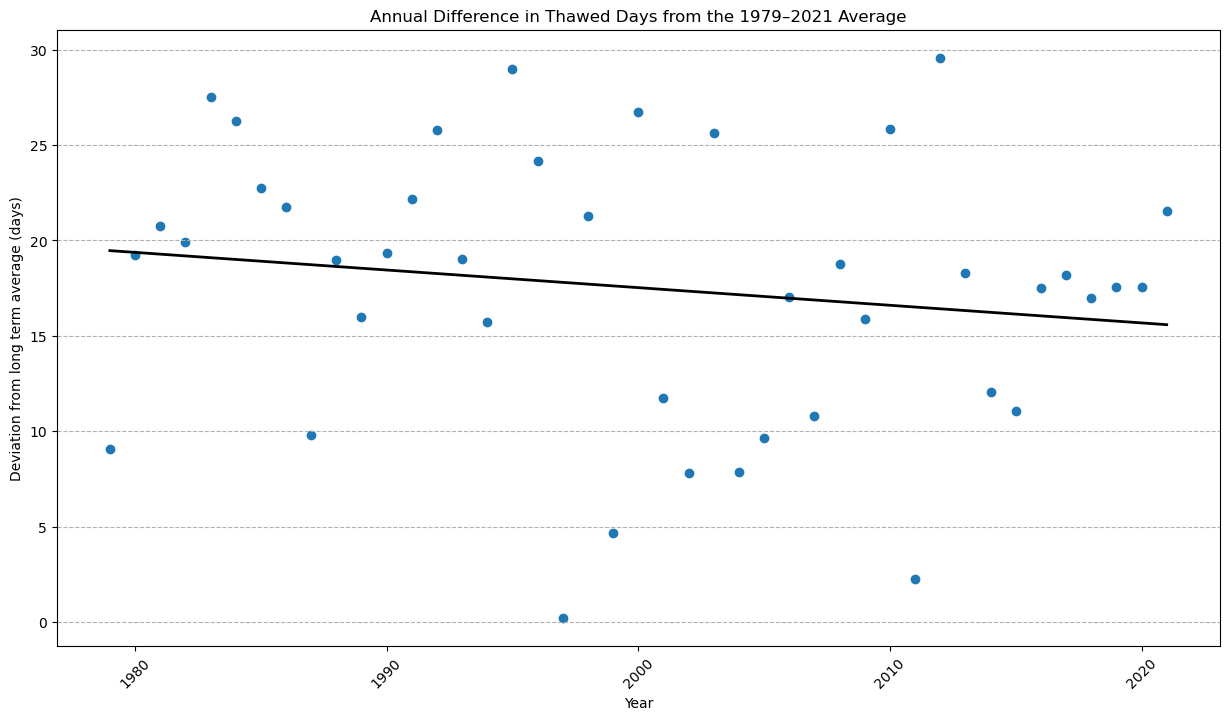

In [125]:
for dataframe_monthly in [monthly_Tundra, monthly_Boreal, monthly_Forest, monthly_Praires]:
    for month in month_names.values():
        print(month)
        # Step 1: 
        monthly_mean_days = dataframe_monthly[month]

        # Calculate Linear Regression for Trend Line
        # Converting index to a suitable format for linregress, assuming index is year and is numeric
        x = monthly['Year'].astype(int)  # Years
        y = monthly_mean_days.values  # Difference from average

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Calculate the values of the trend line
        trend_line = intercept + slope * x

        # Generate values for the trend line
        x_line = np.linspace(x.min(), x.max(), 100)  # Generating a smooth line
        y_line = intercept + slope * x_line


        # Calculate the number of data points and degrees of freedom
        n = len(x)
        d_f = n - 2  # degrees of freedom for linear regression

        # Set the desired confidence level (e.g., 95%)
        confidence_level = 0.95

        # Calculate the critical value from the t-distribution
        t_critical = t.ppf((1 + confidence_level) / 2, d_f)

        # Calculate the standard error of the estimate
        standard_error = std_err

        # Calculate the upper and lower bounds of the confidence interval
        upper_confidence = slope + t_critical * standard_error
        lower_confidence = slope - t_critical * standard_error

        print(slope, upper_confidence, lower_confidence)


        # Calculate the upper and lower bounds of the confidence interval
        upper_bound = (upper_confidence) * x + intercept
        lower_bound = (lower_confidence) * x + intercept


        mk_result = mk.original_test(y)

        # Constructing a Series to include various results from MK test and regression
        results = pd.Series({
            'm': slope,
            'b': intercept,
            'r2': r_value,
            'std_err': std_err,
            'p_value': p_value,
            'MK_trend': mk_result.trend,
            'MK_p_value': mk_result.p,
            'MK_z': mk_result.z,
            'MK_tau': mk_result.Tau,
            'MK_s': mk_result.s,
            'MK_var_s': mk_result.var_s,
            'MK_h': mk_result.h
        })

        print(results)

        # Step 4: Plot
        plt.figure(figsize=(15, 8))  # Adjusts the size of the figure
        # difference_from_average.plot(kind='bar', color=difference_from_average.apply(lambda x: 'r' if x > 0 else 'b'))
        # plt.axhline(0, color='black', linewidth=0.8)  # Adds a line at y=0 for reference

        # Bar chart
        plt.scatter(x, y)

        # Fill the area between upper and lower confidence bounds with a shaded color
        # plt.fill_between(x, lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')


        # Trend line
        plt.plot(x_line, y_line, color='black', linewidth=2, label='Trend Line')


        plt.title('Annual Difference in Thawed Days from the 1979–2021 Average')
        plt.xlabel('Year')
        plt.ylabel('Deviation from long term average (days)')
        plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
        plt.grid(axis='y', linestyle='--')  # Adds a grid for the y-axis
        plt.show()


        '''
        This figure shows the number of days the ground is considered unfrozen in the Canada compared with the 1979–2021 average.
        For each year, the bar represents the number of days shorter or longer than average.
        Positive numbers represent years with more unfrozen days than average.
        Choosing a different long-term average for comparison would not change the shape of the data over time.
'''

# Area

## Canada

### Annual

### Monthly

## Veg cover

### Anuual

### Monthly